## Dependancy Management

In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [2]:
!pip install pytorch-metric-learning


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import random_split, TensorDataset, DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import itertools
import random
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import nbformat
from torchmetrics.image import PeakSignalNoiseRatio
from torch.amp import autocast, GradScaler
from pytorch_metric_learning.samplers import MPerClassSampler
import glob
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Data Processing Pipeline

Labels shape: (1096, 715)
Hypercube shape: (1096, 715, 102)


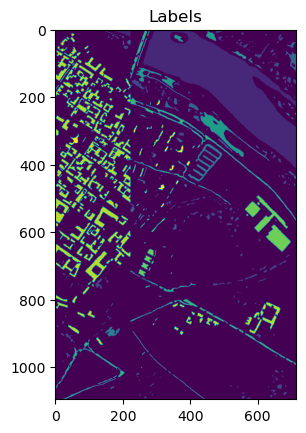

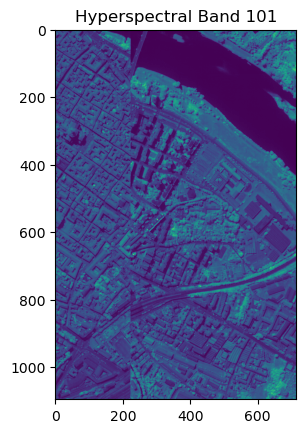

In [5]:
dataset_dir = r"C:\Users\vella\Documents\GitHub\FYP2425_LOCAL\FYP_DATASET"

gt_files = 'Pavia_gt.mat'
data_files = 'Pavia.mat'
label_files = 'pavia_gt'
hypercube_files = 'pavia'

def extract_Features():
    gt_file = os.path.join(dataset_dir, gt_files)
    data_file = os.path.join(dataset_dir, data_files)

    gt = sio.loadmat(gt_file)
    labels = gt[label_files]

    data = sio.loadmat(data_file)
    hypercube = data[hypercube_files]
    #scaling the data in place and setting to float32 to reduce memory usage
    max_value = np.max(hypercube)
    hypercube = (hypercube / max_value).astype(np.float32)


    #shapes of loaded data
    print(f"Labels shape: {labels.shape}")
    print(f"Hypercube shape: {hypercube.shape}")

    #visualisation of label map and a given band of hyperspectral data
    plt.figure()
    plt.imshow(labels)
    plt.title('Labels')

    band = 101
    plt.figure()
    plt.imshow(hypercube[:,:,band])
    plt.title(f'Hyperspectral Band {band}')
    plt.show()

    return hypercube, labels

hypercube, labels = extract_Features()

In [6]:
def extract_windows(data, labels, window_size):
    extract_windows_save_dir = 'extracted_windows_labels'
    if not os.path.exists(extract_windows_save_dir):
        os.makedirs(extract_windows_save_dir)
        print(f"Created directory: {extract_windows_save_dir}")

    margin = window_size // 2
    padded_data = np.pad(data, ((margin, margin), (margin, margin), (0, 0)), mode='constant')
    padded_labels = np.pad(labels, ((margin, margin), (margin, margin)), mode='constant')

    X_windows = []  #extracted windows
    y_labels = []   #corresponding labels

    print("Starting window extraction...")
    for i in range(margin, padded_data.shape[0] - margin):
        for j in range(margin, padded_data.shape[1] - margin):
            window = padded_data[i-margin:i+margin+1, j-margin:j+margin+1, :]
            label = padded_labels[i, j]

            if label != 0:
                #print('ignoring label 0 (background)')
                X_windows.append(window)
                y_labels.append(label)

    #convertying to numpy arrays
    X_windows = np.array(X_windows)
    y_labels = np.array(y_labels)

    #saving extracted windows and labels
    windows_file = os.path.join(extract_windows_save_dir, 'extracted_windows.npy')
    labels_file = os.path.join(extract_windows_save_dir, 'extracted_labels.npy')

    np.save(windows_file, X_windows)
    np.save(labels_file, y_labels)

    print(f"Saved extracted windows to: {windows_file}")
    print(f"Saved corresponding labels to: {labels_file}")
    print(f"\nTotal windows extracted: {len(X_windows)}")
    print(f"Extracted windows shape: {X_windows.shape}")
    print(f"Corresponding labels shape: {y_labels.shape}")

    return X_windows, y_labels

In [7]:
window_size = 5

X_windows, y_labels = extract_windows(hypercube, labels, window_size)

Created directory: extracted_windows_labels
Starting window extraction...


Saved extracted windows to: extracted_windows_labels\extracted_windows.npy
Saved corresponding labels to: extracted_windows_labels\extracted_labels.npy

Total windows extracted: 148152
Extracted windows shape: (148152, 5, 5, 102)
Corresponding labels shape: (148152,)


In [8]:
def get_samples(X_windows, y_labels, samples_per_class):
    
    indices_save_dir = 'indices'
    if not os.path.exists(indices_save_dir):
        os.makedirs(indices_save_dir)
        print(f"Created directory: {indices_save_dir}")
    
    #get unique classes
    classes = np.unique(y_labels)
    print(f"Unique classes found as: {classes}")

    #init lists
    X_sampled = [] #to store training samples
    y_sampled = [] #to store training labels

    X_val = [] # to store validation samples
    y_val = [] # to store validation labels

    selected_indices_total = [] #to store indices of selected training and validation samples
    validation_selected = [] #temp storage for validation indices
    validation_total = [] #to store all validation indices

    print("\n == STARTING SAMPLING PROCESS ==")
    for cls in classes:
        if cls == 0:
            print(f"!! SKIPPING CLASS 0 !!")
            continue

        #getting the indices for the current class:
        class_indices = np.where(y_labels == cls)[0]
        print(f"Class: {cls}: Found {len(class_indices)} samples")

        # shuffle class-specific indices to ensure randomness
        np.random.shuffle(class_indices)
        print(f"Shuffled class indices for class '{cls}'")

        #select 'samples_per_class' samples for training
        selected_indices = class_indices[:samples_per_class]
        #selecting 5 samples for validation
        validation_selected = class_indices[samples_per_class:samples_per_class+5]

        print(f"Selected {len(selected_indices)} training samples and {len(validation_selected)} validation samples for class '{cls}'\n")

        #store selected indices for training and validation
        selected_indices_total.extend(selected_indices)
        validation_total.extend(validation_selected)

        # appending the selected samples and their labels to the lists
        X_sampled.append(X_windows[selected_indices])
        y_sampled.append(y_labels[selected_indices])

        X_val.append(X_windows[validation_selected])
        y_val.append(y_labels[validation_selected])

    #concat the sampled arrays for training
    X_train = np.vstack(X_sampled)
    y_train = np.hstack(y_sampled)

    # shift labels to start from 0
    y_train = y_train - 1

    print(f"\n -- Training set created with: \n\t{X_train.shape[0]} samples\n\tshape {X_train.shape} --")

    #concat the sampled arrays for validation
    X_val = np.vstack(X_val)
    y_val = np.hstack(y_val)
    y_val = y_val - 1

    print(f"\n -- Validation set created with: \n\t{X_val.shape[0]} samples\n\tshape {X_val.shape} --")

    #create the test set from the remaining data (i.e. that which is not selected for training or validation)
    selected_indices_total.extend(validation_total)

    #getting indices not in the training or val sets
    test_indices = np.setdiff1d(np.arange(X_windows.shape[0]), selected_indices_total)
    X_test = X_windows[test_indices]
    y_test = y_labels[test_indices]
    y_test = y_test - 1

    print(f"\n -- Test set created with: \n\t{X_test.shape[0]} samples\n\tshape {X_test.shape} --\n")

    # Save the datasets to the 'datasets' folder
    np.save(os.path.join(indices_save_dir, 'X_train.npy'), X_train)
    np.save(os.path.join(indices_save_dir, 'y_train.npy'), y_train)
    np.save(os.path.join(indices_save_dir, 'X_val.npy'), X_val)
    np.save(os.path.join(indices_save_dir, 'y_val.npy'), y_val)
    np.save(os.path.join(indices_save_dir, 'X_test.npy'), X_test)
    np.save(os.path.join(indices_save_dir, 'y_test.npy'), y_test)

    print(f"\nAll datasets saved to the '{indices_save_dir}' folder.")

    #return the training, val, test sets + selected indices
    return X_train, X_test, y_train, y_test, X_val, y_val, selected_indices_total

In [9]:
X_train, X_test, y_train, y_test, X_val, y_val, selected_indices_total = get_samples(X_windows, y_labels, 40)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

Created directory: indices
Unique classes found as: [1 2 3 4 5 6 7 8 9]

 == STARTING SAMPLING PROCESS ==
Class: 1: Found 65971 samples
Shuffled class indices for class '1'
Selected 40 training samples and 5 validation samples for class '1'

Class: 2: Found 7598 samples
Shuffled class indices for class '2'
Selected 40 training samples and 5 validation samples for class '2'

Class: 3: Found 3090 samples
Shuffled class indices for class '3'
Selected 40 training samples and 5 validation samples for class '3'

Class: 4: Found 2685 samples
Shuffled class indices for class '4'
Selected 40 training samples and 5 validation samples for class '4'

Class: 5: Found 6584 samples
Shuffled class indices for class '5'
Selected 40 training samples and 5 validation samples for class '5'

Class: 6: Found 9248 samples
Shuffled class indices for class '6'
Selected 40 training samples and 5 validation samples for class '6'

Class: 7: Found 7287 samples
Shuffled class indices for class '7'
Selected 40 train


 -- Test set created with: 
	147747 samples
	shape (147747, 5, 5, 102) --




All datasets saved to the 'indices' folder.
(360, 5, 5, 102)
(45, 5, 5, 102)
(147747, 5, 5, 102)


In [10]:
class HyperspectralDataset(Dataset):
    def __init__(self, X, y):
        """
        Args:
            X (numpy.ndarray): Hyperspectral data of shape (num_samples, height, width, num_bands).
            y (numpy.ndarray): Labels of shape (num_samples,).
        """
        #converting to pytorch tensor
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [11]:
#loading the saved datasets
X_train = np.load('indices/X_train.npy')
y_train = np.load('indices/y_train.npy')
X_val = np.load('indices/X_val.npy')
y_val = np.load('indices/y_val.npy')
X_test = np.load('indices/X_test.npy')
y_test = np.load('indices/y_test.npy')


#creating pytorch datasets
train_dataset = HyperspectralDataset(X_train, y_train)
val_dataset = HyperspectralDataset(X_val, y_val)
test_dataset = HyperspectralDataset(X_test, y_test)

m = 20
num_classes = len(np.unique(y_train))

#theoretical batch size calc
required_batch_size = m * num_classes  # 10 * 9 = 90

#ensuring batch size doesn't exceed training set size
if required_batch_size > len(train_dataset):
    #case 1: not enough samples - reduce m proportionally
    print("Case 1 applied")
    max_possible_m = len(train_dataset) // num_classes
    m = max(1, max_possible_m)
    batch_size_train = m * num_classes
else:
    #case 2: use full batch size
    print("Case 2 applied")
    batch_size_train = required_batch_size

sampler = MPerClassSampler(labels = y_train, m=m, batch_size = batch_size_train, length_before_new_iter = len(train_dataset))

#dataloaders
train_loader = DataLoader(train_dataset, batch_size = batch_size_train, sampler=sampler)

batch_size = 256
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully!")

#class dist in first batch
for X_batch, y_batch in train_loader:
    unique, counts = np.unique(y_batch.numpy(), return_counts=True)
    print(f"Training batch size: {batch_size_train}")
    print("Class distribution in batch:", dict(zip(unique, counts)))
    break



Case 2 applied
DataLoaders created successfully!
Training batch size: 180
Class distribution in batch: {0: 20, 1: 20, 2: 20, 3: 20, 4: 20, 5: 20, 6: 20, 7: 20, 8: 20}


## Creating directory for saving model predictions

In [12]:
predictions_dir = 'model_predictions'
os.makedirs(predictions_dir, exist_ok=True)
print(f"Created dir: {predictions_dir}")

Created dir: model_predictions


## Creating the Dataset splits and Dataloaders for unsupervised tasks

In [13]:
X_train, X_val = train_test_split(X_windows, test_size=0.2, random_state=42)

print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")

Training data shape: (118521, 5, 5, 102)
Validation data shape: (29631, 5, 5, 102)


In [14]:
class UnsupervisedDataset(Dataset):
    def __init__(self, data):
        self.data = torch.tensor(data, dtype=torch.float32)  #converting to pytorch tensor

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [15]:
#creating datasets for unsupervised task
unsup_train_dataset = UnsupervisedDataset(X_train)
unsup_val_dataset = UnsupervisedDataset(X_val)

#dataloaders for unsupervised task
batch_size = 64
train_loader_cae = DataLoader(unsup_train_dataset, batch_size=batch_size, shuffle=True)
val_loader_cae = DataLoader(unsup_val_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully!")

DataLoaders created successfully!


In [16]:
window_num_channels = X_windows.shape[3]
print(window_num_channels)

102


## Convolutional Autoencoder

In [17]:
class ConvAutoEncode(nn.Module):
    def __init__(self, dropout_prob=0.1):
        super(ConvAutoEncode, self).__init__()

        #encoder
        self.encoder = nn.Sequential(
            #Block 1
            nn.Conv2d(window_num_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 5x5 -> 2x2

            #Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            #Bottleneck
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2, 2)  # 2x2 -> 1x1
        )

        #decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 128, kernel_size=2, stride=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.ConvTranspose2d(64, window_num_channels, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded


LOG: Epoch [1/50]


	 Training Batch [1/1852], Loss: 0.1733, PSNR: 3.6533


	 Training Batch [200/1852], Loss: 0.0952, PSNR: 7.2040


	 Training Batch [400/1852], Loss: 0.0405, PSNR: 8.8747


	 Training Batch [600/1852], Loss: 0.0245, PSNR: 12.5997


	 Training Batch [800/1852], Loss: 0.0175, PSNR: 13.0984


	 Training Batch [1000/1852], Loss: 0.0108, PSNR: 13.4124


	 Training Batch [1200/1852], Loss: 0.0098, PSNR: 16.1372


	 Training Batch [1400/1852], Loss: 0.0093, PSNR: 15.2587


	 Training Batch [1600/1852], Loss: 0.0076, PSNR: 17.6192


	 Training Batch [1800/1852], Loss: 0.0066, PSNR: 16.4892


Epoch [1/50] Training Loss: 0.0320, PSNR: 13.7031
	[Val]   Batch [1/463] Loss: 0.0054, PSNR: 17.8854
	[Val]   Batch [10/463] Loss: 0.0051, PSNR: 19.0149
	[Val]   Batch [20/463] Loss: 0.0052, PSNR: 17.9941
	[Val]   Batch [30/463] Loss: 0.0061, PSNR: 18.6211
	[Val]   Batch [40/463] Loss: 0.0049, PSNR: 17.7089
	[Val]   Batch [50/463] Loss: 0.0052, PSNR: 17.9022


	[Val]   Batch [60/463] Loss: 0.0049, PSNR: 17.9534
	[Val]   Batch [70/463] Loss: 0.0069, PSNR: 18.3416
	[Val]   Batch [80/463] Loss: 0.0062, PSNR: 20.2171
	[Val]   Batch [90/463] Loss: 0.0059, PSNR: 19.3290
	[Val]   Batch [100/463] Loss: 0.0060, PSNR: 19.0658
	[Val]   Batch [110/463] Loss: 0.0070, PSNR: 18.4552
	[Val]   Batch [120/463] Loss: 0.0047, PSNR: 17.9495
	[Val]   Batch [130/463] Loss: 0.0056, PSNR: 19.3633


	[Val]   Batch [140/463] Loss: 0.0064, PSNR: 18.9521
	[Val]   Batch [150/463] Loss: 0.0074, PSNR: 18.9366
	[Val]   Batch [160/463] Loss: 0.0060, PSNR: 19.1884
	[Val]   Batch [170/463] Loss: 0.0076, PSNR: 18.1597
	[Val]   Batch [180/463] Loss: 0.0056, PSNR: 18.9235
	[Val]   Batch [190/463] Loss: 0.0061, PSNR: 19.2553
	[Val]   Batch [200/463] Loss: 0.0061, PSNR: 18.5978


	[Val]   Batch [210/463] Loss: 0.0058, PSNR: 18.2816
	[Val]   Batch [220/463] Loss: 0.0057, PSNR: 19.5178
	[Val]   Batch [230/463] Loss: 0.0068, PSNR: 19.3036
	[Val]   Batch [240/463] Loss: 0.0052, PSNR: 18.0855
	[Val]   Batch [250/463] Loss: 0.0066, PSNR: 17.3106
	[Val]   Batch [260/463] Loss: 0.0058, PSNR: 18.3148
	[Val]   Batch [270/463] Loss: 0.0045, PSNR: 17.4221
	[Val]   Batch [280/463] Loss: 0.0054, PSNR: 20.1889


	[Val]   Batch [290/463] Loss: 0.0060, PSNR: 17.2042
	[Val]   Batch [300/463] Loss: 0.0061, PSNR: 19.4171
	[Val]   Batch [310/463] Loss: 0.0056, PSNR: 19.3070
	[Val]   Batch [320/463] Loss: 0.0057, PSNR: 19.1823
	[Val]   Batch [330/463] Loss: 0.0066, PSNR: 18.5740
	[Val]   Batch [340/463] Loss: 0.0054, PSNR: 19.5196
	[Val]   Batch [350/463] Loss: 0.0071, PSNR: 19.4838
	[Val]   Batch [360/463] Loss: 0.0048, PSNR: 20.3878


	[Val]   Batch [370/463] Loss: 0.0069, PSNR: 18.5568
	[Val]   Batch [380/463] Loss: 0.0069, PSNR: 18.6580
	[Val]   Batch [390/463] Loss: 0.0063, PSNR: 18.4885
	[Val]   Batch [400/463] Loss: 0.0055, PSNR: 17.5605
	[Val]   Batch [410/463] Loss: 0.0054, PSNR: 19.8422
	[Val]   Batch [420/463] Loss: 0.0056, PSNR: 18.6305
	[Val]   Batch [430/463] Loss: 0.0055, PSNR: 18.0763
	[Val]   Batch [440/463] Loss: 0.0054, PSNR: 19.1117


	[Val]   Batch [450/463] Loss: 0.0042, PSNR: 16.4326
	[Val]   Batch [460/463] Loss: 0.0059, PSNR: 17.7825
Epoch [1/50] Validation Loss: 0.0058, PSNR: 18.6253

LOG: Epoch [2/50]
	 Training Batch [1/1852], Loss: 0.0064, PSNR: 17.4387


	 Training Batch [200/1852], Loss: 0.0058, PSNR: 18.9255


	 Training Batch [400/1852], Loss: 0.0043, PSNR: 20.2901


	 Training Batch [600/1852], Loss: 0.0055, PSNR: 19.2836


	 Training Batch [800/1852], Loss: 0.0043, PSNR: 19.0598


	 Training Batch [1000/1852], Loss: 0.0040, PSNR: 21.7901


	 Training Batch [1200/1852], Loss: 0.0045, PSNR: 23.4583


	 Training Batch [1400/1852], Loss: 0.0041, PSNR: 20.1109


	 Training Batch [1600/1852], Loss: 0.0026, PSNR: 20.5307


	 Training Batch [1800/1852], Loss: 0.0032, PSNR: 21.2946


Epoch [2/50] Training Loss: 0.0044, PSNR: 20.0980
	[Val]   Batch [1/463] Loss: 0.0026, PSNR: 21.1193
	[Val]   Batch [10/463] Loss: 0.0024, PSNR: 22.3172
	[Val]   Batch [20/463] Loss: 0.0024, PSNR: 21.3945
	[Val]   Batch [30/463] Loss: 0.0030, PSNR: 21.7423
	[Val]   Batch [40/463] Loss: 0.0023, PSNR: 20.9133
	[Val]   Batch [50/463] Loss: 0.0025, PSNR: 21.1316
	[Val]   Batch [60/463] Loss: 0.0023, PSNR: 21.2184


	[Val]   Batch [70/463] Loss: 0.0034, PSNR: 21.3816
	[Val]   Batch [80/463] Loss: 0.0031, PSNR: 23.2741
	[Val]   Batch [90/463] Loss: 0.0028, PSNR: 22.5293
	[Val]   Batch [100/463] Loss: 0.0030, PSNR: 22.0257
	[Val]   Batch [110/463] Loss: 0.0034, PSNR: 21.5547
	[Val]   Batch [120/463] Loss: 0.0023, PSNR: 21.1587
	[Val]   Batch [130/463] Loss: 0.0026, PSNR: 22.6728


	[Val]   Batch [140/463] Loss: 0.0032, PSNR: 22.0030
	[Val]   Batch [150/463] Loss: 0.0035, PSNR: 22.1544
	[Val]   Batch [160/463] Loss: 0.0030, PSNR: 22.1178
	[Val]   Batch [170/463] Loss: 0.0038, PSNR: 21.1566
	[Val]   Batch [180/463] Loss: 0.0029, PSNR: 21.7743
	[Val]   Batch [190/463] Loss: 0.0029, PSNR: 22.5262
	[Val]   Batch [200/463] Loss: 0.0030, PSNR: 21.7555
	[Val]   Batch [210/463] Loss: 0.0030, PSNR: 21.1058


	[Val]   Batch [220/463] Loss: 0.0029, PSNR: 22.4863
	[Val]   Batch [230/463] Loss: 0.0032, PSNR: 22.5326
	[Val]   Batch [240/463] Loss: 0.0025, PSNR: 21.2786
	[Val]   Batch [250/463] Loss: 0.0033, PSNR: 20.3371
	[Val]   Batch [260/463] Loss: 0.0028, PSNR: 21.3875
	[Val]   Batch [270/463] Loss: 0.0021, PSNR: 20.8150


	[Val]   Batch [280/463] Loss: 0.0026, PSNR: 23.3801
	[Val]   Batch [290/463] Loss: 0.0029, PSNR: 20.3942
	[Val]   Batch [300/463] Loss: 0.0030, PSNR: 22.5357
	[Val]   Batch [310/463] Loss: 0.0029, PSNR: 22.2032
	[Val]   Batch [320/463] Loss: 0.0028, PSNR: 22.2681
	[Val]   Batch [330/463] Loss: 0.0031, PSNR: 21.8663
	[Val]   Batch [340/463] Loss: 0.0026, PSNR: 22.6540
	[Val]   Batch [350/463] Loss: 0.0037, PSNR: 22.3129


	[Val]   Batch [360/463] Loss: 0.0025, PSNR: 23.2426
	[Val]   Batch [370/463] Loss: 0.0033, PSNR: 21.7392
	[Val]   Batch [380/463] Loss: 0.0031, PSNR: 22.0560
	[Val]   Batch [390/463] Loss: 0.0030, PSNR: 21.7741
	[Val]   Batch [400/463] Loss: 0.0027, PSNR: 20.5849
	[Val]   Batch [410/463] Loss: 0.0025, PSNR: 23.1437
	[Val]   Batch [420/463] Loss: 0.0027, PSNR: 21.8931


	[Val]   Batch [430/463] Loss: 0.0027, PSNR: 21.0997
	[Val]   Batch [440/463] Loss: 0.0027, PSNR: 22.0782
	[Val]   Batch [450/463] Loss: 0.0020, PSNR: 19.5565
	[Val]   Batch [460/463] Loss: 0.0028, PSNR: 21.0450
Epoch [2/50] Validation Loss: 0.0028, PSNR: 21.7847

LOG: Epoch [3/50]
	 Training Batch [1/1852], Loss: 0.0029, PSNR: 21.9115


	 Training Batch [200/1852], Loss: 0.0025, PSNR: 21.9653


	 Training Batch [400/1852], Loss: 0.0022, PSNR: 22.4654


	 Training Batch [600/1852], Loss: 0.0024, PSNR: 22.1777


	 Training Batch [800/1852], Loss: 0.0023, PSNR: 21.4751


	 Training Batch [1000/1852], Loss: 0.0022, PSNR: 22.2794


	 Training Batch [1200/1852], Loss: 0.0019, PSNR: 24.7020


	 Training Batch [1400/1852], Loss: 0.0018, PSNR: 23.4884


	 Training Batch [1600/1852], Loss: 0.0018, PSNR: 23.1192


	 Training Batch [1800/1852], Loss: 0.0017, PSNR: 22.6445


Epoch [3/50] Training Loss: 0.0023, PSNR: 22.7991
	[Val]   Batch [1/463] Loss: 0.0015, PSNR: 23.4573
	[Val]   Batch [10/463] Loss: 0.0014, PSNR: 24.6915
	[Val]   Batch [20/463] Loss: 0.0013, PSNR: 23.8469
	[Val]   Batch [30/463] Loss: 0.0017, PSNR: 24.3098
	[Val]   Batch [40/463] Loss: 0.0014, PSNR: 23.0022
	[Val]   Batch [50/463] Loss: 0.0015, PSNR: 23.3838
	[Val]   Batch [60/463] Loss: 0.0014, PSNR: 23.3502


	[Val]   Batch [70/463] Loss: 0.0019, PSNR: 23.9558
	[Val]   Batch [80/463] Loss: 0.0017, PSNR: 25.9421
	[Val]   Batch [90/463] Loss: 0.0016, PSNR: 24.9309
	[Val]   Batch [100/463] Loss: 0.0017, PSNR: 24.4902
	[Val]   Batch [110/463] Loss: 0.0019, PSNR: 24.1688
	[Val]   Batch [120/463] Loss: 0.0014, PSNR: 23.2844
	[Val]   Batch [130/463] Loss: 0.0014, PSNR: 25.2707
	[Val]   Batch [140/463] Loss: 0.0018, PSNR: 24.5320


	[Val]   Batch [150/463] Loss: 0.0018, PSNR: 25.0707
	[Val]   Batch [160/463] Loss: 0.0018, PSNR: 24.2757
	[Val]   Batch [170/463] Loss: 0.0022, PSNR: 23.5352
	[Val]   Batch [180/463] Loss: 0.0017, PSNR: 24.0613
	[Val]   Batch [190/463] Loss: 0.0016, PSNR: 25.0737
	[Val]   Batch [200/463] Loss: 0.0016, PSNR: 24.4679
	[Val]   Batch [210/463] Loss: 0.0018, PSNR: 23.2679
	[Val]   Batch [220/463] Loss: 0.0017, PSNR: 24.7235


	[Val]   Batch [230/463] Loss: 0.0016, PSNR: 25.5248
	[Val]   Batch [240/463] Loss: 0.0014, PSNR: 23.6207
	[Val]   Batch [250/463] Loss: 0.0020, PSNR: 22.5977
	[Val]   Batch [260/463] Loss: 0.0017, PSNR: 23.6203
	[Val]   Batch [270/463] Loss: 0.0012, PSNR: 22.9987
	[Val]   Batch [280/463] Loss: 0.0015, PSNR: 25.7298
	[Val]   Batch [290/463] Loss: 0.0017, PSNR: 22.7568


	[Val]   Batch [300/463] Loss: 0.0017, PSNR: 24.8544
	[Val]   Batch [310/463] Loss: 0.0018, PSNR: 24.2998
	[Val]   Batch [320/463] Loss: 0.0016, PSNR: 24.6737
	[Val]   Batch [330/463] Loss: 0.0017, PSNR: 24.5285
	[Val]   Batch [340/463] Loss: 0.0015, PSNR: 25.0034
	[Val]   Batch [350/463] Loss: 0.0021, PSNR: 24.7253
	[Val]   Batch [360/463] Loss: 0.0017, PSNR: 24.8832
	[Val]   Batch [370/463] Loss: 0.0018, PSNR: 24.3231


	[Val]   Batch [380/463] Loss: 0.0016, PSNR: 25.0026
	[Val]   Batch [390/463] Loss: 0.0016, PSNR: 24.5410
	[Val]   Batch [400/463] Loss: 0.0017, PSNR: 22.6763
	[Val]   Batch [410/463] Loss: 0.0015, PSNR: 25.5447
	[Val]   Batch [420/463] Loss: 0.0015, PSNR: 24.3835
	[Val]   Batch [430/463] Loss: 0.0017, PSNR: 23.1723
	[Val]   Batch [440/463] Loss: 0.0016, PSNR: 24.2609


	[Val]   Batch [450/463] Loss: 0.0013, PSNR: 21.4456
	[Val]   Batch [460/463] Loss: 0.0016, PSNR: 23.4321
Epoch [3/50] Validation Loss: 0.0016, PSNR: 24.2041

LOG: Epoch [4/50]
	 Training Batch [1/1852], Loss: 0.0018, PSNR: 22.5336


	 Training Batch [200/1852], Loss: 0.0020, PSNR: 22.5473


	 Training Batch [400/1852], Loss: 0.0018, PSNR: 22.8322


	 Training Batch [600/1852], Loss: 0.0015, PSNR: 25.1206


	 Training Batch [800/1852], Loss: 0.0016, PSNR: 23.8562


	 Training Batch [1000/1852], Loss: 0.0016, PSNR: 23.4286


	 Training Batch [1200/1852], Loss: 0.0015, PSNR: 23.3347


	 Training Batch [1400/1852], Loss: 0.0013, PSNR: 24.7892


	 Training Batch [1600/1852], Loss: 0.0014, PSNR: 23.1607


	 Training Batch [1800/1852], Loss: 0.0014, PSNR: 23.4560


Epoch [4/50] Training Loss: 0.0016, PSNR: 24.4401
	[Val]   Batch [1/463] Loss: 0.0011, PSNR: 24.7108
	[Val]   Batch [10/463] Loss: 0.0010, PSNR: 25.9367
	[Val]   Batch [20/463] Loss: 0.0010, PSNR: 25.0802
	[Val]   Batch [30/463] Loss: 0.0012, PSNR: 25.6509
	[Val]   Batch [40/463] Loss: 0.0011, PSNR: 24.1331
	[Val]   Batch [50/463] Loss: 0.0011, PSNR: 24.5755
	[Val]   Batch [60/463] Loss: 0.0011, PSNR: 24.5471


	[Val]   Batch [70/463] Loss: 0.0014, PSNR: 25.2803
	[Val]   Batch [80/463] Loss: 0.0012, PSNR: 27.3966
	[Val]   Batch [90/463] Loss: 0.0012, PSNR: 26.2398
	[Val]   Batch [100/463] Loss: 0.0013, PSNR: 25.8507
	[Val]   Batch [110/463] Loss: 0.0013, PSNR: 25.6040
	[Val]   Batch [120/463] Loss: 0.0011, PSNR: 24.4865
	[Val]   Batch [130/463] Loss: 0.0010, PSNR: 26.6153
	[Val]   Batch [140/463] Loss: 0.0013, PSNR: 25.8806


	[Val]   Batch [150/463] Loss: 0.0013, PSNR: 26.5131
	[Val]   Batch [160/463] Loss: 0.0014, PSNR: 25.4249
	[Val]   Batch [170/463] Loss: 0.0017, PSNR: 24.8019
	[Val]   Batch [180/463] Loss: 0.0013, PSNR: 25.2788
	[Val]   Batch [190/463] Loss: 0.0012, PSNR: 26.2965
	[Val]   Batch [200/463] Loss: 0.0012, PSNR: 25.8286
	[Val]   Batch [210/463] Loss: 0.0014, PSNR: 24.4745


	[Val]   Batch [220/463] Loss: 0.0013, PSNR: 25.9742
	[Val]   Batch [230/463] Loss: 0.0011, PSNR: 27.0793
	[Val]   Batch [240/463] Loss: 0.0011, PSNR: 24.9197
	[Val]   Batch [250/463] Loss: 0.0015, PSNR: 23.8089
	[Val]   Batch [260/463] Loss: 0.0013, PSNR: 24.7676
	[Val]   Batch [270/463] Loss: 0.0009, PSNR: 24.2312
	[Val]   Batch [280/463] Loss: 0.0011, PSNR: 26.9919


	[Val]   Batch [290/463] Loss: 0.0012, PSNR: 24.1000
	[Val]   Batch [300/463] Loss: 0.0013, PSNR: 25.9853
	[Val]   Batch [310/463] Loss: 0.0014, PSNR: 25.4812
	[Val]   Batch [320/463] Loss: 0.0012, PSNR: 26.0115
	[Val]   Batch [330/463] Loss: 0.0012, PSNR: 25.8975
	[Val]   Batch [340/463] Loss: 0.0011, PSNR: 26.2966
	[Val]   Batch [350/463] Loss: 0.0016, PSNR: 26.0340


	[Val]   Batch [360/463] Loss: 0.0014, PSNR: 25.7973
	[Val]   Batch [370/463] Loss: 0.0013, PSNR: 25.7630
	[Val]   Batch [380/463] Loss: 0.0011, PSNR: 26.4858
	[Val]   Batch [390/463] Loss: 0.0011, PSNR: 26.0051
	[Val]   Batch [400/463] Loss: 0.0013, PSNR: 23.8503
	[Val]   Batch [410/463] Loss: 0.0011, PSNR: 26.8537
	[Val]   Batch [420/463] Loss: 0.0011, PSNR: 25.6290
	[Val]   Batch [430/463] Loss: 0.0013, PSNR: 24.2635


	[Val]   Batch [440/463] Loss: 0.0012, PSNR: 25.5146
	[Val]   Batch [450/463] Loss: 0.0010, PSNR: 22.5693
	[Val]   Batch [460/463] Loss: 0.0012, PSNR: 24.6407
Epoch [4/50] Validation Loss: 0.0012, PSNR: 25.4951

LOG: Epoch [5/50]
	 Training Batch [1/1852], Loss: 0.0013, PSNR: 26.3577


	 Training Batch [200/1852], Loss: 0.0013, PSNR: 24.7331


	 Training Batch [400/1852], Loss: 0.0017, PSNR: 24.2443


	 Training Batch [600/1852], Loss: 0.0013, PSNR: 25.5150


	 Training Batch [800/1852], Loss: 0.0011, PSNR: 24.5516


	 Training Batch [1000/1852], Loss: 0.0010, PSNR: 26.6811


	 Training Batch [1200/1852], Loss: 0.0012, PSNR: 24.6053


	 Training Batch [1400/1852], Loss: 0.0010, PSNR: 27.7247


	 Training Batch [1600/1852], Loss: 0.0011, PSNR: 24.9392


	 Training Batch [1800/1852], Loss: 0.0013, PSNR: 26.7436


Epoch [5/50] Training Loss: 0.0012, PSNR: 25.4773
	[Val]   Batch [1/463] Loss: 0.0009, PSNR: 25.8456
	[Val]   Batch [10/463] Loss: 0.0008, PSNR: 27.1482
	[Val]   Batch [20/463] Loss: 0.0008, PSNR: 26.3236
	[Val]   Batch [30/463] Loss: 0.0009, PSNR: 26.8093
	[Val]   Batch [40/463] Loss: 0.0009, PSNR: 25.2262
	[Val]   Batch [50/463] Loss: 0.0008, PSNR: 25.7937
	[Val]   Batch [60/463] Loss: 0.0008, PSNR: 25.6429


	[Val]   Batch [70/463] Loss: 0.0011, PSNR: 26.4821
	[Val]   Batch [80/463] Loss: 0.0008, PSNR: 28.8247
	[Val]   Batch [90/463] Loss: 0.0009, PSNR: 27.5142
	[Val]   Batch [100/463] Loss: 0.0009, PSNR: 27.0669
	[Val]   Batch [110/463] Loss: 0.0010, PSNR: 26.8957
	[Val]   Batch [120/463] Loss: 0.0008, PSNR: 25.6926


	[Val]   Batch [130/463] Loss: 0.0008, PSNR: 27.8085
	[Val]   Batch [140/463] Loss: 0.0010, PSNR: 27.1073
	[Val]   Batch [150/463] Loss: 0.0010, PSNR: 27.8136
	[Val]   Batch [160/463] Loss: 0.0011, PSNR: 26.4875
	[Val]   Batch [170/463] Loss: 0.0013, PSNR: 25.8991
	[Val]   Batch [180/463] Loss: 0.0010, PSNR: 26.4395


	[Val]   Batch [190/463] Loss: 0.0009, PSNR: 27.4529
	[Val]   Batch [200/463] Loss: 0.0008, PSNR: 27.1879
	[Val]   Batch [210/463] Loss: 0.0011, PSNR: 25.5659
	[Val]   Batch [220/463] Loss: 0.0010, PSNR: 27.0689
	[Val]   Batch [230/463] Loss: 0.0008, PSNR: 28.4759
	[Val]   Batch [240/463] Loss: 0.0008, PSNR: 26.1576
	[Val]   Batch [250/463] Loss: 0.0012, PSNR: 24.8863


	[Val]   Batch [260/463] Loss: 0.0010, PSNR: 25.7955
	[Val]   Batch [270/463] Loss: 0.0007, PSNR: 25.5063
	[Val]   Batch [280/463] Loss: 0.0009, PSNR: 28.1614
	[Val]   Batch [290/463] Loss: 0.0009, PSNR: 25.3420
	[Val]   Batch [300/463] Loss: 0.0011, PSNR: 27.0175
	[Val]   Batch [310/463] Loss: 0.0010, PSNR: 26.6255
	[Val]   Batch [320/463] Loss: 0.0009, PSNR: 27.2697


	[Val]   Batch [330/463] Loss: 0.0009, PSNR: 27.1719
	[Val]   Batch [340/463] Loss: 0.0009, PSNR: 27.5184
	[Val]   Batch [350/463] Loss: 0.0012, PSNR: 27.2032
	[Val]   Batch [360/463] Loss: 0.0011, PSNR: 26.6212
	[Val]   Batch [370/463] Loss: 0.0010, PSNR: 27.0437
	[Val]   Batch [380/463] Loss: 0.0008, PSNR: 27.9041
	[Val]   Batch [390/463] Loss: 0.0008, PSNR: 27.3260
	[Val]   Batch [400/463] Loss: 0.0010, PSNR: 24.9229


	[Val]   Batch [410/463] Loss: 0.0008, PSNR: 28.0781
	[Val]   Batch [420/463] Loss: 0.0009, PSNR: 26.8174
	[Val]   Batch [430/463] Loss: 0.0010, PSNR: 25.2817
	[Val]   Batch [440/463] Loss: 0.0009, PSNR: 26.6701
	[Val]   Batch [450/463] Loss: 0.0008, PSNR: 23.6459
	[Val]   Batch [460/463] Loss: 0.0009, PSNR: 25.7899
Epoch [5/50] Validation Loss: 0.0009, PSNR: 26.7064

LOG: Epoch [6/50]
	 Training Batch [1/1852], Loss: 0.0013, PSNR: 25.8387


	 Training Batch [200/1852], Loss: 0.0009, PSNR: 27.0384


	 Training Batch [400/1852], Loss: 0.0011, PSNR: 23.6729


	 Training Batch [600/1852], Loss: 0.0011, PSNR: 25.9426


	 Training Batch [800/1852], Loss: 0.0010, PSNR: 25.8845


	 Training Batch [1000/1852], Loss: 0.0010, PSNR: 26.1902


	 Training Batch [1200/1852], Loss: 0.0009, PSNR: 25.8174


	 Training Batch [1400/1852], Loss: 0.0009, PSNR: 26.7647


	 Training Batch [1600/1852], Loss: 0.0010, PSNR: 27.1861


	 Training Batch [1800/1852], Loss: 0.0012, PSNR: 26.0207


Epoch [6/50] Training Loss: 0.0010, PSNR: 26.2399
	[Val]   Batch [1/463] Loss: 0.0007, PSNR: 26.6100
	[Val]   Batch [10/463] Loss: 0.0006, PSNR: 27.9900
	[Val]   Batch [20/463] Loss: 0.0006, PSNR: 27.1863
	[Val]   Batch [30/463] Loss: 0.0008, PSNR: 27.6507
	[Val]   Batch [40/463] Loss: 0.0007, PSNR: 26.0061
	[Val]   Batch [50/463] Loss: 0.0007, PSNR: 26.6552
	[Val]   Batch [60/463] Loss: 0.0007, PSNR: 26.4297


	[Val]   Batch [70/463] Loss: 0.0009, PSNR: 27.2830
	[Val]   Batch [80/463] Loss: 0.0007, PSNR: 29.8215
	[Val]   Batch [90/463] Loss: 0.0007, PSNR: 28.4008
	[Val]   Batch [100/463] Loss: 0.0008, PSNR: 27.9249
	[Val]   Batch [110/463] Loss: 0.0008, PSNR: 27.7951
	[Val]   Batch [120/463] Loss: 0.0007, PSNR: 26.5167
	[Val]   Batch [130/463] Loss: 0.0007, PSNR: 28.5794
	[Val]   Batch [140/463] Loss: 0.0008, PSNR: 28.0054


	[Val]   Batch [150/463] Loss: 0.0008, PSNR: 28.6926
	[Val]   Batch [160/463] Loss: 0.0009, PSNR: 27.2808
	[Val]   Batch [170/463] Loss: 0.0011, PSNR: 26.6821
	[Val]   Batch [180/463] Loss: 0.0008, PSNR: 27.2928
	[Val]   Batch [190/463] Loss: 0.0008, PSNR: 28.2522
	[Val]   Batch [200/463] Loss: 0.0007, PSNR: 28.1372
	[Val]   Batch [210/463] Loss: 0.0009, PSNR: 26.4054


	[Val]   Batch [220/463] Loss: 0.0008, PSNR: 27.8639
	[Val]   Batch [230/463] Loss: 0.0007, PSNR: 29.4152
	[Val]   Batch [240/463] Loss: 0.0007, PSNR: 27.0386
	[Val]   Batch [250/463] Loss: 0.0010, PSNR: 25.7086
	[Val]   Batch [260/463] Loss: 0.0009, PSNR: 26.5995
	[Val]   Batch [270/463] Loss: 0.0006, PSNR: 26.5218


	[Val]   Batch [280/463] Loss: 0.0007, PSNR: 29.0223
	[Val]   Batch [290/463] Loss: 0.0008, PSNR: 26.2034
	[Val]   Batch [300/463] Loss: 0.0009, PSNR: 27.7911
	[Val]   Batch [310/463] Loss: 0.0009, PSNR: 27.4924
	[Val]   Batch [320/463] Loss: 0.0007, PSNR: 28.1955
	[Val]   Batch [330/463] Loss: 0.0007, PSNR: 28.0566
	[Val]   Batch [340/463] Loss: 0.0007, PSNR: 28.4110


	[Val]   Batch [350/463] Loss: 0.0010, PSNR: 28.0045
	[Val]   Batch [360/463] Loss: 0.0010, PSNR: 27.2361
	[Val]   Batch [370/463] Loss: 0.0008, PSNR: 27.9009
	[Val]   Batch [380/463] Loss: 0.0007, PSNR: 28.8569
	[Val]   Batch [390/463] Loss: 0.0007, PSNR: 28.2382
	[Val]   Batch [400/463] Loss: 0.0008, PSNR: 25.6921
	[Val]   Batch [410/463] Loss: 0.0007, PSNR: 28.9199


	[Val]   Batch [420/463] Loss: 0.0007, PSNR: 27.6755
	[Val]   Batch [430/463] Loss: 0.0009, PSNR: 26.0344
	[Val]   Batch [440/463] Loss: 0.0008, PSNR: 27.4656
	[Val]   Batch [450/463] Loss: 0.0007, PSNR: 24.4922
	[Val]   Batch [460/463] Loss: 0.0008, PSNR: 26.6170
Epoch [6/50] Validation Loss: 0.0007, PSNR: 27.5603

LOG: Epoch [7/50]
	 Training Batch [1/1852], Loss: 0.0009, PSNR: 26.1828


	 Training Batch [200/1852], Loss: 0.0009, PSNR: 25.7899


	 Training Batch [400/1852], Loss: 0.0008, PSNR: 25.3421


	 Training Batch [600/1852], Loss: 0.0008, PSNR: 27.6996


	 Training Batch [800/1852], Loss: 0.0007, PSNR: 27.4669


	 Training Batch [1000/1852], Loss: 0.0008, PSNR: 27.7829


	 Training Batch [1200/1852], Loss: 0.0008, PSNR: 27.5413


	 Training Batch [1400/1852], Loss: 0.0007, PSNR: 28.1359


	 Training Batch [1600/1852], Loss: 0.0008, PSNR: 27.6546


	 Training Batch [1800/1852], Loss: 0.0007, PSNR: 27.3456


Epoch [7/50] Training Loss: 0.0009, PSNR: 26.9188
	[Val]   Batch [1/463] Loss: 0.0006, PSNR: 27.1738
	[Val]   Batch [10/463] Loss: 0.0006, PSNR: 28.5983
	[Val]   Batch [20/463] Loss: 0.0005, PSNR: 27.7707
	[Val]   Batch [30/463] Loss: 0.0007, PSNR: 28.2173
	[Val]   Batch [40/463] Loss: 0.0006, PSNR: 26.5651
	[Val]   Batch [50/463] Loss: 0.0006, PSNR: 27.3112
	[Val]   Batch [60/463] Loss: 0.0006, PSNR: 27.0071


	[Val]   Batch [70/463] Loss: 0.0008, PSNR: 27.9092
	[Val]   Batch [80/463] Loss: 0.0006, PSNR: 30.6297
	[Val]   Batch [90/463] Loss: 0.0006, PSNR: 29.0081
	[Val]   Batch [100/463] Loss: 0.0007, PSNR: 28.6423
	[Val]   Batch [110/463] Loss: 0.0007, PSNR: 28.4635
	[Val]   Batch [120/463] Loss: 0.0006, PSNR: 27.1596
	[Val]   Batch [130/463] Loss: 0.0006, PSNR: 29.2136
	[Val]   Batch [140/463] Loss: 0.0007, PSNR: 28.5853


	[Val]   Batch [150/463] Loss: 0.0007, PSNR: 29.4219
	[Val]   Batch [160/463] Loss: 0.0008, PSNR: 27.9132
	[Val]   Batch [170/463] Loss: 0.0009, PSNR: 27.2924
	[Val]   Batch [180/463] Loss: 0.0007, PSNR: 27.9224
	[Val]   Batch [190/463] Loss: 0.0007, PSNR: 28.8876
	[Val]   Batch [200/463] Loss: 0.0006, PSNR: 28.7758
	[Val]   Batch [210/463] Loss: 0.0008, PSNR: 27.0535
	[Val]   Batch [220/463] Loss: 0.0007, PSNR: 28.4179


	[Val]   Batch [230/463] Loss: 0.0006, PSNR: 29.9880
	[Val]   Batch [240/463] Loss: 0.0006, PSNR: 27.6473
	[Val]   Batch [250/463] Loss: 0.0008, PSNR: 26.3378
	[Val]   Batch [260/463] Loss: 0.0007, PSNR: 27.2669
	[Val]   Batch [270/463] Loss: 0.0005, PSNR: 27.1675
	[Val]   Batch [280/463] Loss: 0.0006, PSNR: 29.6731
	[Val]   Batch [290/463] Loss: 0.0007, PSNR: 26.8512
	[Val]   Batch [300/463] Loss: 0.0008, PSNR: 28.2821


	[Val]   Batch [310/463] Loss: 0.0007, PSNR: 28.1736
	[Val]   Batch [320/463] Loss: 0.0006, PSNR: 28.8963
	[Val]   Batch [330/463] Loss: 0.0006, PSNR: 28.6721
	[Val]   Batch [340/463] Loss: 0.0006, PSNR: 29.1031
	[Val]   Batch [350/463] Loss: 0.0009, PSNR: 28.6530
	[Val]   Batch [360/463] Loss: 0.0009, PSNR: 27.6649
	[Val]   Batch [370/463] Loss: 0.0007, PSNR: 28.5396
	[Val]   Batch [380/463] Loss: 0.0006, PSNR: 29.5055


	[Val]   Batch [390/463] Loss: 0.0006, PSNR: 28.8950
	[Val]   Batch [400/463] Loss: 0.0007, PSNR: 26.3338
	[Val]   Batch [410/463] Loss: 0.0006, PSNR: 29.5259
	[Val]   Batch [420/463] Loss: 0.0006, PSNR: 28.2642
	[Val]   Batch [430/463] Loss: 0.0008, PSNR: 26.6871
	[Val]   Batch [440/463] Loss: 0.0007, PSNR: 28.1090
	[Val]   Batch [450/463] Loss: 0.0006, PSNR: 25.1748


	[Val]   Batch [460/463] Loss: 0.0007, PSNR: 27.2266
Epoch [7/50] Validation Loss: 0.0006, PSNR: 28.2001

LOG: Epoch [8/50]
	 Training Batch [1/1852], Loss: 0.0006, PSNR: 26.9623


	 Training Batch [200/1852], Loss: 0.0008, PSNR: 26.2803


	 Training Batch [400/1852], Loss: 0.0011, PSNR: 26.4450


	 Training Batch [600/1852], Loss: 0.0007, PSNR: 24.5199


	 Training Batch [800/1852], Loss: 0.0008, PSNR: 28.9148


	 Training Batch [1000/1852], Loss: 0.0009, PSNR: 26.0757


	 Training Batch [1200/1852], Loss: 0.0007, PSNR: 27.9670


	 Training Batch [1400/1852], Loss: 0.0009, PSNR: 26.5311


	 Training Batch [1600/1852], Loss: 0.0007, PSNR: 27.6641


	 Training Batch [1800/1852], Loss: 0.0011, PSNR: 26.3695


Epoch [8/50] Training Loss: 0.0008, PSNR: 27.5040
	[Val]   Batch [1/463] Loss: 0.0005, PSNR: 28.1043
	[Val]   Batch [10/463] Loss: 0.0004, PSNR: 29.5744
	[Val]   Batch [20/463] Loss: 0.0004, PSNR: 28.8680
	[Val]   Batch [30/463] Loss: 0.0005, PSNR: 29.0846
	[Val]   Batch [40/463] Loss: 0.0005, PSNR: 27.5023
	[Val]   Batch [50/463] Loss: 0.0005, PSNR: 28.4286


	[Val]   Batch [60/463] Loss: 0.0005, PSNR: 27.9145
	[Val]   Batch [70/463] Loss: 0.0006, PSNR: 28.8604
	[Val]   Batch [80/463] Loss: 0.0004, PSNR: 31.6298
	[Val]   Batch [90/463] Loss: 0.0005, PSNR: 29.9630
	[Val]   Batch [100/463] Loss: 0.0005, PSNR: 29.5171
	[Val]   Batch [110/463] Loss: 0.0006, PSNR: 29.3986
	[Val]   Batch [120/463] Loss: 0.0005, PSNR: 28.0590
	[Val]   Batch [130/463] Loss: 0.0005, PSNR: 30.1136


	[Val]   Batch [140/463] Loss: 0.0006, PSNR: 29.4849
	[Val]   Batch [150/463] Loss: 0.0005, PSNR: 30.4727
	[Val]   Batch [160/463] Loss: 0.0006, PSNR: 28.8354
	[Val]   Batch [170/463] Loss: 0.0008, PSNR: 28.1294
	[Val]   Batch [180/463] Loss: 0.0006, PSNR: 28.8651
	[Val]   Batch [190/463] Loss: 0.0005, PSNR: 29.8118
	[Val]   Batch [200/463] Loss: 0.0005, PSNR: 29.8521
	[Val]   Batch [210/463] Loss: 0.0006, PSNR: 27.9387


	[Val]   Batch [220/463] Loss: 0.0006, PSNR: 29.2421
	[Val]   Batch [230/463] Loss: 0.0005, PSNR: 30.9971
	[Val]   Batch [240/463] Loss: 0.0005, PSNR: 28.6582
	[Val]   Batch [250/463] Loss: 0.0007, PSNR: 27.2507
	[Val]   Batch [260/463] Loss: 0.0006, PSNR: 28.2076
	[Val]   Batch [270/463] Loss: 0.0004, PSNR: 28.2698
	[Val]   Batch [280/463] Loss: 0.0005, PSNR: 30.5884


	[Val]   Batch [290/463] Loss: 0.0005, PSNR: 27.8137
	[Val]   Batch [300/463] Loss: 0.0006, PSNR: 29.1660
	[Val]   Batch [310/463] Loss: 0.0006, PSNR: 29.0480
	[Val]   Batch [320/463] Loss: 0.0005, PSNR: 29.9058
	[Val]   Batch [330/463] Loss: 0.0005, PSNR: 29.6592
	[Val]   Batch [340/463] Loss: 0.0005, PSNR: 30.0545
	[Val]   Batch [350/463] Loss: 0.0007, PSNR: 29.4870


	[Val]   Batch [360/463] Loss: 0.0008, PSNR: 28.2737
	[Val]   Batch [370/463] Loss: 0.0006, PSNR: 29.4574
	[Val]   Batch [380/463] Loss: 0.0004, PSNR: 30.6506
	[Val]   Batch [390/463] Loss: 0.0005, PSNR: 29.8947
	[Val]   Batch [400/463] Loss: 0.0006, PSNR: 27.1111
	[Val]   Batch [410/463] Loss: 0.0005, PSNR: 30.4292
	[Val]   Batch [420/463] Loss: 0.0005, PSNR: 29.3087
	[Val]   Batch [430/463] Loss: 0.0006, PSNR: 27.5579


	[Val]   Batch [440/463] Loss: 0.0006, PSNR: 28.8926
	[Val]   Batch [450/463] Loss: 0.0005, PSNR: 26.0417
	[Val]   Batch [460/463] Loss: 0.0005, PSNR: 28.2537
Epoch [8/50] Validation Loss: 0.0005, PSNR: 29.1583

LOG: Epoch [9/50]
	 Training Batch [1/1852], Loss: 0.0006, PSNR: 27.9113


	 Training Batch [200/1852], Loss: 0.0006, PSNR: 29.4127


	 Training Batch [400/1852], Loss: 0.0008, PSNR: 26.3365


	 Training Batch [600/1852], Loss: 0.0007, PSNR: 27.9397


	 Training Batch [800/1852], Loss: 0.0007, PSNR: 26.5688


	 Training Batch [1000/1852], Loss: 0.0008, PSNR: 27.9039


	 Training Batch [1200/1852], Loss: 0.0009, PSNR: 28.9778


	 Training Batch [1400/1852], Loss: 0.0007, PSNR: 28.1682


	 Training Batch [1600/1852], Loss: 0.0007, PSNR: 28.3951


	 Training Batch [1800/1852], Loss: 0.0007, PSNR: 27.3840


Epoch [9/50] Training Loss: 0.0007, PSNR: 27.9631
	[Val]   Batch [1/463] Loss: 0.0005, PSNR: 28.5279
	[Val]   Batch [10/463] Loss: 0.0004, PSNR: 30.1806
	[Val]   Batch [20/463] Loss: 0.0004, PSNR: 29.3639
	[Val]   Batch [30/463] Loss: 0.0005, PSNR: 29.6246
	[Val]   Batch [40/463] Loss: 0.0005, PSNR: 28.0416
	[Val]   Batch [50/463] Loss: 0.0004, PSNR: 28.9813
	[Val]   Batch [60/463] Loss: 0.0004, PSNR: 28.4357
	[Val]   Batch [70/463] Loss: 0.0005, PSNR: 29.3963


	[Val]   Batch [80/463] Loss: 0.0004, PSNR: 32.2033
	[Val]   Batch [90/463] Loss: 0.0005, PSNR: 30.5139
	[Val]   Batch [100/463] Loss: 0.0005, PSNR: 30.0720
	[Val]   Batch [110/463] Loss: 0.0005, PSNR: 29.9843
	[Val]   Batch [120/463] Loss: 0.0004, PSNR: 28.6202
	[Val]   Batch [130/463] Loss: 0.0004, PSNR: 30.6266


	[Val]   Batch [140/463] Loss: 0.0005, PSNR: 30.0523
	[Val]   Batch [150/463] Loss: 0.0005, PSNR: 31.0846
	[Val]   Batch [160/463] Loss: 0.0006, PSNR: 29.4268
	[Val]   Batch [170/463] Loss: 0.0007, PSNR: 28.6984
	[Val]   Batch [180/463] Loss: 0.0005, PSNR: 29.4252
	[Val]   Batch [190/463] Loss: 0.0005, PSNR: 30.3140


	[Val]   Batch [200/463] Loss: 0.0004, PSNR: 30.3764
	[Val]   Batch [210/463] Loss: 0.0005, PSNR: 28.6164
	[Val]   Batch [220/463] Loss: 0.0005, PSNR: 29.8338
	[Val]   Batch [230/463] Loss: 0.0004, PSNR: 31.5006
	[Val]   Batch [240/463] Loss: 0.0004, PSNR: 29.1930
	[Val]   Batch [250/463] Loss: 0.0006, PSNR: 27.8560
	[Val]   Batch [260/463] Loss: 0.0005, PSNR: 28.7878
	[Val]   Batch [270/463] Loss: 0.0003, PSNR: 28.9039


	[Val]   Batch [280/463] Loss: 0.0004, PSNR: 31.1495
	[Val]   Batch [290/463] Loss: 0.0005, PSNR: 28.3836
	[Val]   Batch [300/463] Loss: 0.0006, PSNR: 29.6840
	[Val]   Batch [310/463] Loss: 0.0005, PSNR: 29.6562
	[Val]   Batch [320/463] Loss: 0.0004, PSNR: 30.4863
	[Val]   Batch [330/463] Loss: 0.0005, PSNR: 30.1974
	[Val]   Batch [340/463] Loss: 0.0004, PSNR: 30.6368
	[Val]   Batch [350/463] Loss: 0.0006, PSNR: 30.0986


	[Val]   Batch [360/463] Loss: 0.0007, PSNR: 28.6233
	[Val]   Batch [370/463] Loss: 0.0005, PSNR: 30.0512
	[Val]   Batch [380/463] Loss: 0.0004, PSNR: 31.2341
	[Val]   Batch [390/463] Loss: 0.0004, PSNR: 30.4836
	[Val]   Batch [400/463] Loss: 0.0005, PSNR: 27.6389
	[Val]   Batch [410/463] Loss: 0.0004, PSNR: 30.9079


	[Val]   Batch [420/463] Loss: 0.0004, PSNR: 29.8723
	[Val]   Batch [430/463] Loss: 0.0005, PSNR: 28.1653
	[Val]   Batch [440/463] Loss: 0.0005, PSNR: 29.4000
	[Val]   Batch [450/463] Loss: 0.0004, PSNR: 26.6738
	[Val]   Batch [460/463] Loss: 0.0005, PSNR: 28.8618
Epoch [9/50] Validation Loss: 0.0005, PSNR: 29.7194

LOG: Epoch [10/50]
	 Training Batch [1/1852], Loss: 0.0005, PSNR: 29.3443


	 Training Batch [200/1852], Loss: 0.0007, PSNR: 28.5939


	 Training Batch [400/1852], Loss: 0.0005, PSNR: 29.9269


	 Training Batch [600/1852], Loss: 0.0006, PSNR: 28.5778


	 Training Batch [800/1852], Loss: 0.0005, PSNR: 29.0147


	 Training Batch [1000/1852], Loss: 0.0007, PSNR: 26.7959


	 Training Batch [1200/1852], Loss: 0.0005, PSNR: 26.5752


	 Training Batch [1400/1852], Loss: 0.0007, PSNR: 27.3175


	 Training Batch [1600/1852], Loss: 0.0007, PSNR: 28.0629


	 Training Batch [1800/1852], Loss: 0.0005, PSNR: 29.5253


Epoch [10/50] Training Loss: 0.0006, PSNR: 28.4064
	[Val]   Batch [1/463] Loss: 0.0004, PSNR: 28.9127
	[Val]   Batch [10/463] Loss: 0.0004, PSNR: 30.5903
	[Val]   Batch [20/463] Loss: 0.0003, PSNR: 29.7229
	[Val]   Batch [30/463] Loss: 0.0004, PSNR: 30.1035
	[Val]   Batch [40/463] Loss: 0.0004, PSNR: 28.3205
	[Val]   Batch [50/463] Loss: 0.0004, PSNR: 29.4049


	[Val]   Batch [60/463] Loss: 0.0004, PSNR: 28.7663
	[Val]   Batch [70/463] Loss: 0.0005, PSNR: 29.9409
	[Val]   Batch [80/463] Loss: 0.0004, PSNR: 32.6728
	[Val]   Batch [90/463] Loss: 0.0004, PSNR: 30.9287
	[Val]   Batch [100/463] Loss: 0.0004, PSNR: 30.5626
	[Val]   Batch [110/463] Loss: 0.0004, PSNR: 30.4602
	[Val]   Batch [120/463] Loss: 0.0004, PSNR: 28.9722


	[Val]   Batch [130/463] Loss: 0.0004, PSNR: 31.0865
	[Val]   Batch [140/463] Loss: 0.0005, PSNR: 30.4569
	[Val]   Batch [150/463] Loss: 0.0004, PSNR: 31.6532
	[Val]   Batch [160/463] Loss: 0.0005, PSNR: 29.8836
	[Val]   Batch [170/463] Loss: 0.0006, PSNR: 29.2076
	[Val]   Batch [180/463] Loss: 0.0004, PSNR: 29.8923
	[Val]   Batch [190/463] Loss: 0.0004, PSNR: 30.7105
	[Val]   Batch [200/463] Loss: 0.0004, PSNR: 30.7361


	[Val]   Batch [210/463] Loss: 0.0005, PSNR: 29.0843
	[Val]   Batch [220/463] Loss: 0.0005, PSNR: 30.1667
	[Val]   Batch [230/463] Loss: 0.0004, PSNR: 31.9863
	[Val]   Batch [240/463] Loss: 0.0004, PSNR: 29.6380
	[Val]   Batch [250/463] Loss: 0.0005, PSNR: 28.3633
	[Val]   Batch [260/463] Loss: 0.0005, PSNR: 29.2711
	[Val]   Batch [270/463] Loss: 0.0003, PSNR: 29.1674


	[Val]   Batch [280/463] Loss: 0.0004, PSNR: 31.5319
	[Val]   Batch [290/463] Loss: 0.0004, PSNR: 28.8921
	[Val]   Batch [300/463] Loss: 0.0005, PSNR: 30.0421
	[Val]   Batch [310/463] Loss: 0.0005, PSNR: 30.0424
	[Val]   Batch [320/463] Loss: 0.0004, PSNR: 30.9357
	[Val]   Batch [330/463] Loss: 0.0004, PSNR: 30.6956
	[Val]   Batch [340/463] Loss: 0.0004, PSNR: 31.0888
	[Val]   Batch [350/463] Loss: 0.0005, PSNR: 30.5821


	[Val]   Batch [360/463] Loss: 0.0007, PSNR: 28.8637
	[Val]   Batch [370/463] Loss: 0.0004, PSNR: 30.5488
	[Val]   Batch [380/463] Loss: 0.0003, PSNR: 31.6877
	[Val]   Batch [390/463] Loss: 0.0004, PSNR: 30.9367
	[Val]   Batch [400/463] Loss: 0.0005, PSNR: 28.0527
	[Val]   Batch [410/463] Loss: 0.0004, PSNR: 31.2226


	[Val]   Batch [420/463] Loss: 0.0004, PSNR: 30.2492
	[Val]   Batch [430/463] Loss: 0.0005, PSNR: 28.5935
	[Val]   Batch [440/463] Loss: 0.0005, PSNR: 29.8225
	[Val]   Batch [450/463] Loss: 0.0004, PSNR: 27.0543
	[Val]   Batch [460/463] Loss: 0.0004, PSNR: 29.2671
Epoch [10/50] Validation Loss: 0.0004, PSNR: 30.1482

LOG: Epoch [11/50]
	 Training Batch [1/1852], Loss: 0.0006, PSNR: 28.5575


	 Training Batch [200/1852], Loss: 0.0006, PSNR: 29.6989


	 Training Batch [400/1852], Loss: 0.0008, PSNR: 27.1054


	 Training Batch [600/1852], Loss: 0.0004, PSNR: 29.9734


	 Training Batch [800/1852], Loss: 0.0007, PSNR: 28.1543


	 Training Batch [1000/1852], Loss: 0.0005, PSNR: 29.5310


	 Training Batch [1200/1852], Loss: 0.0005, PSNR: 29.0017


	 Training Batch [1400/1852], Loss: 0.0005, PSNR: 29.2811


	 Training Batch [1600/1852], Loss: 0.0007, PSNR: 28.9663


	 Training Batch [1800/1852], Loss: 0.0005, PSNR: 28.8343


Epoch [11/50] Training Loss: 0.0006, PSNR: 28.7406
	[Val]   Batch [1/463] Loss: 0.0004, PSNR: 29.4279
	[Val]   Batch [10/463] Loss: 0.0003, PSNR: 31.1038
	[Val]   Batch [20/463] Loss: 0.0003, PSNR: 30.3162
	[Val]   Batch [30/463] Loss: 0.0004, PSNR: 30.5541
	[Val]   Batch [40/463] Loss: 0.0004, PSNR: 28.8595
	[Val]   Batch [50/463] Loss: 0.0003, PSNR: 30.0369
	[Val]   Batch [60/463] Loss: 0.0004, PSNR: 29.2668


	[Val]   Batch [70/463] Loss: 0.0004, PSNR: 30.4102
	[Val]   Batch [80/463] Loss: 0.0003, PSNR: 33.2530
	[Val]   Batch [90/463] Loss: 0.0004, PSNR: 31.4035
	[Val]   Batch [100/463] Loss: 0.0004, PSNR: 31.0904
	[Val]   Batch [110/463] Loss: 0.0004, PSNR: 30.9977
	[Val]   Batch [120/463] Loss: 0.0003, PSNR: 29.4657
	[Val]   Batch [130/463] Loss: 0.0003, PSNR: 31.5732


	[Val]   Batch [140/463] Loss: 0.0004, PSNR: 30.9153
	[Val]   Batch [150/463] Loss: 0.0003, PSNR: 32.2380
	[Val]   Batch [160/463] Loss: 0.0004, PSNR: 30.4292
	[Val]   Batch [170/463] Loss: 0.0005, PSNR: 29.7014
	[Val]   Batch [180/463] Loss: 0.0004, PSNR: 30.3371
	[Val]   Batch [190/463] Loss: 0.0004, PSNR: 31.1760
	[Val]   Batch [200/463] Loss: 0.0003, PSNR: 31.3268


	[Val]   Batch [210/463] Loss: 0.0004, PSNR: 29.6149
	[Val]   Batch [220/463] Loss: 0.0005, PSNR: 30.5328
	[Val]   Batch [230/463] Loss: 0.0003, PSNR: 32.4568
	[Val]   Batch [240/463] Loss: 0.0003, PSNR: 30.1672
	[Val]   Batch [250/463] Loss: 0.0005, PSNR: 28.9123
	[Val]   Batch [260/463] Loss: 0.0004, PSNR: 29.8719


	[Val]   Batch [270/463] Loss: 0.0003, PSNR: 29.7794
	[Val]   Batch [280/463] Loss: 0.0004, PSNR: 32.0278
	[Val]   Batch [290/463] Loss: 0.0004, PSNR: 29.4500
	[Val]   Batch [300/463] Loss: 0.0005, PSNR: 30.4558
	[Val]   Batch [310/463] Loss: 0.0004, PSNR: 30.5440
	[Val]   Batch [320/463] Loss: 0.0003, PSNR: 31.4725
	[Val]   Batch [330/463] Loss: 0.0004, PSNR: 31.2251


	[Val]   Batch [340/463] Loss: 0.0003, PSNR: 31.5656
	[Val]   Batch [350/463] Loss: 0.0005, PSNR: 31.0703
	[Val]   Batch [360/463] Loss: 0.0006, PSNR: 29.1692
	[Val]   Batch [370/463] Loss: 0.0004, PSNR: 31.0463
	[Val]   Batch [380/463] Loss: 0.0003, PSNR: 32.3370
	[Val]   Batch [390/463] Loss: 0.0003, PSNR: 31.3997
	[Val]   Batch [400/463] Loss: 0.0004, PSNR: 28.4861


	[Val]   Batch [410/463] Loss: 0.0003, PSNR: 31.7514
	[Val]   Batch [420/463] Loss: 0.0003, PSNR: 30.7431
	[Val]   Batch [430/463] Loss: 0.0004, PSNR: 29.0519
	[Val]   Batch [440/463] Loss: 0.0004, PSNR: 30.2214
	[Val]   Batch [450/463] Loss: 0.0003, PSNR: 27.5366
	[Val]   Batch [460/463] Loss: 0.0004, PSNR: 29.8011
Epoch [11/50] Validation Loss: 0.0004, PSNR: 30.6737

LOG: Epoch [12/50]
	 Training Batch [1/1852], Loss: 0.0006, PSNR: 29.0238


	 Training Batch [200/1852], Loss: 0.0005, PSNR: 29.4356


	 Training Batch [400/1852], Loss: 0.0007, PSNR: 28.5564


	 Training Batch [600/1852], Loss: 0.0005, PSNR: 29.7529


	 Training Batch [800/1852], Loss: 0.0006, PSNR: 30.3269


	 Training Batch [1000/1852], Loss: 0.0007, PSNR: 26.3172


	 Training Batch [1200/1852], Loss: 0.0005, PSNR: 29.1521


	 Training Batch [1400/1852], Loss: 0.0007, PSNR: 28.9480


	 Training Batch [1600/1852], Loss: 0.0005, PSNR: 29.5417


	 Training Batch [1800/1852], Loss: 0.0006, PSNR: 30.1826


Epoch [12/50] Training Loss: 0.0005, PSNR: 29.0989
	[Val]   Batch [1/463] Loss: 0.0003, PSNR: 29.9473
	[Val]   Batch [10/463] Loss: 0.0003, PSNR: 31.6925
	[Val]   Batch [20/463] Loss: 0.0003, PSNR: 30.9034
	[Val]   Batch [30/463] Loss: 0.0003, PSNR: 31.1447
	[Val]   Batch [40/463] Loss: 0.0003, PSNR: 29.3440
	[Val]   Batch [50/463] Loss: 0.0003, PSNR: 30.5871
	[Val]   Batch [60/463] Loss: 0.0003, PSNR: 29.8517
	[Val]   Batch [70/463] Loss: 0.0004, PSNR: 31.0738


	[Val]   Batch [80/463] Loss: 0.0003, PSNR: 33.8491
	[Val]   Batch [90/463] Loss: 0.0003, PSNR: 32.0432
	[Val]   Batch [100/463] Loss: 0.0003, PSNR: 31.6686
	[Val]   Batch [110/463] Loss: 0.0003, PSNR: 31.6252
	[Val]   Batch [120/463] Loss: 0.0003, PSNR: 29.9976
	[Val]   Batch [130/463] Loss: 0.0003, PSNR: 32.1713
	[Val]   Batch [140/463] Loss: 0.0004, PSNR: 31.4792
	[Val]   Batch [150/463] Loss: 0.0003, PSNR: 32.9564


	[Val]   Batch [160/463] Loss: 0.0004, PSNR: 31.0040
	[Val]   Batch [170/463] Loss: 0.0005, PSNR: 30.2291
	[Val]   Batch [180/463] Loss: 0.0004, PSNR: 30.9128
	[Val]   Batch [190/463] Loss: 0.0003, PSNR: 31.6786
	[Val]   Batch [200/463] Loss: 0.0003, PSNR: 31.9308
	[Val]   Batch [210/463] Loss: 0.0004, PSNR: 30.2065
	[Val]   Batch [220/463] Loss: 0.0004, PSNR: 31.0761


	[Val]   Batch [230/463] Loss: 0.0003, PSNR: 33.1378
	[Val]   Batch [240/463] Loss: 0.0003, PSNR: 30.8079
	[Val]   Batch [250/463] Loss: 0.0004, PSNR: 29.4801
	[Val]   Batch [260/463] Loss: 0.0003, PSNR: 30.4946
	[Val]   Batch [270/463] Loss: 0.0002, PSNR: 30.3825
	[Val]   Batch [280/463] Loss: 0.0003, PSNR: 32.5783
	[Val]   Batch [290/463] Loss: 0.0003, PSNR: 30.0952


	[Val]   Batch [300/463] Loss: 0.0004, PSNR: 30.9781
	[Val]   Batch [310/463] Loss: 0.0004, PSNR: 31.1085
	[Val]   Batch [320/463] Loss: 0.0003, PSNR: 32.0946
	[Val]   Batch [330/463] Loss: 0.0003, PSNR: 31.8400
	[Val]   Batch [340/463] Loss: 0.0003, PSNR: 32.1325
	[Val]   Batch [350/463] Loss: 0.0004, PSNR: 31.6751
	[Val]   Batch [360/463] Loss: 0.0006, PSNR: 29.4851


	[Val]   Batch [370/463] Loss: 0.0003, PSNR: 31.6550
	[Val]   Batch [380/463] Loss: 0.0003, PSNR: 33.0091
	[Val]   Batch [390/463] Loss: 0.0003, PSNR: 32.0706
	[Val]   Batch [400/463] Loss: 0.0004, PSNR: 28.9927
	[Val]   Batch [410/463] Loss: 0.0003, PSNR: 32.2653
	[Val]   Batch [420/463] Loss: 0.0003, PSNR: 31.3285
	[Val]   Batch [430/463] Loss: 0.0004, PSNR: 29.6188
	[Val]   Batch [440/463] Loss: 0.0004, PSNR: 30.7680


	[Val]   Batch [450/463] Loss: 0.0003, PSNR: 28.1649
	[Val]   Batch [460/463] Loss: 0.0003, PSNR: 30.3704
Epoch [12/50] Validation Loss: 0.0003, PSNR: 31.2669

LOG: Epoch [13/50]
	 Training Batch [1/1852], Loss: 0.0006, PSNR: 29.2763


	 Training Batch [200/1852], Loss: 0.0005, PSNR: 30.2132


	 Training Batch [400/1852], Loss: 0.0006, PSNR: 28.5303


	 Training Batch [600/1852], Loss: 0.0005, PSNR: 29.4912


	 Training Batch [800/1852], Loss: 0.0005, PSNR: 28.5223


	 Training Batch [1000/1852], Loss: 0.0004, PSNR: 29.6976


	 Training Batch [1200/1852], Loss: 0.0004, PSNR: 30.1902


	 Training Batch [1400/1852], Loss: 0.0005, PSNR: 30.5205


	 Training Batch [1600/1852], Loss: 0.0005, PSNR: 31.0181


	 Training Batch [1800/1852], Loss: 0.0006, PSNR: 29.9634


Epoch [13/50] Training Loss: 0.0005, PSNR: 29.3724
	[Val]   Batch [1/463] Loss: 0.0003, PSNR: 30.1085
	[Val]   Batch [10/463] Loss: 0.0003, PSNR: 31.9146
	[Val]   Batch [20/463] Loss: 0.0003, PSNR: 31.0599
	[Val]   Batch [30/463] Loss: 0.0003, PSNR: 31.3588
	[Val]   Batch [40/463] Loss: 0.0003, PSNR: 29.5862
	[Val]   Batch [50/463] Loss: 0.0003, PSNR: 30.8156
	[Val]   Batch [60/463] Loss: 0.0003, PSNR: 30.1340


	[Val]   Batch [70/463] Loss: 0.0003, PSNR: 31.2876
	[Val]   Batch [80/463] Loss: 0.0003, PSNR: 34.0090
	[Val]   Batch [90/463] Loss: 0.0003, PSNR: 32.2673
	[Val]   Batch [100/463] Loss: 0.0003, PSNR: 31.8289
	[Val]   Batch [110/463] Loss: 0.0003, PSNR: 31.7652
	[Val]   Batch [120/463] Loss: 0.0003, PSNR: 30.1861
	[Val]   Batch [130/463] Loss: 0.0003, PSNR: 32.3267
	[Val]   Batch [140/463] Loss: 0.0003, PSNR: 31.6575


	[Val]   Batch [150/463] Loss: 0.0003, PSNR: 33.1502
	[Val]   Batch [160/463] Loss: 0.0004, PSNR: 31.3277
	[Val]   Batch [170/463] Loss: 0.0005, PSNR: 30.4340
	[Val]   Batch [180/463] Loss: 0.0003, PSNR: 31.1699
	[Val]   Batch [190/463] Loss: 0.0003, PSNR: 31.8823
	[Val]   Batch [200/463] Loss: 0.0003, PSNR: 32.0781
	[Val]   Batch [210/463] Loss: 0.0003, PSNR: 30.5265


	[Val]   Batch [220/463] Loss: 0.0004, PSNR: 31.2228
	[Val]   Batch [230/463] Loss: 0.0003, PSNR: 33.2659
	[Val]   Batch [240/463] Loss: 0.0003, PSNR: 31.0137
	[Val]   Batch [250/463] Loss: 0.0004, PSNR: 29.6925
	[Val]   Batch [260/463] Loss: 0.0003, PSNR: 30.7570
	[Val]   Batch [270/463] Loss: 0.0002, PSNR: 30.6335
	[Val]   Batch [280/463] Loss: 0.0003, PSNR: 32.7464


	[Val]   Batch [290/463] Loss: 0.0003, PSNR: 30.2866
	[Val]   Batch [300/463] Loss: 0.0004, PSNR: 31.2771
	[Val]   Batch [310/463] Loss: 0.0003, PSNR: 31.3777
	[Val]   Batch [320/463] Loss: 0.0003, PSNR: 32.2898
	[Val]   Batch [330/463] Loss: 0.0003, PSNR: 32.0062
	[Val]   Batch [340/463] Loss: 0.0003, PSNR: 32.3352
	[Val]   Batch [350/463] Loss: 0.0004, PSNR: 31.8673


	[Val]   Batch [360/463] Loss: 0.0006, PSNR: 29.6297
	[Val]   Batch [370/463] Loss: 0.0003, PSNR: 31.8303
	[Val]   Batch [380/463] Loss: 0.0002, PSNR: 33.2200
	[Val]   Batch [390/463] Loss: 0.0003, PSNR: 32.2004
	[Val]   Batch [400/463] Loss: 0.0004, PSNR: 29.1428
	[Val]   Batch [410/463] Loss: 0.0003, PSNR: 32.4212
	[Val]   Batch [420/463] Loss: 0.0003, PSNR: 31.4945
	[Val]   Batch [430/463] Loss: 0.0004, PSNR: 29.8846


	[Val]   Batch [440/463] Loss: 0.0003, PSNR: 30.9634
	[Val]   Batch [450/463] Loss: 0.0003, PSNR: 28.4302
	[Val]   Batch [460/463] Loss: 0.0003, PSNR: 30.6047
Epoch [13/50] Validation Loss: 0.0003, PSNR: 31.4637

LOG: Epoch [14/50]
	 Training Batch [1/1852], Loss: 0.0005, PSNR: 31.3220


	 Training Batch [200/1852], Loss: 0.0004, PSNR: 29.1183


	 Training Batch [400/1852], Loss: 0.0005, PSNR: 29.1664


	 Training Batch [600/1852], Loss: 0.0004, PSNR: 30.1081


	 Training Batch [800/1852], Loss: 0.0006, PSNR: 29.6089


	 Training Batch [1000/1852], Loss: 0.0004, PSNR: 31.3459


	 Training Batch [1200/1852], Loss: 0.0006, PSNR: 30.3642


	 Training Batch [1400/1852], Loss: 0.0004, PSNR: 30.8040


	 Training Batch [1600/1852], Loss: 0.0006, PSNR: 30.6212


	 Training Batch [1800/1852], Loss: 0.0005, PSNR: 29.7897


Epoch [14/50] Training Loss: 0.0005, PSNR: 29.6315
	[Val]   Batch [1/463] Loss: 0.0003, PSNR: 30.3511
	[Val]   Batch [10/463] Loss: 0.0003, PSNR: 32.0757
	[Val]   Batch [20/463] Loss: 0.0002, PSNR: 31.2656
	[Val]   Batch [30/463] Loss: 0.0003, PSNR: 31.4710
	[Val]   Batch [40/463] Loss: 0.0003, PSNR: 29.8431
	[Val]   Batch [50/463] Loss: 0.0002, PSNR: 31.1278
	[Val]   Batch [60/463] Loss: 0.0003, PSNR: 30.3684
	[Val]   Batch [70/463] Loss: 0.0003, PSNR: 31.5673


	[Val]   Batch [80/463] Loss: 0.0002, PSNR: 34.2315
	[Val]   Batch [90/463] Loss: 0.0003, PSNR: 32.4320
	[Val]   Batch [100/463] Loss: 0.0003, PSNR: 32.0504
	[Val]   Batch [110/463] Loss: 0.0003, PSNR: 32.0492
	[Val]   Batch [120/463] Loss: 0.0003, PSNR: 30.3877
	[Val]   Batch [130/463] Loss: 0.0003, PSNR: 32.5144


	[Val]   Batch [140/463] Loss: 0.0003, PSNR: 31.8915
	[Val]   Batch [150/463] Loss: 0.0003, PSNR: 33.4126
	[Val]   Batch [160/463] Loss: 0.0003, PSNR: 31.6173
	[Val]   Batch [170/463] Loss: 0.0004, PSNR: 30.7235
	[Val]   Batch [180/463] Loss: 0.0003, PSNR: 31.3059
	[Val]   Batch [190/463] Loss: 0.0003, PSNR: 32.0343
	[Val]   Batch [200/463] Loss: 0.0003, PSNR: 32.3067


	[Val]   Batch [210/463] Loss: 0.0003, PSNR: 30.7428
	[Val]   Batch [220/463] Loss: 0.0004, PSNR: 31.3961
	[Val]   Batch [230/463] Loss: 0.0003, PSNR: 33.4621
	[Val]   Batch [240/463] Loss: 0.0002, PSNR: 31.3020
	[Val]   Batch [250/463] Loss: 0.0004, PSNR: 30.0216
	[Val]   Batch [260/463] Loss: 0.0003, PSNR: 31.0650
	[Val]   Batch [270/463] Loss: 0.0002, PSNR: 30.8463
	[Val]   Batch [280/463] Loss: 0.0003, PSNR: 32.9782


	[Val]   Batch [290/463] Loss: 0.0003, PSNR: 30.5813
	[Val]   Batch [300/463] Loss: 0.0004, PSNR: 31.4626
	[Val]   Batch [310/463] Loss: 0.0003, PSNR: 31.5543
	[Val]   Batch [320/463] Loss: 0.0003, PSNR: 32.4758
	[Val]   Batch [330/463] Loss: 0.0003, PSNR: 32.2504
	[Val]   Batch [340/463] Loss: 0.0003, PSNR: 32.5885
	[Val]   Batch [350/463] Loss: 0.0004, PSNR: 32.0721
	[Val]   Batch [360/463] Loss: 0.0005, PSNR: 29.7777


	[Val]   Batch [370/463] Loss: 0.0003, PSNR: 32.1155
	[Val]   Batch [380/463] Loss: 0.0002, PSNR: 33.4565
	[Val]   Batch [390/463] Loss: 0.0003, PSNR: 32.3735
	[Val]   Batch [400/463] Loss: 0.0004, PSNR: 29.3934
	[Val]   Batch [410/463] Loss: 0.0003, PSNR: 32.6357
	[Val]   Batch [420/463] Loss: 0.0003, PSNR: 31.6481
	[Val]   Batch [430/463] Loss: 0.0003, PSNR: 30.0960


	[Val]   Batch [440/463] Loss: 0.0003, PSNR: 31.1524
	[Val]   Batch [450/463] Loss: 0.0003, PSNR: 28.6328
	[Val]   Batch [460/463] Loss: 0.0003, PSNR: 30.8278
Epoch [14/50] Validation Loss: 0.0003, PSNR: 31.6980

LOG: Epoch [15/50]
	 Training Batch [1/1852], Loss: 0.0005, PSNR: 29.4944


	 Training Batch [200/1852], Loss: 0.0003, PSNR: 31.3556


	 Training Batch [400/1852], Loss: 0.0005, PSNR: 30.4313


	 Training Batch [600/1852], Loss: 0.0006, PSNR: 28.8415


	 Training Batch [800/1852], Loss: 0.0005, PSNR: 31.2396


	 Training Batch [1000/1852], Loss: 0.0006, PSNR: 29.5391


	 Training Batch [1200/1852], Loss: 0.0004, PSNR: 30.2699


	 Training Batch [1400/1852], Loss: 0.0004, PSNR: 29.8215


	 Training Batch [1600/1852], Loss: 0.0004, PSNR: 30.8601


	 Training Batch [1800/1852], Loss: 0.0004, PSNR: 28.2821


Epoch [15/50] Training Loss: 0.0005, PSNR: 29.8307
	[Val]   Batch [1/463] Loss: 0.0003, PSNR: 30.2914
	[Val]   Batch [10/463] Loss: 0.0003, PSNR: 32.0775
	[Val]   Batch [20/463] Loss: 0.0002, PSNR: 31.2031
	[Val]   Batch [30/463] Loss: 0.0003, PSNR: 31.4176
	[Val]   Batch [40/463] Loss: 0.0003, PSNR: 29.8535
	[Val]   Batch [50/463] Loss: 0.0002, PSNR: 31.1643


	[Val]   Batch [60/463] Loss: 0.0003, PSNR: 30.4763
	[Val]   Batch [70/463] Loss: 0.0003, PSNR: 31.4663
	[Val]   Batch [80/463] Loss: 0.0002, PSNR: 34.1866
	[Val]   Batch [90/463] Loss: 0.0003, PSNR: 32.3548
	[Val]   Batch [100/463] Loss: 0.0003, PSNR: 32.0263
	[Val]   Batch [110/463] Loss: 0.0003, PSNR: 31.8865


	[Val]   Batch [120/463] Loss: 0.0003, PSNR: 30.3686
	[Val]   Batch [130/463] Loss: 0.0003, PSNR: 32.4186
	[Val]   Batch [140/463] Loss: 0.0003, PSNR: 31.8367
	[Val]   Batch [150/463] Loss: 0.0003, PSNR: 33.2868
	[Val]   Batch [160/463] Loss: 0.0003, PSNR: 31.6581
	[Val]   Batch [170/463] Loss: 0.0004, PSNR: 30.6730
	[Val]   Batch [180/463] Loss: 0.0003, PSNR: 31.2756


	[Val]   Batch [190/463] Loss: 0.0003, PSNR: 31.9404
	[Val]   Batch [200/463] Loss: 0.0003, PSNR: 32.2520
	[Val]   Batch [210/463] Loss: 0.0003, PSNR: 30.8043
	[Val]   Batch [220/463] Loss: 0.0004, PSNR: 31.2810
	[Val]   Batch [230/463] Loss: 0.0003, PSNR: 33.2514
	[Val]   Batch [240/463] Loss: 0.0003, PSNR: 31.2166
	[Val]   Batch [250/463] Loss: 0.0004, PSNR: 29.9154


	[Val]   Batch [260/463] Loss: 0.0003, PSNR: 31.1322
	[Val]   Batch [270/463] Loss: 0.0002, PSNR: 30.8201
	[Val]   Batch [280/463] Loss: 0.0003, PSNR: 32.9185
	[Val]   Batch [290/463] Loss: 0.0003, PSNR: 30.4593
	[Val]   Batch [300/463] Loss: 0.0004, PSNR: 31.5042
	[Val]   Batch [310/463] Loss: 0.0003, PSNR: 31.6085
	[Val]   Batch [320/463] Loss: 0.0003, PSNR: 32.5111
	[Val]   Batch [330/463] Loss: 0.0003, PSNR: 32.1111


	[Val]   Batch [340/463] Loss: 0.0003, PSNR: 32.5703
	[Val]   Batch [350/463] Loss: 0.0004, PSNR: 32.0142
	[Val]   Batch [360/463] Loss: 0.0005, PSNR: 29.8212
	[Val]   Batch [370/463] Loss: 0.0003, PSNR: 31.9193
	[Val]   Batch [380/463] Loss: 0.0002, PSNR: 33.3207
	[Val]   Batch [390/463] Loss: 0.0003, PSNR: 32.1862
	[Val]   Batch [400/463] Loss: 0.0004, PSNR: 29.3537
	[Val]   Batch [410/463] Loss: 0.0003, PSNR: 32.6316


	[Val]   Batch [420/463] Loss: 0.0003, PSNR: 31.5596
	[Val]   Batch [430/463] Loss: 0.0003, PSNR: 30.1127
	[Val]   Batch [440/463] Loss: 0.0003, PSNR: 31.1681
	[Val]   Batch [450/463] Loss: 0.0002, PSNR: 28.7507
	[Val]   Batch [460/463] Loss: 0.0003, PSNR: 30.8498
Epoch [15/50] Validation Loss: 0.0003, PSNR: 31.6456

LOG: Epoch [16/50]
	 Training Batch [1/1852], Loss: 0.0003, PSNR: 31.4311


	 Training Batch [200/1852], Loss: 0.0004, PSNR: 31.9915


	 Training Batch [400/1852], Loss: 0.0004, PSNR: 29.9169


	 Training Batch [600/1852], Loss: 0.0004, PSNR: 30.7349


	 Training Batch [800/1852], Loss: 0.0004, PSNR: 28.1527


	 Training Batch [1000/1852], Loss: 0.0005, PSNR: 30.2960


	 Training Batch [1200/1852], Loss: 0.0005, PSNR: 31.0339


	 Training Batch [1400/1852], Loss: 0.0004, PSNR: 30.8944


	 Training Batch [1600/1852], Loss: 0.0003, PSNR: 31.4441


	 Training Batch [1800/1852], Loss: 0.0006, PSNR: 29.5273


Epoch [16/50] Training Loss: 0.0004, PSNR: 30.0403
	[Val]   Batch [1/463] Loss: 0.0003, PSNR: 30.6279
	[Val]   Batch [10/463] Loss: 0.0002, PSNR: 32.4259
	[Val]   Batch [20/463] Loss: 0.0002, PSNR: 31.5905
	[Val]   Batch [30/463] Loss: 0.0003, PSNR: 31.8942
	[Val]   Batch [40/463] Loss: 0.0003, PSNR: 30.1267
	[Val]   Batch [50/463] Loss: 0.0002, PSNR: 31.4774
	[Val]   Batch [60/463] Loss: 0.0003, PSNR: 30.8090


	[Val]   Batch [70/463] Loss: 0.0003, PSNR: 31.9500
	[Val]   Batch [80/463] Loss: 0.0002, PSNR: 34.5650
	[Val]   Batch [90/463] Loss: 0.0003, PSNR: 32.7229
	[Val]   Batch [100/463] Loss: 0.0003, PSNR: 32.4155
	[Val]   Batch [110/463] Loss: 0.0003, PSNR: 32.3437
	[Val]   Batch [120/463] Loss: 0.0003, PSNR: 30.6137
	[Val]   Batch [130/463] Loss: 0.0002, PSNR: 32.8662
	[Val]   Batch [140/463] Loss: 0.0003, PSNR: 32.2073


	[Val]   Batch [150/463] Loss: 0.0002, PSNR: 33.8460
	[Val]   Batch [160/463] Loss: 0.0003, PSNR: 32.0645
	[Val]   Batch [170/463] Loss: 0.0004, PSNR: 31.0971
	[Val]   Batch [180/463] Loss: 0.0003, PSNR: 31.6717
	[Val]   Batch [190/463] Loss: 0.0003, PSNR: 32.3453
	[Val]   Batch [200/463] Loss: 0.0002, PSNR: 32.5986
	[Val]   Batch [210/463] Loss: 0.0003, PSNR: 31.1221


	[Val]   Batch [220/463] Loss: 0.0004, PSNR: 31.6199
	[Val]   Batch [230/463] Loss: 0.0002, PSNR: 33.7904
	[Val]   Batch [240/463] Loss: 0.0002, PSNR: 31.6264
	[Val]   Batch [250/463] Loss: 0.0003, PSNR: 30.3309
	[Val]   Batch [260/463] Loss: 0.0003, PSNR: 31.5075
	[Val]   Batch [270/463] Loss: 0.0002, PSNR: 31.0593
	[Val]   Batch [280/463] Loss: 0.0003, PSNR: 33.2373
	[Val]   Batch [290/463] Loss: 0.0003, PSNR: 30.8849


	[Val]   Batch [300/463] Loss: 0.0003, PSNR: 31.8989
	[Val]   Batch [310/463] Loss: 0.0003, PSNR: 31.9022
	[Val]   Batch [320/463] Loss: 0.0002, PSNR: 32.8179
	[Val]   Batch [330/463] Loss: 0.0003, PSNR: 32.5386
	[Val]   Batch [340/463] Loss: 0.0002, PSNR: 32.9471
	[Val]   Batch [350/463] Loss: 0.0004, PSNR: 32.4050
	[Val]   Batch [360/463] Loss: 0.0005, PSNR: 29.9581


	[Val]   Batch [370/463] Loss: 0.0003, PSNR: 32.4150
	[Val]   Batch [380/463] Loss: 0.0002, PSNR: 33.8511
	[Val]   Batch [390/463] Loss: 0.0002, PSNR: 32.6701
	[Val]   Batch [400/463] Loss: 0.0003, PSNR: 29.6803
	[Val]   Batch [410/463] Loss: 0.0003, PSNR: 32.9201
	[Val]   Batch [420/463] Loss: 0.0003, PSNR: 31.9110
	[Val]   Batch [430/463] Loss: 0.0003, PSNR: 30.4441


	[Val]   Batch [440/463] Loss: 0.0003, PSNR: 31.4295
	[Val]   Batch [450/463] Loss: 0.0002, PSNR: 28.9835
	[Val]   Batch [460/463] Loss: 0.0003, PSNR: 31.1775
Epoch [16/50] Validation Loss: 0.0003, PSNR: 32.0249
Early stopping triggered at epoch 16. No improvement for 3 epochs.


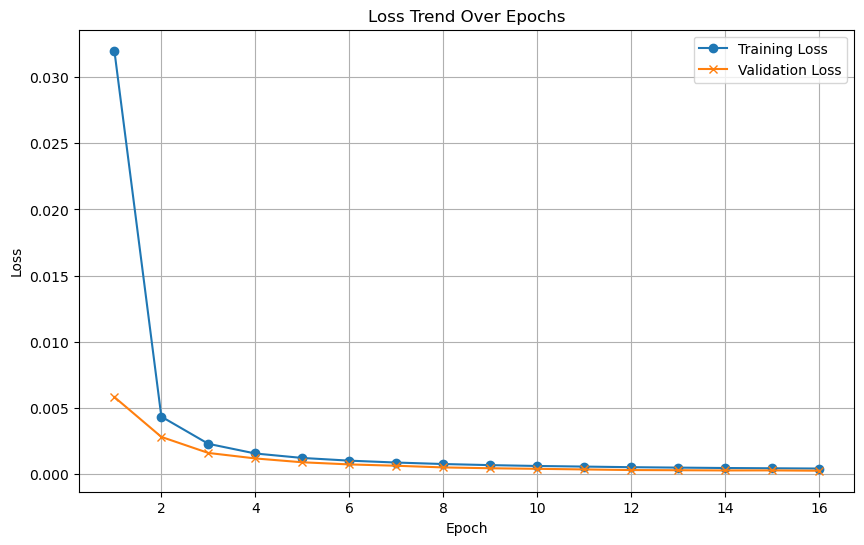

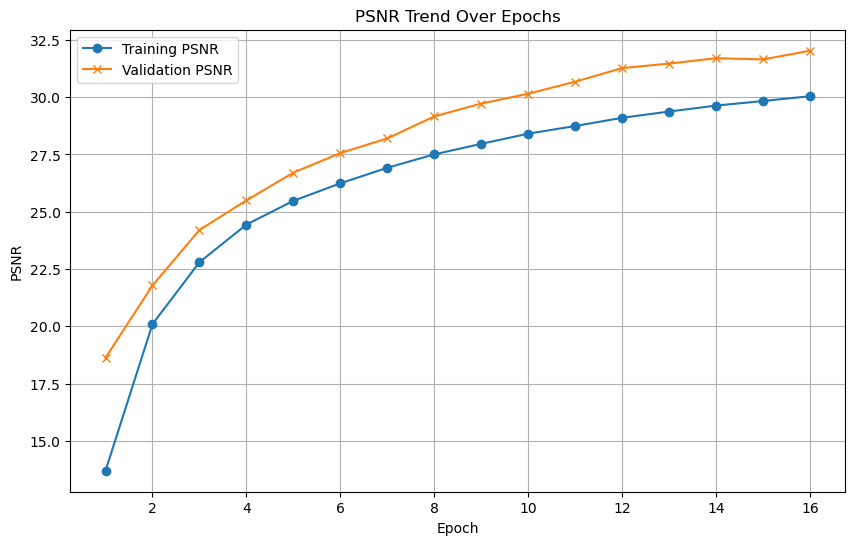

In [18]:
model_cae = ConvAutoEncode()
criterion_cae = nn.MSELoss()
optimizer_cae = optim.Adam(model_cae.parameters(), lr=0.0001)

#parameters for CAE
num_epochs_cae = 50
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_cae = model_cae.to(device)

#early stopping parameters
patience = 3  # number of epochs to wait for improvement
tolerance = 1e-4
best_val_loss = float('inf')
epochs_without_improvement = 0

#grad accumulation parameters
accumulation_steps = 8 

# for loss and metrics tracking
autoencoder_epoch_losses_cae = []
validation_epoch_losses_cae = []
train_psnr = []
val_psnr = []

psnr = PeakSignalNoiseRatio().to(device)

# mixed precision training
scaler = GradScaler()  # Gradient scaler for mixed precision

for epoch in range(num_epochs_cae):
    # training
    model_cae.train()
    running_loss = 0.0
    running_psnr = 0.0

    print(f"\nLOG: Epoch [{epoch + 1}/{num_epochs_cae}]")

    optimizer_cae.zero_grad()

    for batch_idx, data in enumerate(train_loader_cae):
        data = data.to(device).permute(0, 3, 1, 2)

        # mixed precision forward pass
        with autocast(device_type='cuda', dtype=torch.float16):
            _, decoded = model_cae(data)
            loss = criterion_cae(decoded, data) / accumulation_steps

            with torch.no_grad():
                nan_in_out = torch.isnan(decoded).any().item()
                inf_in_out = torch.isinf(decoded).any().item()

        #backward pass with gradient scaling
        scaler.scale(loss).backward()

        loss_value = loss.item() * accumulation_steps
        running_loss += loss_value

        psnr_value = psnr(decoded, data).item()
        running_psnr += psnr_value


        # performing optimizer step and reset gradients after `accumulation_steps` batches
        if (batch_idx + 1) % accumulation_steps == 0 or (batch_idx + 1) == len(train_loader_cae):
            scaler.step(optimizer_cae)
            scaler.update()
            optimizer_cae.zero_grad()

        if batch_idx == 0 or (batch_idx + 1) % 200 == 0:
            print(
    f"\t Training Batch [{batch_idx + 1}/{len(train_loader_cae)}], "
    f"Loss: {loss_value:.4f}, PSNR: {psnr_value:.4f}"
)


        #delete intermediate variables and clear GPU cache
        del data, decoded, loss
        torch.cuda.empty_cache()

    #compute average metrics for the epoch
    avg_train_loss = running_loss / len(train_loader_cae)
    avg_train_psnr = running_psnr / len(train_loader_cae)

    autoencoder_epoch_losses_cae.append(avg_train_loss)
    train_psnr.append(avg_train_psnr)

    print(f"Epoch [{epoch + 1}/{num_epochs_cae}] Training Loss: {avg_train_loss:.4f}, PSNR: {avg_train_psnr:.4f}")

    #clear GPU cache after training
    torch.cuda.empty_cache()

    #validation
    model_cae.eval()
    validation_loss = 0.0
    val_psnr_epoch = 0.0

    with torch.no_grad():
        for batch_idx, data in enumerate(val_loader_cae):
            data = data.to(device).permute(0, 3, 1, 2)

            # Mixed precision forward pass for validation
            with autocast(device_type='cuda', dtype=torch.float16):
                _, decoded = model_cae(data)
                loss = criterion_cae(decoded, data)

            validation_loss += loss.item()
            val_psnr_epoch += psnr(decoded, data).item()

            if batch_idx == 0 or (batch_idx + 1) % 10 == 0:
                loss_val = loss.item()
                psnr_val = psnr(decoded, data).item()
                print(
                    f"\t[Val]   Batch [{batch_idx + 1}/{len(val_loader_cae)}] "
                    f"Loss: {loss_val:.4f}, PSNR: {psnr_val:.4f}"
                )

            del data, decoded, loss
            torch.cuda.empty_cache()

    # average validation metrics for the epoch
    avg_val_loss = validation_loss / len(val_loader_cae)
    avg_val_psnr = val_psnr_epoch / len(val_loader_cae)

    validation_epoch_losses_cae.append(avg_val_loss)
    val_psnr.append(avg_val_psnr)

    print(f"Epoch [{epoch + 1}/{num_epochs_cae}] Validation Loss: {avg_val_loss:.4f}, PSNR: {avg_val_psnr:.4f}")

    # early stopping logic
    if avg_val_loss < best_val_loss - tolerance:
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0  # Reset counter
        #best model checkpoint
        #torch.save(model_cae.state_dict(), 'best_model_cae.pth')
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}. No improvement for {patience} epochs.")
        break

#plot for training and validation loss trends
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(autoencoder_epoch_losses_cae) + 1), autoencoder_epoch_losses_cae, marker='o', label="Training Loss")
plt.plot(range(1, len(validation_epoch_losses_cae) + 1), validation_epoch_losses_cae, marker='x', label="Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Trend Over Epochs')
plt.legend()
plt.grid()
plt.show()

#plot for PSNR trends
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_psnr) + 1), train_psnr, marker='o', label="Training PSNR")
plt.plot(range(1, len(val_psnr) + 1), val_psnr, marker='x', label="Validation PSNR")
plt.xlabel('Epoch')
plt.ylabel('PSNR')
plt.title('PSNR Trend Over Epochs')
plt.legend()
plt.grid()
plt.show()

## Using the encoder section of CAE as feature extractor to generate compact representations

In [19]:
#dir to save encoded representations
encoded_dir = 'encoded_representations'
os.makedirs(encoded_dir, exist_ok=True)

loaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}

model_cae.eval()

# Feature extraction
with torch.no_grad():
    for subset_name, loader in loaders.items():
        print(f"\nExtracting representations for the {subset_name} dataset...")

        # dir for the given subset's encoded features
        subset_encoded_dir = os.path.join(encoded_dir, subset_name)
        os.makedirs(subset_encoded_dir, exist_ok=True)

        for batch_idx, (data, labels) in enumerate(loader):
            data = data.to(device).permute(0, 3, 1, 2)

            # passing data through the encoder to obtain representations
            encoded_features, _ = model_cae(data)  # latent representation

            # moving to CPU and convert to NumPy
            encoded_features = encoded_features.cpu().numpy()  
            labels = labels.cpu().numpy() 

            #saving the encoded features and labels
            np.save(os.path.join(subset_encoded_dir, f'encoded_batch_{batch_idx}.npy'), encoded_features)
            np.save(os.path.join(subset_encoded_dir, f'labels_batch_{batch_idx}.npy'), labels)

            if batch_idx % 1 == 0 and subset_name != 'test':
                print(f"    Processed batch {batch_idx + 1}/{len(loader)} for {subset_name} dataset.")
            elif subset_name == 'test' and batch_idx % 100 == 0:  # Log less frequently for the test set
                print(f"    Processed batch {batch_idx + 1}/{len(loader)} for {subset_name} dataset.")

        print(f"Completed encoding for the {subset_name} dataset.")

print("Feature extraction completed for all subsets.")


Extracting representations for the train dataset...
    Processed batch 1/2 for train dataset.
    Processed batch 2/2 for train dataset.
Completed encoding for the train dataset.

Extracting representations for the val dataset...
    Processed batch 1/1 for val dataset.
Completed encoding for the val dataset.

Extracting representations for the test dataset...
    Processed batch 1/578 for test dataset.


    Processed batch 101/578 for test dataset.


    Processed batch 201/578 for test dataset.


    Processed batch 301/578 for test dataset.


    Processed batch 401/578 for test dataset.


    Processed batch 501/578 for test dataset.


Completed encoding for the test dataset.
Feature extraction completed for all subsets.


## End-To-End CNN

In [20]:
class hyperspectralCNN(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(hyperspectralCNN, self).__init__()

        self.cnn_layers = nn.Sequential(
            # Block 1
            nn.Conv2d(input_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 5x5 -> 2x2

            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            # Bottleneck
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2, 2)  # 2x2 -> 1x1
        )

        #fully connected layers for classification
        self.fc_layers = nn.Sequential(
            nn.Flatten(),  #3D to 1D vector for input to FC layers
            nn.Linear(16 * 2 * 2, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, num_classes)
        )

    def forward(self, x):
        x = self.cnn_layers(x)
        x = self.fc_layers(x)
        return x


LOG: Epoch [1/1000] - Training
Epoch [1/1000] completed, Average Training Loss: 2.1899
    Validation Batch [1/1], Loss: 2.2015
Validation Loss: 2.2015, Validation Accuracy: 11.11%
Validation loss improved from inf to 2.2015. Saving model...

LOG: Epoch [2/1000] - Training
Epoch [2/1000] completed, Average Training Loss: 2.1193
    Validation Batch [1/1], Loss: 2.2016
Validation Loss: 2.2016, Validation Accuracy: 11.11%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [3/1000] - Training
Epoch [3/1000] completed, Average Training Loss: 2.0748
    Validation Batch [1/1], Loss: 2.2015
Validation Loss: 2.2015, Validation Accuracy: 11.11%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [4/1000] - Training
Epoch [4/1000] completed, Average Training Loss: 2.0425
    Validation Batch [1/1], Loss: 2.2014
Validation Loss: 2.2014, Validation Accuracy: 11.11%
Validation loss improved from 2.2015 to 2.2014. Saving model...

LOG: Epoch [5/1000] - Training


Epoch [5/1000] completed, Average Training Loss: 2.0077
    Validation Batch [1/1], Loss: 2.2014
Validation Loss: 2.2014, Validation Accuracy: 11.11%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [6/1000] - Training
Epoch [6/1000] completed, Average Training Loss: 1.9885
    Validation Batch [1/1], Loss: 2.2014
Validation Loss: 2.2014, Validation Accuracy: 11.11%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [7/1000] - Training
Epoch [7/1000] completed, Average Training Loss: 1.9628
    Validation Batch [1/1], Loss: 2.2012
Validation Loss: 2.2012, Validation Accuracy: 11.11%
Validation loss improved from 2.2014 to 2.2012. Saving model...

LOG: Epoch [8/1000] - Training
Epoch [8/1000] completed, Average Training Loss: 1.9421
    Validation Batch [1/1], Loss: 2.2010
Validation Loss: 2.2010, Validation Accuracy: 11.11%
Validation loss improved from 2.2012 to 2.2010. Saving model...

LOG: Epoch [9/1000] - Training
Epoch [9/1000] completed, Average Training Los

    Validation Batch [1/1], Loss: 2.0118
Validation Loss: 2.0118, Validation Accuracy: 35.56%
Validation loss improved from 2.0526 to 2.0118. Saving model...

LOG: Epoch [22/1000] - Training
Epoch [22/1000] completed, Average Training Loss: 1.6511
    Validation Batch [1/1], Loss: 1.9675
Validation Loss: 1.9675, Validation Accuracy: 48.89%
Validation loss improved from 2.0118 to 1.9675. Saving model...

LOG: Epoch [23/1000] - Training
Epoch [23/1000] completed, Average Training Loss: 1.6272
    Validation Batch [1/1], Loss: 1.9173
Validation Loss: 1.9173, Validation Accuracy: 57.78%
Validation loss improved from 1.9675 to 1.9173. Saving model...

LOG: Epoch [24/1000] - Training
Epoch [24/1000] completed, Average Training Loss: 1.6058
    Validation Batch [1/1], Loss: 1.8680
Validation Loss: 1.8680, Validation Accuracy: 62.22%
Validation loss improved from 1.9173 to 1.8680. Saving model...

LOG: Epoch [25/1000] - Training
Epoch [25/1000] completed, Average Training Loss: 1.5934
    Vali

Epoch [38/1000] completed, Average Training Loss: 1.3614
    Validation Batch [1/1], Loss: 1.3463
Validation Loss: 1.3463, Validation Accuracy: 82.22%
Validation loss improved from 1.3742 to 1.3463. Saving model...

LOG: Epoch [39/1000] - Training
Epoch [39/1000] completed, Average Training Loss: 1.3452
    Validation Batch [1/1], Loss: 1.3243
Validation Loss: 1.3243, Validation Accuracy: 86.67%
Validation loss improved from 1.3463 to 1.3243. Saving model...

LOG: Epoch [40/1000] - Training
Epoch [40/1000] completed, Average Training Loss: 1.3438
    Validation Batch [1/1], Loss: 1.3163
Validation Loss: 1.3163, Validation Accuracy: 93.33%
Validation loss improved from 1.3243 to 1.3163. Saving model...

LOG: Epoch [41/1000] - Training
Epoch [41/1000] completed, Average Training Loss: 1.3382
    Validation Batch [1/1], Loss: 1.2868
Validation Loss: 1.2868, Validation Accuracy: 97.78%
Validation loss improved from 1.3163 to 1.2868. Saving model...

LOG: Epoch [42/1000] - Training
Epoch [4

    Validation Batch [1/1], Loss: 1.0302
Validation Loss: 1.0302, Validation Accuracy: 100.00%
Validation loss improved from 1.0466 to 1.0302. Saving model...

LOG: Epoch [56/1000] - Training
Epoch [56/1000] completed, Average Training Loss: 1.0819
    Validation Batch [1/1], Loss: 1.0247
Validation Loss: 1.0247, Validation Accuracy: 100.00%
Validation loss improved from 1.0302 to 1.0247. Saving model...

LOG: Epoch [57/1000] - Training
Epoch [57/1000] completed, Average Training Loss: 1.0547
    Validation Batch [1/1], Loss: 1.0137
Validation Loss: 1.0137, Validation Accuracy: 97.78%
Validation loss improved from 1.0247 to 1.0137. Saving model...

LOG: Epoch [58/1000] - Training
Epoch [58/1000] completed, Average Training Loss: 1.0498
    Validation Batch [1/1], Loss: 0.9913
Validation Loss: 0.9913, Validation Accuracy: 100.00%
Validation loss improved from 1.0137 to 0.9913. Saving model...

LOG: Epoch [59/1000] - Training
Epoch [59/1000] completed, Average Training Loss: 1.0266
    V

Epoch [73/1000] completed, Average Training Loss: 0.8315
    Validation Batch [1/1], Loss: 0.7584
Validation Loss: 0.7584, Validation Accuracy: 100.00%
Validation loss improved from 0.7707 to 0.7584. Saving model...

LOG: Epoch [74/1000] - Training
Epoch [74/1000] completed, Average Training Loss: 0.8084
    Validation Batch [1/1], Loss: 0.7421
Validation Loss: 0.7421, Validation Accuracy: 100.00%
Validation loss improved from 0.7584 to 0.7421. Saving model...

LOG: Epoch [75/1000] - Training
Epoch [75/1000] completed, Average Training Loss: 0.8021
    Validation Batch [1/1], Loss: 0.7243
Validation Loss: 0.7243, Validation Accuracy: 100.00%
Validation loss improved from 0.7421 to 0.7243. Saving model...

LOG: Epoch [76/1000] - Training
Epoch [76/1000] completed, Average Training Loss: 0.7922
    Validation Batch [1/1], Loss: 0.7277
Validation Loss: 0.7277, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [77/1000] - Training
Epoch [77/1000] comp

Epoch [91/1000] completed, Average Training Loss: 0.5972
    Validation Batch [1/1], Loss: 0.5156
Validation Loss: 0.5156, Validation Accuracy: 100.00%
Validation loss improved from 0.5278 to 0.5156. Saving model...

LOG: Epoch [92/1000] - Training
Epoch [92/1000] completed, Average Training Loss: 0.5595
    Validation Batch [1/1], Loss: 0.5144
Validation Loss: 0.5144, Validation Accuracy: 95.56%
Validation loss improved from 0.5156 to 0.5144. Saving model...

LOG: Epoch [93/1000] - Training
Epoch [93/1000] completed, Average Training Loss: 0.5586
    Validation Batch [1/1], Loss: 0.4850
Validation Loss: 0.4850, Validation Accuracy: 100.00%
Validation loss improved from 0.5144 to 0.4850. Saving model...

LOG: Epoch [94/1000] - Training
Epoch [94/1000] completed, Average Training Loss: 0.5802
    Validation Batch [1/1], Loss: 0.4721
Validation Loss: 0.4721, Validation Accuracy: 100.00%
Validation loss improved from 0.4850 to 0.4721. Saving model...

LOG: Epoch [95/1000] - Training
Epoch

    Validation Batch [1/1], Loss: 0.3414
Validation Loss: 0.3414, Validation Accuracy: 100.00%
Validation loss improved from 0.3417 to 0.3414. Saving model...

LOG: Epoch [109/1000] - Training
Epoch [109/1000] completed, Average Training Loss: 0.4015
    Validation Batch [1/1], Loss: 0.3398
Validation Loss: 0.3398, Validation Accuracy: 97.78%
Validation loss improved from 0.3414 to 0.3398. Saving model...

LOG: Epoch [110/1000] - Training
Epoch [110/1000] completed, Average Training Loss: 0.3918
    Validation Batch [1/1], Loss: 0.3134
Validation Loss: 0.3134, Validation Accuracy: 100.00%
Validation loss improved from 0.3398 to 0.3134. Saving model...

LOG: Epoch [111/1000] - Training
Epoch [111/1000] completed, Average Training Loss: 0.3871
    Validation Batch [1/1], Loss: 0.3356
Validation Loss: 0.3356, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [112/1000] - Training
Epoch [112/1000] completed, Average Training Loss: 0.4005
    Validatio

Epoch [126/1000] completed, Average Training Loss: 0.2929
    Validation Batch [1/1], Loss: 0.2338
Validation Loss: 0.2338, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [127/1000] - Training
Epoch [127/1000] completed, Average Training Loss: 0.2586
    Validation Batch [1/1], Loss: 0.2585
Validation Loss: 0.2585, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [128/1000] - Training
Epoch [128/1000] completed, Average Training Loss: 0.2724
    Validation Batch [1/1], Loss: 0.2326
Validation Loss: 0.2326, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [129/1000] - Training
Epoch [129/1000] completed, Average Training Loss: 0.2690
    Validation Batch [1/1], Loss: 0.2126
Validation Loss: 0.2126, Validation Accuracy: 100.00%
Validation loss improved from 0.2314 to 0.2126. Saving model...

LOG: Epoch [130/1000] - Training
Epoch [130/1000] completed, Average Trainin

Epoch [143/1000] completed, Average Training Loss: 0.1876
    Validation Batch [1/1], Loss: 0.1450
Validation Loss: 0.1450, Validation Accuracy: 100.00%
Validation loss improved from 0.1568 to 0.1450. Saving model...

LOG: Epoch [144/1000] - Training
Epoch [144/1000] completed, Average Training Loss: 0.1991
    Validation Batch [1/1], Loss: 0.2068
Validation Loss: 0.2068, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [145/1000] - Training
Epoch [145/1000] completed, Average Training Loss: 0.1972
    Validation Batch [1/1], Loss: 0.1564
Validation Loss: 0.1564, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [146/1000] - Training
Epoch [146/1000] completed, Average Training Loss: 0.1856
    Validation Batch [1/1], Loss: 0.1409
Validation Loss: 0.1409, Validation Accuracy: 100.00%
Validation loss improved from 0.1450 to 0.1409. Saving model...

LOG: Epoch [147/1000] - Training
Epoch [147/1000] completed,

Epoch [160/1000] completed, Average Training Loss: 0.1325
    Validation Batch [1/1], Loss: 0.1121
Validation Loss: 0.1121, Validation Accuracy: 100.00%
Validation loss improved from 0.1172 to 0.1121. Saving model...

LOG: Epoch [161/1000] - Training
Epoch [161/1000] completed, Average Training Loss: 0.1479
    Validation Batch [1/1], Loss: 0.1375
Validation Loss: 0.1375, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [162/1000] - Training
Epoch [162/1000] completed, Average Training Loss: 0.1371
    Validation Batch [1/1], Loss: 0.1056
Validation Loss: 0.1056, Validation Accuracy: 100.00%
Validation loss improved from 0.1121 to 0.1056. Saving model...

LOG: Epoch [163/1000] - Training
Epoch [163/1000] completed, Average Training Loss: 0.1432
    Validation Batch [1/1], Loss: 0.1171
Validation Loss: 0.1171, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [164/1000] - Training
Epoch [164/1000] completed, 

    Validation Batch [1/1], Loss: 0.0890
Validation Loss: 0.0890, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [178/1000] - Training
Epoch [178/1000] completed, Average Training Loss: 0.1162
    Validation Batch [1/1], Loss: 0.0862
Validation Loss: 0.0862, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [179/1000] - Training
Epoch [179/1000] completed, Average Training Loss: 0.1202
    Validation Batch [1/1], Loss: 0.0881
Validation Loss: 0.0881, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [180/1000] - Training
Epoch [180/1000] completed, Average Training Loss: 0.1095
    Validation Batch [1/1], Loss: 0.0793
Validation Loss: 0.0793, Validation Accuracy: 100.00%
Validation loss improved from 0.0841 to 0.0793. Saving model...

LOG: Epoch [181/1000] - Training
Epoch [181/1000] completed, Average Training Loss: 0.1078
    Validation Batch [1/1], Loss: 0.0752


Epoch [196/1000] completed, Average Training Loss: 0.0903
    Validation Batch [1/1], Loss: 0.0627
Validation Loss: 0.0627, Validation Accuracy: 100.00%
Validation loss improved from 0.0682 to 0.0627. Saving model...

LOG: Epoch [197/1000] - Training
Epoch [197/1000] completed, Average Training Loss: 0.0873
    Validation Batch [1/1], Loss: 0.0638
Validation Loss: 0.0638, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [198/1000] - Training
Epoch [198/1000] completed, Average Training Loss: 0.0714
    Validation Batch [1/1], Loss: 0.0701
Validation Loss: 0.0701, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [199/1000] - Training
Epoch [199/1000] completed, Average Training Loss: 0.0826
    Validation Batch [1/1], Loss: 0.0802
Validation Loss: 0.0802, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [200/1000] - Training
Epoch [200/1000] completed, Average Train

    Validation Batch [1/1], Loss: 0.0579
Validation Loss: 0.0579, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [214/1000] - Training
Epoch [214/1000] completed, Average Training Loss: 0.0734
    Validation Batch [1/1], Loss: 0.0519
Validation Loss: 0.0519, Validation Accuracy: 100.00%
Validation loss improved from 0.0536 to 0.0519. Saving model...

LOG: Epoch [215/1000] - Training
Epoch [215/1000] completed, Average Training Loss: 0.0605
    Validation Batch [1/1], Loss: 0.0537
Validation Loss: 0.0537, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [216/1000] - Training
Epoch [216/1000] completed, Average Training Loss: 0.0647
    Validation Batch [1/1], Loss: 0.0546
Validation Loss: 0.0546, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [217/1000] - Training
Epoch [217/1000] completed, Average Training Loss: 0.0646
    Validation Batch [1/1], Loss: 0.0507


Epoch [231/1000] completed, Average Training Loss: 0.0550
    Validation Batch [1/1], Loss: 0.0574
Validation Loss: 0.0574, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [232/1000] - Training
Epoch [232/1000] completed, Average Training Loss: 0.0497
    Validation Batch [1/1], Loss: 0.0726
Validation Loss: 0.0726, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [233/1000] - Training
Epoch [233/1000] completed, Average Training Loss: 0.0469
    Validation Batch [1/1], Loss: 0.0451
Validation Loss: 0.0451, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [234/1000] - Training
Epoch [234/1000] completed, Average Training Loss: 0.0583
    Validation Batch [1/1], Loss: 0.0375
Validation Loss: 0.0375, Validation Accuracy: 100.00%
Validation loss improved from 0.0426 to 0.0375. Saving model...

LOG: Epoch [235/1000] - Training
Epoch [235/1000] completed, Average Trainin

Epoch [249/1000] completed, Average Training Loss: 0.0504
    Validation Batch [1/1], Loss: 0.0526
Validation Loss: 0.0526, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 15/100

LOG: Epoch [250/1000] - Training
Epoch [250/1000] completed, Average Training Loss: 0.0474
    Validation Batch [1/1], Loss: 0.0550
Validation Loss: 0.0550, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 16/100

LOG: Epoch [251/1000] - Training
Epoch [251/1000] completed, Average Training Loss: 0.0491
    Validation Batch [1/1], Loss: 0.0346
Validation Loss: 0.0346, Validation Accuracy: 100.00%
Validation loss improved from 0.0375 to 0.0346. Saving model...

LOG: Epoch [252/1000] - Training
Epoch [252/1000] completed, Average Training Loss: 0.0418
    Validation Batch [1/1], Loss: 0.0383
Validation Loss: 0.0383, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [253/1000] - Training
Epoch [253/1000] completed, Average Train

Epoch [266/1000] completed, Average Training Loss: 0.0396
    Validation Batch [1/1], Loss: 0.0297
Validation Loss: 0.0297, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [267/1000] - Training
Epoch [267/1000] completed, Average Training Loss: 0.0377
    Validation Batch [1/1], Loss: 0.0306
Validation Loss: 0.0306, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [268/1000] - Training
Epoch [268/1000] completed, Average Training Loss: 0.0386
    Validation Batch [1/1], Loss: 0.0313
Validation Loss: 0.0313, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [269/1000] - Training
Epoch [269/1000] completed, Average Training Loss: 0.0349
    Validation Batch [1/1], Loss: 0.0385
Validation Loss: 0.0385, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [270/1000] - Training
Epoch [270/1000] completed, Average Training Loss: 0.044

Epoch [283/1000] completed, Average Training Loss: 0.0382
    Validation Batch [1/1], Loss: 0.0323
Validation Loss: 0.0323, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [284/1000] - Training
Epoch [284/1000] completed, Average Training Loss: 0.0313
    Validation Batch [1/1], Loss: 0.0284
Validation Loss: 0.0284, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [285/1000] - Training
Epoch [285/1000] completed, Average Training Loss: 0.0368
    Validation Batch [1/1], Loss: 0.0350
Validation Loss: 0.0350, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [286/1000] - Training
Epoch [286/1000] completed, Average Training Loss: 0.0314
    Validation Batch [1/1], Loss: 0.0378
Validation Loss: 0.0378, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [287/1000] - Training
Epoch [287/1000] completed, Average Training Loss: 0.030

Epoch [299/1000] completed, Average Training Loss: 0.0295
    Validation Batch [1/1], Loss: 0.0304
Validation Loss: 0.0304, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [300/1000] - Training
Epoch [300/1000] completed, Average Training Loss: 0.0307
    Validation Batch [1/1], Loss: 0.0279
Validation Loss: 0.0279, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [301/1000] - Training
Epoch [301/1000] completed, Average Training Loss: 0.0302
    Validation Batch [1/1], Loss: 0.0258
Validation Loss: 0.0258, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [302/1000] - Training
Epoch [302/1000] completed, Average Training Loss: 0.0267
    Validation Batch [1/1], Loss: 0.0250
Validation Loss: 0.0250, Validation Accuracy: 100.00%
Validation loss improved from 0.0254 to 0.0250. Saving model...

LOG: Epoch [303/1000] - Training
Epoch [303/1000] completed, Average Train

Epoch [316/1000] completed, Average Training Loss: 0.0307
    Validation Batch [1/1], Loss: 0.0291
Validation Loss: 0.0291, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [317/1000] - Training
Epoch [317/1000] completed, Average Training Loss: 0.0262
    Validation Batch [1/1], Loss: 0.0306
Validation Loss: 0.0306, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [318/1000] - Training
Epoch [318/1000] completed, Average Training Loss: 0.0254
    Validation Batch [1/1], Loss: 0.0287
Validation Loss: 0.0287, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 9/100

LOG: Epoch [319/1000] - Training
Epoch [319/1000] completed, Average Training Loss: 0.0263
    Validation Batch [1/1], Loss: 0.0210
Validation Loss: 0.0210, Validation Accuracy: 100.00%
Validation loss improved from 0.0217 to 0.0210. Saving model...

LOG: Epoch [320/1000] - Training
Epoch [320/1000] completed, Average Train

Epoch [332/1000] completed, Average Training Loss: 0.0210
    Validation Batch [1/1], Loss: 0.0281
Validation Loss: 0.0281, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 9/100

LOG: Epoch [333/1000] - Training
Epoch [333/1000] completed, Average Training Loss: 0.0261
    Validation Batch [1/1], Loss: 0.0312
Validation Loss: 0.0312, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 10/100

LOG: Epoch [334/1000] - Training
Epoch [334/1000] completed, Average Training Loss: 0.0230
    Validation Batch [1/1], Loss: 0.0303
Validation Loss: 0.0303, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 11/100

LOG: Epoch [335/1000] - Training
Epoch [335/1000] completed, Average Training Loss: 0.0248
    Validation Batch [1/1], Loss: 0.0280
Validation Loss: 0.0280, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 12/100

LOG: Epoch [336/1000] - Training
Epoch [336/1000] completed, Average Training Loss: 0.

Epoch [350/1000] completed, Average Training Loss: 0.0214
    Validation Batch [1/1], Loss: 0.0200
Validation Loss: 0.0200, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [351/1000] - Training
Epoch [351/1000] completed, Average Training Loss: 0.0203
    Validation Batch [1/1], Loss: 0.0227
Validation Loss: 0.0227, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [352/1000] - Training
Epoch [352/1000] completed, Average Training Loss: 0.0191
    Validation Batch [1/1], Loss: 0.0265
Validation Loss: 0.0265, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [353/1000] - Training
Epoch [353/1000] completed, Average Training Loss: 0.0222
    Validation Batch [1/1], Loss: 0.0246
Validation Loss: 0.0246, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [354/1000] - Training
Epoch [354/1000] completed, Average Training Loss: 0.018

Epoch [367/1000] completed, Average Training Loss: 0.0179
    Validation Batch [1/1], Loss: 0.0201
Validation Loss: 0.0201, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 18/100

LOG: Epoch [368/1000] - Training
Epoch [368/1000] completed, Average Training Loss: 0.0203
    Validation Batch [1/1], Loss: 0.0256
Validation Loss: 0.0256, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 19/100

LOG: Epoch [369/1000] - Training
Epoch [369/1000] completed, Average Training Loss: 0.0191
    Validation Batch [1/1], Loss: 0.0289
Validation Loss: 0.0289, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 20/100

LOG: Epoch [370/1000] - Training
Epoch [370/1000] completed, Average Training Loss: 0.0225
    Validation Batch [1/1], Loss: 0.0243
Validation Loss: 0.0243, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 21/100

LOG: Epoch [371/1000] - Training
Epoch [371/1000] completed, Average Training Loss: 0

Epoch [383/1000] completed, Average Training Loss: 0.0182
    Validation Batch [1/1], Loss: 0.0145
Validation Loss: 0.0145, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [384/1000] - Training
Epoch [384/1000] completed, Average Training Loss: 0.0162
    Validation Batch [1/1], Loss: 0.0153
Validation Loss: 0.0153, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [385/1000] - Training
Epoch [385/1000] completed, Average Training Loss: 0.0178
    Validation Batch [1/1], Loss: 0.0156
Validation Loss: 0.0156, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [386/1000] - Training
Epoch [386/1000] completed, Average Training Loss: 0.0187
    Validation Batch [1/1], Loss: 0.0168
Validation Loss: 0.0168, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [387/1000] - Training
Epoch [387/1000] completed, Average Training Loss: 0.014

    Validation Batch [1/1], Loss: 0.0185
Validation Loss: 0.0185, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [400/1000] - Training
Epoch [400/1000] completed, Average Training Loss: 0.0143
    Validation Batch [1/1], Loss: 0.0298
Validation Loss: 0.0298, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [401/1000] - Training
Epoch [401/1000] completed, Average Training Loss: 0.0159
    Validation Batch [1/1], Loss: 0.0672
Validation Loss: 0.0672, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [402/1000] - Training
Epoch [402/1000] completed, Average Training Loss: 0.0162
    Validation Batch [1/1], Loss: 0.0204
Validation Loss: 0.0204, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [403/1000] - Training
Epoch [403/1000] completed, Average Training Loss: 0.0141
    Validation Batch [1/1], Loss: 0.0262
Validation Loss:

Epoch [417/1000] completed, Average Training Loss: 0.0154
    Validation Batch [1/1], Loss: 0.0344
Validation Loss: 0.0344, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 22/100

LOG: Epoch [418/1000] - Training
Epoch [418/1000] completed, Average Training Loss: 0.0163
    Validation Batch [1/1], Loss: 0.0153
Validation Loss: 0.0153, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 23/100

LOG: Epoch [419/1000] - Training
Epoch [419/1000] completed, Average Training Loss: 0.0157
    Validation Batch [1/1], Loss: 0.0165
Validation Loss: 0.0165, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 24/100

LOG: Epoch [420/1000] - Training
Epoch [420/1000] completed, Average Training Loss: 0.0178
    Validation Batch [1/1], Loss: 0.0197
Validation Loss: 0.0197, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 25/100

LOG: Epoch [421/1000] - Training
Epoch [421/1000] completed, Average Training Loss: 0

    Validation Batch [1/1], Loss: 0.0197
Validation Loss: 0.0197, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 39/100

LOG: Epoch [435/1000] - Training
Epoch [435/1000] completed, Average Training Loss: 0.0130
    Validation Batch [1/1], Loss: 0.0177
Validation Loss: 0.0177, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 40/100

LOG: Epoch [436/1000] - Training
Epoch [436/1000] completed, Average Training Loss: 0.0150
    Validation Batch [1/1], Loss: 0.0205
Validation Loss: 0.0205, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 41/100

LOG: Epoch [437/1000] - Training
Epoch [437/1000] completed, Average Training Loss: 0.0106
    Validation Batch [1/1], Loss: 0.0244
Validation Loss: 0.0244, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 42/100

LOG: Epoch [438/1000] - Training
Epoch [438/1000] completed, Average Training Loss: 0.0140
    Validation Batch [1/1], Loss: 0.0203
Validation 

Epoch [452/1000] completed, Average Training Loss: 0.0106
    Validation Batch [1/1], Loss: 0.0122
Validation Loss: 0.0122, Validation Accuracy: 100.00%
Validation loss improved from 0.0125 to 0.0122. Saving model...

LOG: Epoch [453/1000] - Training
Epoch [453/1000] completed, Average Training Loss: 0.0104
    Validation Batch [1/1], Loss: 0.0114
Validation Loss: 0.0114, Validation Accuracy: 100.00%
Validation loss improved from 0.0122 to 0.0114. Saving model...

LOG: Epoch [454/1000] - Training
Epoch [454/1000] completed, Average Training Loss: 0.0105
    Validation Batch [1/1], Loss: 0.0109
Validation Loss: 0.0109, Validation Accuracy: 100.00%
Validation loss improved from 0.0114 to 0.0109. Saving model...

LOG: Epoch [455/1000] - Training
Epoch [455/1000] completed, Average Training Loss: 0.0112
    Validation Batch [1/1], Loss: 0.0112
Validation Loss: 0.0112, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [456/1000] - Training
Epoch [456/

Epoch [469/1000] completed, Average Training Loss: 0.0124
    Validation Batch [1/1], Loss: 0.0103
Validation Loss: 0.0103, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 13/100

LOG: Epoch [470/1000] - Training
Epoch [470/1000] completed, Average Training Loss: 0.0098
    Validation Batch [1/1], Loss: 0.0097
Validation Loss: 0.0097, Validation Accuracy: 100.00%
Validation loss improved from 0.0101 to 0.0097. Saving model...

LOG: Epoch [471/1000] - Training
Epoch [471/1000] completed, Average Training Loss: 0.0123
    Validation Batch [1/1], Loss: 0.0099
Validation Loss: 0.0099, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [472/1000] - Training
Epoch [472/1000] completed, Average Training Loss: 0.0099
    Validation Batch [1/1], Loss: 0.0109
Validation Loss: 0.0109, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [473/1000] - Training
Epoch [473/1000] completed, Average Trai

Epoch [486/1000] completed, Average Training Loss: 0.0098
    Validation Batch [1/1], Loss: 0.0108
Validation Loss: 0.0108, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 16/100

LOG: Epoch [487/1000] - Training
Epoch [487/1000] completed, Average Training Loss: 0.0098
    Validation Batch [1/1], Loss: 0.0107
Validation Loss: 0.0107, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 17/100

LOG: Epoch [488/1000] - Training
Epoch [488/1000] completed, Average Training Loss: 0.0108
    Validation Batch [1/1], Loss: 0.0115
Validation Loss: 0.0115, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 18/100

LOG: Epoch [489/1000] - Training
Epoch [489/1000] completed, Average Training Loss: 0.0099
    Validation Batch [1/1], Loss: 0.0191
Validation Loss: 0.0191, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 19/100

LOG: Epoch [490/1000] - Training
Epoch [490/1000] completed, Average Training Loss: 0

Epoch [503/1000] completed, Average Training Loss: 0.0077
    Validation Batch [1/1], Loss: 0.0098
Validation Loss: 0.0098, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 33/100

LOG: Epoch [504/1000] - Training
Epoch [504/1000] completed, Average Training Loss: 0.0107
    Validation Batch [1/1], Loss: 0.0103
Validation Loss: 0.0103, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 34/100

LOG: Epoch [505/1000] - Training
Epoch [505/1000] completed, Average Training Loss: 0.0088
    Validation Batch [1/1], Loss: 0.0100
Validation Loss: 0.0100, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 35/100

LOG: Epoch [506/1000] - Training
Epoch [506/1000] completed, Average Training Loss: 0.0128
    Validation Batch [1/1], Loss: 0.0090
Validation Loss: 0.0090, Validation Accuracy: 100.00%
Validation loss improved from 0.0097 to 0.0090. Saving model...

LOG: Epoch [507/1000] - Training
Epoch [507/1000] completed, Average Tr

Epoch [520/1000] completed, Average Training Loss: 0.0064
    Validation Batch [1/1], Loss: 0.0117
Validation Loss: 0.0117, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 14/100

LOG: Epoch [521/1000] - Training
Epoch [521/1000] completed, Average Training Loss: 0.0065
    Validation Batch [1/1], Loss: 0.0120
Validation Loss: 0.0120, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 15/100

LOG: Epoch [522/1000] - Training
Epoch [522/1000] completed, Average Training Loss: 0.0090
    Validation Batch [1/1], Loss: 0.0119
Validation Loss: 0.0119, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 16/100

LOG: Epoch [523/1000] - Training
Epoch [523/1000] completed, Average Training Loss: 0.0096
    Validation Batch [1/1], Loss: 0.0123
Validation Loss: 0.0123, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 17/100

LOG: Epoch [524/1000] - Training
Epoch [524/1000] completed, Average Training Loss: 0

Epoch [538/1000] completed, Average Training Loss: 0.0080
    Validation Batch [1/1], Loss: 0.0176
Validation Loss: 0.0176, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [539/1000] - Training
Epoch [539/1000] completed, Average Training Loss: 0.0071
    Validation Batch [1/1], Loss: 0.0180
Validation Loss: 0.0180, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [540/1000] - Training
Epoch [540/1000] completed, Average Training Loss: 0.0082
    Validation Batch [1/1], Loss: 0.0150
Validation Loss: 0.0150, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [541/1000] - Training
Epoch [541/1000] completed, Average Training Loss: 0.0089
    Validation Batch [1/1], Loss: 0.0132
Validation Loss: 0.0132, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [542/1000] - Training
Epoch [542/1000] completed, Average Training Loss: 0.008

Epoch [556/1000] completed, Average Training Loss: 0.0101
    Validation Batch [1/1], Loss: 0.0172
Validation Loss: 0.0172, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 23/100

LOG: Epoch [557/1000] - Training
Epoch [557/1000] completed, Average Training Loss: 0.0075
    Validation Batch [1/1], Loss: 0.0128
Validation Loss: 0.0128, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 24/100

LOG: Epoch [558/1000] - Training
Epoch [558/1000] completed, Average Training Loss: 0.0079
    Validation Batch [1/1], Loss: 0.0234
Validation Loss: 0.0234, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 25/100

LOG: Epoch [559/1000] - Training
Epoch [559/1000] completed, Average Training Loss: 0.0078
    Validation Batch [1/1], Loss: 0.0281
Validation Loss: 0.0281, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 26/100

LOG: Epoch [560/1000] - Training
Epoch [560/1000] completed, Average Training Loss: 0

Epoch [573/1000] completed, Average Training Loss: 0.0058
    Validation Batch [1/1], Loss: 0.0095
Validation Loss: 0.0095, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [574/1000] - Training
Epoch [574/1000] completed, Average Training Loss: 0.0072
    Validation Batch [1/1], Loss: 0.0093
Validation Loss: 0.0093, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [575/1000] - Training
Epoch [575/1000] completed, Average Training Loss: 0.0056
    Validation Batch [1/1], Loss: 0.0103
Validation Loss: 0.0103, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [576/1000] - Training
Epoch [576/1000] completed, Average Training Loss: 0.0069
    Validation Batch [1/1], Loss: 0.0111
Validation Loss: 0.0111, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 9/100

LOG: Epoch [577/1000] - Training
Epoch [577/1000] completed, Average Training Loss: 0.006

Epoch [590/1000] completed, Average Training Loss: 0.0090
    Validation Batch [1/1], Loss: 0.0097
Validation Loss: 0.0097, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 23/100

LOG: Epoch [591/1000] - Training
Epoch [591/1000] completed, Average Training Loss: 0.0074
    Validation Batch [1/1], Loss: 0.0089
Validation Loss: 0.0089, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 24/100

LOG: Epoch [592/1000] - Training
Epoch [592/1000] completed, Average Training Loss: 0.0062
    Validation Batch [1/1], Loss: 0.0082
Validation Loss: 0.0082, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 25/100

LOG: Epoch [593/1000] - Training
Epoch [593/1000] completed, Average Training Loss: 0.0087
    Validation Batch [1/1], Loss: 0.0079
Validation Loss: 0.0079, Validation Accuracy: 100.00%
Validation loss improved from 0.0082 to 0.0079. Saving model...

LOG: Epoch [594/1000] - Training
Epoch [594/1000] completed, Average Tr

    Validation Batch [1/1], Loss: 0.0081
Validation Loss: 0.0081, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [608/1000] - Training
Epoch [608/1000] completed, Average Training Loss: 0.0052
    Validation Batch [1/1], Loss: 0.0081
Validation Loss: 0.0081, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [609/1000] - Training
Epoch [609/1000] completed, Average Training Loss: 0.0051
    Validation Batch [1/1], Loss: 0.0086
Validation Loss: 0.0086, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [610/1000] - Training
Epoch [610/1000] completed, Average Training Loss: 0.0058
    Validation Batch [1/1], Loss: 0.0090
Validation Loss: 0.0090, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [611/1000] - Training
Epoch [611/1000] completed, Average Training Loss: 0.0073
    Validation Batch [1/1], Loss: 0.0081
Validation Loss

Epoch [623/1000] completed, Average Training Loss: 0.0058
    Validation Batch [1/1], Loss: 0.0123
Validation Loss: 0.0123, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 20/100

LOG: Epoch [624/1000] - Training
Epoch [624/1000] completed, Average Training Loss: 0.0056
    Validation Batch [1/1], Loss: 0.0100
Validation Loss: 0.0100, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 21/100

LOG: Epoch [625/1000] - Training
Epoch [625/1000] completed, Average Training Loss: 0.0057
    Validation Batch [1/1], Loss: 0.0082
Validation Loss: 0.0082, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 22/100

LOG: Epoch [626/1000] - Training
Epoch [626/1000] completed, Average Training Loss: 0.0063
    Validation Batch [1/1], Loss: 0.0077
Validation Loss: 0.0077, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 23/100

LOG: Epoch [627/1000] - Training
Epoch [627/1000] completed, Average Training Loss: 0

    Validation Batch [1/1], Loss: 0.0078
Validation Loss: 0.0078, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 37/100

LOG: Epoch [641/1000] - Training
Epoch [641/1000] completed, Average Training Loss: 0.0048
    Validation Batch [1/1], Loss: 0.0077
Validation Loss: 0.0077, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 38/100

LOG: Epoch [642/1000] - Training
Epoch [642/1000] completed, Average Training Loss: 0.0078
    Validation Batch [1/1], Loss: 0.0079
Validation Loss: 0.0079, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 39/100

LOG: Epoch [643/1000] - Training
Epoch [643/1000] completed, Average Training Loss: 0.0047
    Validation Batch [1/1], Loss: 0.0081
Validation Loss: 0.0081, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 40/100

LOG: Epoch [644/1000] - Training
Epoch [644/1000] completed, Average Training Loss: 0.0072
    Validation Batch [1/1], Loss: 0.0092
Validation 

Epoch [658/1000] completed, Average Training Loss: 0.0051
    Validation Batch [1/1], Loss: 0.0155
Validation Loss: 0.0155, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [659/1000] - Training
Epoch [659/1000] completed, Average Training Loss: 0.0048
    Validation Batch [1/1], Loss: 0.0107
Validation Loss: 0.0107, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [660/1000] - Training
Epoch [660/1000] completed, Average Training Loss: 0.0048
    Validation Batch [1/1], Loss: 0.0088
Validation Loss: 0.0088, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [661/1000] - Training
Epoch [661/1000] completed, Average Training Loss: 0.0060
    Validation Batch [1/1], Loss: 0.0202
Validation Loss: 0.0202, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 9/100

LOG: Epoch [662/1000] - Training
Epoch [662/1000] completed, Average Training Loss: 0.006

Epoch [676/1000] completed, Average Training Loss: 0.0071
    Validation Batch [1/1], Loss: 0.0162
Validation Loss: 0.0162, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 24/100

LOG: Epoch [677/1000] - Training
Epoch [677/1000] completed, Average Training Loss: 0.0052
    Validation Batch [1/1], Loss: 0.0371
Validation Loss: 0.0371, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 25/100

LOG: Epoch [678/1000] - Training
Epoch [678/1000] completed, Average Training Loss: 0.0048
    Validation Batch [1/1], Loss: 0.0448
Validation Loss: 0.0448, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 26/100

LOG: Epoch [679/1000] - Training
Epoch [679/1000] completed, Average Training Loss: 0.0062
    Validation Batch [1/1], Loss: 0.0218
Validation Loss: 0.0218, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 27/100

LOG: Epoch [680/1000] - Training
Epoch [680/1000] completed, Average Training Loss: 0.0

Epoch [693/1000] completed, Average Training Loss: 0.0052
    Validation Batch [1/1], Loss: 0.0093
Validation Loss: 0.0093, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 41/100

LOG: Epoch [694/1000] - Training
Epoch [694/1000] completed, Average Training Loss: 0.0036
    Validation Batch [1/1], Loss: 0.0105
Validation Loss: 0.0105, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 42/100

LOG: Epoch [695/1000] - Training
Epoch [695/1000] completed, Average Training Loss: 0.0044
    Validation Batch [1/1], Loss: 0.0153
Validation Loss: 0.0153, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 43/100

LOG: Epoch [696/1000] - Training
Epoch [696/1000] completed, Average Training Loss: 0.0044
    Validation Batch [1/1], Loss: 0.0273
Validation Loss: 0.0273, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 44/100

LOG: Epoch [697/1000] - Training
Epoch [697/1000] completed, Average Training Loss: 0.

Epoch [710/1000] completed, Average Training Loss: 0.0044
    Validation Batch [1/1], Loss: 0.0077
Validation Loss: 0.0077, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 58/100

LOG: Epoch [711/1000] - Training
Epoch [711/1000] completed, Average Training Loss: 0.0040
    Validation Batch [1/1], Loss: 0.0080
Validation Loss: 0.0080, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 59/100

LOG: Epoch [712/1000] - Training
Epoch [712/1000] completed, Average Training Loss: 0.0048
    Validation Batch [1/1], Loss: 0.0084
Validation Loss: 0.0084, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 60/100

LOG: Epoch [713/1000] - Training
Epoch [713/1000] completed, Average Training Loss: 0.0048
    Validation Batch [1/1], Loss: 0.0086
Validation Loss: 0.0086, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 61/100

LOG: Epoch [714/1000] - Training
Epoch [714/1000] completed, Average Training Loss: 0

Epoch [726/1000] completed, Average Training Loss: 0.0042
    Validation Batch [1/1], Loss: 0.0117
Validation Loss: 0.0117, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 74/100

LOG: Epoch [727/1000] - Training
Epoch [727/1000] completed, Average Training Loss: 0.0045
    Validation Batch [1/1], Loss: 0.0116
Validation Loss: 0.0116, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 75/100

LOG: Epoch [728/1000] - Training
Epoch [728/1000] completed, Average Training Loss: 0.0042
    Validation Batch [1/1], Loss: 0.0175
Validation Loss: 0.0175, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 76/100

LOG: Epoch [729/1000] - Training
Epoch [729/1000] completed, Average Training Loss: 0.0036
    Validation Batch [1/1], Loss: 0.0198
Validation Loss: 0.0198, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 77/100

LOG: Epoch [730/1000] - Training
Epoch [730/1000] completed, Average Training Loss: 0

Epoch [744/1000] completed, Average Training Loss: 0.0039
    Validation Batch [1/1], Loss: 0.0101
Validation Loss: 0.0101, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 10/100

LOG: Epoch [745/1000] - Training
Epoch [745/1000] completed, Average Training Loss: 0.0067
    Validation Batch [1/1], Loss: 0.0078
Validation Loss: 0.0078, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 11/100

LOG: Epoch [746/1000] - Training
Epoch [746/1000] completed, Average Training Loss: 0.0061
    Validation Batch [1/1], Loss: 0.0082
Validation Loss: 0.0082, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 12/100

LOG: Epoch [747/1000] - Training
Epoch [747/1000] completed, Average Training Loss: 0.0052
    Validation Batch [1/1], Loss: 0.0119
Validation Loss: 0.0119, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 13/100

LOG: Epoch [748/1000] - Training
Epoch [748/1000] completed, Average Training Loss: 0

Epoch [762/1000] completed, Average Training Loss: 0.0037
    Validation Batch [1/1], Loss: 0.0096
Validation Loss: 0.0096, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 28/100

LOG: Epoch [763/1000] - Training
Epoch [763/1000] completed, Average Training Loss: 0.0036
    Validation Batch [1/1], Loss: 0.0099
Validation Loss: 0.0099, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 29/100

LOG: Epoch [764/1000] - Training
Epoch [764/1000] completed, Average Training Loss: 0.0040
    Validation Batch [1/1], Loss: 0.0093
Validation Loss: 0.0093, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 30/100

LOG: Epoch [765/1000] - Training
Epoch [765/1000] completed, Average Training Loss: 0.0025
    Validation Batch [1/1], Loss: 0.0115
Validation Loss: 0.0115, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 31/100

LOG: Epoch [766/1000] - Training
Epoch [766/1000] completed, Average Training Loss: 0

Epoch [780/1000] completed, Average Training Loss: 0.0039
    Validation Batch [1/1], Loss: 0.0079
Validation Loss: 0.0079, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 46/100

LOG: Epoch [781/1000] - Training
Epoch [781/1000] completed, Average Training Loss: 0.0056
    Validation Batch [1/1], Loss: 0.0080
Validation Loss: 0.0080, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 47/100

LOG: Epoch [782/1000] - Training
Epoch [782/1000] completed, Average Training Loss: 0.0042
    Validation Batch [1/1], Loss: 0.0381
Validation Loss: 0.0381, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 48/100

LOG: Epoch [783/1000] - Training
Epoch [783/1000] completed, Average Training Loss: 0.0034
    Validation Batch [1/1], Loss: 0.0216
Validation Loss: 0.0216, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 49/100

LOG: Epoch [784/1000] - Training
Epoch [784/1000] completed, Average Training Loss: 0.

    Validation Batch [1/1], Loss: 0.0082
Validation Loss: 0.0082, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 63/100

LOG: Epoch [798/1000] - Training
Epoch [798/1000] completed, Average Training Loss: 0.0046
    Validation Batch [1/1], Loss: 0.0077
Validation Loss: 0.0077, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 64/100

LOG: Epoch [799/1000] - Training
Epoch [799/1000] completed, Average Training Loss: 0.0043
    Validation Batch [1/1], Loss: 0.0074
Validation Loss: 0.0074, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 65/100

LOG: Epoch [800/1000] - Training
Epoch [800/1000] completed, Average Training Loss: 0.0035
    Validation Batch [1/1], Loss: 0.0083
Validation Loss: 0.0083, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 66/100

LOG: Epoch [801/1000] - Training
Epoch [801/1000] completed, Average Training Loss: 0.0026
    Validation Batch [1/1], Loss: 0.0100
Validation 

Epoch [816/1000] completed, Average Training Loss: 0.0049
    Validation Batch [1/1], Loss: 0.0069
Validation Loss: 0.0069, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 82/100

LOG: Epoch [817/1000] - Training
Epoch [817/1000] completed, Average Training Loss: 0.0028
    Validation Batch [1/1], Loss: 0.0065
Validation Loss: 0.0065, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 83/100

LOG: Epoch [818/1000] - Training
Epoch [818/1000] completed, Average Training Loss: 0.0029
    Validation Batch [1/1], Loss: 0.0068
Validation Loss: 0.0068, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 84/100

LOG: Epoch [819/1000] - Training
Epoch [819/1000] completed, Average Training Loss: 0.0035
    Validation Batch [1/1], Loss: 0.0081
Validation Loss: 0.0081, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 85/100

LOG: Epoch [820/1000] - Training
Epoch [820/1000] completed, Average Training Loss: 0

Validation Loss: 0.0085, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 99/100

LOG: Epoch [834/1000] - Training
Epoch [834/1000] completed, Average Training Loss: 0.0028
    Validation Batch [1/1], Loss: 0.0073
Validation Loss: 0.0073, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 100/100
Early stopping triggered at epoch 834. No improvement for 100 epochs.
Loading the best model weights...


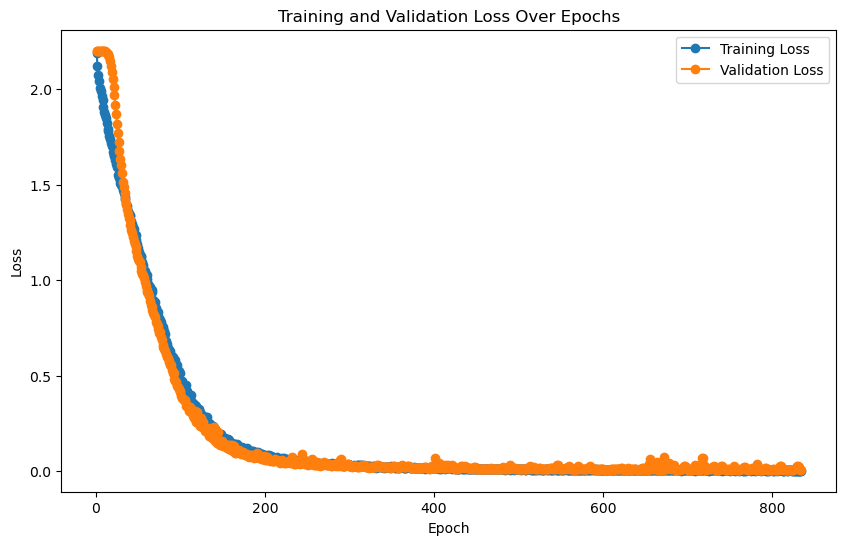

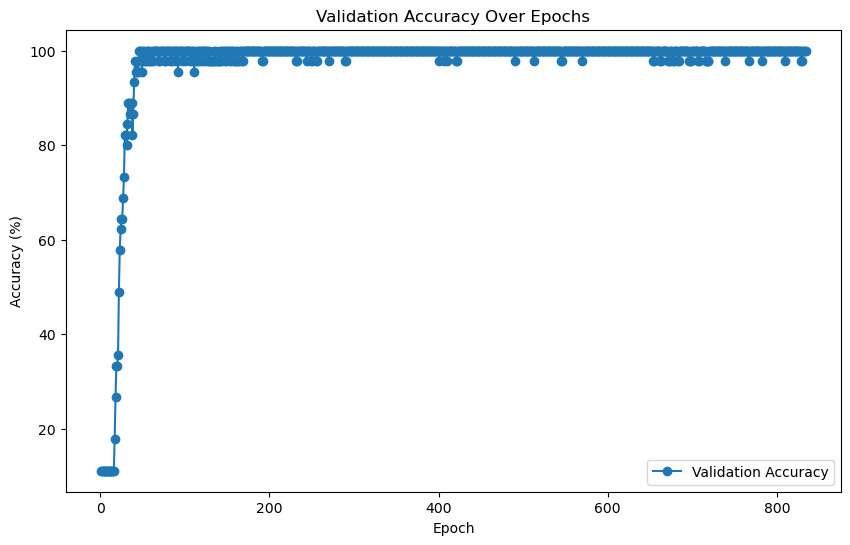


Evaluating on the test set...
    Test Batch [1/578], Loss: 0.0311



Final Test Loss: 0.0778, Test Accuracy: 98.39%
Saved E2E CNN predictions and true labels to model_predictions


In [21]:
#hyperparameters
num_epochs = 1000
learning_rate = 0.0001

#init the model, CrossEntropy loss function, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#getting unique labels from entire dataset (train, validation, test)
all_labels = []
for loader in [train_loader, val_loader, test_loader]:
    for _, labels in loader:
        all_labels.extend(labels.tolist())
all_labels = np.unique(all_labels)

# init model with correct number of classes
num_classes = len(all_labels)
model = hyperspectralCNN(input_channels=window_num_channels, num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
#lists to store losses and accuracies
classification_epoch_losses = []
validation_epoch_losses = []
val_accuracies = []

#early stopping parameters
patience = 100
best_val_loss = float('inf')
epochs_without_improvement = 0
best_model_weights = None

#training loop + validation with early stopping
for epoch in range(num_epochs):
    # TRAINING
    model.train()
    running_loss = 0.0
    print(f"\nLOG: Epoch [{epoch + 1}/{num_epochs}] - Training")

    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.to(device).permute(0, 3, 1, 2) 
        target = target.to(device)

        # forward pass
        outputs = model(data)
        loss = criterion(outputs, target)

        # backward pass + optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # accum loss
        running_loss += loss.item()

        if (batch_idx + 1) % 10 == 0:
            print(f"    Training Batch [{batch_idx + 1}/{len(train_loader)}], Loss: {loss.item():.4f}")

    # calc + store average training loss per epoch
    avg_train_loss = running_loss / len(train_loader)
    classification_epoch_losses.append(avg_train_loss)
    print(f"Epoch [{epoch + 1}/{num_epochs}] completed, Average Training Loss: {avg_train_loss:.4f}")

    # VALIDATION
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(val_loader):
            data = data.to(device).permute(0, 3, 1, 2)
            target = target.to(device)
            outputs = model(data)
            loss = criterion(outputs, target)
            val_loss += loss.item()

            # accu calculation
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == target).sum().item()
            total += target.size(0)

            if batch_idx == 0 or (batch_idx + 1) % 10 == 0:
                print(f"    Validation Batch [{batch_idx + 1}/{len(val_loader)}], Loss: {loss.item():.4f}")

    # calc + store validation metrics
    avg_val_loss = val_loss / len(val_loader)
    validation_epoch_losses.append(avg_val_loss)
    val_accuracy = 100 * correct / total
    val_accuracies.append(val_accuracy)
    print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

    # early stopping logic
    if avg_val_loss <= best_val_loss:
        print(f"Validation loss improved from {best_val_loss:.4f} to {avg_val_loss:.4f}. Saving model...")
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0
        best_model_weights = model.state_dict()
    else:
        epochs_without_improvement += 1
        print(f"Validation loss did not improve. Patience: {epochs_without_improvement}/{patience}")

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}. No improvement for {patience} epochs.")
        break

# loading the best model weights
if best_model_weights is not None:
    print("Loading the best model weights...")
    model.load_state_dict(best_model_weights)

completed_epochs = len(classification_epoch_losses)

# plot for loss and accuracy trends over epochs
plt.figure(figsize=(10,6))
plt.plot(range(1, completed_epochs + 1), classification_epoch_losses, label="Training Loss", marker='o')
plt.plot(range(1, completed_epochs + 1), validation_epoch_losses, label="Validation Loss", marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
plt.plot(range(1, completed_epochs + 1), val_accuracies, label="Validation Accuracy", marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy Over Epochs')
plt.legend()
plt.show()

#test Set Evaluation
print("\nEvaluating on the test set...")
model.eval()
test_loss = 0.0
correct = 0
total = 0
e2ecnn_test_predictions = []
e2ecnn_test_true_labels = []

with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        data = data.to(device).permute(0, 3, 1, 2)
        target = target.to(device)
        outputs = model(data)
        loss = criterion(outputs, target)
        test_loss += loss.item()

        #accuracy calc
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == target).sum().item()
        total += target.size(0)

        e2ecnn_test_predictions.extend(predicted.cpu().numpy())
        e2ecnn_test_true_labels.extend(target.cpu().numpy())

        if batch_idx == 0 or (batch_idx + 1) % 1000 == 0:
            print(f"    Test Batch [{batch_idx + 1}/{len(test_loader)}], Loss: {loss.item():.4f}")

#calc + print test metrics
avg_test_loss = test_loss / len(test_loader)
test_accuracy = 100 * correct / total
print(f"\nFinal Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

# Convert to numpy arrays and save
e2e_test_predictions = np.array(e2ecnn_test_predictions)
e2e_test_true_labels = np.array(e2ecnn_test_true_labels)

np.save(os.path.join(predictions_dir, 'e2e_cnn_predictions.npy'), e2e_test_predictions)
np.save(os.path.join(predictions_dir, 'e2e_cnn_true_labels.npy'), e2e_test_true_labels)
print(f"Saved E2E CNN predictions and true labels to {predictions_dir}")

In [22]:
# dir to save the cnn representations
e2ecnn_rep_dir = "e2ecnn_representations"
os.makedirs(e2ecnn_rep_dir, exist_ok=True)

e2ecnn_loaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}


model.eval()

with torch.no_grad():
    for e2ecnn_split_name, e2ecnn_loader in e2ecnn_loaders.items():
        print(f"\nExtracting SCL representations for the {e2ecnn_split_name} dataset...")
        # creating subfolder for the split
        e2ecnn_split_dir = os.path.join(e2ecnn_rep_dir, e2ecnn_split_name)
        os.makedirs(e2ecnn_split_dir, exist_ok=True)

        # processing the data batch-wise
        for e2ecnn_batch_idx, (e2ecnn_vectors, e2ecnn_labels) in enumerate(e2ecnn_loader):
            e2ecnn_vectors = e2ecnn_vectors.permute(0, 3, 1, 2) 
            e2ecnn_vectors = e2ecnn_vectors.to(device).float()
            # computing projections using the trained SCL model
            e2ecnn_projections = model(e2ecnn_vectors)

            # converting projections and labels to np arrays
            e2ecnn_projections_np = e2ecnn_projections.cpu().numpy()
            e2ecnn_labels_np = e2ecnn_labels.cpu().numpy()

            # saving the batch projections and labels
            np.save(os.path.join(e2ecnn_split_dir, f"cnn_encoded_batch_{e2ecnn_batch_idx}.npy"), e2ecnn_projections_np)
            np.save(os.path.join(e2ecnn_split_dir, f"cnn_labels_batch_{e2ecnn_batch_idx}.npy"), e2ecnn_labels_np)

            if (e2ecnn_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {e2ecnn_batch_idx + 1}/{len(e2ecnn_loader)} for {e2ecnn_split_name} dataset.")

        print(f"Completed extraction for the {e2ecnn_split_name} dataset. Representations saved in '{e2ecnn_split_dir}'.")

print("E2E CNN representations extraction complete.")


Extracting SCL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'e2ecnn_representations\train'.

Extracting SCL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'e2ecnn_representations\val'.

Extracting SCL representations for the test dataset...
  Processed batch 10/578 for test dataset.
  Processed batch 20/578 for test dataset.
  Processed batch 30/578 for test dataset.


  Processed batch 40/578 for test dataset.
  Processed batch 50/578 for test dataset.
  Processed batch 60/578 for test dataset.
  Processed batch 70/578 for test dataset.
  Processed batch 80/578 for test dataset.


  Processed batch 90/578 for test dataset.
  Processed batch 100/578 for test dataset.
  Processed batch 110/578 for test dataset.
  Processed batch 120/578 for test dataset.
  Processed batch 130/578 for test dataset.


  Processed batch 140/578 for test dataset.
  Processed batch 150/578 for test dataset.
  Processed batch 160/578 for test dataset.
  Processed batch 170/578 for test dataset.
  Processed batch 180/578 for test dataset.


  Processed batch 190/578 for test dataset.
  Processed batch 200/578 for test dataset.
  Processed batch 210/578 for test dataset.
  Processed batch 220/578 for test dataset.
  Processed batch 230/578 for test dataset.


  Processed batch 240/578 for test dataset.
  Processed batch 250/578 for test dataset.
  Processed batch 260/578 for test dataset.
  Processed batch 270/578 for test dataset.
  Processed batch 280/578 for test dataset.


  Processed batch 290/578 for test dataset.
  Processed batch 300/578 for test dataset.
  Processed batch 310/578 for test dataset.
  Processed batch 320/578 for test dataset.
  Processed batch 330/578 for test dataset.


  Processed batch 340/578 for test dataset.
  Processed batch 350/578 for test dataset.
  Processed batch 360/578 for test dataset.
  Processed batch 370/578 for test dataset.
  Processed batch 380/578 for test dataset.


  Processed batch 390/578 for test dataset.
  Processed batch 400/578 for test dataset.
  Processed batch 410/578 for test dataset.
  Processed batch 420/578 for test dataset.
  Processed batch 430/578 for test dataset.


  Processed batch 440/578 for test dataset.
  Processed batch 450/578 for test dataset.
  Processed batch 460/578 for test dataset.
  Processed batch 470/578 for test dataset.
  Processed batch 480/578 for test dataset.


  Processed batch 490/578 for test dataset.
  Processed batch 500/578 for test dataset.
  Processed batch 510/578 for test dataset.
  Processed batch 520/578 for test dataset.
  Processed batch 530/578 for test dataset.


  Processed batch 540/578 for test dataset.
  Processed batch 550/578 for test dataset.
  Processed batch 560/578 for test dataset.
  Processed batch 570/578 for test dataset.
Completed extraction for the test dataset. Representations saved in 'e2ecnn_representations\test'.
E2E CNN representations extraction complete.


In [23]:
def load_cnn_reps_and_labels(split_dir):
    #gather all the cnn_encoded_batch npy files in sorted order
    cnn_rep_files = sorted(glob.glob(os.path.join(split_dir, "cnn_encoded_batch_*.npy")))

    cnn_all_reps = []
    cnn_all_labels = []

    for cnn_rep_file in cnn_rep_files:
        #deriving label filenames
        cnn_label_file = cnn_rep_file.replace("cnn_encoded_batch_", "cnn_labels_batch_")

        cnn_reps = np.load(cnn_rep_file)
        cnn_labels = np.load(cnn_label_file)

        cnn_all_reps.append(cnn_reps)
        cnn_all_labels.append(cnn_labels)

    #concat along first dim
    cnn_all_reps = np.concatenate(cnn_all_reps, axis = 0)
    cnn_all_labels = np.concatenate(cnn_all_labels, axis = 0)

    return cnn_all_reps, cnn_all_labels

In [24]:
cnn_train_dir = os.path.join("e2ecnn_representations", "train")
cnn_val_dir   = os.path.join("e2ecnn_representations", "val")
cnn_test_dir  = os.path.join("e2ecnn_representations", "test")

cnn_train_reps, cnn_train_labels = load_cnn_reps_and_labels(cnn_train_dir)
cnn_val_reps, cnn_val_labels = load_cnn_reps_and_labels(cnn_val_dir)
cnn_test_reps, cnn_test_labels = load_cnn_reps_and_labels(cnn_test_dir)

## Logistic Regression Model

In [25]:
def load_encoded_data(encoded_dir):
    print(f"LOG: Loading encoded data (representations) from {encoded_dir}...")
    features_list = []
    labels_list = []

    #iter through batches
    for filename in sorted(os.listdir(encoded_dir)):
        if filename.startswith('encoded_batch_') and filename.endswith('.npy'):

            #load the features
            features = np.load(os.path.join(encoded_dir, filename))
            features_flat = features.reshape(features.shape[0], -1) #flatten features for LRM
            features_list.append(features_flat)
        
        elif filename.startswith('labels_batch_') and filename.endswith('.npy'):

            #load labels
            labels = np.load(os.path.join(encoded_dir, filename))
            labels_list.append(labels)

    #concat all batches into a single array
    encoded_features = np.vstack(features_list)
    encoded_labels = np.hstack(labels_list)

    print(f"LOG: Loaded {encoded_features.shape[0]} samples with {encoded_features.shape[1]} features each")
    print(f"LOG: Labels shape: {encoded_labels.shape}")

    return encoded_features, encoded_labels

In [26]:
lrm_encoded_train_dir = os.path.join(encoded_dir, 'train')
lrm_encoded_val_dir = os.path.join(encoded_dir, 'val')
lrm_encoded_test_dir = os.path.join(encoded_dir, 'test')

print("\nLoading training data for LRM...")
lrm_train_features, lrm_train_labels = load_encoded_data(lrm_encoded_train_dir)

print("\nLoading validation data for LRM...")
lrm_val_features, lrm_val_labels = load_encoded_data(lrm_encoded_val_dir)

print("\nLoading test data for LRM...")
lrm_test_features, lrm_test_labels = load_encoded_data(lrm_encoded_test_dir)

#verify shapes
print(f"\nLOG: Training features shape: {lrm_train_features.shape}, Training labels shape: {lrm_train_labels.shape}")
print(f"LOG: Validation features shape: {lrm_val_features.shape}, Validation labels shape: {lrm_val_labels.shape}")
print(f"LOG: Test features shape: {lrm_test_features.shape}, Test labels shape: {lrm_test_labels.shape}")

print("\nLOG: Training Logistic Regression model...")
logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight = 'balanced')
logistic_clf.fit(lrm_train_features, lrm_train_labels)
print("LOG: Logistic Regression training complete.")

#eval on Validation Set
print("\nLOG: Evaluating on the validation set...")
lrm_val_predictions = logistic_clf.predict(lrm_val_features)
lrm_val_accuracy = accuracy_score(lrm_val_labels, lrm_val_predictions)
print(f"Validation Accuracy: {lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(lrm_val_labels, lrm_val_predictions))

#eval on Test Set
print("\nLOG: Evaluating on the test set...")
lrm_test_predictions = logistic_clf.predict(lrm_test_features)
lrm_test_accuracy = accuracy_score(lrm_test_labels, lrm_test_predictions)
print(f"Test Accuracy: {lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(lrm_test_labels, lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'cae_lrm_predictions.npy'), lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'cae_lrm_true_labels.npy'), lrm_test_labels)
print(f"Saved CAE+LRM predictions and true labels to {predictions_dir}")



Loading training data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 360 samples with 64 features each
LOG: Labels shape: (360,)

Loading validation data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 45 samples with 64 features each
LOG: Labels shape: (45,)

Loading test data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\test...


LOG: Loaded 147747 samples with 64 features each
LOG: Labels shape: (147747,)

LOG: Training features shape: (360, 64), Training labels shape: (360,)
LOG: Validation features shape: (45, 64), Validation labels shape: (45,)
LOG: Test features shape: (147747, 64), Test labels shape: (147747,)

LOG: Training Logistic Regression model...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 95.56%

Validation Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       0.80      0.80      0.80         5
           2       0.80      0.80      0.80         5
           3       1.00      1.00      1.00         5
           4       1.00      1.00      1.00         5
           5       1.00      1.00      1.00         5
           6       1.00      1.00      1.00         5
           7       1.00      1.00      1.00         5
           8       1.00    


Test Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      1.00     65926
           1       0.98      0.90      0.94      7553
           2       0.78      0.93      0.85      3045
           3       0.64      0.97      0.77      2640
           4       0.92      0.84      0.88      6539
           5       0.85      0.95      0.90      9203
           6       0.94      0.85      0.90      7242
           7       1.00      0.98      0.99     42781
           8       0.95      0.99      0.97      2818

    accuracy                           0.97    147747
   macro avg       0.90      0.93      0.91    147747
weighted avg       0.97      0.97      0.97    147747

Saved CAE+LRM predictions and true labels to model_predictions


### Classifying CAE Embeddings with MLP

In [27]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules(): 
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [28]:
cae_mlp_train_dir = os.path.join("encoded_representations", "train")
cae_mlp_val_dir   = os.path.join("encoded_representations", "val")
cae_mlp_test_dir  = os.path.join("encoded_representations", "test")

cae_mlp_train_reps, cae_mlp_train_labels = load_encoded_data(cae_mlp_train_dir)
cae_mlp_val_reps, cae_mlp_val_labels = load_encoded_data(cae_mlp_val_dir)
cae_mlp_test_reps, cae_mlp_test_labels = load_encoded_data(cae_mlp_test_dir)

print("Train reps shape:",cae_mlp_train_reps.shape)
print("Train labels shape:", cae_mlp_train_labels.shape)

print("Val reps shape:", cae_mlp_val_reps.shape)
print("Val labels shape:", cae_mlp_val_labels.shape)

print("Test reps shape:", cae_mlp_test_reps.shape)
print("Test labels shape:", cae_mlp_test_labels.shape)

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 360 samples with 64 features each
LOG: Labels shape: (360,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 45 samples with 64 features each
LOG: Labels shape: (45,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 147747 samples with 64 features each
LOG: Labels shape: (147747,)
Train reps shape: (360, 64)
Train labels shape: (360,)
Val reps shape: (45, 64)
Val labels shape: (45,)
Test reps shape: (147747, 64)
Test labels shape: (147747,)


In [29]:
#converting arrays to torch tensors
cae_mlp_train_embeddings_torch = torch.tensor(cae_mlp_train_reps, dtype=torch.float32)
cae_mlp_train_labels_torch = torch.tensor(cae_mlp_train_labels, dtype=torch.long)

cae_mlp_val_embeddings_torch = torch.tensor(cae_mlp_val_reps, dtype=torch.float32)
cae_mlp_val_labels_torch = torch.tensor(cae_mlp_val_labels, dtype=torch.long)

cae_mlp_test_embeddings_torch = torch.tensor(cae_mlp_test_reps, dtype=torch.float32)
cae_mlp_test_labels_torch = torch.tensor(cae_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
cae_mlp_train_dataset = TensorDataset(cae_mlp_train_embeddings_torch, cae_mlp_train_labels_torch)
cae_mlp_val_dataset = TensorDataset(cae_mlp_val_embeddings_torch, cae_mlp_val_labels_torch)
cae_mlp_test_dataset = TensorDataset(cae_mlp_test_embeddings_torch, cae_mlp_test_labels_torch)

cae_mlp_batch_size = 64
cae_mlp_train_loader = DataLoader(cae_mlp_train_dataset, batch_size=cae_mlp_batch_size, shuffle=True)
cae_mlp_val_loader = DataLoader(cae_mlp_val_dataset, batch_size=cae_mlp_batch_size, shuffle=False)
cae_mlp_test_loader = DataLoader(cae_mlp_test_dataset, batch_size=cae_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.1120  |  Val Loss: 1.9084
Validation loss improved from inf to 1.9084.


[Epoch 2/1000] Train Loss: 1.8207  |  Val Loss: 1.7003
Validation loss improved from 1.9084 to 1.7003.
[Epoch 3/1000] Train Loss: 1.6220  |  Val Loss: 1.5092
Validation loss improved from 1.7003 to 1.5092.
[Epoch 4/1000] Train Loss: 1.4445  |  Val Loss: 1.3429
Validation loss improved from 1.5092 to 1.3429.
[Epoch 5/1000] Train Loss: 1.2911  |  Val Loss: 1.2195
Validation loss improved from 1.3429 to 1.2195.
[Epoch 6/1000] Train Loss: 1.1530  |  Val Loss: 1.0908
Validation loss improved from 1.2195 to 1.0908.
[Epoch 7/1000] Train Loss: 1.0316  |  Val Loss: 0.9766
Validation loss improved from 1.0908 to 0.9766.
[Epoch 8/1000] Train Loss: 0.9106  |  Val Loss: 0.8641
Validation loss improved from 0.9766 to 0.8641.
[Epoch 9/1000] Train Loss: 0.7872  |  Val Loss: 0.7517
Validation loss improved from 0.8641 to 0.7517.
[Epoch 10/1000] Train Loss: 0.6861  |  Val Loss: 0.6535
Validation loss improved from 0.7517 to 0.6535.
[Epoch 11/1000] Train Loss: 0.5913  |  Val Loss: 0.5663
Validation loss 

[Epoch 19/1000] Train Loss: 0.2587  |  Val Loss: 0.2521
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 20/1000] Train Loss: 0.2380  |  Val Loss: 0.2233
Validation loss improved from 0.2500 to 0.2233.
[Epoch 21/1000] Train Loss: 0.2230  |  Val Loss: 0.2139
Validation loss improved from 0.2233 to 0.2139.
[Epoch 22/1000] Train Loss: 0.2109  |  Val Loss: 0.1999
Validation loss improved from 0.2139 to 0.1999.
[Epoch 23/1000] Train Loss: 0.2073  |  Val Loss: 0.1949
Validation loss improved from 0.1999 to 0.1949.
[Epoch 24/1000] Train Loss: 0.2004  |  Val Loss: 0.1805
Validation loss improved from 0.1949 to 0.1805.
[Epoch 25/1000] Train Loss: 0.1833  |  Val Loss: 0.1613
Validation loss improved from 0.1805 to 0.1613.
[Epoch 26/1000] Train Loss: 0.1710  |  Val Loss: 0.1772
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 27/1000] Train Loss: 0.1633  |  Val Loss: 0.1501
Validation loss improved from 0.1613 to 0.1501.
[Epoch 28/1000] Train Loss: 0.1619  |  Val Loss: 0.1

[Epoch 36/1000] Train Loss: 0.1167  |  Val Loss: 0.0996
Validation loss improved from 0.1056 to 0.0996.
[Epoch 37/1000] Train Loss: 0.1123  |  Val Loss: 0.1052
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 38/1000] Train Loss: 0.1062  |  Val Loss: 0.0998
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 39/1000] Train Loss: 0.1107  |  Val Loss: 0.0922
Validation loss improved from 0.0996 to 0.0922.
[Epoch 40/1000] Train Loss: 0.0990  |  Val Loss: 0.1119
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 41/1000] Train Loss: 0.0990  |  Val Loss: 0.0947
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 42/1000] Train Loss: 0.0957  |  Val Loss: 0.1140
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 43/1000] Train Loss: 0.0958  |  Val Loss: 0.0799
Validation loss improved from 0.0922 to 0.0799.
[Epoch 44/1000] Train Loss: 0.0904  |  Val Loss: 0.0925
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 45/1000] Train Loss: 

[Epoch 53/1000] Train Loss: 0.0718  |  Val Loss: 0.0686
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 54/1000] Train Loss: 0.0690  |  Val Loss: 0.0679
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 55/1000] Train Loss: 0.0705  |  Val Loss: 0.0649
Validation loss improved from 0.0677 to 0.0649.
[Epoch 56/1000] Train Loss: 0.0689  |  Val Loss: 0.0676
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 57/1000] Train Loss: 0.0665  |  Val Loss: 0.0626
Validation loss improved from 0.0649 to 0.0626.
[Epoch 58/1000] Train Loss: 0.0654  |  Val Loss: 0.0545
Validation loss improved from 0.0626 to 0.0545.
[Epoch 59/1000] Train Loss: 0.0626  |  Val Loss: 0.0671
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 60/1000] Train Loss: 0.0598  |  Val Loss: 0.0613
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 61/1000] Train Loss: 0.0578  |  Val Loss: 0.0616
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 62/1000] Train Loss: 

[Epoch 70/1000] Train Loss: 0.0474  |  Val Loss: 0.0587
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 71/1000] Train Loss: 0.0462  |  Val Loss: 0.0566
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 72/1000] Train Loss: 0.0449  |  Val Loss: 0.0517
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 73/1000] Train Loss: 0.0455  |  Val Loss: 0.0516
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 74/1000] Train Loss: 0.0443  |  Val Loss: 0.0612
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 75/1000] Train Loss: 0.0450  |  Val Loss: 0.0563
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 76/1000] Train Loss: 0.0421  |  Val Loss: 0.0618
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 77/1000] Train Loss: 0.0417  |  Val Loss: 0.0724
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 78/1000] Train Loss: 0.0592  |  Val Loss: 0.0981
!! Validation loss did NOT improve !! Patience: 14/100
[Epoc

[Epoch 87/1000] Train Loss: 0.0419  |  Val Loss: 0.0419
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 88/1000] Train Loss: 0.0349  |  Val Loss: 0.0499
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 89/1000] Train Loss: 0.0371  |  Val Loss: 0.0454
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 90/1000] Train Loss: 0.0357  |  Val Loss: 0.0435
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 91/1000] Train Loss: 0.0316  |  Val Loss: 0.0456
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 92/1000] Train Loss: 0.0328  |  Val Loss: 0.0483
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 93/1000] Train Loss: 0.0322  |  Val Loss: 0.0463
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 94/1000] Train Loss: 0.0305  |  Val Loss: 0.0464
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 95/1000] Train Loss: 0.0304  |  Val Loss: 0.0499
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch

[Epoch 104/1000] Train Loss: 0.0372  |  Val Loss: 0.0365
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 105/1000] Train Loss: 0.0294  |  Val Loss: 0.0542
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 106/1000] Train Loss: 0.0303  |  Val Loss: 0.0355
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 107/1000] Train Loss: 0.0288  |  Val Loss: 0.0343
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 108/1000] Train Loss: 0.0257  |  Val Loss: 0.0453
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 109/1000] Train Loss: 0.0290  |  Val Loss: 0.0411
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 110/1000] Train Loss: 0.0311  |  Val Loss: 0.0379
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 111/1000] Train Loss: 0.0301  |  Val Loss: 0.0426
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 112/1000] Train Loss: 0.0351  |  Val Loss: 0.0397
!! Validation loss did NOT improve !! Patience: 9/100
[

[Epoch 123/1000] Train Loss: 0.0197  |  Val Loss: 0.0413
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 124/1000] Train Loss: 0.0218  |  Val Loss: 0.0388
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 125/1000] Train Loss: 0.0192  |  Val Loss: 0.0538
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 126/1000] Train Loss: 0.0189  |  Val Loss: 0.0395
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 127/1000] Train Loss: 0.0193  |  Val Loss: 0.0484
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 128/1000] Train Loss: 0.0199  |  Val Loss: 0.0552
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 129/1000] Train Loss: 0.0183  |  Val Loss: 0.0469
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 130/1000] Train Loss: 0.0185  |  Val Loss: 0.0492
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 131/1000] Train Loss: 0.0182  |  Val Loss: 0.0480
!! Validation loss did NOT improve !! Patience:

[Epoch 141/1000] Train Loss: 0.0205  |  Val Loss: 0.0457
!! Validation loss did NOT improve !! Patience: 38/100
[Epoch 142/1000] Train Loss: 0.0163  |  Val Loss: 0.0456
!! Validation loss did NOT improve !! Patience: 39/100
[Epoch 143/1000] Train Loss: 0.0186  |  Val Loss: 0.0483
!! Validation loss did NOT improve !! Patience: 40/100
[Epoch 144/1000] Train Loss: 0.0180  |  Val Loss: 0.0436
!! Validation loss did NOT improve !! Patience: 41/100
[Epoch 145/1000] Train Loss: 0.0152  |  Val Loss: 0.0540
!! Validation loss did NOT improve !! Patience: 42/100
[Epoch 146/1000] Train Loss: 0.0165  |  Val Loss: 0.0486
!! Validation loss did NOT improve !! Patience: 43/100
[Epoch 147/1000] Train Loss: 0.0139  |  Val Loss: 0.0631
!! Validation loss did NOT improve !! Patience: 44/100
[Epoch 148/1000] Train Loss: 0.0149  |  Val Loss: 0.0414
!! Validation loss did NOT improve !! Patience: 45/100
[Epoch 149/1000] Train Loss: 0.0134  |  Val Loss: 0.0473
!! Validation loss did NOT improve !! Patience:

[Epoch 160/1000] Train Loss: 0.0104  |  Val Loss: 0.0467
!! Validation loss did NOT improve !! Patience: 57/100
[Epoch 161/1000] Train Loss: 0.0111  |  Val Loss: 0.0467
!! Validation loss did NOT improve !! Patience: 58/100
[Epoch 162/1000] Train Loss: 0.0124  |  Val Loss: 0.0483
!! Validation loss did NOT improve !! Patience: 59/100
[Epoch 163/1000] Train Loss: 0.0111  |  Val Loss: 0.0522
!! Validation loss did NOT improve !! Patience: 60/100
[Epoch 164/1000] Train Loss: 0.0134  |  Val Loss: 0.0551
!! Validation loss did NOT improve !! Patience: 61/100
[Epoch 165/1000] Train Loss: 0.0150  |  Val Loss: 0.0663
!! Validation loss did NOT improve !! Patience: 62/100
[Epoch 166/1000] Train Loss: 0.0125  |  Val Loss: 0.0459
!! Validation loss did NOT improve !! Patience: 63/100
[Epoch 167/1000] Train Loss: 0.0107  |  Val Loss: 0.0476
!! Validation loss did NOT improve !! Patience: 64/100
[Epoch 168/1000] Train Loss: 0.0109  |  Val Loss: 0.0484
!! Validation loss did NOT improve !! Patience:

[Epoch 178/1000] Train Loss: 0.0195  |  Val Loss: 0.0445
!! Validation loss did NOT improve !! Patience: 75/100
[Epoch 179/1000] Train Loss: 0.0113  |  Val Loss: 0.0439
!! Validation loss did NOT improve !! Patience: 76/100
[Epoch 180/1000] Train Loss: 0.0105  |  Val Loss: 0.0352
!! Validation loss did NOT improve !! Patience: 77/100
[Epoch 181/1000] Train Loss: 0.0133  |  Val Loss: 0.0404
!! Validation loss did NOT improve !! Patience: 78/100
[Epoch 182/1000] Train Loss: 0.0120  |  Val Loss: 0.0369
!! Validation loss did NOT improve !! Patience: 79/100
[Epoch 183/1000] Train Loss: 0.0117  |  Val Loss: 0.0489
!! Validation loss did NOT improve !! Patience: 80/100
[Epoch 184/1000] Train Loss: 0.0106  |  Val Loss: 0.0442
!! Validation loss did NOT improve !! Patience: 81/100
[Epoch 185/1000] Train Loss: 0.0089  |  Val Loss: 0.0523
!! Validation loss did NOT improve !! Patience: 82/100
[Epoch 186/1000] Train Loss: 0.0096  |  Val Loss: 0.0413
!! Validation loss did NOT improve !! Patience:

[Epoch 196/1000] Train Loss: 0.0099  |  Val Loss: 0.0433
!! Validation loss did NOT improve !! Patience: 93/100
[Epoch 197/1000] Train Loss: 0.0080  |  Val Loss: 0.0457
!! Validation loss did NOT improve !! Patience: 94/100
[Epoch 198/1000] Train Loss: 0.0060  |  Val Loss: 0.0422
!! Validation loss did NOT improve !! Patience: 95/100
[Epoch 199/1000] Train Loss: 0.0103  |  Val Loss: 0.0431
!! Validation loss did NOT improve !! Patience: 96/100
[Epoch 200/1000] Train Loss: 0.0070  |  Val Loss: 0.0509
!! Validation loss did NOT improve !! Patience: 97/100
[Epoch 201/1000] Train Loss: 0.0077  |  Val Loss: 0.0397
!! Validation loss did NOT improve !! Patience: 98/100
[Epoch 202/1000] Train Loss: 0.0071  |  Val Loss: 0.0454
!! Validation loss did NOT improve !! Patience: 99/100
[Epoch 203/1000] Train Loss: 0.0105  |  Val Loss: 0.0402
!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 203 !!
No improvement for 100 epochs.


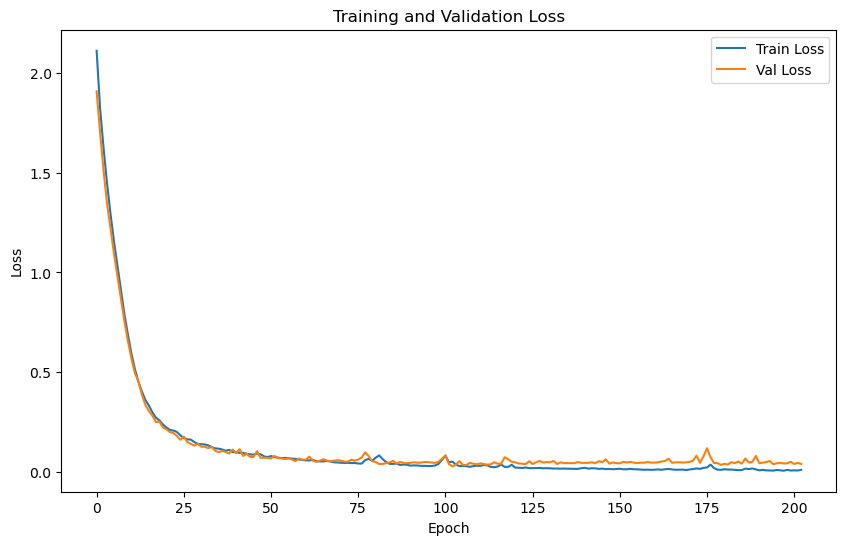

In [30]:
cae_mlp_input_dim = cae_mlp_train_reps.shape[1]
cae_mlp_num_classes = len(torch.unique(cae_mlp_train_labels_torch))
cae_mlp_model = MLPClassifier(cae_mlp_input_dim, cae_mlp_num_classes).to(device)

cae_mlp_criterion = nn.CrossEntropyLoss()
cae_mlp_optimizer = optim.Adam(cae_mlp_model.parameters(), lr=1e-3)

cae_mlp_num_epochs = 1000
cae_mlp_patience = 100

cae_mlp_train_losses = []
cae_mlp_val_losses = []

cae_mlp_best_val_loss = float('inf')
cae_mlp_epochs_without_improvement = 0

for cae_mlp_epoch in range(cae_mlp_num_epochs):
    # Training
    cae_mlp_model.train()
    cae_mlp_train_running_loss = 0.0
    
    for cae_mlp_embeddings_batch, cae_mlp_labels_batch in cae_mlp_train_loader:
        cae_mlp_embeddings_batch = cae_mlp_embeddings_batch.to(device)
        cae_mlp_labels_batch = cae_mlp_labels_batch.to(device)
        
        cae_mlp_optimizer.zero_grad()
        
        # Forward
        cae_mlp_outputs = cae_mlp_model(cae_mlp_embeddings_batch)
        cae_mlp_loss = cae_mlp_criterion(cae_mlp_outputs, cae_mlp_labels_batch)
        
        # Backward & Update
        cae_mlp_loss.backward()
        cae_mlp_optimizer.step()
        
        cae_mlp_train_running_loss += cae_mlp_loss.item() * cae_mlp_embeddings_batch.size(0)
    
    cae_mlp_epoch_train_loss = cae_mlp_train_running_loss / len(cae_mlp_train_loader.dataset)
    cae_mlp_train_losses.append(cae_mlp_epoch_train_loss)


    # Validation

    cae_mlp_model.eval()
    cae_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for cae_mlp_val_embeddings_batch, cae_mlp_val_labels_batch in cae_mlp_val_loader:
            cae_mlp_val_embeddings_batch = cae_mlp_val_embeddings_batch.to(device)
            cae_mlp_val_labels_batch = cae_mlp_val_labels_batch.to(device)

            cae_mlp_val_outputs = cae_mlp_model(cae_mlp_val_embeddings_batch)
            cae_mlp_val_loss = cae_mlp_criterion(cae_mlp_val_outputs, cae_mlp_val_labels_batch)

            cae_mlp_val_running_loss += cae_mlp_val_loss.item() * cae_mlp_val_embeddings_batch.size(0)

    cae_mlp_epoch_val_loss = cae_mlp_val_running_loss / len(cae_mlp_val_loader.dataset)
    cae_mlp_val_losses.append(cae_mlp_epoch_val_loss)

    print(f"[Epoch {cae_mlp_epoch+1}/{cae_mlp_num_epochs}] "
          f"Train Loss: {cae_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {cae_mlp_epoch_val_loss:.4f}")

    # Early stopping

    if cae_mlp_epoch_val_loss < cae_mlp_best_val_loss:
        # improvement, reset patience
        print(f"Validation loss improved from {cae_mlp_best_val_loss:.4f} to {cae_mlp_epoch_val_loss:.4f}.")
        cae_mlp_best_val_loss = cae_mlp_epoch_val_loss
        cae_mlp_epochs_without_improvement = 0

    else:
        # no improvement
        cae_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {cae_mlp_epochs_without_improvement}/{cae_mlp_patience}")
        
        if cae_mlp_epochs_without_improvement >= cae_mlp_patience:
            print(f"!! Early stopping triggered at epoch {cae_mlp_epoch+1} !!\n"
                  f"No improvement for {cae_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(cae_mlp_train_losses, label='Train Loss')
plt.plot(cae_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved CAE+MLP predictions and true labels to model_predictions
Test Loss: 0.1830 | Test Accuracy: 96.55%


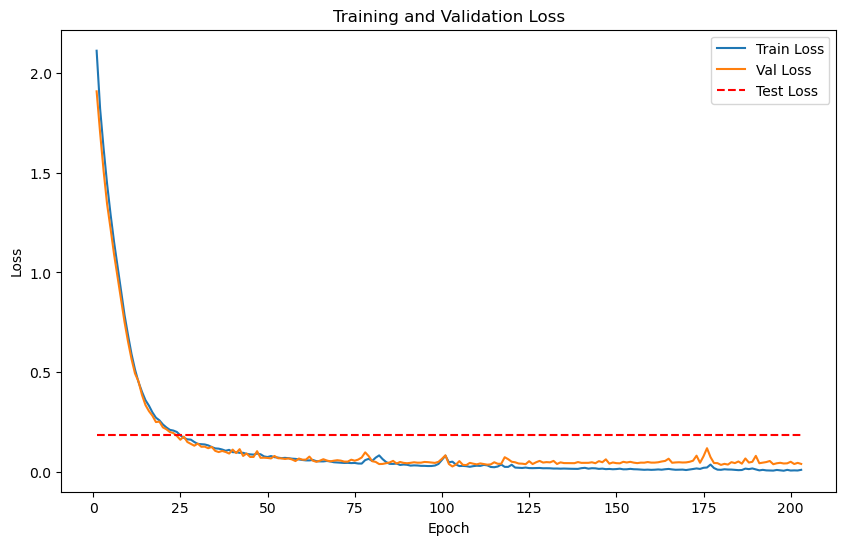

In [31]:
cae_mlp_model.eval()

cae_mlp_test_running_loss = 0.0
cae_mlp_test_correct = 0
cae_mlp_all_predictions = []
cae_mlp_all_true_labels = []

with torch.no_grad():
    for cae_mlp_test_embeddings_batch, cae_mlp_test_labels_batch in cae_mlp_test_loader:
        cae_mlp_test_embeddings_batch = cae_mlp_test_embeddings_batch.to(device)
        cae_mlp_test_labels_batch = cae_mlp_test_labels_batch.to(device)

        cae_mlp_test_outputs = cae_mlp_model(cae_mlp_test_embeddings_batch)
        
        cae_mlp_test_loss_batch = cae_mlp_criterion(cae_mlp_test_outputs, cae_mlp_test_labels_batch)
        cae_mlp_test_running_loss += cae_mlp_test_loss_batch.item() * cae_mlp_test_embeddings_batch.size(0)

        _, cae_mlp_test_predicted = torch.max(cae_mlp_test_outputs, dim=1)
        cae_mlp_test_correct += (cae_mlp_test_predicted == cae_mlp_test_labels_batch).sum().item()

        #saving predictions for conf matrix
        cae_mlp_all_predictions.extend(cae_mlp_test_predicted.cpu().numpy())
        cae_mlp_all_true_labels.extend(cae_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'cae_mlp_predictions.npy'), np.array(cae_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'cae_mlp_true_labels.npy'), np.array(cae_mlp_all_true_labels))
print(f"Saved CAE+MLP predictions and true labels to {predictions_dir}")

cae_mlp_epoch_test_loss = cae_mlp_test_running_loss / len(cae_mlp_test_loader.dataset)
cae_mlp_test_accuracy = cae_mlp_test_correct / len(cae_mlp_test_loader.dataset)

cae_mlp_test_accuracy_pct = cae_mlp_test_accuracy * 100.0

print(f"Test Loss: {cae_mlp_epoch_test_loss:.4f} | Test Accuracy: {cae_mlp_test_accuracy_pct:.2f}%")

cae_mlp_num_epochs_run = len(cae_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         cae_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         cae_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         [cae_mlp_epoch_test_loss]*cae_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

## Typical SCL with Cosine Similarity (Supervised Contrastive Loss)

In [32]:
tscl_encoded_train_dir = os.path.join(encoded_dir, 'train')
tscl_encoded_val_dir = os.path.join(encoded_dir, 'val')
tscl_encoded_test_dir = os.path.join(encoded_dir, 'test')

tscl_train_embeddings, tscl_train_labels = load_encoded_data(tscl_encoded_train_dir)
tscl_val_embeddings, tscl_val_labels = load_encoded_data(tscl_encoded_val_dir)
tscl_test_embeddings, tscl_test_labels = load_encoded_data(tscl_encoded_test_dir)

#shape verification
print(f"\n\nTrain embeddings shape: {tscl_train_embeddings.shape}, \nTrain labels shape: {tscl_train_labels.shape}")
print(f"\n\nVal embeddings shape: {tscl_val_embeddings.shape}, \nVal labels shape: {tscl_val_labels.shape}")
print(f"\n\nTest embeddings shape: {tscl_test_embeddings.shape}, \nTest labels shape: {tscl_test_labels.shape}")

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 360 samples with 64 features each
LOG: Labels shape: (360,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 45 samples with 64 features each
LOG: Labels shape: (45,)
LOG: Loading encoded data (representations) from encoded_representations\test...


LOG: Loaded 147747 samples with 64 features each
LOG: Labels shape: (147747,)


Train embeddings shape: (360, 64), 
Train labels shape: (360,)


Val embeddings shape: (45, 64), 
Val labels shape: (45,)


Test embeddings shape: (147747, 64), 
Test labels shape: (147747,)


In [33]:
#flattening embeddings to (num_samples, 64)
tscl_train_embeddings = tscl_train_embeddings.reshape(tscl_train_embeddings.shape[0], -1)
tscl_val_embeddings = tscl_val_embeddings.reshape(tscl_val_embeddings.shape[0], -1)
tscl_test_embeddings = tscl_test_embeddings.reshape(tscl_test_embeddings.shape[0], -1)

#compute mean and std from training set
tscl_train_mean = np.mean(tscl_train_embeddings, axis=0)
tscl_train_std = np.std(tscl_train_embeddings, axis=0)

#normalize all datasets from above training mean and std
tscl_train_embeddings = (tscl_train_embeddings - tscl_train_mean) / tscl_train_std
tscl_val_embeddings = (tscl_val_embeddings - tscl_train_mean) / tscl_train_std
tscl_test_embeddings = (tscl_test_embeddings - tscl_train_mean) / tscl_train_std

tscl_train_dataset = TensorDataset(torch.tensor(tscl_train_embeddings, dtype=torch.float32), torch.tensor(tscl_train_labels, dtype=torch.long))
tscl_val_dataset = TensorDataset(torch.tensor(tscl_val_embeddings, dtype=torch.float32), torch.tensor(tscl_val_labels, dtype=torch.long))
tscl_test_dataset = TensorDataset(torch.tensor(tscl_test_embeddings, dtype=torch.float32), torch.tensor(tscl_test_labels, dtype=torch.long))

tscl_m = 20
tscl_num_classes = len(np.unique(tscl_train_labels))

# Calculate theoretical required batch size
tscl_required_batch_size = tscl_m * tscl_num_classes

# Ensure batch size doesn't exceed training set size
if tscl_required_batch_size > len(tscl_train_dataset):
    #case 1: Not enough samples - reduce m proportionally
    tscl_max_possible_m = len(tscl_train_dataset) // tscl_num_classes
    tscl_m = max(1, tscl_max_possible_m)  # Ensure m >= 1
    tscl_batch_size_train = tscl_m * tscl_num_classes
else:
    #case 2: Use full batch size
    tscl_batch_size_train = tscl_required_batch_size

tscl_sampler = MPerClassSampler(labels = tscl_train_labels, m = tscl_m, batch_size = tscl_batch_size_train, length_before_new_iter=len(tscl_train_dataset))
tscl_train_loader = DataLoader(tscl_train_dataset, batch_size=tscl_batch_size_train, sampler=tscl_sampler)

#creating dataloaders for scl
tscl_dataloader_bs = 256
tscl_val_loader = DataLoader(tscl_val_dataset, batch_size=tscl_dataloader_bs, shuffle=False)
tscl_test_loader = DataLoader(tscl_test_dataset, batch_size=tscl_dataloader_bs, shuffle=False)

for tscl_X_batch, tscl_y_batch in tscl_train_loader:
    tscl_unique, tscl_counts = np.unique(y_batch.numpy(), return_counts=True)
    print("Class distribution in batch:", dict(zip(tscl_unique, tscl_counts)))
    print(f"Training batch size: {tscl_batch_size_train}")
    break

Class distribution in batch: {0: 20, 1: 20, 2: 20, 3: 20, 4: 20, 5: 20, 6: 20, 7: 20, 8: 20}
Training batch size: 180


In [34]:
class SupConLoss(nn.Module):
    def __init__(self, temperature = 0.07):
        super(SupConLoss, self).__init__()
        self.temperature = temperature

    def forward(self, features, labels):
        #normalize feat vectors
        features = F.normalize(features, p=2, dim = 1)

        #compute cosine simi matrix
        similarity_matrix = torch.matmul(features, features.T) / self.temperature

        #create a mask for +ve pairs - i.e. same class
        labels = labels.unsqueeze(1)
        mask = torch.eq(labels, labels.T).float().to(features.device)

        #loss computation
        exp_sim = torch.exp(similarity_matrix)
        log_prob = similarity_matrix - torch.log(exp_sim.sum(dim = 1, keepdim=True))

        #mask out diagonal - i.e. self similarity
        mask_self = torch.eye(mask.shape[0], dtype = torch.bool).to(features.device)
        mask = mask * (~mask_self)

        #handling edge cases when there is no +ve pair
        mask_pos_pairs = mask.sum(dim=1)
        mask_pos_pairs = torch.where(mask_pos_pairs < 1e-6, 1, mask_pos_pairs)

        loss = -(mask * log_prob).sum(dim=1) / mask_pos_pairs

        return loss.mean() 

In [35]:
class SupConNet(nn.Module):
    def __init__(self, feature_dim=128):
        super(SupConNet, self).__init__()

        self.projection_head = nn.Sequential(
            nn.Linear(64, 128), #expects input of shape (batch_size, 64)
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, feature_dim)
        )

    def forward(self, x):
        #flattening input tensor
        #x = x.view(x.size(0), -1)  #reshaping -> (batch_size, channels * height * width)
        projections = self.projection_head(x)
        return projections


LOG: Epoch [1/2000] - Training


    Batch [1/2], Train Loss: 9.1468


    Batch [2/2], Train Loss: 8.9149
Epoch [1/2000], Avg Train Loss: 9.0308
Epoch [1/2000], Avg Val Loss: 3.7206
Validation loss improved from inf to 3.7206. Saving model...

LOG: Epoch [2/2000] - Training
    Batch [1/2], Train Loss: 9.0957
    Batch [2/2], Train Loss: 8.9995
Epoch [2/2000], Avg Train Loss: 9.0476
Epoch [2/2000], Avg Val Loss: 3.6338
Validation loss improved from 3.7206 to 3.6338. Saving model...

LOG: Epoch [3/2000] - Training
    Batch [1/2], Train Loss: 8.6805
    Batch [2/2], Train Loss: 8.6568
Epoch [3/2000], Avg Train Loss: 8.6687
Epoch [3/2000], Avg Val Loss: 3.5522
Validation loss improved from 3.6338 to 3.5522. Saving model...

LOG: Epoch [4/2000] - Training
    Batch [1/2], Train Loss: 8.6359
    Batch [2/2], Train Loss: 8.7112
Epoch [4/2000], Avg Train Loss: 8.6736
Epoch [4/2000], Avg Val Loss: 3.4753
Validation loss improved from 3.5522 to 3.4753. Saving model...

LOG: Epoch [5/2000] - Training
    Batch [1/2], Train Loss: 8.5165
    Batch [2/2], Train Loss

    Batch [2/2], Train Loss: 7.5977
Epoch [9/2000], Avg Train Loss: 7.7680
Epoch [9/2000], Avg Val Loss: 3.1572
Validation loss improved from 3.2123 to 3.1572. Saving model...

LOG: Epoch [10/2000] - Training
    Batch [1/2], Train Loss: 7.7060
    Batch [2/2], Train Loss: 7.4872
Epoch [10/2000], Avg Train Loss: 7.5966
Epoch [10/2000], Avg Val Loss: 3.1059
Validation loss improved from 3.1572 to 3.1059. Saving model...

LOG: Epoch [11/2000] - Training
    Batch [1/2], Train Loss: 7.4775
    Batch [2/2], Train Loss: 7.4665
Epoch [11/2000], Avg Train Loss: 7.4720
Epoch [11/2000], Avg Val Loss: 3.0585
Validation loss improved from 3.1059 to 3.0585. Saving model...

LOG: Epoch [12/2000] - Training
    Batch [1/2], Train Loss: 7.5563
    Batch [2/2], Train Loss: 7.3170
Epoch [12/2000], Avg Train Loss: 7.4366
Epoch [12/2000], Avg Val Loss: 3.0145
Validation loss improved from 3.0585 to 3.0145. Saving model...

LOG: Epoch [13/2000] - Training
    Batch [1/2], Train Loss: 7.4161
    Batch [2/2

    Batch [1/2], Train Loss: 5.7840
    Batch [2/2], Train Loss: 5.7645
Epoch [27/2000], Avg Train Loss: 5.7743
Epoch [27/2000], Avg Val Loss: 2.6577
Validation loss improved from 2.6694 to 2.6577. Saving model...

LOG: Epoch [28/2000] - Training
    Batch [1/2], Train Loss: 5.7853
    Batch [2/2], Train Loss: 5.8068
Epoch [28/2000], Avg Train Loss: 5.7960
Epoch [28/2000], Avg Val Loss: 2.6471
Validation loss improved from 2.6577 to 2.6471. Saving model...

LOG: Epoch [29/2000] - Training
    Batch [1/2], Train Loss: 5.8134
    Batch [2/2], Train Loss: 5.6568
Epoch [29/2000], Avg Train Loss: 5.7351
Epoch [29/2000], Avg Val Loss: 2.6376
Validation loss improved from 2.6471 to 2.6376. Saving model...

LOG: Epoch [30/2000] - Training
    Batch [1/2], Train Loss: 5.6284
    Batch [2/2], Train Loss: 5.6425
Epoch [30/2000], Avg Train Loss: 5.6354
Epoch [30/2000], Avg Val Loss: 2.6291
Validation loss improved from 2.6376 to 2.6291. Saving model...

LOG: Epoch [31/2000] - Training
    Batch [1

    Batch [2/2], Train Loss: 5.4564
Epoch [33/2000], Avg Train Loss: 5.5018
Epoch [33/2000], Avg Val Loss: 2.6080
Validation loss improved from 2.6143 to 2.6080. Saving model...

LOG: Epoch [34/2000] - Training
    Batch [1/2], Train Loss: 5.3461
    Batch [2/2], Train Loss: 5.3611
Epoch [34/2000], Avg Train Loss: 5.3536
Epoch [34/2000], Avg Val Loss: 2.6021
Validation loss improved from 2.6080 to 2.6021. Saving model...

LOG: Epoch [35/2000] - Training
    Batch [1/2], Train Loss: 5.3916
    Batch [2/2], Train Loss: 5.2938
Epoch [35/2000], Avg Train Loss: 5.3427
Epoch [35/2000], Avg Val Loss: 2.5968
Validation loss improved from 2.6021 to 2.5968. Saving model...

LOG: Epoch [36/2000] - Training
    Batch [1/2], Train Loss: 5.3383
    Batch [2/2], Train Loss: 5.3153
Epoch [36/2000], Avg Train Loss: 5.3268
Epoch [36/2000], Avg Val Loss: 2.5917
Validation loss improved from 2.5968 to 2.5917. Saving model...

LOG: Epoch [37/2000] - Training
    Batch [1/2], Train Loss: 5.2775
    Batch [2

    Batch [1/2], Train Loss: 4.9237
    Batch [2/2], Train Loss: 4.7607
Epoch [52/2000], Avg Train Loss: 4.8422
Epoch [52/2000], Avg Val Loss: 2.5486
Validation loss improved from 2.5503 to 2.5486. Saving model...

LOG: Epoch [53/2000] - Training
    Batch [1/2], Train Loss: 4.8115
    Batch [2/2], Train Loss: 4.7724
Epoch [53/2000], Avg Train Loss: 4.7919
Epoch [53/2000], Avg Val Loss: 2.5469
Validation loss improved from 2.5486 to 2.5469. Saving model...

LOG: Epoch [54/2000] - Training
    Batch [1/2], Train Loss: 4.8958
    Batch [2/2], Train Loss: 4.7992
Epoch [54/2000], Avg Train Loss: 4.8475
Epoch [54/2000], Avg Val Loss: 2.5453
Validation loss improved from 2.5469 to 2.5453. Saving model...

LOG: Epoch [55/2000] - Training
    Batch [1/2], Train Loss: 4.7589
    Batch [2/2], Train Loss: 4.7392
Epoch [55/2000], Avg Train Loss: 4.7490
Epoch [55/2000], Avg Val Loss: 2.5438
Validation loss improved from 2.5453 to 2.5438. Saving model...

LOG: Epoch [56/2000] - Training
    Batch [1

Epoch [59/2000], Avg Val Loss: 2.5382
Validation loss improved from 2.5395 to 2.5382. Saving model...

LOG: Epoch [60/2000] - Training
    Batch [1/2], Train Loss: 4.6867
    Batch [2/2], Train Loss: 4.6479
Epoch [60/2000], Avg Train Loss: 4.6673
Epoch [60/2000], Avg Val Loss: 2.5368
Validation loss improved from 2.5382 to 2.5368. Saving model...

LOG: Epoch [61/2000] - Training
    Batch [1/2], Train Loss: 4.6449
    Batch [2/2], Train Loss: 4.6991
Epoch [61/2000], Avg Train Loss: 4.6720
Epoch [61/2000], Avg Val Loss: 2.5354
Validation loss improved from 2.5368 to 2.5354. Saving model...

LOG: Epoch [62/2000] - Training
    Batch [1/2], Train Loss: 4.5122
    Batch [2/2], Train Loss: 4.6633
Epoch [62/2000], Avg Train Loss: 4.5878
Epoch [62/2000], Avg Val Loss: 2.5341
Validation loss improved from 2.5354 to 2.5341. Saving model...

LOG: Epoch [63/2000] - Training
    Batch [1/2], Train Loss: 4.5274
    Batch [2/2], Train Loss: 4.5388
Epoch [63/2000], Avg Train Loss: 4.5331
Epoch [63/20

    Batch [1/2], Train Loss: 4.4848
    Batch [2/2], Train Loss: 4.5495
Epoch [76/2000], Avg Train Loss: 4.5171
Epoch [76/2000], Avg Val Loss: 2.5152
Validation loss improved from 2.5166 to 2.5152. Saving model...

LOG: Epoch [77/2000] - Training
    Batch [1/2], Train Loss: 4.4242
    Batch [2/2], Train Loss: 4.5150
Epoch [77/2000], Avg Train Loss: 4.4696
Epoch [77/2000], Avg Val Loss: 2.5138
Validation loss improved from 2.5152 to 2.5138. Saving model...

LOG: Epoch [78/2000] - Training
    Batch [1/2], Train Loss: 4.4876
    Batch [2/2], Train Loss: 4.4202
Epoch [78/2000], Avg Train Loss: 4.4539
Epoch [78/2000], Avg Val Loss: 2.5124
Validation loss improved from 2.5138 to 2.5124. Saving model...

LOG: Epoch [79/2000] - Training
    Batch [1/2], Train Loss: 4.4560
    Batch [2/2], Train Loss: 4.4225
Epoch [79/2000], Avg Train Loss: 4.4392
Epoch [79/2000], Avg Val Loss: 2.5109
Validation loss improved from 2.5124 to 2.5109. Saving model...

LOG: Epoch [80/2000] - Training
    Batch [1

    Batch [1/2], Train Loss: 4.4063
    Batch [2/2], Train Loss: 4.4126
Epoch [85/2000], Avg Train Loss: 4.4094
Epoch [85/2000], Avg Val Loss: 2.5019
Validation loss improved from 2.5034 to 2.5019. Saving model...

LOG: Epoch [86/2000] - Training
    Batch [1/2], Train Loss: 4.4405
    Batch [2/2], Train Loss: 4.3934
Epoch [86/2000], Avg Train Loss: 4.4169
Epoch [86/2000], Avg Val Loss: 2.5004
Validation loss improved from 2.5019 to 2.5004. Saving model...

LOG: Epoch [87/2000] - Training
    Batch [1/2], Train Loss: 4.4060
    Batch [2/2], Train Loss: 4.3837
Epoch [87/2000], Avg Train Loss: 4.3948
Epoch [87/2000], Avg Val Loss: 2.4990
Validation loss improved from 2.5004 to 2.4990. Saving model...

LOG: Epoch [88/2000] - Training
    Batch [1/2], Train Loss: 4.3175
    Batch [2/2], Train Loss: 4.5276
Epoch [88/2000], Avg Train Loss: 4.4225
Epoch [88/2000], Avg Val Loss: 2.4975
Validation loss improved from 2.4990 to 2.4975. Saving model...

LOG: Epoch [89/2000] - Training
    Batch [1

    Batch [2/2], Train Loss: 4.3424
Epoch [101/2000], Avg Train Loss: 4.3299
Epoch [101/2000], Avg Val Loss: 2.4779
Validation loss improved from 2.4794 to 2.4779. Saving model...

LOG: Epoch [102/2000] - Training
    Batch [1/2], Train Loss: 4.2696
    Batch [2/2], Train Loss: 4.3093
Epoch [102/2000], Avg Train Loss: 4.2894
Epoch [102/2000], Avg Val Loss: 2.4764
Validation loss improved from 2.4779 to 2.4764. Saving model...

LOG: Epoch [103/2000] - Training
    Batch [1/2], Train Loss: 4.2634
    Batch [2/2], Train Loss: 4.2551
Epoch [103/2000], Avg Train Loss: 4.2593
Epoch [103/2000], Avg Val Loss: 2.4749
Validation loss improved from 2.4764 to 2.4749. Saving model...

LOG: Epoch [104/2000] - Training
    Batch [1/2], Train Loss: 4.3127
    Batch [2/2], Train Loss: 4.3510
Epoch [104/2000], Avg Train Loss: 4.3319
Epoch [104/2000], Avg Val Loss: 2.4734
Validation loss improved from 2.4749 to 2.4734. Saving model...

LOG: Epoch [105/2000] - Training
    Batch [1/2], Train Loss: 4.2665


    Batch [1/2], Train Loss: 4.2699
    Batch [2/2], Train Loss: 4.2633
Epoch [109/2000], Avg Train Loss: 4.2666
Epoch [109/2000], Avg Val Loss: 2.4662
Validation loss improved from 2.4677 to 2.4662. Saving model...

LOG: Epoch [110/2000] - Training
    Batch [1/2], Train Loss: 4.2684
    Batch [2/2], Train Loss: 4.2031
Epoch [110/2000], Avg Train Loss: 4.2357
Epoch [110/2000], Avg Val Loss: 2.4647
Validation loss improved from 2.4662 to 2.4647. Saving model...

LOG: Epoch [111/2000] - Training
    Batch [1/2], Train Loss: 4.1890
    Batch [2/2], Train Loss: 4.2844
Epoch [111/2000], Avg Train Loss: 4.2367
Epoch [111/2000], Avg Val Loss: 2.4632
Validation loss improved from 2.4647 to 2.4632. Saving model...

LOG: Epoch [112/2000] - Training
    Batch [1/2], Train Loss: 4.2248
    Batch [2/2], Train Loss: 4.1940
Epoch [112/2000], Avg Train Loss: 4.2094
Epoch [112/2000], Avg Val Loss: 2.4618
Validation loss improved from 2.4632 to 2.4618. Saving model...

LOG: Epoch [113/2000] - Training


    Batch [2/2], Train Loss: 4.1431
Epoch [127/2000], Avg Train Loss: 4.1589
Epoch [127/2000], Avg Val Loss: 2.4417
Validation loss improved from 2.4430 to 2.4417. Saving model...

LOG: Epoch [128/2000] - Training
    Batch [1/2], Train Loss: 4.1609
    Batch [2/2], Train Loss: 4.1634
Epoch [128/2000], Avg Train Loss: 4.1621
Epoch [128/2000], Avg Val Loss: 2.4403
Validation loss improved from 2.4417 to 2.4403. Saving model...

LOG: Epoch [129/2000] - Training
    Batch [1/2], Train Loss: 4.1270
    Batch [2/2], Train Loss: 4.2344
Epoch [129/2000], Avg Train Loss: 4.1807
Epoch [129/2000], Avg Val Loss: 2.4389
Validation loss improved from 2.4403 to 2.4389. Saving model...

LOG: Epoch [130/2000] - Training
    Batch [1/2], Train Loss: 4.1290
    Batch [2/2], Train Loss: 4.1893
Epoch [130/2000], Avg Train Loss: 4.1591
Epoch [130/2000], Avg Val Loss: 2.4376
Validation loss improved from 2.4389 to 2.4376. Saving model...

LOG: Epoch [131/2000] - Training
    Batch [1/2], Train Loss: 4.1565


    Batch [2/2], Train Loss: 4.1494
Epoch [134/2000], Avg Train Loss: 4.1461
Epoch [134/2000], Avg Val Loss: 2.4322
Validation loss improved from 2.4336 to 2.4322. Saving model...

LOG: Epoch [135/2000] - Training
    Batch [1/2], Train Loss: 4.1721
    Batch [2/2], Train Loss: 4.1871
Epoch [135/2000], Avg Train Loss: 4.1796
Epoch [135/2000], Avg Val Loss: 2.4309
Validation loss improved from 2.4322 to 2.4309. Saving model...

LOG: Epoch [136/2000] - Training
    Batch [1/2], Train Loss: 4.1679
    Batch [2/2], Train Loss: 4.1486
Epoch [136/2000], Avg Train Loss: 4.1582
Epoch [136/2000], Avg Val Loss: 2.4296
Validation loss improved from 2.4309 to 2.4296. Saving model...

LOG: Epoch [137/2000] - Training
    Batch [1/2], Train Loss: 4.1373
    Batch [2/2], Train Loss: 4.1451
Epoch [137/2000], Avg Train Loss: 4.1412
Epoch [137/2000], Avg Val Loss: 2.4282
Validation loss improved from 2.4296 to 2.4282. Saving model...

LOG: Epoch [138/2000] - Training
    Batch [1/2], Train Loss: 4.0775


    Batch [1/2], Train Loss: 4.0675
    Batch [2/2], Train Loss: 4.0740
Epoch [152/2000], Avg Train Loss: 4.0707
Epoch [152/2000], Avg Val Loss: 2.4089
Validation loss improved from 2.4102 to 2.4089. Saving model...

LOG: Epoch [153/2000] - Training
    Batch [1/2], Train Loss: 4.1096
    Batch [2/2], Train Loss: 4.1147
Epoch [153/2000], Avg Train Loss: 4.1121
Epoch [153/2000], Avg Val Loss: 2.4077
Validation loss improved from 2.4089 to 2.4077. Saving model...

LOG: Epoch [154/2000] - Training
    Batch [1/2], Train Loss: 4.0829
    Batch [2/2], Train Loss: 4.0556
Epoch [154/2000], Avg Train Loss: 4.0693
Epoch [154/2000], Avg Val Loss: 2.4064
Validation loss improved from 2.4077 to 2.4064. Saving model...

LOG: Epoch [155/2000] - Training
    Batch [1/2], Train Loss: 4.0746
    Batch [2/2], Train Loss: 4.0692
Epoch [155/2000], Avg Train Loss: 4.0719
Epoch [155/2000], Avg Val Loss: 2.4051
Validation loss improved from 2.4064 to 2.4051. Saving model...

LOG: Epoch [156/2000] - Training


    Batch [1/2], Train Loss: 4.0745
    Batch [2/2], Train Loss: 4.0498
Epoch [157/2000], Avg Train Loss: 4.0622
Epoch [157/2000], Avg Val Loss: 2.4024
Validation loss improved from 2.4037 to 2.4024. Saving model...

LOG: Epoch [158/2000] - Training
    Batch [1/2], Train Loss: 4.0430
    Batch [2/2], Train Loss: 4.0701
Epoch [158/2000], Avg Train Loss: 4.0566
Epoch [158/2000], Avg Val Loss: 2.4011
Validation loss improved from 2.4024 to 2.4011. Saving model...

LOG: Epoch [159/2000] - Training
    Batch [1/2], Train Loss: 4.1013
    Batch [2/2], Train Loss: 4.0784
Epoch [159/2000], Avg Train Loss: 4.0899
Epoch [159/2000], Avg Val Loss: 2.3998
Validation loss improved from 2.4011 to 2.3998. Saving model...

LOG: Epoch [160/2000] - Training
    Batch [1/2], Train Loss: 4.0933
    Batch [2/2], Train Loss: 4.0878
Epoch [160/2000], Avg Train Loss: 4.0905
Epoch [160/2000], Avg Val Loss: 2.3986
Validation loss improved from 2.3998 to 2.3986. Saving model...

LOG: Epoch [161/2000] - Training


    Batch [2/2], Train Loss: 3.9320
Epoch [176/2000], Avg Train Loss: 3.9962
Epoch [176/2000], Avg Val Loss: 2.3794
Validation loss improved from 2.3806 to 2.3794. Saving model...

LOG: Epoch [177/2000] - Training
    Batch [1/2], Train Loss: 3.9429
    Batch [2/2], Train Loss: 4.0515
Epoch [177/2000], Avg Train Loss: 3.9972
Epoch [177/2000], Avg Val Loss: 2.3782
Validation loss improved from 2.3794 to 2.3782. Saving model...

LOG: Epoch [178/2000] - Training
    Batch [1/2], Train Loss: 4.0282
    Batch [2/2], Train Loss: 3.9779
Epoch [178/2000], Avg Train Loss: 4.0030
Epoch [178/2000], Avg Val Loss: 2.3771
Validation loss improved from 2.3782 to 2.3771. Saving model...

LOG: Epoch [179/2000] - Training
    Batch [1/2], Train Loss: 4.0195
    Batch [2/2], Train Loss: 4.0599
Epoch [179/2000], Avg Train Loss: 4.0397
Epoch [179/2000], Avg Val Loss: 2.3760
Validation loss improved from 2.3771 to 2.3760. Saving model...

LOG: Epoch [180/2000] - Training
    Batch [1/2], Train Loss: 3.9819


    Batch [1/2], Train Loss: 3.9900
    Batch [2/2], Train Loss: 3.9768
Epoch [184/2000], Avg Train Loss: 3.9834
Epoch [184/2000], Avg Val Loss: 2.3705
Validation loss improved from 2.3716 to 2.3705. Saving model...

LOG: Epoch [185/2000] - Training
    Batch [1/2], Train Loss: 3.9448
    Batch [2/2], Train Loss: 4.0201
Epoch [185/2000], Avg Train Loss: 3.9825
Epoch [185/2000], Avg Val Loss: 2.3694
Validation loss improved from 2.3705 to 2.3694. Saving model...

LOG: Epoch [186/2000] - Training
    Batch [1/2], Train Loss: 3.9870
    Batch [2/2], Train Loss: 3.9669
Epoch [186/2000], Avg Train Loss: 3.9770
Epoch [186/2000], Avg Val Loss: 2.3683
Validation loss improved from 2.3694 to 2.3683. Saving model...

LOG: Epoch [187/2000] - Training
    Batch [1/2], Train Loss: 3.9824
    Batch [2/2], Train Loss: 4.0000
Epoch [187/2000], Avg Train Loss: 3.9912
Epoch [187/2000], Avg Val Loss: 2.3672
Validation loss improved from 2.3683 to 2.3672. Saving model...

LOG: Epoch [188/2000] - Training


    Batch [1/2], Train Loss: 3.9320
    Batch [2/2], Train Loss: 3.9830
Epoch [201/2000], Avg Train Loss: 3.9575
Epoch [201/2000], Avg Val Loss: 2.3518
Validation loss improved from 2.3530 to 2.3518. Saving model...

LOG: Epoch [202/2000] - Training
    Batch [1/2], Train Loss: 3.8896
    Batch [2/2], Train Loss: 3.9530
Epoch [202/2000], Avg Train Loss: 3.9213
Epoch [202/2000], Avg Val Loss: 2.3507
Validation loss improved from 2.3518 to 2.3507. Saving model...

LOG: Epoch [203/2000] - Training
    Batch [1/2], Train Loss: 3.9284
    Batch [2/2], Train Loss: 3.9614
Epoch [203/2000], Avg Train Loss: 3.9449
Epoch [203/2000], Avg Val Loss: 2.3496
Validation loss improved from 2.3507 to 2.3496. Saving model...

LOG: Epoch [204/2000] - Training
    Batch [1/2], Train Loss: 3.9575
    Batch [2/2], Train Loss: 3.9667
Epoch [204/2000], Avg Train Loss: 3.9621
Epoch [204/2000], Avg Val Loss: 2.3485
Validation loss improved from 2.3496 to 2.3485. Saving model...

LOG: Epoch [205/2000] - Training


    Batch [1/2], Train Loss: 3.9795
    Batch [2/2], Train Loss: 3.9393
Epoch [209/2000], Avg Train Loss: 3.9594
Epoch [209/2000], Avg Val Loss: 2.3437
Validation loss improved from 2.3447 to 2.3437. Saving model...

LOG: Epoch [210/2000] - Training
    Batch [1/2], Train Loss: 3.9152
    Batch [2/2], Train Loss: 3.9178
Epoch [210/2000], Avg Train Loss: 3.9165
Epoch [210/2000], Avg Val Loss: 2.3426
Validation loss improved from 2.3437 to 2.3426. Saving model...

LOG: Epoch [211/2000] - Training
    Batch [1/2], Train Loss: 3.9277
    Batch [2/2], Train Loss: 3.9499
Epoch [211/2000], Avg Train Loss: 3.9388
Epoch [211/2000], Avg Val Loss: 2.3417
Validation loss improved from 2.3426 to 2.3417. Saving model...

LOG: Epoch [212/2000] - Training
    Batch [1/2], Train Loss: 3.9028
    Batch [2/2], Train Loss: 3.9442
Epoch [212/2000], Avg Train Loss: 3.9235
Epoch [212/2000], Avg Val Loss: 2.3407
Validation loss improved from 2.3417 to 2.3407. Saving model...

LOG: Epoch [213/2000] - Training


    Batch [2/2], Train Loss: 3.8942
Epoch [226/2000], Avg Train Loss: 3.9234
Epoch [226/2000], Avg Val Loss: 2.3273
Validation loss improved from 2.3283 to 2.3273. Saving model...

LOG: Epoch [227/2000] - Training
    Batch [1/2], Train Loss: 3.8975
    Batch [2/2], Train Loss: 3.9431
Epoch [227/2000], Avg Train Loss: 3.9203
Epoch [227/2000], Avg Val Loss: 2.3264
Validation loss improved from 2.3273 to 2.3264. Saving model...

LOG: Epoch [228/2000] - Training
    Batch [1/2], Train Loss: 3.8739
    Batch [2/2], Train Loss: 3.9047
Epoch [228/2000], Avg Train Loss: 3.8893
Epoch [228/2000], Avg Val Loss: 2.3254
Validation loss improved from 2.3264 to 2.3254. Saving model...

LOG: Epoch [229/2000] - Training
    Batch [1/2], Train Loss: 3.8977
    Batch [2/2], Train Loss: 3.8720
Epoch [229/2000], Avg Train Loss: 3.8849
Epoch [229/2000], Avg Val Loss: 2.3243
Validation loss improved from 2.3254 to 2.3243. Saving model...

LOG: Epoch [230/2000] - Training
    Batch [1/2], Train Loss: 3.9133


Epoch [231/2000], Avg Val Loss: 2.3223
Validation loss improved from 2.3233 to 2.3223. Saving model...

LOG: Epoch [232/2000] - Training
    Batch [1/2], Train Loss: 3.9026
    Batch [2/2], Train Loss: 3.8584
Epoch [232/2000], Avg Train Loss: 3.8805
Epoch [232/2000], Avg Val Loss: 2.3213
Validation loss improved from 2.3223 to 2.3213. Saving model...

LOG: Epoch [233/2000] - Training
    Batch [1/2], Train Loss: 3.9260
    Batch [2/2], Train Loss: 3.9175
Epoch [233/2000], Avg Train Loss: 3.9217
Epoch [233/2000], Avg Val Loss: 2.3204
Validation loss improved from 2.3213 to 2.3204. Saving model...

LOG: Epoch [234/2000] - Training
    Batch [1/2], Train Loss: 3.9138
    Batch [2/2], Train Loss: 3.8597
Epoch [234/2000], Avg Train Loss: 3.8867
Epoch [234/2000], Avg Val Loss: 2.3194
Validation loss improved from 2.3204 to 2.3194. Saving model...

LOG: Epoch [235/2000] - Training
    Batch [1/2], Train Loss: 3.8670
    Batch [2/2], Train Loss: 3.8696
Epoch [235/2000], Avg Train Loss: 3.8683


    Batch [2/2], Train Loss: 3.8681
Epoch [251/2000], Avg Train Loss: 3.8467
Epoch [251/2000], Avg Val Loss: 2.3015
Validation loss improved from 2.3026 to 2.3015. Saving model...

LOG: Epoch [252/2000] - Training
    Batch [1/2], Train Loss: 3.8532
    Batch [2/2], Train Loss: 3.8671
Epoch [252/2000], Avg Train Loss: 3.8601
Epoch [252/2000], Avg Val Loss: 2.3004
Validation loss improved from 2.3015 to 2.3004. Saving model...

LOG: Epoch [253/2000] - Training
    Batch [1/2], Train Loss: 3.8399
    Batch [2/2], Train Loss: 3.8875
Epoch [253/2000], Avg Train Loss: 3.8637
Epoch [253/2000], Avg Val Loss: 2.2993
Validation loss improved from 2.3004 to 2.2993. Saving model...

LOG: Epoch [254/2000] - Training
    Batch [1/2], Train Loss: 3.8845
    Batch [2/2], Train Loss: 3.8865
Epoch [254/2000], Avg Train Loss: 3.8855
Epoch [254/2000], Avg Val Loss: 2.2983
Validation loss improved from 2.2993 to 2.2983. Saving model...

LOG: Epoch [255/2000] - Training
    Batch [1/2], Train Loss: 3.9214


    Batch [1/2], Train Loss: 3.8480
    Batch [2/2], Train Loss: 3.8406
Epoch [256/2000], Avg Train Loss: 3.8443
Epoch [256/2000], Avg Val Loss: 2.2961
Validation loss improved from 2.2972 to 2.2961. Saving model...

LOG: Epoch [257/2000] - Training
    Batch [1/2], Train Loss: 3.8596
    Batch [2/2], Train Loss: 3.8888
Epoch [257/2000], Avg Train Loss: 3.8742
Epoch [257/2000], Avg Val Loss: 2.2950
Validation loss improved from 2.2961 to 2.2950. Saving model...

LOG: Epoch [258/2000] - Training
    Batch [1/2], Train Loss: 3.9110
    Batch [2/2], Train Loss: 3.8109
Epoch [258/2000], Avg Train Loss: 3.8610
Epoch [258/2000], Avg Val Loss: 2.2939
Validation loss improved from 2.2950 to 2.2939. Saving model...

LOG: Epoch [259/2000] - Training
    Batch [1/2], Train Loss: 3.8647
    Batch [2/2], Train Loss: 3.8828
Epoch [259/2000], Avg Train Loss: 3.8737
Epoch [259/2000], Avg Val Loss: 2.2928
Validation loss improved from 2.2939 to 2.2928. Saving model...

LOG: Epoch [260/2000] - Training


    Batch [2/2], Train Loss: 3.7969
Epoch [276/2000], Avg Train Loss: 3.8034
Epoch [276/2000], Avg Val Loss: 2.2760
Validation loss improved from 2.2771 to 2.2760. Saving model...

LOG: Epoch [277/2000] - Training
    Batch [1/2], Train Loss: 3.7868
    Batch [2/2], Train Loss: 3.8139
Epoch [277/2000], Avg Train Loss: 3.8004
Epoch [277/2000], Avg Val Loss: 2.2749
Validation loss improved from 2.2760 to 2.2749. Saving model...

LOG: Epoch [278/2000] - Training
    Batch [1/2], Train Loss: 3.8467
    Batch [2/2], Train Loss: 3.8052
Epoch [278/2000], Avg Train Loss: 3.8259
Epoch [278/2000], Avg Val Loss: 2.2737
Validation loss improved from 2.2749 to 2.2737. Saving model...

LOG: Epoch [279/2000] - Training
    Batch [1/2], Train Loss: 3.7813
    Batch [2/2], Train Loss: 3.7976
Epoch [279/2000], Avg Train Loss: 3.7894
Epoch [279/2000], Avg Val Loss: 2.2726
Validation loss improved from 2.2737 to 2.2726. Saving model...

LOG: Epoch [280/2000] - Training
    Batch [1/2], Train Loss: 3.8061


    Batch [2/2], Train Loss: 3.8502
Epoch [283/2000], Avg Train Loss: 3.8389
Epoch [283/2000], Avg Val Loss: 2.2679
Validation loss improved from 2.2691 to 2.2679. Saving model...

LOG: Epoch [284/2000] - Training
    Batch [1/2], Train Loss: 3.8335
    Batch [2/2], Train Loss: 3.7840
Epoch [284/2000], Avg Train Loss: 3.8087
Epoch [284/2000], Avg Val Loss: 2.2667
Validation loss improved from 2.2679 to 2.2667. Saving model...

LOG: Epoch [285/2000] - Training
    Batch [1/2], Train Loss: 3.8120
    Batch [2/2], Train Loss: 3.8763
Epoch [285/2000], Avg Train Loss: 3.8442
Epoch [285/2000], Avg Val Loss: 2.2655
Validation loss improved from 2.2667 to 2.2655. Saving model...

LOG: Epoch [286/2000] - Training
    Batch [1/2], Train Loss: 3.8744
    Batch [2/2], Train Loss: 3.8109
Epoch [286/2000], Avg Train Loss: 3.8427
Epoch [286/2000], Avg Val Loss: 2.2644
Validation loss improved from 2.2655 to 2.2644. Saving model...

LOG: Epoch [287/2000] - Training
    Batch [1/2], Train Loss: 3.8087


    Batch [1/2], Train Loss: 3.7557
    Batch [2/2], Train Loss: 3.7713
Epoch [301/2000], Avg Train Loss: 3.7635
Epoch [301/2000], Avg Val Loss: 2.2491
Validation loss improved from 2.2501 to 2.2491. Saving model...

LOG: Epoch [302/2000] - Training
    Batch [1/2], Train Loss: 3.7498
    Batch [2/2], Train Loss: 3.7936
Epoch [302/2000], Avg Train Loss: 3.7717
Epoch [302/2000], Avg Val Loss: 2.2480
Validation loss improved from 2.2491 to 2.2480. Saving model...

LOG: Epoch [303/2000] - Training
    Batch [1/2], Train Loss: 3.8177
    Batch [2/2], Train Loss: 3.7389
Epoch [303/2000], Avg Train Loss: 3.7783
Epoch [303/2000], Avg Val Loss: 2.2470
Validation loss improved from 2.2480 to 2.2470. Saving model...

LOG: Epoch [304/2000] - Training


    Batch [1/2], Train Loss: 3.7559
    Batch [2/2], Train Loss: 3.7808
Epoch [304/2000], Avg Train Loss: 3.7684
Epoch [304/2000], Avg Val Loss: 2.2459
Validation loss improved from 2.2470 to 2.2459. Saving model...

LOG: Epoch [305/2000] - Training
    Batch [1/2], Train Loss: 3.7961
    Batch [2/2], Train Loss: 3.8126
Epoch [305/2000], Avg Train Loss: 3.8044
Epoch [305/2000], Avg Val Loss: 2.2447
Validation loss improved from 2.2459 to 2.2447. Saving model...

LOG: Epoch [306/2000] - Training
    Batch [1/2], Train Loss: 3.7532
    Batch [2/2], Train Loss: 3.7817
Epoch [306/2000], Avg Train Loss: 3.7675
Epoch [306/2000], Avg Val Loss: 2.2436
Validation loss improved from 2.2447 to 2.2436. Saving model...

LOG: Epoch [307/2000] - Training
    Batch [1/2], Train Loss: 3.7524
    Batch [2/2], Train Loss: 3.7835
Epoch [307/2000], Avg Train Loss: 3.7680
Epoch [307/2000], Avg Val Loss: 2.2424
Validation loss improved from 2.2436 to 2.2424. Saving model...

LOG: Epoch [308/2000] - Training


    Batch [2/2], Train Loss: 3.7312
Epoch [314/2000], Avg Train Loss: 3.7444
Epoch [314/2000], Avg Val Loss: 2.2351
Validation loss improved from 2.2360 to 2.2351. Saving model...

LOG: Epoch [315/2000] - Training
    Batch [1/2], Train Loss: 3.7681
    Batch [2/2], Train Loss: 3.7811
Epoch [315/2000], Avg Train Loss: 3.7746
Epoch [315/2000], Avg Val Loss: 2.2341
Validation loss improved from 2.2351 to 2.2341. Saving model...

LOG: Epoch [316/2000] - Training
    Batch [1/2], Train Loss: 3.7537
    Batch [2/2], Train Loss: 3.8184
Epoch [316/2000], Avg Train Loss: 3.7861
Epoch [316/2000], Avg Val Loss: 2.2331
Validation loss improved from 2.2341 to 2.2331. Saving model...

LOG: Epoch [317/2000] - Training
    Batch [1/2], Train Loss: 3.7650
    Batch [2/2], Train Loss: 3.8058
Epoch [317/2000], Avg Train Loss: 3.7854
Epoch [317/2000], Avg Val Loss: 2.2322
Validation loss improved from 2.2331 to 2.2322. Saving model...

LOG: Epoch [318/2000] - Training
    Batch [1/2], Train Loss: 3.8001


    Batch [2/2], Train Loss: 3.7645
Epoch [328/2000], Avg Train Loss: 3.7565
Epoch [328/2000], Avg Val Loss: 2.2207
Validation loss improved from 2.2217 to 2.2207. Saving model...

LOG: Epoch [329/2000] - Training
    Batch [1/2], Train Loss: 3.7333
    Batch [2/2], Train Loss: 3.7771
Epoch [329/2000], Avg Train Loss: 3.7552
Epoch [329/2000], Avg Val Loss: 2.2196
Validation loss improved from 2.2207 to 2.2196. Saving model...

LOG: Epoch [330/2000] - Training
    Batch [1/2], Train Loss: 3.7838
    Batch [2/2], Train Loss: 3.7631
Epoch [330/2000], Avg Train Loss: 3.7734
Epoch [330/2000], Avg Val Loss: 2.2184
Validation loss improved from 2.2196 to 2.2184. Saving model...

LOG: Epoch [331/2000] - Training
    Batch [1/2], Train Loss: 3.7500
    Batch [2/2], Train Loss: 3.7410
Epoch [331/2000], Avg Train Loss: 3.7455
Epoch [331/2000], Avg Val Loss: 2.2172
Validation loss improved from 2.2184 to 2.2172. Saving model...

LOG: Epoch [332/2000] - Training
    Batch [1/2], Train Loss: 3.7409


    Batch [2/2], Train Loss: 3.7345
Epoch [337/2000], Avg Train Loss: 3.7587
Epoch [337/2000], Avg Val Loss: 2.2099
Validation loss improved from 2.2110 to 2.2099. Saving model...

LOG: Epoch [338/2000] - Training
    Batch [1/2], Train Loss: 3.7387
    Batch [2/2], Train Loss: 3.8121
Epoch [338/2000], Avg Train Loss: 3.7754
Epoch [338/2000], Avg Val Loss: 2.2087
Validation loss improved from 2.2099 to 2.2087. Saving model...

LOG: Epoch [339/2000] - Training
    Batch [1/2], Train Loss: 3.7490
    Batch [2/2], Train Loss: 3.7632
Epoch [339/2000], Avg Train Loss: 3.7561
Epoch [339/2000], Avg Val Loss: 2.2077
Validation loss improved from 2.2087 to 2.2077. Saving model...

LOG: Epoch [340/2000] - Training
    Batch [1/2], Train Loss: 3.7405
    Batch [2/2], Train Loss: 3.7161
Epoch [340/2000], Avg Train Loss: 3.7283
Epoch [340/2000], Avg Val Loss: 2.2066
Validation loss improved from 2.2077 to 2.2066. Saving model...

LOG: Epoch [341/2000] - Training
    Batch [1/2], Train Loss: 3.7282


    Batch [2/2], Train Loss: 3.7169
Epoch [352/2000], Avg Train Loss: 3.7217
Epoch [352/2000], Avg Val Loss: 2.1930
Validation loss improved from 2.1942 to 2.1930. Saving model...

LOG: Epoch [353/2000] - Training
    Batch [1/2], Train Loss: 3.7391
    Batch [2/2], Train Loss: 3.6938
Epoch [353/2000], Avg Train Loss: 3.7164
Epoch [353/2000], Avg Val Loss: 2.1918
Validation loss improved from 2.1930 to 2.1918. Saving model...

LOG: Epoch [354/2000] - Training
    Batch [1/2], Train Loss: 3.7550
    Batch [2/2], Train Loss: 3.7126
Epoch [354/2000], Avg Train Loss: 3.7338
Epoch [354/2000], Avg Val Loss: 2.1906
Validation loss improved from 2.1918 to 2.1906. Saving model...

LOG: Epoch [355/2000] - Training
    Batch [1/2], Train Loss: 3.7028
    Batch [2/2], Train Loss: 3.7153
Epoch [355/2000], Avg Train Loss: 3.7091
Epoch [355/2000], Avg Val Loss: 2.1893
Validation loss improved from 2.1906 to 2.1893. Saving model...

LOG: Epoch [356/2000] - Training
    Batch [1/2], Train Loss: 3.7016


    Batch [2/2], Train Loss: 3.7361
Epoch [361/2000], Avg Train Loss: 3.7321
Epoch [361/2000], Avg Val Loss: 2.1832
Validation loss improved from 2.1841 to 2.1832. Saving model...

LOG: Epoch [362/2000] - Training
    Batch [1/2], Train Loss: 3.7290
    Batch [2/2], Train Loss: 3.7060
Epoch [362/2000], Avg Train Loss: 3.7175
Epoch [362/2000], Avg Val Loss: 2.1824
Validation loss improved from 2.1832 to 2.1824. Saving model...

LOG: Epoch [363/2000] - Training
    Batch [1/2], Train Loss: 3.7203
    Batch [2/2], Train Loss: 3.6506
Epoch [363/2000], Avg Train Loss: 3.6855
Epoch [363/2000], Avg Val Loss: 2.1814
Validation loss improved from 2.1824 to 2.1814. Saving model...

LOG: Epoch [364/2000] - Training
    Batch [1/2], Train Loss: 3.7110
    Batch [2/2], Train Loss: 3.7157
Epoch [364/2000], Avg Train Loss: 3.7133
Epoch [364/2000], Avg Val Loss: 2.1804
Validation loss improved from 2.1814 to 2.1804. Saving model...

LOG: Epoch [365/2000] - Training
    Batch [1/2], Train Loss: 3.6914


    Batch [2/2], Train Loss: 3.6473
Epoch [378/2000], Avg Train Loss: 3.6733
Epoch [378/2000], Avg Val Loss: 2.1659
Validation loss improved from 2.1670 to 2.1659. Saving model...

LOG: Epoch [379/2000] - Training
    Batch [1/2], Train Loss: 3.6507
    Batch [2/2], Train Loss: 3.6928
Epoch [379/2000], Avg Train Loss: 3.6717
Epoch [379/2000], Avg Val Loss: 2.1648
Validation loss improved from 2.1659 to 2.1648. Saving model...

LOG: Epoch [380/2000] - Training
    Batch [1/2], Train Loss: 3.6346
    Batch [2/2], Train Loss: 3.7266
Epoch [380/2000], Avg Train Loss: 3.6806
Epoch [380/2000], Avg Val Loss: 2.1637
Validation loss improved from 2.1648 to 2.1637. Saving model...

LOG: Epoch [381/2000] - Training
    Batch [1/2], Train Loss: 3.6762
    Batch [2/2], Train Loss: 3.6781
Epoch [381/2000], Avg Train Loss: 3.6772
Epoch [381/2000], Avg Val Loss: 2.1625
Validation loss improved from 2.1637 to 2.1625. Saving model...

LOG: Epoch [382/2000] - Training
    Batch [1/2], Train Loss: 3.6920


Epoch [385/2000], Avg Val Loss: 2.1577
Validation loss improved from 2.1589 to 2.1577. Saving model...

LOG: Epoch [386/2000] - Training
    Batch [1/2], Train Loss: 3.6825
    Batch [2/2], Train Loss: 3.6468
Epoch [386/2000], Avg Train Loss: 3.6647
Epoch [386/2000], Avg Val Loss: 2.1565
Validation loss improved from 2.1577 to 2.1565. Saving model...

LOG: Epoch [387/2000] - Training
    Batch [1/2], Train Loss: 3.6988
    Batch [2/2], Train Loss: 3.7060
Epoch [387/2000], Avg Train Loss: 3.7024
Epoch [387/2000], Avg Val Loss: 2.1554
Validation loss improved from 2.1565 to 2.1554. Saving model...

LOG: Epoch [388/2000] - Training
    Batch [1/2], Train Loss: 3.6654
    Batch [2/2], Train Loss: 3.7187
Epoch [388/2000], Avg Train Loss: 3.6921
Epoch [388/2000], Avg Val Loss: 2.1542
Validation loss improved from 2.1554 to 2.1542. Saving model...

LOG: Epoch [389/2000] - Training
    Batch [1/2], Train Loss: 3.6998
    Batch [2/2], Train Loss: 3.7047
Epoch [389/2000], Avg Train Loss: 3.7023


Epoch [405/2000], Avg Val Loss: 2.1342
Validation loss improved from 2.1353 to 2.1342. Saving model...

LOG: Epoch [406/2000] - Training
    Batch [1/2], Train Loss: 3.6811
    Batch [2/2], Train Loss: 3.6924
Epoch [406/2000], Avg Train Loss: 3.6867
Epoch [406/2000], Avg Val Loss: 2.1331
Validation loss improved from 2.1342 to 2.1331. Saving model...

LOG: Epoch [407/2000] - Training
    Batch [1/2], Train Loss: 3.6277
    Batch [2/2], Train Loss: 3.6840
Epoch [407/2000], Avg Train Loss: 3.6558
Epoch [407/2000], Avg Val Loss: 2.1320
Validation loss improved from 2.1331 to 2.1320. Saving model...

LOG: Epoch [408/2000] - Training
    Batch [1/2], Train Loss: 3.6573
    Batch [2/2], Train Loss: 3.6889
Epoch [408/2000], Avg Train Loss: 3.6731
Epoch [408/2000], Avg Val Loss: 2.1309
Validation loss improved from 2.1320 to 2.1309. Saving model...

LOG: Epoch [409/2000] - Training
    Batch [1/2], Train Loss: 3.7062
    Batch [2/2], Train Loss: 3.6492
Epoch [409/2000], Avg Train Loss: 3.6777


    Batch [1/2], Train Loss: 3.6202
    Batch [2/2], Train Loss: 3.6288
Epoch [413/2000], Avg Train Loss: 3.6245
Epoch [413/2000], Avg Val Loss: 2.1254
Validation loss improved from 2.1264 to 2.1254. Saving model...

LOG: Epoch [414/2000] - Training
    Batch [1/2], Train Loss: 3.6709
    Batch [2/2], Train Loss: 3.6400
Epoch [414/2000], Avg Train Loss: 3.6554
Epoch [414/2000], Avg Val Loss: 2.1244
Validation loss improved from 2.1254 to 2.1244. Saving model...

LOG: Epoch [415/2000] - Training
    Batch [1/2], Train Loss: 3.6489
    Batch [2/2], Train Loss: 3.6203
Epoch [415/2000], Avg Train Loss: 3.6346
Epoch [415/2000], Avg Val Loss: 2.1234
Validation loss improved from 2.1244 to 2.1234. Saving model...

LOG: Epoch [416/2000] - Training
    Batch [1/2], Train Loss: 3.6399
    Batch [2/2], Train Loss: 3.6462
Epoch [416/2000], Avg Train Loss: 3.6431
Epoch [416/2000], Avg Val Loss: 2.1224
Validation loss improved from 2.1234 to 2.1224. Saving model...

LOG: Epoch [417/2000] - Training


    Batch [1/2], Train Loss: 3.6509
    Batch [2/2], Train Loss: 3.6321
Epoch [432/2000], Avg Train Loss: 3.6415
Epoch [432/2000], Avg Val Loss: 2.1041
Validation loss improved from 2.1052 to 2.1041. Saving model...

LOG: Epoch [433/2000] - Training
    Batch [1/2], Train Loss: 3.6637
    Batch [2/2], Train Loss: 3.6328
Epoch [433/2000], Avg Train Loss: 3.6482
Epoch [433/2000], Avg Val Loss: 2.1030
Validation loss improved from 2.1041 to 2.1030. Saving model...

LOG: Epoch [434/2000] - Training
    Batch [1/2], Train Loss: 3.6464
    Batch [2/2], Train Loss: 3.5915
Epoch [434/2000], Avg Train Loss: 3.6190
Epoch [434/2000], Avg Val Loss: 2.1020
Validation loss improved from 2.1030 to 2.1020. Saving model...

LOG: Epoch [435/2000] - Training
    Batch [1/2], Train Loss: 3.6358
    Batch [2/2], Train Loss: 3.6199
Epoch [435/2000], Avg Train Loss: 3.6279
Epoch [435/2000], Avg Val Loss: 2.1009
Validation loss improved from 2.1020 to 2.1009. Saving model...

LOG: Epoch [436/2000] - Training


    Batch [2/2], Train Loss: 3.5760
Epoch [438/2000], Avg Train Loss: 3.5777
Epoch [438/2000], Avg Val Loss: 2.0976
Validation loss improved from 2.0987 to 2.0976. Saving model...

LOG: Epoch [439/2000] - Training
    Batch [1/2], Train Loss: 3.6365
    Batch [2/2], Train Loss: 3.6141
Epoch [439/2000], Avg Train Loss: 3.6253
Epoch [439/2000], Avg Val Loss: 2.0964
Validation loss improved from 2.0976 to 2.0964. Saving model...

LOG: Epoch [440/2000] - Training
    Batch [1/2], Train Loss: 3.6367
    Batch [2/2], Train Loss: 3.6330
Epoch [440/2000], Avg Train Loss: 3.6348
Epoch [440/2000], Avg Val Loss: 2.0954
Validation loss improved from 2.0964 to 2.0954. Saving model...

LOG: Epoch [441/2000] - Training
    Batch [1/2], Train Loss: 3.5887
    Batch [2/2], Train Loss: 3.6083
Epoch [441/2000], Avg Train Loss: 3.5985
Epoch [441/2000], Avg Val Loss: 2.0944
Validation loss improved from 2.0954 to 2.0944. Saving model...

LOG: Epoch [442/2000] - Training
    Batch [1/2], Train Loss: 3.5795


    Batch [2/2], Train Loss: 3.5827
Epoch [458/2000], Avg Train Loss: 3.5950
Epoch [458/2000], Avg Val Loss: 2.0765
Validation loss improved from 2.0775 to 2.0765. Saving model...

LOG: Epoch [459/2000] - Training
    Batch [1/2], Train Loss: 3.6483
    Batch [2/2], Train Loss: 3.5793
Epoch [459/2000], Avg Train Loss: 3.6138
Epoch [459/2000], Avg Val Loss: 2.0755
Validation loss improved from 2.0765 to 2.0755. Saving model...

LOG: Epoch [460/2000] - Training
    Batch [1/2], Train Loss: 3.5575
    Batch [2/2], Train Loss: 3.5829
Epoch [460/2000], Avg Train Loss: 3.5702
Epoch [460/2000], Avg Val Loss: 2.0744
Validation loss improved from 2.0755 to 2.0744. Saving model...

LOG: Epoch [461/2000] - Training
    Batch [1/2], Train Loss: 3.5720
    Batch [2/2], Train Loss: 3.5998
Epoch [461/2000], Avg Train Loss: 3.5859
Epoch [461/2000], Avg Val Loss: 2.0733
Validation loss improved from 2.0744 to 2.0733. Saving model...

LOG: Epoch [462/2000] - Training
    Batch [1/2], Train Loss: 3.5465


    Batch [1/2], Train Loss: 3.5840
    Batch [2/2], Train Loss: 3.6297
Epoch [463/2000], Avg Train Loss: 3.6068
Epoch [463/2000], Avg Val Loss: 2.0710
Validation loss improved from 2.0721 to 2.0710. Saving model...

LOG: Epoch [464/2000] - Training
    Batch [1/2], Train Loss: 3.5718
    Batch [2/2], Train Loss: 3.6339
Epoch [464/2000], Avg Train Loss: 3.6029
Epoch [464/2000], Avg Val Loss: 2.0700
Validation loss improved from 2.0710 to 2.0700. Saving model...

LOG: Epoch [465/2000] - Training
    Batch [1/2], Train Loss: 3.6139
    Batch [2/2], Train Loss: 3.6080
Epoch [465/2000], Avg Train Loss: 3.6109
Epoch [465/2000], Avg Val Loss: 2.0690
Validation loss improved from 2.0700 to 2.0690. Saving model...

LOG: Epoch [466/2000] - Training
    Batch [1/2], Train Loss: 3.5748
    Batch [2/2], Train Loss: 3.5812
Epoch [466/2000], Avg Train Loss: 3.5780
Epoch [466/2000], Avg Val Loss: 2.0681
Validation loss improved from 2.0690 to 2.0681. Saving model...

LOG: Epoch [467/2000] - Training


    Batch [2/2], Train Loss: 3.5621
Epoch [481/2000], Avg Train Loss: 3.5674
Epoch [481/2000], Avg Val Loss: 2.0517
Validation loss improved from 2.0527 to 2.0517. Saving model...

LOG: Epoch [482/2000] - Training
    Batch [1/2], Train Loss: 3.5661
    Batch [2/2], Train Loss: 3.6196
Epoch [482/2000], Avg Train Loss: 3.5928
Epoch [482/2000], Avg Val Loss: 2.0506
Validation loss improved from 2.0517 to 2.0506. Saving model...

LOG: Epoch [483/2000] - Training
    Batch [1/2], Train Loss: 3.5928
    Batch [2/2], Train Loss: 3.5359
Epoch [483/2000], Avg Train Loss: 3.5643
Epoch [483/2000], Avg Val Loss: 2.0496
Validation loss improved from 2.0506 to 2.0496. Saving model...

LOG: Epoch [484/2000] - Training
    Batch [1/2], Train Loss: 3.5537
    Batch [2/2], Train Loss: 3.5913
Epoch [484/2000], Avg Train Loss: 3.5725
Epoch [484/2000], Avg Val Loss: 2.0485
Validation loss improved from 2.0496 to 2.0485. Saving model...

LOG: Epoch [485/2000] - Training


    Batch [1/2], Train Loss: 3.5391
    Batch [2/2], Train Loss: 3.5715
Epoch [485/2000], Avg Train Loss: 3.5553
Epoch [485/2000], Avg Val Loss: 2.0475
Validation loss improved from 2.0485 to 2.0475. Saving model...

LOG: Epoch [486/2000] - Training
    Batch [1/2], Train Loss: 3.5328
    Batch [2/2], Train Loss: 3.5590
Epoch [486/2000], Avg Train Loss: 3.5459
Epoch [486/2000], Avg Val Loss: 2.0465
Validation loss improved from 2.0475 to 2.0465. Saving model...

LOG: Epoch [487/2000] - Training
    Batch [1/2], Train Loss: 3.5724
    Batch [2/2], Train Loss: 3.5303
Epoch [487/2000], Avg Train Loss: 3.5514
Epoch [487/2000], Avg Val Loss: 2.0455
Validation loss improved from 2.0465 to 2.0455. Saving model...

LOG: Epoch [488/2000] - Training
    Batch [1/2], Train Loss: 3.5824
    Batch [2/2], Train Loss: 3.5331
Epoch [488/2000], Avg Train Loss: 3.5578
Epoch [488/2000], Avg Val Loss: 2.0446
Validation loss improved from 2.0455 to 2.0446. Saving model...

LOG: Epoch [489/2000] - Training


    Batch [2/2], Train Loss: 3.4991
Epoch [503/2000], Avg Train Loss: 3.5353


Epoch [503/2000], Avg Val Loss: 2.0289
Validation loss improved from 2.0297 to 2.0289. Saving model...

LOG: Epoch [504/2000] - Training
    Batch [1/2], Train Loss: 3.5786
    Batch [2/2], Train Loss: 3.5142
Epoch [504/2000], Avg Train Loss: 3.5464
Epoch [504/2000], Avg Val Loss: 2.0280
Validation loss improved from 2.0289 to 2.0280. Saving model...

LOG: Epoch [505/2000] - Training
    Batch [1/2], Train Loss: 3.5516
    Batch [2/2], Train Loss: 3.5881
Epoch [505/2000], Avg Train Loss: 3.5698
Epoch [505/2000], Avg Val Loss: 2.0271
Validation loss improved from 2.0280 to 2.0271. Saving model...

LOG: Epoch [506/2000] - Training
    Batch [1/2], Train Loss: 3.5232
    Batch [2/2], Train Loss: 3.5525
Epoch [506/2000], Avg Train Loss: 3.5378
Epoch [506/2000], Avg Val Loss: 2.0261
Validation loss improved from 2.0271 to 2.0261. Saving model...

LOG: Epoch [507/2000] - Training
    Batch [1/2], Train Loss: 3.5395
    Batch [2/2], Train Loss: 3.5621
Epoch [507/2000], Avg Train Loss: 3.5508


Epoch [527/2000], Avg Val Loss: 2.0102
Validation loss improved from 2.0111 to 2.0102. Saving model...

LOG: Epoch [528/2000] - Training
    Batch [1/2], Train Loss: 3.5407
    Batch [2/2], Train Loss: 3.5274
Epoch [528/2000], Avg Train Loss: 3.5341
Epoch [528/2000], Avg Val Loss: 2.0094
Validation loss improved from 2.0102 to 2.0094. Saving model...

LOG: Epoch [529/2000] - Training
    Batch [1/2], Train Loss: 3.5209
    Batch [2/2], Train Loss: 3.4995
Epoch [529/2000], Avg Train Loss: 3.5102
Epoch [529/2000], Avg Val Loss: 2.0085
Validation loss improved from 2.0094 to 2.0085. Saving model...

LOG: Epoch [530/2000] - Training
    Batch [1/2], Train Loss: 3.5279
    Batch [2/2], Train Loss: 3.5631
Epoch [530/2000], Avg Train Loss: 3.5455
Epoch [530/2000], Avg Val Loss: 2.0077
Validation loss improved from 2.0085 to 2.0077. Saving model...

LOG: Epoch [531/2000] - Training
    Batch [1/2], Train Loss: 3.5452
    Batch [2/2], Train Loss: 3.5068
Epoch [531/2000], Avg Train Loss: 3.5260


    Batch [1/2], Train Loss: 3.5112
    Batch [2/2], Train Loss: 3.5194
Epoch [552/2000], Avg Train Loss: 3.5153
Epoch [552/2000], Avg Val Loss: 1.9908
Validation loss improved from 1.9917 to 1.9908. Saving model...

LOG: Epoch [553/2000] - Training
    Batch [1/2], Train Loss: 3.4856
    Batch [2/2], Train Loss: 3.5096
Epoch [553/2000], Avg Train Loss: 3.4976
Epoch [553/2000], Avg Val Loss: 1.9900
Validation loss improved from 1.9908 to 1.9900. Saving model...

LOG: Epoch [554/2000] - Training
    Batch [1/2], Train Loss: 3.5087
    Batch [2/2], Train Loss: 3.4588
Epoch [554/2000], Avg Train Loss: 3.4837
Epoch [554/2000], Avg Val Loss: 1.9891
Validation loss improved from 1.9900 to 1.9891. Saving model...

LOG: Epoch [555/2000] - Training
    Batch [1/2], Train Loss: 3.5277
    Batch [2/2], Train Loss: 3.5057
Epoch [555/2000], Avg Train Loss: 3.5167
Epoch [555/2000], Avg Val Loss: 1.9882
Validation loss improved from 1.9891 to 1.9882. Saving model...

LOG: Epoch [556/2000] - Training


Epoch [575/2000], Avg Val Loss: 1.9737
Validation loss improved from 1.9743 to 1.9737. Saving model...

LOG: Epoch [576/2000] - Training
    Batch [1/2], Train Loss: 3.4610
    Batch [2/2], Train Loss: 3.4612
Epoch [576/2000], Avg Train Loss: 3.4611
Epoch [576/2000], Avg Val Loss: 1.9731
Validation loss improved from 1.9737 to 1.9731. Saving model...

LOG: Epoch [577/2000] - Training
    Batch [1/2], Train Loss: 3.5226
    Batch [2/2], Train Loss: 3.4857
Epoch [577/2000], Avg Train Loss: 3.5042
Epoch [577/2000], Avg Val Loss: 1.9725
Validation loss improved from 1.9731 to 1.9725. Saving model...

LOG: Epoch [578/2000] - Training
    Batch [1/2], Train Loss: 3.4394
    Batch [2/2], Train Loss: 3.5205
Epoch [578/2000], Avg Train Loss: 3.4800
Epoch [578/2000], Avg Val Loss: 1.9719
Validation loss improved from 1.9725 to 1.9719. Saving model...

LOG: Epoch [579/2000] - Training
    Batch [1/2], Train Loss: 3.4715
    Batch [2/2], Train Loss: 3.4449
Epoch [579/2000], Avg Train Loss: 3.4582


    Batch [2/2], Train Loss: 3.5213
Epoch [598/2000], Avg Train Loss: 3.4992
Epoch [598/2000], Avg Val Loss: 1.9598
Validation loss improved from 1.9605 to 1.9598. Saving model...

LOG: Epoch [599/2000] - Training
    Batch [1/2], Train Loss: 3.4601
    Batch [2/2], Train Loss: 3.4865
Epoch [599/2000], Avg Train Loss: 3.4733
Epoch [599/2000], Avg Val Loss: 1.9593
Validation loss improved from 1.9598 to 1.9593. Saving model...

LOG: Epoch [600/2000] - Training
    Batch [1/2], Train Loss: 3.4468
    Batch [2/2], Train Loss: 3.4116
Epoch [600/2000], Avg Train Loss: 3.4292
Epoch [600/2000], Avg Val Loss: 1.9585
Validation loss improved from 1.9593 to 1.9585. Saving model...

LOG: Epoch [601/2000] - Training
    Batch [1/2], Train Loss: 3.4929
    Batch [2/2], Train Loss: 3.4789
Epoch [601/2000], Avg Train Loss: 3.4859
Epoch [601/2000], Avg Val Loss: 1.9579
Validation loss improved from 1.9585 to 1.9579. Saving model...

LOG: Epoch [602/2000] - Training
    Batch [1/2], Train Loss: 3.4414


    Batch [1/2], Train Loss: 3.4497
    Batch [2/2], Train Loss: 3.4545
Epoch [622/2000], Avg Train Loss: 3.4521
Epoch [622/2000], Avg Val Loss: 1.9471
Validation loss improved from 1.9478 to 1.9471. Saving model...

LOG: Epoch [623/2000] - Training
    Batch [1/2], Train Loss: 3.4609
    Batch [2/2], Train Loss: 3.4777
Epoch [623/2000], Avg Train Loss: 3.4693
Epoch [623/2000], Avg Val Loss: 1.9465
Validation loss improved from 1.9471 to 1.9465. Saving model...

LOG: Epoch [624/2000] - Training
    Batch [1/2], Train Loss: 3.4327
    Batch [2/2], Train Loss: 3.4917
Epoch [624/2000], Avg Train Loss: 3.4622
Epoch [624/2000], Avg Val Loss: 1.9460
Validation loss improved from 1.9465 to 1.9460. Saving model...

LOG: Epoch [625/2000] - Training
    Batch [1/2], Train Loss: 3.4426
    Batch [2/2], Train Loss: 3.4491
Epoch [625/2000], Avg Train Loss: 3.4459
Epoch [625/2000], Avg Val Loss: 1.9455
Validation loss improved from 1.9460 to 1.9455. Saving model...

LOG: Epoch [626/2000] - Training


    Batch [1/2], Train Loss: 3.4365
    Batch [2/2], Train Loss: 3.4012
Epoch [648/2000], Avg Train Loss: 3.4189
Epoch [648/2000], Avg Val Loss: 1.9355
Validation loss improved from 1.9360 to 1.9355. Saving model...

LOG: Epoch [649/2000] - Training
    Batch [1/2], Train Loss: 3.4432
    Batch [2/2], Train Loss: 3.4275
Epoch [649/2000], Avg Train Loss: 3.4354
Epoch [649/2000], Avg Val Loss: 1.9350
Validation loss improved from 1.9355 to 1.9350. Saving model...

LOG: Epoch [650/2000] - Training
    Batch [1/2], Train Loss: 3.4598
    Batch [2/2], Train Loss: 3.4198
Epoch [650/2000], Avg Train Loss: 3.4398
Epoch [650/2000], Avg Val Loss: 1.9345
Validation loss improved from 1.9350 to 1.9345. Saving model...

LOG: Epoch [651/2000] - Training
    Batch [1/2], Train Loss: 3.4423
    Batch [2/2], Train Loss: 3.4444
Epoch [651/2000], Avg Train Loss: 3.4434
Epoch [651/2000], Avg Val Loss: 1.9339
Validation loss improved from 1.9345 to 1.9339. Saving model...

LOG: Epoch [652/2000] - Training


    Batch [1/2], Train Loss: 3.4516
    Batch [2/2], Train Loss: 3.4157
Epoch [670/2000], Avg Train Loss: 3.4337
Epoch [670/2000], Avg Val Loss: 1.9248
Validation loss improved from 1.9252 to 1.9248. Saving model...

LOG: Epoch [671/2000] - Training
    Batch [1/2], Train Loss: 3.3901
    Batch [2/2], Train Loss: 3.4012
Epoch [671/2000], Avg Train Loss: 3.3956
Epoch [671/2000], Avg Val Loss: 1.9244
Validation loss improved from 1.9248 to 1.9244. Saving model...

LOG: Epoch [672/2000] - Training
    Batch [1/2], Train Loss: 3.4724
    Batch [2/2], Train Loss: 3.4467
Epoch [672/2000], Avg Train Loss: 3.4596
Epoch [672/2000], Avg Val Loss: 1.9238
Validation loss improved from 1.9244 to 1.9238. Saving model...

LOG: Epoch [673/2000] - Training
    Batch [1/2], Train Loss: 3.4235
    Batch [2/2], Train Loss: 3.4368
Epoch [673/2000], Avg Train Loss: 3.4301
Epoch [673/2000], Avg Val Loss: 1.9233
Validation loss improved from 1.9238 to 1.9233. Saving model...

LOG: Epoch [674/2000] - Training


Epoch [693/2000], Avg Val Loss: 1.9157
Validation loss improved from 1.9159 to 1.9157. Saving model...

LOG: Epoch [694/2000] - Training
    Batch [1/2], Train Loss: 3.4006
    Batch [2/2], Train Loss: 3.4171
Epoch [694/2000], Avg Train Loss: 3.4089
Epoch [694/2000], Avg Val Loss: 1.9155
Validation loss improved from 1.9157 to 1.9155. Saving model...

LOG: Epoch [695/2000] - Training
    Batch [1/2], Train Loss: 3.4281
    Batch [2/2], Train Loss: 3.4034
Epoch [695/2000], Avg Train Loss: 3.4158
Epoch [695/2000], Avg Val Loss: 1.9152
Validation loss improved from 1.9155 to 1.9152. Saving model...

LOG: Epoch [696/2000] - Training
    Batch [1/2], Train Loss: 3.4390
    Batch [2/2], Train Loss: 3.4564
Epoch [696/2000], Avg Train Loss: 3.4477
Epoch [696/2000], Avg Val Loss: 1.9148
Validation loss improved from 1.9152 to 1.9148. Saving model...

LOG: Epoch [697/2000] - Training
    Batch [1/2], Train Loss: 3.4056
    Batch [2/2], Train Loss: 3.4338
Epoch [697/2000], Avg Train Loss: 3.4197


    Batch [2/2], Train Loss: 3.4382
Epoch [713/2000], Avg Train Loss: 3.4337
Epoch [713/2000], Avg Val Loss: 1.9072
Validation loss improved from 1.9076 to 1.9072. Saving model...

LOG: Epoch [714/2000] - Training
    Batch [1/2], Train Loss: 3.4220
    Batch [2/2], Train Loss: 3.3868
Epoch [714/2000], Avg Train Loss: 3.4044
Epoch [714/2000], Avg Val Loss: 1.9069
Validation loss improved from 1.9072 to 1.9069. Saving model...

LOG: Epoch [715/2000] - Training
    Batch [1/2], Train Loss: 3.3870
    Batch [2/2], Train Loss: 3.3806
Epoch [715/2000], Avg Train Loss: 3.3838
Epoch [715/2000], Avg Val Loss: 1.9066
Validation loss improved from 1.9069 to 1.9066. Saving model...

LOG: Epoch [716/2000] - Training
    Batch [1/2], Train Loss: 3.4073
    Batch [2/2], Train Loss: 3.4159
Epoch [716/2000], Avg Train Loss: 3.4116
Epoch [716/2000], Avg Val Loss: 1.9062
Validation loss improved from 1.9066 to 1.9062. Saving model...

LOG: Epoch [717/2000] - Training
    Batch [1/2], Train Loss: 3.4473


    Batch [2/2], Train Loss: 3.4279
Epoch [732/2000], Avg Train Loss: 3.4218
Epoch [732/2000], Avg Val Loss: 1.9010
Validation loss improved from 1.9015 to 1.9010. Saving model...

LOG: Epoch [733/2000] - Training
    Batch [1/2], Train Loss: 3.4075
    Batch [2/2], Train Loss: 3.3781
Epoch [733/2000], Avg Train Loss: 3.3928
Epoch [733/2000], Avg Val Loss: 1.9006
Validation loss improved from 1.9010 to 1.9006. Saving model...

LOG: Epoch [734/2000] - Training
    Batch [1/2], Train Loss: 3.4322
    Batch [2/2], Train Loss: 3.3764
Epoch [734/2000], Avg Train Loss: 3.4043
Epoch [734/2000], Avg Val Loss: 1.9003
Validation loss improved from 1.9006 to 1.9003. Saving model...

LOG: Epoch [735/2000] - Training
    Batch [1/2], Train Loss: 3.3760
    Batch [2/2], Train Loss: 3.4059
Epoch [735/2000], Avg Train Loss: 3.3910
Epoch [735/2000], Avg Val Loss: 1.8999
Validation loss improved from 1.9003 to 1.8999. Saving model...

LOG: Epoch [736/2000] - Training
    Batch [1/2], Train Loss: 3.3833


Epoch [756/2000], Avg Val Loss: 1.8918
Validation loss improved from 1.8921 to 1.8918. Saving model...

LOG: Epoch [757/2000] - Training
    Batch [1/2], Train Loss: 3.3578
    Batch [2/2], Train Loss: 3.3833
Epoch [757/2000], Avg Train Loss: 3.3706
Epoch [757/2000], Avg Val Loss: 1.8914
Validation loss improved from 1.8918 to 1.8914. Saving model...

LOG: Epoch [758/2000] - Training
    Batch [1/2], Train Loss: 3.3916
    Batch [2/2], Train Loss: 3.3637
Epoch [758/2000], Avg Train Loss: 3.3777
Epoch [758/2000], Avg Val Loss: 1.8910
Validation loss improved from 1.8914 to 1.8910. Saving model...

LOG: Epoch [759/2000] - Training
    Batch [1/2], Train Loss: 3.3849
    Batch [2/2], Train Loss: 3.3886
Epoch [759/2000], Avg Train Loss: 3.3867
Epoch [759/2000], Avg Val Loss: 1.8906
Validation loss improved from 1.8910 to 1.8906. Saving model...

LOG: Epoch [760/2000] - Training
    Batch [1/2], Train Loss: 3.3584
    Batch [2/2], Train Loss: 3.3434
Epoch [760/2000], Avg Train Loss: 3.3509


    Batch [1/2], Train Loss: 3.3761
    Batch [2/2], Train Loss: 3.3696
Epoch [779/2000], Avg Train Loss: 3.3728
Epoch [779/2000], Avg Val Loss: 1.8852
Validation loss improved from 1.8853 to 1.8852. Saving model...

LOG: Epoch [780/2000] - Training
    Batch [1/2], Train Loss: 3.3545
    Batch [2/2], Train Loss: 3.3642
Epoch [780/2000], Avg Train Loss: 3.3594
Epoch [780/2000], Avg Val Loss: 1.8851
Validation loss improved from 1.8852 to 1.8851. Saving model...

LOG: Epoch [781/2000] - Training
    Batch [1/2], Train Loss: 3.3688
    Batch [2/2], Train Loss: 3.3299
Epoch [781/2000], Avg Train Loss: 3.3494
Epoch [781/2000], Avg Val Loss: 1.8849
Validation loss improved from 1.8851 to 1.8849. Saving model...

LOG: Epoch [782/2000] - Training
    Batch [1/2], Train Loss: 3.3518
    Batch [2/2], Train Loss: 3.3869
Epoch [782/2000], Avg Train Loss: 3.3693
Epoch [782/2000], Avg Val Loss: 1.8847
Validation loss improved from 1.8849 to 1.8847. Saving model...

LOG: Epoch [783/2000] - Training


Epoch [803/2000], Avg Val Loss: 1.8787
Validation loss improved from 1.8789 to 1.8787. Saving model...

LOG: Epoch [804/2000] - Training
    Batch [1/2], Train Loss: 3.3651
    Batch [2/2], Train Loss: 3.3243
Epoch [804/2000], Avg Train Loss: 3.3447
Epoch [804/2000], Avg Val Loss: 1.8785
Validation loss improved from 1.8787 to 1.8785. Saving model...

LOG: Epoch [805/2000] - Training
    Batch [1/2], Train Loss: 3.3467
    Batch [2/2], Train Loss: 3.3626
Epoch [805/2000], Avg Train Loss: 3.3547
Epoch [805/2000], Avg Val Loss: 1.8783
Validation loss improved from 1.8785 to 1.8783. Saving model...

LOG: Epoch [806/2000] - Training
    Batch [1/2], Train Loss: 3.3784
    Batch [2/2], Train Loss: 3.3678
Epoch [806/2000], Avg Train Loss: 3.3731
Epoch [806/2000], Avg Val Loss: 1.8782
Validation loss improved from 1.8783 to 1.8782. Saving model...

LOG: Epoch [807/2000] - Training
    Batch [1/2], Train Loss: 3.3695
    Batch [2/2], Train Loss: 3.3423
Epoch [807/2000], Avg Train Loss: 3.3559


    Batch [2/2], Train Loss: 3.3374
Epoch [824/2000], Avg Train Loss: 3.3560
Epoch [824/2000], Avg Val Loss: 1.8731
Validation loss improved from 1.8735 to 1.8731. Saving model...

LOG: Epoch [825/2000] - Training
    Batch [1/2], Train Loss: 3.3413
    Batch [2/2], Train Loss: 3.3621
Epoch [825/2000], Avg Train Loss: 3.3517
Epoch [825/2000], Avg Val Loss: 1.8727
Validation loss improved from 1.8731 to 1.8727. Saving model...

LOG: Epoch [826/2000] - Training
    Batch [1/2], Train Loss: 3.3624
    Batch [2/2], Train Loss: 3.3961
Epoch [826/2000], Avg Train Loss: 3.3793
Epoch [826/2000], Avg Val Loss: 1.8723
Validation loss improved from 1.8727 to 1.8723. Saving model...

LOG: Epoch [827/2000] - Training
    Batch [1/2], Train Loss: 3.3521
    Batch [2/2], Train Loss: 3.3619
Epoch [827/2000], Avg Train Loss: 3.3570
Epoch [827/2000], Avg Val Loss: 1.8720
Validation loss improved from 1.8723 to 1.8720. Saving model...

LOG: Epoch [828/2000] - Training
    Batch [1/2], Train Loss: 3.3401


    Batch [1/2], Train Loss: 3.3428
    Batch [2/2], Train Loss: 3.3532
Epoch [849/2000], Avg Train Loss: 3.3480
Epoch [849/2000], Avg Val Loss: 1.8645
Validation loss improved from 1.8647 to 1.8645. Saving model...

LOG: Epoch [850/2000] - Training
    Batch [1/2], Train Loss: 3.3475
    Batch [2/2], Train Loss: 3.3239
Epoch [850/2000], Avg Train Loss: 3.3357
Epoch [850/2000], Avg Val Loss: 1.8641
Validation loss improved from 1.8645 to 1.8641. Saving model...

LOG: Epoch [851/2000] - Training
    Batch [1/2], Train Loss: 3.3356
    Batch [2/2], Train Loss: 3.3595
Epoch [851/2000], Avg Train Loss: 3.3475
Epoch [851/2000], Avg Val Loss: 1.8638
Validation loss improved from 1.8641 to 1.8638. Saving model...

LOG: Epoch [852/2000] - Training
    Batch [1/2], Train Loss: 3.3353
    Batch [2/2], Train Loss: 3.3522
Epoch [852/2000], Avg Train Loss: 3.3438
Epoch [852/2000], Avg Val Loss: 1.8634
Validation loss improved from 1.8638 to 1.8634. Saving model...

LOG: Epoch [853/2000] - Training


    Batch [2/2], Train Loss: 3.3277
Epoch [874/2000], Avg Train Loss: 3.3379
Epoch [874/2000], Avg Val Loss: 1.8586
Validation loss improved from 1.8590 to 1.8586. Saving model...

LOG: Epoch [875/2000] - Training
    Batch [1/2], Train Loss: 3.3460
    Batch [2/2], Train Loss: 3.3085
Epoch [875/2000], Avg Train Loss: 3.3272
Epoch [875/2000], Avg Val Loss: 1.8584
Validation loss improved from 1.8586 to 1.8584. Saving model...

LOG: Epoch [876/2000] - Training
    Batch [1/2], Train Loss: 3.3152
    Batch [2/2], Train Loss: 3.3325
Epoch [876/2000], Avg Train Loss: 3.3239
Epoch [876/2000], Avg Val Loss: 1.8581
Validation loss improved from 1.8584 to 1.8581. Saving model...

LOG: Epoch [877/2000] - Training
    Batch [1/2], Train Loss: 3.3276
    Batch [2/2], Train Loss: 3.3334
Epoch [877/2000], Avg Train Loss: 3.3305
Epoch [877/2000], Avg Val Loss: 1.8578
Validation loss improved from 1.8581 to 1.8578. Saving model...

LOG: Epoch [878/2000] - Training
    Batch [1/2], Train Loss: 3.3224


    Batch [1/2], Train Loss: 3.3406
    Batch [2/2], Train Loss: 3.3271
Epoch [901/2000], Avg Train Loss: 3.3339
Epoch [901/2000], Avg Val Loss: 1.8516
Validation loss improved from 1.8518 to 1.8516. Saving model...

LOG: Epoch [902/2000] - Training
    Batch [1/2], Train Loss: 3.2999
    Batch [2/2], Train Loss: 3.3333
Epoch [902/2000], Avg Train Loss: 3.3166
Epoch [902/2000], Avg Val Loss: 1.8514
Validation loss improved from 1.8516 to 1.8514. Saving model...

LOG: Epoch [903/2000] - Training
    Batch [1/2], Train Loss: 3.3408
    Batch [2/2], Train Loss: 3.3184
Epoch [903/2000], Avg Train Loss: 3.3296
Epoch [903/2000], Avg Val Loss: 1.8511
Validation loss improved from 1.8514 to 1.8511. Saving model...

LOG: Epoch [904/2000] - Training
    Batch [1/2], Train Loss: 3.3213
    Batch [2/2], Train Loss: 3.3696
Epoch [904/2000], Avg Train Loss: 3.3454
Epoch [904/2000], Avg Val Loss: 1.8510
Validation loss improved from 1.8511 to 1.8510. Saving model...

LOG: Epoch [905/2000] - Training


    Batch [2/2], Train Loss: 3.3016
Epoch [925/2000], Avg Train Loss: 3.3083
Epoch [925/2000], Avg Val Loss: 1.8465
Validation loss improved from 1.8466 to 1.8465. Saving model...

LOG: Epoch [926/2000] - Training
    Batch [1/2], Train Loss: 3.3298
    Batch [2/2], Train Loss: 3.3081
Epoch [926/2000], Avg Train Loss: 3.3190
Epoch [926/2000], Avg Val Loss: 1.8465
Validation loss improved from 1.8465 to 1.8465. Saving model...

LOG: Epoch [927/2000] - Training
    Batch [1/2], Train Loss: 3.3419
    Batch [2/2], Train Loss: 3.3293
Epoch [927/2000], Avg Train Loss: 3.3356
Epoch [927/2000], Avg Val Loss: 1.8462
Validation loss improved from 1.8465 to 1.8462. Saving model...

LOG: Epoch [928/2000] - Training
    Batch [1/2], Train Loss: 3.2952
    Batch [2/2], Train Loss: 3.2902
Epoch [928/2000], Avg Train Loss: 3.2927
Epoch [928/2000], Avg Val Loss: 1.8461
Validation loss improved from 1.8462 to 1.8461. Saving model...

LOG: Epoch [929/2000] - Training
    Batch [1/2], Train Loss: 3.3464


    Batch [1/2], Train Loss: 3.3234
    Batch [2/2], Train Loss: 3.3292
Epoch [950/2000], Avg Train Loss: 3.3263
Epoch [950/2000], Avg Val Loss: 1.8433
Validation loss improved from 1.8437 to 1.8433. Saving model...

LOG: Epoch [951/2000] - Training
    Batch [1/2], Train Loss: 3.3001
    Batch [2/2], Train Loss: 3.3320
Epoch [951/2000], Avg Train Loss: 3.3160
Epoch [951/2000], Avg Val Loss: 1.8430
Validation loss improved from 1.8433 to 1.8430. Saving model...

LOG: Epoch [952/2000] - Training
    Batch [1/2], Train Loss: 3.3226
    Batch [2/2], Train Loss: 3.2694
Epoch [952/2000], Avg Train Loss: 3.2960
Epoch [952/2000], Avg Val Loss: 1.8425
Validation loss improved from 1.8430 to 1.8425. Saving model...

LOG: Epoch [953/2000] - Training
    Batch [1/2], Train Loss: 3.2927
    Batch [2/2], Train Loss: 3.2905
Epoch [953/2000], Avg Train Loss: 3.2916
Epoch [953/2000], Avg Val Loss: 1.8419
Validation loss improved from 1.8425 to 1.8419. Saving model...

LOG: Epoch [954/2000] - Training


    Batch [1/2], Train Loss: 3.3129
    Batch [2/2], Train Loss: 3.3189
Epoch [977/2000], Avg Train Loss: 3.3159
Epoch [977/2000], Avg Val Loss: 1.8356
Validation loss improved from 1.8359 to 1.8356. Saving model...

LOG: Epoch [978/2000] - Training
    Batch [1/2], Train Loss: 3.3054
    Batch [2/2], Train Loss: 3.3225
Epoch [978/2000], Avg Train Loss: 3.3139
Epoch [978/2000], Avg Val Loss: 1.8352
Validation loss improved from 1.8356 to 1.8352. Saving model...

LOG: Epoch [979/2000] - Training
    Batch [1/2], Train Loss: 3.2993
    Batch [2/2], Train Loss: 3.2853
Epoch [979/2000], Avg Train Loss: 3.2923
Epoch [979/2000], Avg Val Loss: 1.8349
Validation loss improved from 1.8352 to 1.8349. Saving model...

LOG: Epoch [980/2000] - Training
    Batch [1/2], Train Loss: 3.3285
    Batch [2/2], Train Loss: 3.3249
Epoch [980/2000], Avg Train Loss: 3.3267
Epoch [980/2000], Avg Val Loss: 1.8345
Validation loss improved from 1.8349 to 1.8345. Saving model...

LOG: Epoch [981/2000] - Training


    Batch [2/2], Train Loss: 3.3018
Epoch [1003/2000], Avg Train Loss: 3.3012
Epoch [1003/2000], Avg Val Loss: 1.8296
Validation loss improved from 1.8297 to 1.8296. Saving model...

LOG: Epoch [1004/2000] - Training
    Batch [1/2], Train Loss: 3.3039
    Batch [2/2], Train Loss: 3.2603
Epoch [1004/2000], Avg Train Loss: 3.2821
Epoch [1004/2000], Avg Val Loss: 1.8296
Validation loss improved from 1.8296 to 1.8296. Saving model...

LOG: Epoch [1005/2000] - Training
    Batch [1/2], Train Loss: 3.2925
    Batch [2/2], Train Loss: 3.2750
Epoch [1005/2000], Avg Train Loss: 3.2837
Epoch [1005/2000], Avg Val Loss: 1.8295
Validation loss improved from 1.8296 to 1.8295. Saving model...

LOG: Epoch [1006/2000] - Training
    Batch [1/2], Train Loss: 3.3155
    Batch [2/2], Train Loss: 3.2397
Epoch [1006/2000], Avg Train Loss: 3.2776
Epoch [1006/2000], Avg Val Loss: 1.8294
Validation loss improved from 1.8295 to 1.8294. Saving model...

LOG: Epoch [1007/2000] - Training
    Batch [1/2], Train L

    Batch [1/2], Train Loss: 3.2781
    Batch [2/2], Train Loss: 3.2664
Epoch [1028/2000], Avg Train Loss: 3.2723
Epoch [1028/2000], Avg Val Loss: 1.8296
Validation loss did not improve. Patience: 12/100

LOG: Epoch [1029/2000] - Training
    Batch [1/2], Train Loss: 3.3035
    Batch [2/2], Train Loss: 3.2682
Epoch [1029/2000], Avg Train Loss: 3.2858
Epoch [1029/2000], Avg Val Loss: 1.8296
Validation loss did not improve. Patience: 13/100

LOG: Epoch [1030/2000] - Training
    Batch [1/2], Train Loss: 3.2606
    Batch [2/2], Train Loss: 3.2653
Epoch [1030/2000], Avg Train Loss: 3.2629
Epoch [1030/2000], Avg Val Loss: 1.8295
Validation loss did not improve. Patience: 14/100

LOG: Epoch [1031/2000] - Training
    Batch [1/2], Train Loss: 3.3096
    Batch [2/2], Train Loss: 3.2792
Epoch [1031/2000], Avg Train Loss: 3.2944
Epoch [1031/2000], Avg Val Loss: 1.8295
Validation loss did not improve. Patience: 15/100

LOG: Epoch [1032/2000] - Training
    Batch [1/2], Train Loss: 3.2667
    Batc

    Batch [2/2], Train Loss: 3.2524
Epoch [1052/2000], Avg Train Loss: 3.2591
Epoch [1052/2000], Avg Val Loss: 1.8251
Validation loss did not improve. Patience: 2/100

LOG: Epoch [1053/2000] - Training
    Batch [1/2], Train Loss: 3.2833
    Batch [2/2], Train Loss: 3.3093
Epoch [1053/2000], Avg Train Loss: 3.2963
Epoch [1053/2000], Avg Val Loss: 1.8251
Validation loss improved from 1.8251 to 1.8251. Saving model...

LOG: Epoch [1054/2000] - Training
    Batch [1/2], Train Loss: 3.2708
    Batch [2/2], Train Loss: 3.2933
Epoch [1054/2000], Avg Train Loss: 3.2821
Epoch [1054/2000], Avg Val Loss: 1.8249
Validation loss improved from 1.8251 to 1.8249. Saving model...

LOG: Epoch [1055/2000] - Training
    Batch [1/2], Train Loss: 3.2513
    Batch [2/2], Train Loss: 3.2978
Epoch [1055/2000], Avg Train Loss: 3.2746
Epoch [1055/2000], Avg Val Loss: 1.8249
Validation loss improved from 1.8249 to 1.8249. Saving model...

LOG: Epoch [1056/2000] - Training
    Batch [1/2], Train Loss: 3.2657
   

    Batch [1/2], Train Loss: 3.2486
    Batch [2/2], Train Loss: 3.2737
Epoch [1077/2000], Avg Train Loss: 3.2611
Epoch [1077/2000], Avg Val Loss: 1.8182
Validation loss improved from 1.8184 to 1.8182. Saving model...

LOG: Epoch [1078/2000] - Training
    Batch [1/2], Train Loss: 3.2322
    Batch [2/2], Train Loss: 3.2650
Epoch [1078/2000], Avg Train Loss: 3.2486
Epoch [1078/2000], Avg Val Loss: 1.8179
Validation loss improved from 1.8182 to 1.8179. Saving model...

LOG: Epoch [1079/2000] - Training
    Batch [1/2], Train Loss: 3.3343
    Batch [2/2], Train Loss: 3.3069
Epoch [1079/2000], Avg Train Loss: 3.3206
Epoch [1079/2000], Avg Val Loss: 1.8175
Validation loss improved from 1.8179 to 1.8175. Saving model...

LOG: Epoch [1080/2000] - Training
    Batch [1/2], Train Loss: 3.2458
    Batch [2/2], Train Loss: 3.2852
Epoch [1080/2000], Avg Train Loss: 3.2655
Epoch [1080/2000], Avg Val Loss: 1.8172
Validation loss improved from 1.8175 to 1.8172. Saving model...

LOG: Epoch [1081/2000]

    Batch [2/2], Train Loss: 3.2879
Epoch [1101/2000], Avg Train Loss: 3.3099
Epoch [1101/2000], Avg Val Loss: 1.8178
Validation loss did not improve. Patience: 15/100

LOG: Epoch [1102/2000] - Training
    Batch [1/2], Train Loss: 3.2917
    Batch [2/2], Train Loss: 3.2950
Epoch [1102/2000], Avg Train Loss: 3.2933
Epoch [1102/2000], Avg Val Loss: 1.8179
Validation loss did not improve. Patience: 16/100

LOG: Epoch [1103/2000] - Training
    Batch [1/2], Train Loss: 3.2524
    Batch [2/2], Train Loss: 3.2559
Epoch [1103/2000], Avg Train Loss: 3.2541
Epoch [1103/2000], Avg Val Loss: 1.8182
Validation loss did not improve. Patience: 17/100

LOG: Epoch [1104/2000] - Training
    Batch [1/2], Train Loss: 3.2658
    Batch [2/2], Train Loss: 3.2822
Epoch [1104/2000], Avg Train Loss: 3.2740
Epoch [1104/2000], Avg Val Loss: 1.8185
Validation loss did not improve. Patience: 18/100

LOG: Epoch [1105/2000] - Training
    Batch [1/2], Train Loss: 3.2944
    Batch [2/2], Train Loss: 3.2504
Epoch [1

Epoch [1127/2000], Avg Val Loss: 1.8152
Validation loss improved from 1.8156 to 1.8152. Saving model...

LOG: Epoch [1128/2000] - Training
    Batch [1/2], Train Loss: 3.2792
    Batch [2/2], Train Loss: 3.2677
Epoch [1128/2000], Avg Train Loss: 3.2734
Epoch [1128/2000], Avg Val Loss: 1.8149
Validation loss improved from 1.8152 to 1.8149. Saving model...

LOG: Epoch [1129/2000] - Training
    Batch [1/2], Train Loss: 3.2876
    Batch [2/2], Train Loss: 3.2712
Epoch [1129/2000], Avg Train Loss: 3.2794
Epoch [1129/2000], Avg Val Loss: 1.8145
Validation loss improved from 1.8149 to 1.8145. Saving model...

LOG: Epoch [1130/2000] - Training
    Batch [1/2], Train Loss: 3.2460
    Batch [2/2], Train Loss: 3.2520
Epoch [1130/2000], Avg Train Loss: 3.2490
Epoch [1130/2000], Avg Val Loss: 1.8142
Validation loss improved from 1.8145 to 1.8142. Saving model...

LOG: Epoch [1131/2000] - Training
    Batch [1/2], Train Loss: 3.2215
    Batch [2/2], Train Loss: 3.2497
Epoch [1131/2000], Avg Train L

Epoch [1142/2000], Avg Val Loss: 1.8107
Validation loss improved from 1.8109 to 1.8107. Saving model...

LOG: Epoch [1143/2000] - Training
    Batch [1/2], Train Loss: 3.2462
    Batch [2/2], Train Loss: 3.2340
Epoch [1143/2000], Avg Train Loss: 3.2401
Epoch [1143/2000], Avg Val Loss: 1.8105
Validation loss improved from 1.8107 to 1.8105. Saving model...

LOG: Epoch [1144/2000] - Training
    Batch [1/2], Train Loss: 3.2697
    Batch [2/2], Train Loss: 3.2610
Epoch [1144/2000], Avg Train Loss: 3.2653
Epoch [1144/2000], Avg Val Loss: 1.8102
Validation loss improved from 1.8105 to 1.8102. Saving model...

LOG: Epoch [1145/2000] - Training
    Batch [1/2], Train Loss: 3.2318
    Batch [2/2], Train Loss: 3.2366
Epoch [1145/2000], Avg Train Loss: 3.2342
Epoch [1145/2000], Avg Val Loss: 1.8099
Validation loss improved from 1.8102 to 1.8099. Saving model...

LOG: Epoch [1146/2000] - Training
    Batch [1/2], Train Loss: 3.2730
    Batch [2/2], Train Loss: 3.2751
Epoch [1146/2000], Avg Train L

Epoch [1164/2000], Avg Val Loss: 1.8112
Validation loss did not improve. Patience: 18/100

LOG: Epoch [1165/2000] - Training
    Batch [1/2], Train Loss: 3.2813
    Batch [2/2], Train Loss: 3.2703
Epoch [1165/2000], Avg Train Loss: 3.2758
Epoch [1165/2000], Avg Val Loss: 1.8108
Validation loss did not improve. Patience: 19/100

LOG: Epoch [1166/2000] - Training
    Batch [1/2], Train Loss: 3.2819
    Batch [2/2], Train Loss: 3.2819
Epoch [1166/2000], Avg Train Loss: 3.2819
Epoch [1166/2000], Avg Val Loss: 1.8104
Validation loss did not improve. Patience: 20/100

LOG: Epoch [1167/2000] - Training
    Batch [1/2], Train Loss: 3.2277
    Batch [2/2], Train Loss: 3.2852
Epoch [1167/2000], Avg Train Loss: 3.2564
Epoch [1167/2000], Avg Val Loss: 1.8104
Validation loss did not improve. Patience: 21/100

LOG: Epoch [1168/2000] - Training
    Batch [1/2], Train Loss: 3.2458
    Batch [2/2], Train Loss: 3.2819
Epoch [1168/2000], Avg Train Loss: 3.2639
Epoch [1168/2000], Avg Val Loss: 1.8104
Vali

    Batch [2/2], Train Loss: 3.2471
Epoch [1186/2000], Avg Train Loss: 3.2315
Epoch [1186/2000], Avg Val Loss: 1.8083
Validation loss improved from 1.8086 to 1.8083. Saving model...

LOG: Epoch [1187/2000] - Training
    Batch [1/2], Train Loss: 3.2457
    Batch [2/2], Train Loss: 3.2362
Epoch [1187/2000], Avg Train Loss: 3.2410
Epoch [1187/2000], Avg Val Loss: 1.8079
Validation loss improved from 1.8083 to 1.8079. Saving model...

LOG: Epoch [1188/2000] - Training
    Batch [1/2], Train Loss: 3.1962
    Batch [2/2], Train Loss: 3.2277
Epoch [1188/2000], Avg Train Loss: 3.2120
Epoch [1188/2000], Avg Val Loss: 1.8073
Validation loss improved from 1.8079 to 1.8073. Saving model...

LOG: Epoch [1189/2000] - Training
    Batch [1/2], Train Loss: 3.2365
    Batch [2/2], Train Loss: 3.2303
Epoch [1189/2000], Avg Train Loss: 3.2334
Epoch [1189/2000], Avg Val Loss: 1.8068
Validation loss improved from 1.8073 to 1.8068. Saving model...

LOG: Epoch [1190/2000] - Training
    Batch [1/2], Train L

    Batch [2/2], Train Loss: 3.2334
Epoch [1211/2000], Avg Train Loss: 3.2444
Epoch [1211/2000], Avg Val Loss: 1.8025
Validation loss improved from 1.8026 to 1.8025. Saving model...

LOG: Epoch [1212/2000] - Training
    Batch [1/2], Train Loss: 3.2514
    Batch [2/2], Train Loss: 3.2375
Epoch [1212/2000], Avg Train Loss: 3.2445
Epoch [1212/2000], Avg Val Loss: 1.8024
Validation loss improved from 1.8025 to 1.8024. Saving model...

LOG: Epoch [1213/2000] - Training
    Batch [1/2], Train Loss: 3.2224
    Batch [2/2], Train Loss: 3.2144
Epoch [1213/2000], Avg Train Loss: 3.2184
Epoch [1213/2000], Avg Val Loss: 1.8024
Validation loss improved from 1.8024 to 1.8024. Saving model...

LOG: Epoch [1214/2000] - Training
    Batch [1/2], Train Loss: 3.2377
    Batch [2/2], Train Loss: 3.2509
Epoch [1214/2000], Avg Train Loss: 3.2443
Epoch [1214/2000], Avg Val Loss: 1.8025
Validation loss did not improve. Patience: 1/100

LOG: Epoch [1215/2000] - Training
    Batch [1/2], Train Loss: 3.2540
   

    Batch [2/2], Train Loss: 3.2469
Epoch [1237/2000], Avg Train Loss: 3.2518
Epoch [1237/2000], Avg Val Loss: 1.8022
Validation loss did not improve. Patience: 5/100

LOG: Epoch [1238/2000] - Training
    Batch [1/2], Train Loss: 3.2270
    Batch [2/2], Train Loss: 3.2512
Epoch [1238/2000], Avg Train Loss: 3.2391
Epoch [1238/2000], Avg Val Loss: 1.8022
Validation loss did not improve. Patience: 6/100

LOG: Epoch [1239/2000] - Training
    Batch [1/2], Train Loss: 3.2285
    Batch [2/2], Train Loss: 3.2241
Epoch [1239/2000], Avg Train Loss: 3.2263
Epoch [1239/2000], Avg Val Loss: 1.8021
Validation loss did not improve. Patience: 7/100

LOG: Epoch [1240/2000] - Training
    Batch [1/2], Train Loss: 3.2216
    Batch [2/2], Train Loss: 3.2178
Epoch [1240/2000], Avg Train Loss: 3.2197
Epoch [1240/2000], Avg Val Loss: 1.8021
Validation loss did not improve. Patience: 8/100

LOG: Epoch [1241/2000] - Training
    Batch [1/2], Train Loss: 3.2168
    Batch [2/2], Train Loss: 3.2228
Epoch [1241/

    Batch [2/2], Train Loss: 3.1750
Epoch [1261/2000], Avg Train Loss: 3.1945
Epoch [1261/2000], Avg Val Loss: 1.8008
Validation loss improved from 1.8010 to 1.8008. Saving model...

LOG: Epoch [1262/2000] - Training
    Batch [1/2], Train Loss: 3.2242
    Batch [2/2], Train Loss: 3.2401
Epoch [1262/2000], Avg Train Loss: 3.2321
Epoch [1262/2000], Avg Val Loss: 1.8006
Validation loss improved from 1.8008 to 1.8006. Saving model...

LOG: Epoch [1263/2000] - Training
    Batch [1/2], Train Loss: 3.2696
    Batch [2/2], Train Loss: 3.2475
Epoch [1263/2000], Avg Train Loss: 3.2585
Epoch [1263/2000], Avg Val Loss: 1.8005
Validation loss improved from 1.8006 to 1.8005. Saving model...

LOG: Epoch [1264/2000] - Training
    Batch [1/2], Train Loss: 3.2386
    Batch [2/2], Train Loss: 3.2450
Epoch [1264/2000], Avg Train Loss: 3.2418
Epoch [1264/2000], Avg Val Loss: 1.8005
Validation loss did not improve. Patience: 1/100

LOG: Epoch [1265/2000] - Training
    Batch [1/2], Train Loss: 3.2438
   

    Batch [2/2], Train Loss: 3.1922
Epoch [1286/2000], Avg Train Loss: 3.2060
Epoch [1286/2000], Avg Val Loss: 1.8006
Validation loss did not improve. Patience: 8/100

LOG: Epoch [1287/2000] - Training
    Batch [1/2], Train Loss: 3.2179
    Batch [2/2], Train Loss: 3.2303
Epoch [1287/2000], Avg Train Loss: 3.2241
Epoch [1287/2000], Avg Val Loss: 1.8005
Validation loss did not improve. Patience: 9/100

LOG: Epoch [1288/2000] - Training
    Batch [1/2], Train Loss: 3.2497
    Batch [2/2], Train Loss: 3.2286
Epoch [1288/2000], Avg Train Loss: 3.2391
Epoch [1288/2000], Avg Val Loss: 1.8005
Validation loss did not improve. Patience: 10/100

LOG: Epoch [1289/2000] - Training
    Batch [1/2], Train Loss: 3.2361
    Batch [2/2], Train Loss: 3.2500
Epoch [1289/2000], Avg Train Loss: 3.2430
Epoch [1289/2000], Avg Val Loss: 1.8004
Validation loss did not improve. Patience: 11/100

LOG: Epoch [1290/2000] - Training
    Batch [1/2], Train Loss: 3.2412
    Batch [2/2], Train Loss: 3.2209
Epoch [129

    Batch [1/2], Train Loss: 3.2222
    Batch [2/2], Train Loss: 3.2195
Epoch [1312/2000], Avg Train Loss: 3.2208
Epoch [1312/2000], Avg Val Loss: 1.7997
Validation loss improved from 1.7997 to 1.7997. Saving model...

LOG: Epoch [1313/2000] - Training
    Batch [1/2], Train Loss: 3.2198
    Batch [2/2], Train Loss: 3.2196
Epoch [1313/2000], Avg Train Loss: 3.2197
Epoch [1313/2000], Avg Val Loss: 1.7995
Validation loss improved from 1.7997 to 1.7995. Saving model...

LOG: Epoch [1314/2000] - Training
    Batch [1/2], Train Loss: 3.2119
    Batch [2/2], Train Loss: 3.2548
Epoch [1314/2000], Avg Train Loss: 3.2333
Epoch [1314/2000], Avg Val Loss: 1.7995
Validation loss did not improve. Patience: 1/100

LOG: Epoch [1315/2000] - Training
    Batch [1/2], Train Loss: 3.2313
    Batch [2/2], Train Loss: 3.2163
Epoch [1315/2000], Avg Train Loss: 3.2238
Epoch [1315/2000], Avg Val Loss: 1.7999
Validation loss did not improve. Patience: 2/100

LOG: Epoch [1316/2000] - Training
    Batch [1/2], T

    Batch [2/2], Train Loss: 3.2050
Epoch [1336/2000], Avg Train Loss: 3.2175
Epoch [1336/2000], Avg Val Loss: 1.7942
Validation loss improved from 1.7947 to 1.7942. Saving model...

LOG: Epoch [1337/2000] - Training
    Batch [1/2], Train Loss: 3.2136
    Batch [2/2], Train Loss: 3.2349
Epoch [1337/2000], Avg Train Loss: 3.2243
Epoch [1337/2000], Avg Val Loss: 1.7943
Validation loss did not improve. Patience: 1/100

LOG: Epoch [1338/2000] - Training
    Batch [1/2], Train Loss: 3.2241
    Batch [2/2], Train Loss: 3.2342
Epoch [1338/2000], Avg Train Loss: 3.2292
Epoch [1338/2000], Avg Val Loss: 1.7945
Validation loss did not improve. Patience: 2/100

LOG: Epoch [1339/2000] - Training
    Batch [1/2], Train Loss: 3.2167
    Batch [2/2], Train Loss: 3.1935
Epoch [1339/2000], Avg Train Loss: 3.2051
Epoch [1339/2000], Avg Val Loss: 1.7947
Validation loss did not improve. Patience: 3/100

LOG: Epoch [1340/2000] - Training
    Batch [1/2], Train Loss: 3.2452
    Batch [2/2], Train Loss: 3.22

    Batch [2/2], Train Loss: 3.1988
Epoch [1361/2000], Avg Train Loss: 3.2253
Epoch [1361/2000], Avg Val Loss: 1.7948
Validation loss did not improve. Patience: 5/100

LOG: Epoch [1362/2000] - Training
    Batch [1/2], Train Loss: 3.2358
    Batch [2/2], Train Loss: 3.2251
Epoch [1362/2000], Avg Train Loss: 3.2305
Epoch [1362/2000], Avg Val Loss: 1.7952
Validation loss did not improve. Patience: 6/100

LOG: Epoch [1363/2000] - Training
    Batch [1/2], Train Loss: 3.2017
    Batch [2/2], Train Loss: 3.2401
Epoch [1363/2000], Avg Train Loss: 3.2209
Epoch [1363/2000], Avg Val Loss: 1.7954
Validation loss did not improve. Patience: 7/100

LOG: Epoch [1364/2000] - Training
    Batch [1/2], Train Loss: 3.2157
    Batch [2/2], Train Loss: 3.1733
Epoch [1364/2000], Avg Train Loss: 3.1945
Epoch [1364/2000], Avg Val Loss: 1.7956
Validation loss did not improve. Patience: 8/100

LOG: Epoch [1365/2000] - Training
    Batch [1/2], Train Loss: 3.2232
    Batch [2/2], Train Loss: 3.2354
Epoch [1365/

    Batch [2/2], Train Loss: 3.1888
Epoch [1387/2000], Avg Train Loss: 3.1944
Epoch [1387/2000], Avg Val Loss: 1.7961
Validation loss did not improve. Patience: 31/100

LOG: Epoch [1388/2000] - Training
    Batch [1/2], Train Loss: 3.1874
    Batch [2/2], Train Loss: 3.2285
Epoch [1388/2000], Avg Train Loss: 3.2079
Epoch [1388/2000], Avg Val Loss: 1.7961
Validation loss did not improve. Patience: 32/100

LOG: Epoch [1389/2000] - Training
    Batch [1/2], Train Loss: 3.1711
    Batch [2/2], Train Loss: 3.1804
Epoch [1389/2000], Avg Train Loss: 3.1757
Epoch [1389/2000], Avg Val Loss: 1.7958
Validation loss did not improve. Patience: 33/100

LOG: Epoch [1390/2000] - Training
    Batch [1/2], Train Loss: 3.2423
    Batch [2/2], Train Loss: 3.1849
Epoch [1390/2000], Avg Train Loss: 3.2136
Epoch [1390/2000], Avg Val Loss: 1.7959
Validation loss did not improve. Patience: 34/100

LOG: Epoch [1391/2000] - Training
    Batch [1/2], Train Loss: 3.2080
    Batch [2/2], Train Loss: 3.2491
Epoch [1

Epoch [1412/2000], Avg Val Loss: 1.7946
Validation loss did not improve. Patience: 56/100

LOG: Epoch [1413/2000] - Training
    Batch [1/2], Train Loss: 3.2115
    Batch [2/2], Train Loss: 3.2095
Epoch [1413/2000], Avg Train Loss: 3.2105
Epoch [1413/2000], Avg Val Loss: 1.7947
Validation loss did not improve. Patience: 57/100

LOG: Epoch [1414/2000] - Training
    Batch [1/2], Train Loss: 3.1951
    Batch [2/2], Train Loss: 3.1664
Epoch [1414/2000], Avg Train Loss: 3.1808
Epoch [1414/2000], Avg Val Loss: 1.7946
Validation loss did not improve. Patience: 58/100

LOG: Epoch [1415/2000] - Training
    Batch [1/2], Train Loss: 3.1931
    Batch [2/2], Train Loss: 3.1857
Epoch [1415/2000], Avg Train Loss: 3.1894
Epoch [1415/2000], Avg Val Loss: 1.7945
Validation loss did not improve. Patience: 59/100

LOG: Epoch [1416/2000] - Training
    Batch [1/2], Train Loss: 3.1819
    Batch [2/2], Train Loss: 3.2170
Epoch [1416/2000], Avg Train Loss: 3.1994
Epoch [1416/2000], Avg Val Loss: 1.7944
Vali

    Batch [1/2], Train Loss: 3.1845
    Batch [2/2], Train Loss: 3.2199
Epoch [1438/2000], Avg Train Loss: 3.2022
Epoch [1438/2000], Avg Val Loss: 1.7948
Validation loss did not improve. Patience: 82/100

LOG: Epoch [1439/2000] - Training
    Batch [1/2], Train Loss: 3.1961
    Batch [2/2], Train Loss: 3.1933
Epoch [1439/2000], Avg Train Loss: 3.1947
Epoch [1439/2000], Avg Val Loss: 1.7950
Validation loss did not improve. Patience: 83/100

LOG: Epoch [1440/2000] - Training
    Batch [1/2], Train Loss: 3.1971
    Batch [2/2], Train Loss: 3.1648
Epoch [1440/2000], Avg Train Loss: 3.1809
Epoch [1440/2000], Avg Val Loss: 1.7954
Validation loss did not improve. Patience: 84/100

LOG: Epoch [1441/2000] - Training
    Batch [1/2], Train Loss: 3.1820
    Batch [2/2], Train Loss: 3.2021
Epoch [1441/2000], Avg Train Loss: 3.1921
Epoch [1441/2000], Avg Val Loss: 1.7958
Validation loss did not improve. Patience: 85/100

LOG: Epoch [1442/2000] - Training
    Batch [1/2], Train Loss: 3.1623
    Batc

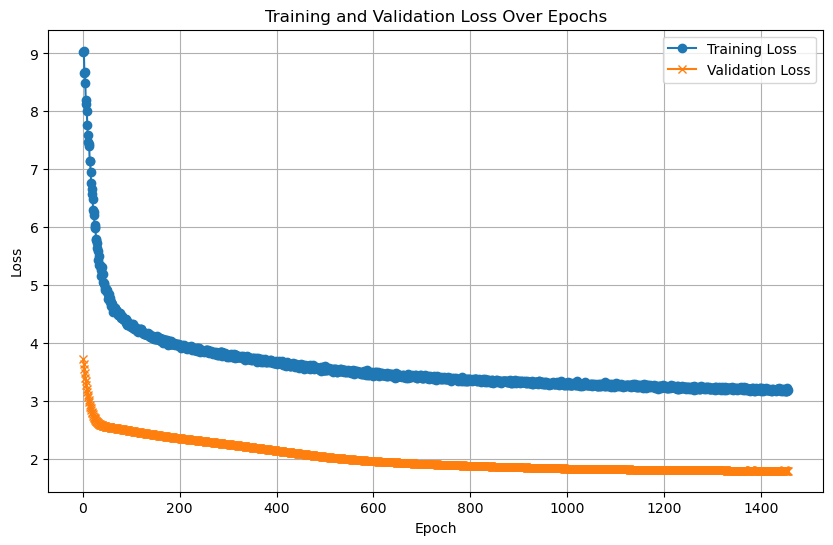

In [36]:
tscl_model = SupConNet().to(device)
tscl_criterion = SupConLoss(temperature=0.07).to(device)
tscl_optimizer = optim.Adam(tscl_model.parameters(), lr=1e-4, weight_decay=1e-5)  # Increased learning rate

tscl_patience = 100
tscl_best_val_loss = float('inf')
tscl_epochs_without_improvement = 0

tscl_num_epochs = 2000
tscl_train_losses = []
tscl_val_losses = []

# TRAINING
for tscl_epoch in range(tscl_num_epochs):
    print(f"\nLOG: Epoch [{tscl_epoch + 1}/{tscl_num_epochs}] - Training")
    tscl_model.train()
    tscl_total_loss = 0

    for batch_idx, (vectors, labels) in enumerate(tscl_train_loader):
        vectors = vectors.to(device).float()  # moving input tensors to GPU
        labels = labels.to(device)  # moving labels to GPU

        # forward pass to get projections
        projections = tscl_model(vectors)

        # calc contrastive loss
        loss = tscl_criterion(projections, labels)

        # backprop and optimization
        tscl_optimizer.zero_grad()
        loss.backward()
        tscl_optimizer.step()

        tscl_total_loss += loss.item()

        if (batch_idx + 1) % 1 == 0:
            print(f"    Batch [{batch_idx + 1}/{len(tscl_train_loader)}], "
                  f"Train Loss: {loss.item():.4f}")

    # calc avg training loss for the epoch
    tscl_avg_train_loss = tscl_total_loss / len(tscl_train_loader)
    tscl_train_losses.append(tscl_avg_train_loss)
    print(f"Epoch [{tscl_epoch + 1}/{tscl_num_epochs}], "
          f"Avg Train Loss: {tscl_avg_train_loss:.4f}")

    # VALIDATION
    tscl_model.eval()
    total_val_loss = 0.0

    with torch.no_grad():
        for batch_idx, (vectors, labels) in enumerate(tscl_val_loader):
            vectors = vectors.to(device).float()
            labels = labels.to(device)

            projections = tscl_model(vectors)

            loss = tscl_criterion(projections, labels)
            total_val_loss += loss.item()

            if (batch_idx + 1) % 10 == 0:
                print(f"    Batch [{batch_idx + 1}/{len(tscl_val_loader)}], "
                      f"Val Loss: {loss.item():.4f}")

    tscl_avg_val_loss = total_val_loss / len(tscl_val_loader)
    tscl_val_losses.append(tscl_avg_val_loss)
    print(f"Epoch [{tscl_epoch + 1}/{tscl_num_epochs}], "
          f"Avg Val Loss: {tscl_avg_val_loss:.4f}")

    # early stopping logic
    if tscl_avg_val_loss < tscl_best_val_loss:
        print(f"Validation loss improved from {tscl_best_val_loss:.4f} to {tscl_avg_val_loss:.4f}. Saving model...")
        tscl_best_val_loss = tscl_avg_val_loss
        tscl_epochs_without_improvement = 0
    else:
        tscl_epochs_without_improvement += 1
        print(f"Validation loss did not improve. Patience: {tscl_epochs_without_improvement}/{tscl_patience}")

    # stopping training if validation loss hasn't improved for patience amount of epochs
    if tscl_epochs_without_improvement >= tscl_patience:
        print(f"Early stopping triggered at epoch {tscl_epoch + 1}. No improvement for {tscl_patience} epochs.")
        break

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(tscl_train_losses) + 1), tscl_train_losses, label="Training Loss", marker='o')
plt.plot(range(1, len(tscl_val_losses) + 1), tscl_val_losses, label="Validation Loss", marker='x')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid()
plt.show()

Test Batch [10/578], Loss: 4.4255
Test Batch [20/578], Loss: 4.1479
Test Batch [30/578], Loss: 4.2860
Test Batch [40/578], Loss: 4.2287
Test Batch [50/578], Loss: 4.2121
Test Batch [60/578], Loss: 4.1883
Test Batch [70/578], Loss: 4.0046
Test Batch [80/578], Loss: 4.5075
Test Batch [90/578], Loss: 4.7342
Test Batch [100/578], Loss: 4.0875
Test Batch [110/578], Loss: 4.2878
Test Batch [120/578], Loss: 4.1036
Test Batch [130/578], Loss: 4.0804
Test Batch [140/578], Loss: 4.0535
Test Batch [150/578], Loss: 4.1449
Test Batch [160/578], Loss: 4.2711


Test Batch [170/578], Loss: 4.3565
Test Batch [180/578], Loss: 4.1781
Test Batch [190/578], Loss: 4.2561
Test Batch [200/578], Loss: 4.1482
Test Batch [210/578], Loss: 4.2993
Test Batch [220/578], Loss: 4.3367
Test Batch [230/578], Loss: 4.1831
Test Batch [240/578], Loss: 4.2576
Test Batch [250/578], Loss: 4.3067
Test Batch [260/578], Loss: 4.1978
Test Batch [270/578], Loss: 4.3997
Test Batch [280/578], Loss: 4.2303
Test Batch [290/578], Loss: 4.3367
Test Batch [300/578], Loss: 4.4963
Test Batch [310/578], Loss: 4.6184


Test Batch [320/578], Loss: 4.6449
Test Batch [330/578], Loss: 4.8133
Test Batch [340/578], Loss: 4.8534
Test Batch [350/578], Loss: 4.9116
Test Batch [360/578], Loss: 4.8956
Test Batch [370/578], Loss: 5.0153
Test Batch [380/578], Loss: 3.9383
Test Batch [390/578], Loss: 5.0056
Test Batch [400/578], Loss: 5.1204
Test Batch [410/578], Loss: 5.2093
Test Batch [420/578], Loss: 4.9458
Test Batch [430/578], Loss: 4.8256
Test Batch [440/578], Loss: 4.9346
Test Batch [450/578], Loss: 4.8154


Test Batch [460/578], Loss: 4.9353
Test Batch [470/578], Loss: 4.8121
Test Batch [480/578], Loss: 4.1429
Test Batch [490/578], Loss: 4.9810
Test Batch [500/578], Loss: 4.8199
Test Batch [510/578], Loss: 4.9694
Test Batch [520/578], Loss: 4.8865
Test Batch [530/578], Loss: 6.1253
Test Batch [540/578], Loss: 4.4616
Test Batch [550/578], Loss: 4.1208
Test Batch [560/578], Loss: 3.8879
Test Batch [570/578], Loss: 4.0622

Test Loss: 4.4808


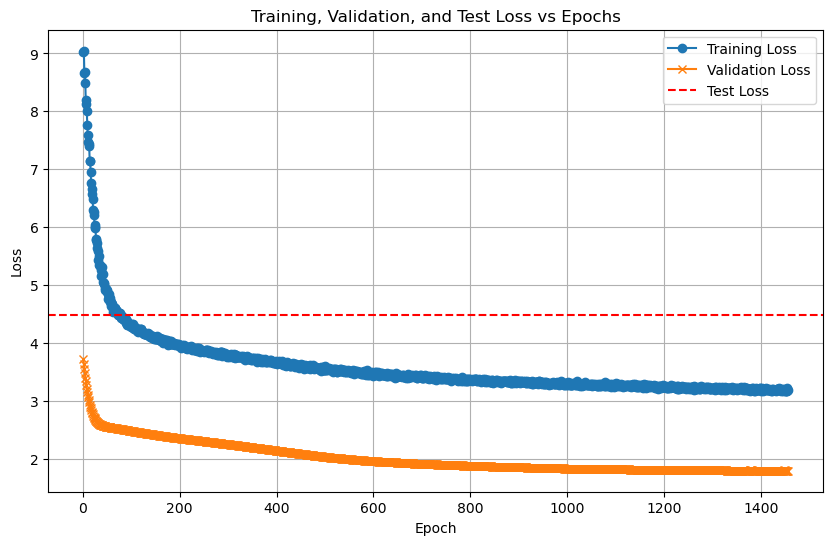

In [37]:
# Test Evaluation
tscl_model.eval()
total_test_loss = 0.0

with torch.no_grad():
    for batch_idx, (vectors, labels) in enumerate(tscl_test_loader):
        vectors = vectors.to(device).float()
        labels = labels.to(device)
        projections = tscl_model(vectors)
        loss = criterion(projections, labels)
        total_test_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:
            print(f"Test Batch [{batch_idx + 1}/{len(tscl_test_loader)}], Loss: {loss.item():.4f}")

avg_test_loss = total_test_loss / len(tscl_test_loader)
print(f"\nTest Loss: {avg_test_loss:.4f}")


plt.figure(figsize=(10, 6))
epochs = range(1, len(tscl_train_losses) + 1)
plt.plot(epochs, tscl_train_losses, label="Training Loss", marker='o')
plt.plot(epochs, tscl_val_losses, label="Validation Loss", marker='x')
# test loss = horizontal dashed line
plt.axhline(y=avg_test_loss, color='r', linestyle='--', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

### Saving representations learnt by Typical SCL Model

In [38]:
# dir to save the SCL representations
tscl_rep_dir = "tscl_representations"
os.makedirs(tscl_rep_dir, exist_ok=True)

tscl_loaders = {
    'train': tscl_train_loader,
    'val': tscl_val_loader,
    'test': tscl_test_loader
}

tscl_model.eval()

with torch.no_grad():
    for tscl_split_name, tscl_loader in tscl_loaders.items():
        print(f"\nExtracting SCL representations for the {tscl_split_name} dataset...")
        # creating subfolder for the split
        tscl_split_dir = os.path.join(tscl_rep_dir, tscl_split_name)
        os.makedirs(tscl_split_dir, exist_ok=True)
        
        # processing the data batch-wise
        for tscl_batch_idx, (tscl_vectors, tscl_labels) in enumerate(tscl_loader):
            tscl_vectors = tscl_vectors.to(device).float()
            # computing projections using the trained SCL model
            tscl_projections = tscl_model(tscl_vectors)
            
            # converting projections and labels to np arrays
            tscl_projections_np = tscl_projections.cpu().numpy()
            tscl_labels_np = tscl_labels.cpu().numpy()
            
            # saving the batch projections and labels
            np.save(os.path.join(tscl_split_dir, f"scl_encoded_batch_{tscl_batch_idx}.npy"), tscl_projections_np)
            np.save(os.path.join(tscl_split_dir, f"scl_labels_batch_{tscl_batch_idx}.npy"), tscl_labels_np)
            
            if (tscl_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {tscl_batch_idx + 1}/{len(tscl_loader)} for {tscl_split_name} dataset.")

        print(f"Completed extraction for the {tscl_split_name} dataset. Representations saved in '{tscl_split_dir}'.")

print("SCL representations extraction complete.")


Extracting SCL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'tscl_representations\train'.

Extracting SCL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'tscl_representations\val'.

Extracting SCL representations for the test dataset...
  Processed batch 10/578 for test dataset.
  Processed batch 20/578 for test dataset.
  Processed batch 30/578 for test dataset.
  Processed batch 40/578 for test dataset.
  Processed batch 50/578 for test dataset.


  Processed batch 60/578 for test dataset.
  Processed batch 70/578 for test dataset.
  Processed batch 80/578 for test dataset.
  Processed batch 90/578 for test dataset.
  Processed batch 100/578 for test dataset.
  Processed batch 110/578 for test dataset.


  Processed batch 120/578 for test dataset.
  Processed batch 130/578 for test dataset.
  Processed batch 140/578 for test dataset.
  Processed batch 150/578 for test dataset.
  Processed batch 160/578 for test dataset.
  Processed batch 170/578 for test dataset.
  Processed batch 180/578 for test dataset.


  Processed batch 190/578 for test dataset.
  Processed batch 200/578 for test dataset.
  Processed batch 210/578 for test dataset.
  Processed batch 220/578 for test dataset.
  Processed batch 230/578 for test dataset.
  Processed batch 240/578 for test dataset.
  Processed batch 250/578 for test dataset.


  Processed batch 260/578 for test dataset.
  Processed batch 270/578 for test dataset.
  Processed batch 280/578 for test dataset.
  Processed batch 290/578 for test dataset.
  Processed batch 300/578 for test dataset.
  Processed batch 310/578 for test dataset.
  Processed batch 320/578 for test dataset.


  Processed batch 330/578 for test dataset.
  Processed batch 340/578 for test dataset.
  Processed batch 350/578 for test dataset.
  Processed batch 360/578 for test dataset.
  Processed batch 370/578 for test dataset.
  Processed batch 380/578 for test dataset.
  Processed batch 390/578 for test dataset.


  Processed batch 400/578 for test dataset.
  Processed batch 410/578 for test dataset.
  Processed batch 420/578 for test dataset.
  Processed batch 430/578 for test dataset.
  Processed batch 440/578 for test dataset.
  Processed batch 450/578 for test dataset.
  Processed batch 460/578 for test dataset.


  Processed batch 470/578 for test dataset.
  Processed batch 480/578 for test dataset.
  Processed batch 490/578 for test dataset.
  Processed batch 500/578 for test dataset.
  Processed batch 510/578 for test dataset.
  Processed batch 520/578 for test dataset.
  Processed batch 530/578 for test dataset.


  Processed batch 540/578 for test dataset.
  Processed batch 550/578 for test dataset.
  Processed batch 560/578 for test dataset.
  Processed batch 570/578 for test dataset.
Completed extraction for the test dataset. Representations saved in 'tscl_representations\test'.
SCL representations extraction complete.


### Classifying representations learnt by SCL Model with LRM

In [39]:
def load_tscl_reps_and_labels(split_dir):
    #gather all the scl_encoded_batch npy files in sorted order
    tscl_rep_files = sorted(glob.glob(os.path.join(split_dir, "scl_encoded_batch_*.npy")))

    tscl_all_reps = []
    tscl_all_labels = []

    for tscl_rep_file in tscl_rep_files:
        #deriving label filenames
        tscl_label_file = tscl_rep_file.replace("scl_encoded_batch_", "scl_labels_batch_")

        tscl_reps = np.load(tscl_rep_file)
        tscl_labels = np.load(tscl_label_file)

        tscl_all_reps.append(tscl_reps)
        tscl_all_labels.append(tscl_labels)

    #concat along first dim
    tscl_all_reps = np.concatenate(tscl_all_reps, axis = 0)
    tscl_all_labels = np.concatenate(tscl_all_labels, axis = 0)

    return tscl_all_reps, tscl_all_labels

In [40]:
tscl_lrm_train_dir = os.path.join("tscl_representations", "train")
tscl_lrm_val_dir   = os.path.join("tscl_representations", "val")
tscl_lrm_test_dir  = os.path.join("tscl_representations", "test")

tscl_lrm_train_reps, tscl_lrm_train_labels = load_tscl_reps_and_labels(tscl_lrm_train_dir)
tscl_lrm_val_reps, tscl_lrm_val_labels = load_tscl_reps_and_labels(tscl_lrm_val_dir)
tscl_lrm_test_reps, tscl_lrm_test_labels = load_tscl_reps_and_labels(tscl_lrm_test_dir)

print("Train reps shape:", tscl_lrm_train_reps.shape)
print("Train labels shape:", tscl_lrm_train_labels.shape)

print("Val reps shape:", tscl_lrm_val_reps.shape)
print("Val labels shape:", tscl_lrm_val_labels.shape)

print("Test reps shape:", tscl_lrm_test_reps.shape)
print("Test labels shape:", tscl_lrm_test_labels.shape)

Train reps shape: (360, 128)
Train labels shape: (360,)
Val reps shape: (45, 128)
Val labels shape: (45,)
Test reps shape: (147747, 128)
Test labels shape: (147747,)


In [41]:
# training LRM on the tscl representations
print("\nLOG: Training Logistic Regression model on SCL SDL representations...")
tscl_logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')
tscl_logistic_clf.fit(tscl_lrm_train_reps, tscl_lrm_train_labels)
print("LOG: Logistic Regression training complete.")

# eval on val set
print("\nLOG: Evaluating on the validation set...")
tscl_lrm_val_predictions = tscl_logistic_clf.predict(tscl_lrm_val_reps)
tscl_lrm_val_accuracy = accuracy_score(tscl_lrm_val_labels, tscl_lrm_val_predictions)
print(f"Validation Accuracy: {tscl_lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(tscl_lrm_val_labels, tscl_lrm_val_predictions))

# eval on test
print("\nLOG: Evaluating on the test set...")
tscl_lrm_test_predictions = tscl_logistic_clf.predict(tscl_lrm_test_reps)
tscl_lrm_test_accuracy = accuracy_score(tscl_lrm_test_labels, tscl_lrm_test_predictions)
print(f"Test Accuracy: {tscl_lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(tscl_lrm_test_labels, tscl_lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'tscl_lrm_predictions.npy'), tscl_lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'tscl_lrm_true_labels.npy'), tscl_lrm_test_labels)
print(f"Saved CAE+LRM predictions and true labels to {predictions_dir}")


LOG: Training Logistic Regression model on SCL SDL representations...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 100.00%

Validation Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         5
           3       1.00      1.00      1.00         5
           4       1.00      1.00      1.00         5
           5       1.00      1.00      1.00         5
           6       1.00      1.00      1.00         5
           7       1.00      1.00      1.00         5
           8       1.00      1.00      1.00         5

    accuracy                           1.00        45
   macro avg       1.00      1.00      1.00        45
weighted avg       1.00      1.00      1.00        45


LOG: Evaluating on the test set...
Test Accuracy: 96.89%



Test Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     65926
           1       0.99      0.88      0.93      7553
           2       0.75      0.90      0.82      3045
           3       0.63      0.96      0.76      2640
           4       0.93      0.86      0.89      6539
           5       0.89      0.95      0.92      9203
           6       0.94      0.87      0.90      7242
           7       1.00      0.99      0.99     42781
           8       0.95      0.99      0.97      2818

    accuracy                           0.97    147747
   macro avg       0.90      0.93      0.91    147747
weighted avg       0.97      0.97      0.97    147747

Saved CAE+LRM predictions and true labels to model_predictions


### Classifying the representations learnt by Typical SCL Model with MLP Classifier

In [42]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules(): 
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [43]:
tscl_mlp_train_dir = os.path.join("tscl_representations", "train")
tscl_mlp_val_dir   = os.path.join("tscl_representations", "val")
tscl_mlp_test_dir  = os.path.join("tscl_representations", "test")

tscl_mlp_train_reps, tscl_mlp_train_labels = load_tscl_reps_and_labels(tscl_mlp_train_dir)
tscl_mlp_val_reps, tscl_mlp_val_labels = load_tscl_reps_and_labels(tscl_mlp_val_dir)
tscl_mlp_test_reps, tscl_mlp_test_labels = load_tscl_reps_and_labels(tscl_mlp_test_dir)

print("Train reps shape:",tscl_mlp_train_reps.shape)
print("Train labels shape:", tscl_mlp_train_labels.shape)

print("Val reps shape:", tscl_mlp_val_reps.shape)
print("Val labels shape:", tscl_mlp_val_labels.shape)

print("Test reps shape:", tscl_mlp_test_reps.shape)
print("Test labels shape:", tscl_mlp_test_labels.shape)

Train reps shape: (360, 128)
Train labels shape: (360,)
Val reps shape: (45, 128)
Val labels shape: (45,)
Test reps shape: (147747, 128)
Test labels shape: (147747,)


In [44]:
#converting arrays to torch tensors
tscl_mlp_train_embeddings_torch = torch.tensor(tscl_mlp_train_reps, dtype=torch.float32)
tscl_mlp_train_labels_torch = torch.tensor(tscl_mlp_train_labels, dtype=torch.long)

tscl_mlp_val_embeddings_torch = torch.tensor(tscl_mlp_val_reps, dtype=torch.float32)
tscl_mlp_val_labels_torch = torch.tensor(tscl_mlp_val_labels, dtype=torch.long)

tscl_mlp_test_embeddings_torch = torch.tensor(tscl_mlp_test_reps, dtype=torch.float32)
tscl_mlp_test_labels_torch = torch.tensor(tscl_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
tscl_mlp_train_dataset = TensorDataset(tscl_mlp_train_embeddings_torch, tscl_mlp_train_labels_torch)
tscl_mlp_val_dataset = TensorDataset(tscl_mlp_val_embeddings_torch, tscl_mlp_val_labels_torch)
tscl_mlp_test_dataset = TensorDataset(tscl_mlp_test_embeddings_torch, tscl_mlp_test_labels_torch)

tscl_mlp_batch_size = 64
tscl_mlp_train_loader = DataLoader(tscl_mlp_train_dataset, batch_size=tscl_mlp_batch_size, shuffle=True)
tscl_mlp_val_loader = DataLoader(tscl_mlp_val_dataset, batch_size=tscl_mlp_batch_size, shuffle=False)
tscl_mlp_test_loader = DataLoader(tscl_mlp_test_dataset, batch_size=tscl_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.0214  |  Val Loss: 1.9819
Validation loss improved from inf to 1.9819.
[Epoch 2/1000] Train Loss: 1.9001  |  Val Loss: 1.8730
Validation loss improved from 1.9819 to 1.8730.
[Epoch 3/1000] Train Loss: 1.8023  |  Val Loss: 1.7929
Validation loss improved from 1.8730 to 1.7929.
[Epoch 4/1000] Train Loss: 1.7258  |  Val Loss: 1.7280
Validation loss improved from 1.7929 to 1.7280.
[Epoch 5/1000] Train Loss: 1.6626  |  Val Loss: 1.6704
Validation loss improved from 1.7280 to 1.6704.
[Epoch 6/1000] Train Loss: 1.6069  |  Val Loss: 1.6182
Validation loss improved from 1.6704 to 1.6182.
[Epoch 7/1000] Train Loss: 1.5565  |  Val Loss: 1.5697
Validation loss improved from 1.6182 to 1.5697.
[Epoch 8/1000] Train Loss: 1.5108  |  Val Loss: 1.5265
Validation loss improved from 1.5697 to 1.5265.
[Epoch 9/1000] Train Loss: 1.4685  |  Val Loss: 1.4870
Validation loss improved from 1.5265 to 1.4870.
[Epoch 10/1000] Train Loss: 1.4313  |  Val Loss: 1.4506
Validation loss impr

[Epoch 14/1000] Train Loss: 1.2952  |  Val Loss: 1.3211
Validation loss improved from 1.3515 to 1.3211.
[Epoch 15/1000] Train Loss: 1.2639  |  Val Loss: 1.2913
Validation loss improved from 1.3211 to 1.2913.
[Epoch 16/1000] Train Loss: 1.2337  |  Val Loss: 1.2621
Validation loss improved from 1.2913 to 1.2621.
[Epoch 17/1000] Train Loss: 1.2036  |  Val Loss: 1.2331
Validation loss improved from 1.2621 to 1.2331.


[Epoch 18/1000] Train Loss: 1.1734  |  Val Loss: 1.2033
Validation loss improved from 1.2331 to 1.2033.
[Epoch 19/1000] Train Loss: 1.1427  |  Val Loss: 1.1728
Validation loss improved from 1.2033 to 1.1728.
[Epoch 20/1000] Train Loss: 1.1117  |  Val Loss: 1.1417
Validation loss improved from 1.1728 to 1.1417.
[Epoch 21/1000] Train Loss: 1.0814  |  Val Loss: 1.1119
Validation loss improved from 1.1417 to 1.1119.
[Epoch 22/1000] Train Loss: 1.0529  |  Val Loss: 1.0846
Validation loss improved from 1.1119 to 1.0846.
[Epoch 23/1000] Train Loss: 1.0253  |  Val Loss: 1.0582
Validation loss improved from 1.0846 to 1.0582.
[Epoch 24/1000] Train Loss: 0.9992  |  Val Loss: 1.0323
Validation loss improved from 1.0582 to 1.0323.
[Epoch 25/1000] Train Loss: 0.9740  |  Val Loss: 1.0073
Validation loss improved from 1.0323 to 1.0073.
[Epoch 26/1000] Train Loss: 0.9488  |  Val Loss: 0.9832
Validation loss improved from 1.0073 to 0.9832.
[Epoch 27/1000] Train Loss: 0.9239  |  Val Loss: 0.9600
Validati

[Epoch 32/1000] Train Loss: 0.8086  |  Val Loss: 0.8484
Validation loss improved from 0.8697 to 0.8484.
[Epoch 33/1000] Train Loss: 0.7869  |  Val Loss: 0.8279
Validation loss improved from 0.8484 to 0.8279.
[Epoch 34/1000] Train Loss: 0.7654  |  Val Loss: 0.8078
Validation loss improved from 0.8279 to 0.8078.
[Epoch 35/1000] Train Loss: 0.7450  |  Val Loss: 0.7869
Validation loss improved from 0.8078 to 0.7869.


[Epoch 36/1000] Train Loss: 0.7236  |  Val Loss: 0.7661
Validation loss improved from 0.7869 to 0.7661.
[Epoch 37/1000] Train Loss: 0.7029  |  Val Loss: 0.7450
Validation loss improved from 0.7661 to 0.7450.
[Epoch 38/1000] Train Loss: 0.6816  |  Val Loss: 0.7249
Validation loss improved from 0.7450 to 0.7249.
[Epoch 39/1000] Train Loss: 0.6610  |  Val Loss: 0.7042
Validation loss improved from 0.7249 to 0.7042.
[Epoch 40/1000] Train Loss: 0.6403  |  Val Loss: 0.6844
Validation loss improved from 0.7042 to 0.6844.
[Epoch 41/1000] Train Loss: 0.6203  |  Val Loss: 0.6646
Validation loss improved from 0.6844 to 0.6646.
[Epoch 42/1000] Train Loss: 0.6009  |  Val Loss: 0.6450
Validation loss improved from 0.6646 to 0.6450.
[Epoch 43/1000] Train Loss: 0.5819  |  Val Loss: 0.6262
Validation loss improved from 0.6450 to 0.6262.
[Epoch 44/1000] Train Loss: 0.5638  |  Val Loss: 0.6079
Validation loss improved from 0.6262 to 0.6079.
[Epoch 45/1000] Train Loss: 0.5451  |  Val Loss: 0.5898
Validati

[Epoch 49/1000] Train Loss: 0.4767  |  Val Loss: 0.5225
Validation loss improved from 0.5385 to 0.5225.
[Epoch 50/1000] Train Loss: 0.4612  |  Val Loss: 0.5069
Validation loss improved from 0.5225 to 0.5069.
[Epoch 51/1000] Train Loss: 0.4449  |  Val Loss: 0.4912
Validation loss improved from 0.5069 to 0.4912.
[Epoch 52/1000] Train Loss: 0.4298  |  Val Loss: 0.4759
Validation loss improved from 0.4912 to 0.4759.
[Epoch 53/1000] Train Loss: 0.4153  |  Val Loss: 0.4610
Validation loss improved from 0.4759 to 0.4610.


[Epoch 54/1000] Train Loss: 0.4009  |  Val Loss: 0.4468
Validation loss improved from 0.4610 to 0.4468.
[Epoch 55/1000] Train Loss: 0.3873  |  Val Loss: 0.4330
Validation loss improved from 0.4468 to 0.4330.
[Epoch 56/1000] Train Loss: 0.3737  |  Val Loss: 0.4197
Validation loss improved from 0.4330 to 0.4197.
[Epoch 57/1000] Train Loss: 0.3606  |  Val Loss: 0.4068
Validation loss improved from 0.4197 to 0.4068.
[Epoch 58/1000] Train Loss: 0.3484  |  Val Loss: 0.3943
Validation loss improved from 0.4068 to 0.3943.
[Epoch 59/1000] Train Loss: 0.3361  |  Val Loss: 0.3820
Validation loss improved from 0.3943 to 0.3820.
[Epoch 60/1000] Train Loss: 0.3247  |  Val Loss: 0.3701
Validation loss improved from 0.3820 to 0.3701.
[Epoch 61/1000] Train Loss: 0.3134  |  Val Loss: 0.3587
Validation loss improved from 0.3701 to 0.3587.
[Epoch 62/1000] Train Loss: 0.3026  |  Val Loss: 0.3476
Validation loss improved from 0.3587 to 0.3476.
[Epoch 63/1000] Train Loss: 0.2921  |  Val Loss: 0.3370
Validati

[Epoch 66/1000] Train Loss: 0.2628  |  Val Loss: 0.3066
Validation loss improved from 0.3166 to 0.3066.
[Epoch 67/1000] Train Loss: 0.2532  |  Val Loss: 0.2972
Validation loss improved from 0.3066 to 0.2972.
[Epoch 68/1000] Train Loss: 0.2447  |  Val Loss: 0.2878
Validation loss improved from 0.2972 to 0.2878.
[Epoch 69/1000] Train Loss: 0.2363  |  Val Loss: 0.2790
Validation loss improved from 0.2878 to 0.2790.
[Epoch 70/1000] Train Loss: 0.2283  |  Val Loss: 0.2706
Validation loss improved from 0.2790 to 0.2706.


[Epoch 71/1000] Train Loss: 0.2204  |  Val Loss: 0.2627
Validation loss improved from 0.2706 to 0.2627.
[Epoch 72/1000] Train Loss: 0.2130  |  Val Loss: 0.2547
Validation loss improved from 0.2627 to 0.2547.
[Epoch 73/1000] Train Loss: 0.2057  |  Val Loss: 0.2471
Validation loss improved from 0.2547 to 0.2471.
[Epoch 74/1000] Train Loss: 0.1988  |  Val Loss: 0.2398
Validation loss improved from 0.2471 to 0.2398.
[Epoch 75/1000] Train Loss: 0.1925  |  Val Loss: 0.2326
Validation loss improved from 0.2398 to 0.2326.
[Epoch 76/1000] Train Loss: 0.1860  |  Val Loss: 0.2257
Validation loss improved from 0.2326 to 0.2257.
[Epoch 77/1000] Train Loss: 0.1799  |  Val Loss: 0.2193
Validation loss improved from 0.2257 to 0.2193.
[Epoch 78/1000] Train Loss: 0.1741  |  Val Loss: 0.2129
Validation loss improved from 0.2193 to 0.2129.
[Epoch 79/1000] Train Loss: 0.1685  |  Val Loss: 0.2068
Validation loss improved from 0.2129 to 0.2068.
[Epoch 80/1000] Train Loss: 0.1632  |  Val Loss: 0.2011
Validati

[Epoch 83/1000] Train Loss: 0.1486  |  Val Loss: 0.1845
Validation loss improved from 0.1898 to 0.1845.
[Epoch 84/1000] Train Loss: 0.1437  |  Val Loss: 0.1798
Validation loss improved from 0.1845 to 0.1798.
[Epoch 85/1000] Train Loss: 0.1395  |  Val Loss: 0.1752
Validation loss improved from 0.1798 to 0.1752.


[Epoch 86/1000] Train Loss: 0.1354  |  Val Loss: 0.1703
Validation loss improved from 0.1752 to 0.1703.
[Epoch 87/1000] Train Loss: 0.1314  |  Val Loss: 0.1657
Validation loss improved from 0.1703 to 0.1657.
[Epoch 88/1000] Train Loss: 0.1274  |  Val Loss: 0.1616
Validation loss improved from 0.1657 to 0.1616.
[Epoch 89/1000] Train Loss: 0.1237  |  Val Loss: 0.1575
Validation loss improved from 0.1616 to 0.1575.
[Epoch 90/1000] Train Loss: 0.1203  |  Val Loss: 0.1536
Validation loss improved from 0.1575 to 0.1536.
[Epoch 91/1000] Train Loss: 0.1167  |  Val Loss: 0.1498
Validation loss improved from 0.1536 to 0.1498.
[Epoch 92/1000] Train Loss: 0.1134  |  Val Loss: 0.1462
Validation loss improved from 0.1498 to 0.1462.
[Epoch 93/1000] Train Loss: 0.1101  |  Val Loss: 0.1425
Validation loss improved from 0.1462 to 0.1425.
[Epoch 94/1000] Train Loss: 0.1071  |  Val Loss: 0.1390
Validation loss improved from 0.1425 to 0.1390.
[Epoch 95/1000] Train Loss: 0.1042  |  Val Loss: 0.1357
Validati

[Epoch 100/1000] Train Loss: 0.0910  |  Val Loss: 0.1206
Validation loss improved from 0.1235 to 0.1206.


[Epoch 101/1000] Train Loss: 0.0885  |  Val Loss: 0.1179
Validation loss improved from 0.1206 to 0.1179.
[Epoch 102/1000] Train Loss: 0.0862  |  Val Loss: 0.1153
Validation loss improved from 0.1179 to 0.1153.
[Epoch 103/1000] Train Loss: 0.0840  |  Val Loss: 0.1130
Validation loss improved from 0.1153 to 0.1130.
[Epoch 104/1000] Train Loss: 0.0818  |  Val Loss: 0.1107
Validation loss improved from 0.1130 to 0.1107.
[Epoch 105/1000] Train Loss: 0.0797  |  Val Loss: 0.1083
Validation loss improved from 0.1107 to 0.1083.
[Epoch 106/1000] Train Loss: 0.0777  |  Val Loss: 0.1059
Validation loss improved from 0.1083 to 0.1059.
[Epoch 107/1000] Train Loss: 0.0758  |  Val Loss: 0.1036
Validation loss improved from 0.1059 to 0.1036.
[Epoch 108/1000] Train Loss: 0.0740  |  Val Loss: 0.1016
Validation loss improved from 0.1036 to 0.1016.
[Epoch 109/1000] Train Loss: 0.0722  |  Val Loss: 0.0994
Validation loss improved from 0.1016 to 0.0994.
[Epoch 110/1000] Train Loss: 0.0705  |  Val Loss: 0.097

[Epoch 116/1000] Train Loss: 0.0613  |  Val Loss: 0.0867
Validation loss improved from 0.0885 to 0.0867.
[Epoch 117/1000] Train Loss: 0.0599  |  Val Loss: 0.0851
Validation loss improved from 0.0867 to 0.0851.
[Epoch 118/1000] Train Loss: 0.0585  |  Val Loss: 0.0836
Validation loss improved from 0.0851 to 0.0836.
[Epoch 119/1000] Train Loss: 0.0573  |  Val Loss: 0.0820
Validation loss improved from 0.0836 to 0.0820.
[Epoch 120/1000] Train Loss: 0.0561  |  Val Loss: 0.0807
Validation loss improved from 0.0820 to 0.0807.
[Epoch 121/1000] Train Loss: 0.0549  |  Val Loss: 0.0792
Validation loss improved from 0.0807 to 0.0792.
[Epoch 122/1000] Train Loss: 0.0537  |  Val Loss: 0.0778
Validation loss improved from 0.0792 to 0.0778.
[Epoch 123/1000] Train Loss: 0.0525  |  Val Loss: 0.0766
Validation loss improved from 0.0778 to 0.0766.
[Epoch 124/1000] Train Loss: 0.0515  |  Val Loss: 0.0754
Validation loss improved from 0.0766 to 0.0754.
[Epoch 125/1000] Train Loss: 0.0505  |  Val Loss: 0.074

[Epoch 133/1000] Train Loss: 0.0431  |  Val Loss: 0.0656
Validation loss improved from 0.0664 to 0.0656.
[Epoch 134/1000] Train Loss: 0.0422  |  Val Loss: 0.0646
Validation loss improved from 0.0656 to 0.0646.
[Epoch 135/1000] Train Loss: 0.0415  |  Val Loss: 0.0635
Validation loss improved from 0.0646 to 0.0635.
[Epoch 136/1000] Train Loss: 0.0407  |  Val Loss: 0.0626
Validation loss improved from 0.0635 to 0.0626.
[Epoch 137/1000] Train Loss: 0.0400  |  Val Loss: 0.0617
Validation loss improved from 0.0626 to 0.0617.
[Epoch 138/1000] Train Loss: 0.0392  |  Val Loss: 0.0610
Validation loss improved from 0.0617 to 0.0610.
[Epoch 139/1000] Train Loss: 0.0386  |  Val Loss: 0.0600
Validation loss improved from 0.0610 to 0.0600.
[Epoch 140/1000] Train Loss: 0.0379  |  Val Loss: 0.0592
Validation loss improved from 0.0600 to 0.0592.
[Epoch 141/1000] Train Loss: 0.0372  |  Val Loss: 0.0583
Validation loss improved from 0.0592 to 0.0583.
[Epoch 142/1000] Train Loss: 0.0365  |  Val Loss: 0.057

[Epoch 149/1000] Train Loss: 0.0323  |  Val Loss: 0.0523
Validation loss improved from 0.0531 to 0.0523.
[Epoch 150/1000] Train Loss: 0.0318  |  Val Loss: 0.0516
Validation loss improved from 0.0523 to 0.0516.
[Epoch 151/1000] Train Loss: 0.0313  |  Val Loss: 0.0511
Validation loss improved from 0.0516 to 0.0511.
[Epoch 152/1000] Train Loss: 0.0307  |  Val Loss: 0.0506
Validation loss improved from 0.0511 to 0.0506.
[Epoch 153/1000] Train Loss: 0.0302  |  Val Loss: 0.0500
Validation loss improved from 0.0506 to 0.0500.
[Epoch 154/1000] Train Loss: 0.0298  |  Val Loss: 0.0494
Validation loss improved from 0.0500 to 0.0494.
[Epoch 155/1000] Train Loss: 0.0292  |  Val Loss: 0.0489
Validation loss improved from 0.0494 to 0.0489.
[Epoch 156/1000] Train Loss: 0.0288  |  Val Loss: 0.0484
Validation loss improved from 0.0489 to 0.0484.
[Epoch 157/1000] Train Loss: 0.0283  |  Val Loss: 0.0479
Validation loss improved from 0.0484 to 0.0479.
[Epoch 158/1000] Train Loss: 0.0279  |  Val Loss: 0.047

[Epoch 167/1000] Train Loss: 0.0240  |  Val Loss: 0.0425
Validation loss improved from 0.0430 to 0.0425.
[Epoch 168/1000] Train Loss: 0.0236  |  Val Loss: 0.0421
Validation loss improved from 0.0425 to 0.0421.
[Epoch 169/1000] Train Loss: 0.0232  |  Val Loss: 0.0417
Validation loss improved from 0.0421 to 0.0417.
[Epoch 170/1000] Train Loss: 0.0229  |  Val Loss: 0.0415
Validation loss improved from 0.0417 to 0.0415.
[Epoch 171/1000] Train Loss: 0.0226  |  Val Loss: 0.0411
Validation loss improved from 0.0415 to 0.0411.
[Epoch 172/1000] Train Loss: 0.0222  |  Val Loss: 0.0407
Validation loss improved from 0.0411 to 0.0407.
[Epoch 173/1000] Train Loss: 0.0219  |  Val Loss: 0.0403
Validation loss improved from 0.0407 to 0.0403.
[Epoch 174/1000] Train Loss: 0.0216  |  Val Loss: 0.0399
Validation loss improved from 0.0403 to 0.0399.
[Epoch 175/1000] Train Loss: 0.0213  |  Val Loss: 0.0394
Validation loss improved from 0.0399 to 0.0394.
[Epoch 176/1000] Train Loss: 0.0210  |  Val Loss: 0.039

[Epoch 185/1000] Train Loss: 0.0185  |  Val Loss: 0.0362
Validation loss improved from 0.0365 to 0.0362.
[Epoch 186/1000] Train Loss: 0.0183  |  Val Loss: 0.0357
Validation loss improved from 0.0362 to 0.0357.
[Epoch 187/1000] Train Loss: 0.0180  |  Val Loss: 0.0354
Validation loss improved from 0.0357 to 0.0354.
[Epoch 188/1000] Train Loss: 0.0178  |  Val Loss: 0.0351
Validation loss improved from 0.0354 to 0.0351.
[Epoch 189/1000] Train Loss: 0.0175  |  Val Loss: 0.0347
Validation loss improved from 0.0351 to 0.0347.
[Epoch 190/1000] Train Loss: 0.0173  |  Val Loss: 0.0345
Validation loss improved from 0.0347 to 0.0345.
[Epoch 191/1000] Train Loss: 0.0171  |  Val Loss: 0.0342
Validation loss improved from 0.0345 to 0.0342.
[Epoch 192/1000] Train Loss: 0.0169  |  Val Loss: 0.0340
Validation loss improved from 0.0342 to 0.0340.
[Epoch 193/1000] Train Loss: 0.0167  |  Val Loss: 0.0338
Validation loss improved from 0.0340 to 0.0338.
[Epoch 194/1000] Train Loss: 0.0164  |  Val Loss: 0.033

[Epoch 200/1000] Train Loss: 0.0152  |  Val Loss: 0.0318
Validation loss improved from 0.0320 to 0.0318.
[Epoch 201/1000] Train Loss: 0.0150  |  Val Loss: 0.0316
Validation loss improved from 0.0318 to 0.0316.
[Epoch 202/1000] Train Loss: 0.0148  |  Val Loss: 0.0313
Validation loss improved from 0.0316 to 0.0313.
[Epoch 203/1000] Train Loss: 0.0147  |  Val Loss: 0.0311
Validation loss improved from 0.0313 to 0.0311.
[Epoch 204/1000] Train Loss: 0.0145  |  Val Loss: 0.0308
Validation loss improved from 0.0311 to 0.0308.
[Epoch 205/1000] Train Loss: 0.0143  |  Val Loss: 0.0305
Validation loss improved from 0.0308 to 0.0305.
[Epoch 206/1000] Train Loss: 0.0142  |  Val Loss: 0.0303
Validation loss improved from 0.0305 to 0.0303.
[Epoch 207/1000] Train Loss: 0.0140  |  Val Loss: 0.0300
Validation loss improved from 0.0303 to 0.0300.
[Epoch 208/1000] Train Loss: 0.0138  |  Val Loss: 0.0298
Validation loss improved from 0.0300 to 0.0298.
[Epoch 209/1000] Train Loss: 0.0137  |  Val Loss: 0.029

[Epoch 217/1000] Train Loss: 0.0124  |  Val Loss: 0.0281
Validation loss improved from 0.0283 to 0.0281.
[Epoch 218/1000] Train Loss: 0.0123  |  Val Loss: 0.0278
Validation loss improved from 0.0281 to 0.0278.
[Epoch 219/1000] Train Loss: 0.0122  |  Val Loss: 0.0277
Validation loss improved from 0.0278 to 0.0277.
[Epoch 220/1000] Train Loss: 0.0120  |  Val Loss: 0.0275
Validation loss improved from 0.0277 to 0.0275.
[Epoch 221/1000] Train Loss: 0.0119  |  Val Loss: 0.0274
Validation loss improved from 0.0275 to 0.0274.
[Epoch 222/1000] Train Loss: 0.0118  |  Val Loss: 0.0272
Validation loss improved from 0.0274 to 0.0272.
[Epoch 223/1000] Train Loss: 0.0116  |  Val Loss: 0.0271
Validation loss improved from 0.0272 to 0.0271.
[Epoch 224/1000] Train Loss: 0.0115  |  Val Loss: 0.0268
Validation loss improved from 0.0271 to 0.0268.
[Epoch 225/1000] Train Loss: 0.0114  |  Val Loss: 0.0268
Validation loss improved from 0.0268 to 0.0268.
[Epoch 226/1000] Train Loss: 0.0113  |  Val Loss: 0.026

[Epoch 234/1000] Train Loss: 0.0103  |  Val Loss: 0.0256
Validation loss improved from 0.0257 to 0.0256.
[Epoch 235/1000] Train Loss: 0.0102  |  Val Loss: 0.0252
Validation loss improved from 0.0256 to 0.0252.
[Epoch 236/1000] Train Loss: 0.0101  |  Val Loss: 0.0250
Validation loss improved from 0.0252 to 0.0250.
[Epoch 237/1000] Train Loss: 0.0100  |  Val Loss: 0.0248
Validation loss improved from 0.0250 to 0.0248.
[Epoch 238/1000] Train Loss: 0.0099  |  Val Loss: 0.0247
Validation loss improved from 0.0248 to 0.0247.
[Epoch 239/1000] Train Loss: 0.0098  |  Val Loss: 0.0244
Validation loss improved from 0.0247 to 0.0244.
[Epoch 240/1000] Train Loss: 0.0097  |  Val Loss: 0.0245
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 241/1000] Train Loss: 0.0096  |  Val Loss: 0.0243
Validation loss improved from 0.0244 to 0.0243.
[Epoch 242/1000] Train Loss: 0.0095  |  Val Loss: 0.0242
Validation loss improved from 0.0243 to 0.0242.
[Epoch 243/1000] Train Loss: 0.0094  |  Val Loss:

[Epoch 251/1000] Train Loss: 0.0086  |  Val Loss: 0.0230
Validation loss improved from 0.0232 to 0.0230.
[Epoch 252/1000] Train Loss: 0.0085  |  Val Loss: 0.0227
Validation loss improved from 0.0230 to 0.0227.
[Epoch 253/1000] Train Loss: 0.0084  |  Val Loss: 0.0225
Validation loss improved from 0.0227 to 0.0225.
[Epoch 254/1000] Train Loss: 0.0084  |  Val Loss: 0.0223
Validation loss improved from 0.0225 to 0.0223.
[Epoch 255/1000] Train Loss: 0.0083  |  Val Loss: 0.0222
Validation loss improved from 0.0223 to 0.0222.
[Epoch 256/1000] Train Loss: 0.0082  |  Val Loss: 0.0223
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 257/1000] Train Loss: 0.0081  |  Val Loss: 0.0222
Validation loss improved from 0.0222 to 0.0222.
[Epoch 258/1000] Train Loss: 0.0080  |  Val Loss: 0.0222
Validation loss improved from 0.0222 to 0.0222.
[Epoch 259/1000] Train Loss: 0.0079  |  Val Loss: 0.0219
Validation loss improved from 0.0222 to 0.0219.
[Epoch 260/1000] Train Loss: 0.0079  |  Val Loss:

[Epoch 268/1000] Train Loss: 0.0073  |  Val Loss: 0.0210
Validation loss improved from 0.0211 to 0.0210.
[Epoch 269/1000] Train Loss: 0.0072  |  Val Loss: 0.0209
Validation loss improved from 0.0210 to 0.0209.
[Epoch 270/1000] Train Loss: 0.0071  |  Val Loss: 0.0208
Validation loss improved from 0.0209 to 0.0208.
[Epoch 271/1000] Train Loss: 0.0071  |  Val Loss: 0.0206
Validation loss improved from 0.0208 to 0.0206.
[Epoch 272/1000] Train Loss: 0.0070  |  Val Loss: 0.0206
Validation loss improved from 0.0206 to 0.0206.
[Epoch 273/1000] Train Loss: 0.0069  |  Val Loss: 0.0204
Validation loss improved from 0.0206 to 0.0204.
[Epoch 274/1000] Train Loss: 0.0069  |  Val Loss: 0.0202
Validation loss improved from 0.0204 to 0.0202.
[Epoch 275/1000] Train Loss: 0.0068  |  Val Loss: 0.0201
Validation loss improved from 0.0202 to 0.0201.
[Epoch 276/1000] Train Loss: 0.0068  |  Val Loss: 0.0201
Validation loss improved from 0.0201 to 0.0201.
[Epoch 277/1000] Train Loss: 0.0067  |  Val Loss: 0.020

[Epoch 286/1000] Train Loss: 0.0062  |  Val Loss: 0.0192
Validation loss improved from 0.0193 to 0.0192.
[Epoch 287/1000] Train Loss: 0.0061  |  Val Loss: 0.0191
Validation loss improved from 0.0192 to 0.0191.
[Epoch 288/1000] Train Loss: 0.0061  |  Val Loss: 0.0190
Validation loss improved from 0.0191 to 0.0190.
[Epoch 289/1000] Train Loss: 0.0060  |  Val Loss: 0.0189
Validation loss improved from 0.0190 to 0.0189.
[Epoch 290/1000] Train Loss: 0.0059  |  Val Loss: 0.0188
Validation loss improved from 0.0189 to 0.0188.
[Epoch 291/1000] Train Loss: 0.0059  |  Val Loss: 0.0187
Validation loss improved from 0.0188 to 0.0187.
[Epoch 292/1000] Train Loss: 0.0058  |  Val Loss: 0.0187
Validation loss improved from 0.0187 to 0.0187.
[Epoch 293/1000] Train Loss: 0.0058  |  Val Loss: 0.0185
Validation loss improved from 0.0187 to 0.0185.
[Epoch 294/1000] Train Loss: 0.0057  |  Val Loss: 0.0184
Validation loss improved from 0.0185 to 0.0184.
[Epoch 295/1000] Train Loss: 0.0057  |  Val Loss: 0.018

[Epoch 303/1000] Train Loss: 0.0053  |  Val Loss: 0.0179
Validation loss improved from 0.0179 to 0.0179.
[Epoch 304/1000] Train Loss: 0.0053  |  Val Loss: 0.0176
Validation loss improved from 0.0179 to 0.0176.
[Epoch 305/1000] Train Loss: 0.0052  |  Val Loss: 0.0176
Validation loss improved from 0.0176 to 0.0176.
[Epoch 306/1000] Train Loss: 0.0052  |  Val Loss: 0.0175
Validation loss improved from 0.0176 to 0.0175.
[Epoch 307/1000] Train Loss: 0.0051  |  Val Loss: 0.0176
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 308/1000] Train Loss: 0.0051  |  Val Loss: 0.0175
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 309/1000] Train Loss: 0.0050  |  Val Loss: 0.0175
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 310/1000] Train Loss: 0.0050  |  Val Loss: 0.0174
Validation loss improved from 0.0175 to 0.0174.
[Epoch 311/1000] Train Loss: 0.0050  |  Val Loss: 0.0172
Validation loss improved from 0.0174 to 0.0172.
[Epoch 312/1000] Train Loss: 0.0049  

[Epoch 319/1000] Train Loss: 0.0046  |  Val Loss: 0.0167
Validation loss improved from 0.0167 to 0.0167.
[Epoch 320/1000] Train Loss: 0.0046  |  Val Loss: 0.0166
Validation loss improved from 0.0167 to 0.0166.
[Epoch 321/1000] Train Loss: 0.0046  |  Val Loss: 0.0166
Validation loss improved from 0.0166 to 0.0166.
[Epoch 322/1000] Train Loss: 0.0045  |  Val Loss: 0.0164
Validation loss improved from 0.0166 to 0.0164.
[Epoch 323/1000] Train Loss: 0.0045  |  Val Loss: 0.0164
Validation loss improved from 0.0164 to 0.0164.
[Epoch 324/1000] Train Loss: 0.0045  |  Val Loss: 0.0163
Validation loss improved from 0.0164 to 0.0163.
[Epoch 325/1000] Train Loss: 0.0044  |  Val Loss: 0.0162
Validation loss improved from 0.0163 to 0.0162.
[Epoch 326/1000] Train Loss: 0.0044  |  Val Loss: 0.0163
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 327/1000] Train Loss: 0.0043  |  Val Loss: 0.0163
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 328/1000] Train Loss: 0.0043  |  Val

[Epoch 335/1000] Train Loss: 0.0041  |  Val Loss: 0.0158
Validation loss improved from 0.0159 to 0.0158.
[Epoch 336/1000] Train Loss: 0.0040  |  Val Loss: 0.0157
Validation loss improved from 0.0158 to 0.0157.
[Epoch 337/1000] Train Loss: 0.0040  |  Val Loss: 0.0156
Validation loss improved from 0.0157 to 0.0156.
[Epoch 338/1000] Train Loss: 0.0040  |  Val Loss: 0.0155
Validation loss improved from 0.0156 to 0.0155.
[Epoch 339/1000] Train Loss: 0.0040  |  Val Loss: 0.0156
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 340/1000] Train Loss: 0.0039  |  Val Loss: 0.0155
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 341/1000] Train Loss: 0.0039  |  Val Loss: 0.0154
Validation loss improved from 0.0155 to 0.0154.
[Epoch 342/1000] Train Loss: 0.0039  |  Val Loss: 0.0153
Validation loss improved from 0.0154 to 0.0153.
[Epoch 343/1000] Train Loss: 0.0038  |  Val Loss: 0.0154
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 344/1000] Train Loss: 0.0038  

[Epoch 353/1000] Train Loss: 0.0035  |  Val Loss: 0.0147
Validation loss improved from 0.0149 to 0.0147.
[Epoch 354/1000] Train Loss: 0.0035  |  Val Loss: 0.0147
Validation loss improved from 0.0147 to 0.0147.
[Epoch 355/1000] Train Loss: 0.0035  |  Val Loss: 0.0146
Validation loss improved from 0.0147 to 0.0146.
[Epoch 356/1000] Train Loss: 0.0035  |  Val Loss: 0.0146
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 357/1000] Train Loss: 0.0034  |  Val Loss: 0.0146
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 358/1000] Train Loss: 0.0034  |  Val Loss: 0.0146
Validation loss improved from 0.0146 to 0.0146.
[Epoch 359/1000] Train Loss: 0.0034  |  Val Loss: 0.0145
Validation loss improved from 0.0146 to 0.0145.
[Epoch 360/1000] Train Loss: 0.0034  |  Val Loss: 0.0144
Validation loss improved from 0.0145 to 0.0144.
[Epoch 361/1000] Train Loss: 0.0033  |  Val Loss: 0.0144
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 362/1000] Train Loss: 0.0033  

[Epoch 371/1000] Train Loss: 0.0031  |  Val Loss: 0.0141
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 372/1000] Train Loss: 0.0031  |  Val Loss: 0.0140
Validation loss improved from 0.0141 to 0.0140.
[Epoch 373/1000] Train Loss: 0.0031  |  Val Loss: 0.0139
Validation loss improved from 0.0140 to 0.0139.
[Epoch 374/1000] Train Loss: 0.0030  |  Val Loss: 0.0139
Validation loss improved from 0.0139 to 0.0139.
[Epoch 375/1000] Train Loss: 0.0030  |  Val Loss: 0.0138
Validation loss improved from 0.0139 to 0.0138.
[Epoch 376/1000] Train Loss: 0.0030  |  Val Loss: 0.0137
Validation loss improved from 0.0138 to 0.0137.
[Epoch 377/1000] Train Loss: 0.0030  |  Val Loss: 0.0138
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 378/1000] Train Loss: 0.0030  |  Val Loss: 0.0137
Validation loss improved from 0.0137 to 0.0137.
[Epoch 379/1000] Train Loss: 0.0029  |  Val Loss: 0.0136
Validation loss improved from 0.0137 to 0.0136.
[Epoch 380/1000] Train Loss: 0.0029  |  Val

[Epoch 388/1000] Train Loss: 0.0028  |  Val Loss: 0.0133
Validation loss improved from 0.0133 to 0.0133.
[Epoch 389/1000] Train Loss: 0.0027  |  Val Loss: 0.0133
Validation loss improved from 0.0133 to 0.0133.
[Epoch 390/1000] Train Loss: 0.0027  |  Val Loss: 0.0132
Validation loss improved from 0.0133 to 0.0132.
[Epoch 391/1000] Train Loss: 0.0027  |  Val Loss: 0.0131
Validation loss improved from 0.0132 to 0.0131.
[Epoch 392/1000] Train Loss: 0.0027  |  Val Loss: 0.0130
Validation loss improved from 0.0131 to 0.0130.
[Epoch 393/1000] Train Loss: 0.0027  |  Val Loss: 0.0131
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 394/1000] Train Loss: 0.0026  |  Val Loss: 0.0131
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 395/1000] Train Loss: 0.0026  |  Val Loss: 0.0130
Validation loss improved from 0.0130 to 0.0130.
[Epoch 396/1000] Train Loss: 0.0026  |  Val Loss: 0.0129
Validation loss improved from 0.0130 to 0.0129.
[Epoch 397/1000] Train Loss: 0.0026  |  Val

[Epoch 404/1000] Train Loss: 0.0025  |  Val Loss: 0.0126
Validation loss improved from 0.0126 to 0.0126.
[Epoch 405/1000] Train Loss: 0.0025  |  Val Loss: 0.0127
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 406/1000] Train Loss: 0.0024  |  Val Loss: 0.0126
Validation loss improved from 0.0126 to 0.0126.
[Epoch 407/1000] Train Loss: 0.0024  |  Val Loss: 0.0125
Validation loss improved from 0.0126 to 0.0125.
[Epoch 408/1000] Train Loss: 0.0024  |  Val Loss: 0.0126
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 409/1000] Train Loss: 0.0024  |  Val Loss: 0.0125
Validation loss improved from 0.0125 to 0.0125.
[Epoch 410/1000] Train Loss: 0.0024  |  Val Loss: 0.0126
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 411/1000] Train Loss: 0.0024  |  Val Loss: 0.0125
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 412/1000] Train Loss: 0.0023  |  Val Loss: 0.0124
Validation loss improved from 0.0125 to 0.0124.
[Epoch 413/1000] Train Loss: 0.

[Epoch 421/1000] Train Loss: 0.0022  |  Val Loss: 0.0121
Validation loss improved from 0.0121 to 0.0121.
[Epoch 422/1000] Train Loss: 0.0022  |  Val Loss: 0.0119
Validation loss improved from 0.0121 to 0.0119.
[Epoch 423/1000] Train Loss: 0.0022  |  Val Loss: 0.0119
Validation loss improved from 0.0119 to 0.0119.
[Epoch 424/1000] Train Loss: 0.0022  |  Val Loss: 0.0119
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 425/1000] Train Loss: 0.0022  |  Val Loss: 0.0119
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 426/1000] Train Loss: 0.0021  |  Val Loss: 0.0119
Validation loss improved from 0.0119 to 0.0119.
[Epoch 427/1000] Train Loss: 0.0021  |  Val Loss: 0.0118
Validation loss improved from 0.0119 to 0.0118.
[Epoch 428/1000] Train Loss: 0.0021  |  Val Loss: 0.0118
Validation loss improved from 0.0118 to 0.0118.
[Epoch 429/1000] Train Loss: 0.0021  |  Val Loss: 0.0117
Validation loss improved from 0.0118 to 0.0117.
[Epoch 430/1000] Train Loss: 0.0021  |  Val

[Epoch 437/1000] Train Loss: 0.0020  |  Val Loss: 0.0116
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 438/1000] Train Loss: 0.0020  |  Val Loss: 0.0114
Validation loss improved from 0.0115 to 0.0114.
[Epoch 439/1000] Train Loss: 0.0020  |  Val Loss: 0.0115
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 440/1000] Train Loss: 0.0020  |  Val Loss: 0.0115
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 441/1000] Train Loss: 0.0019  |  Val Loss: 0.0114
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 442/1000] Train Loss: 0.0019  |  Val Loss: 0.0114
Validation loss improved from 0.0114 to 0.0114.
[Epoch 443/1000] Train Loss: 0.0019  |  Val Loss: 0.0113
Validation loss improved from 0.0114 to 0.0113.
[Epoch 444/1000] Train Loss: 0.0019  |  Val Loss: 0.0113
Validation loss improved from 0.0113 to 0.0113.
[Epoch 445/1000] Train Loss: 0.0019  |  Val Loss: 0.0113
Validation loss improved from 0.0113 to 0.0113.
[Epoch 446/1000] Train Loss: 0.

[Epoch 453/1000] Train Loss: 0.0018  |  Val Loss: 0.0110
Validation loss improved from 0.0111 to 0.0110.
[Epoch 454/1000] Train Loss: 0.0018  |  Val Loss: 0.0110
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 455/1000] Train Loss: 0.0018  |  Val Loss: 0.0110
Validation loss improved from 0.0110 to 0.0110.
[Epoch 456/1000] Train Loss: 0.0018  |  Val Loss: 0.0110
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 457/1000] Train Loss: 0.0018  |  Val Loss: 0.0110
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 458/1000] Train Loss: 0.0017  |  Val Loss: 0.0109
Validation loss improved from 0.0110 to 0.0109.
[Epoch 459/1000] Train Loss: 0.0017  |  Val Loss: 0.0109
Validation loss improved from 0.0109 to 0.0109.
[Epoch 460/1000] Train Loss: 0.0017  |  Val Loss: 0.0108
Validation loss improved from 0.0109 to 0.0108.
[Epoch 461/1000] Train Loss: 0.0017  |  Val Loss: 0.0107
Validation loss improved from 0.0108 to 0.0107.
[Epoch 462/1000] Train Loss: 0.0017  

[Epoch 471/1000] Train Loss: 0.0016  |  Val Loss: 0.0106
Validation loss improved from 0.0106 to 0.0106.
[Epoch 472/1000] Train Loss: 0.0016  |  Val Loss: 0.0105
Validation loss improved from 0.0106 to 0.0105.
[Epoch 473/1000] Train Loss: 0.0016  |  Val Loss: 0.0106
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 474/1000] Train Loss: 0.0016  |  Val Loss: 0.0106
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 475/1000] Train Loss: 0.0016  |  Val Loss: 0.0105
Validation loss improved from 0.0105 to 0.0105.
[Epoch 476/1000] Train Loss: 0.0016  |  Val Loss: 0.0104
Validation loss improved from 0.0105 to 0.0104.
[Epoch 477/1000] Train Loss: 0.0016  |  Val Loss: 0.0105
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 478/1000] Train Loss: 0.0016  |  Val Loss: 0.0105
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 479/1000] Train Loss: 0.0015  |  Val Loss: 0.0104
Validation loss improved from 0.0104 to 0.0104.
[Epoch 480/1000] Train Loss: 0.

[Epoch 488/1000] Train Loss: 0.0015  |  Val Loss: 0.0102
Validation loss improved from 0.0102 to 0.0102.
[Epoch 489/1000] Train Loss: 0.0015  |  Val Loss: 0.0102
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 490/1000] Train Loss: 0.0014  |  Val Loss: 0.0102
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 491/1000] Train Loss: 0.0014  |  Val Loss: 0.0102
Validation loss improved from 0.0102 to 0.0102.
[Epoch 492/1000] Train Loss: 0.0014  |  Val Loss: 0.0101
Validation loss improved from 0.0102 to 0.0101.
[Epoch 493/1000] Train Loss: 0.0014  |  Val Loss: 0.0101
Validation loss improved from 0.0101 to 0.0101.
[Epoch 494/1000] Train Loss: 0.0014  |  Val Loss: 0.0100
Validation loss improved from 0.0101 to 0.0100.
[Epoch 495/1000] Train Loss: 0.0014  |  Val Loss: 0.0100
Validation loss improved from 0.0100 to 0.0100.
[Epoch 496/1000] Train Loss: 0.0014  |  Val Loss: 0.0101
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 497/1000] Train Loss: 0.0014  

[Epoch 506/1000] Train Loss: 0.0013  |  Val Loss: 0.0097
Validation loss improved from 0.0098 to 0.0097.
[Epoch 507/1000] Train Loss: 0.0013  |  Val Loss: 0.0097
Validation loss improved from 0.0097 to 0.0097.
[Epoch 508/1000] Train Loss: 0.0013  |  Val Loss: 0.0097
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 509/1000] Train Loss: 0.0013  |  Val Loss: 0.0097
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 510/1000] Train Loss: 0.0013  |  Val Loss: 0.0097
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 511/1000] Train Loss: 0.0013  |  Val Loss: 0.0097
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 512/1000] Train Loss: 0.0013  |  Val Loss: 0.0097
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 513/1000] Train Loss: 0.0013  |  Val Loss: 0.0097
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 514/1000] Train Loss: 0.0013  |  Val Loss: 0.0097
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 515/10

[Epoch 523/1000] Train Loss: 0.0012  |  Val Loss: 0.0095
Validation loss improved from 0.0095 to 0.0095.
[Epoch 524/1000] Train Loss: 0.0012  |  Val Loss: 0.0094
Validation loss improved from 0.0095 to 0.0094.
[Epoch 525/1000] Train Loss: 0.0012  |  Val Loss: 0.0094
Validation loss improved from 0.0094 to 0.0094.
[Epoch 526/1000] Train Loss: 0.0012  |  Val Loss: 0.0094
Validation loss improved from 0.0094 to 0.0094.
[Epoch 527/1000] Train Loss: 0.0012  |  Val Loss: 0.0093
Validation loss improved from 0.0094 to 0.0093.
[Epoch 528/1000] Train Loss: 0.0012  |  Val Loss: 0.0092
Validation loss improved from 0.0093 to 0.0092.
[Epoch 529/1000] Train Loss: 0.0012  |  Val Loss: 0.0092
Validation loss improved from 0.0092 to 0.0092.
[Epoch 530/1000] Train Loss: 0.0012  |  Val Loss: 0.0092
Validation loss improved from 0.0092 to 0.0092.
[Epoch 531/1000] Train Loss: 0.0011  |  Val Loss: 0.0092
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 532/1000] Train Loss: 0.0011  |  Val Loss:

[Epoch 540/1000] Train Loss: 0.0011  |  Val Loss: 0.0091
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 541/1000] Train Loss: 0.0011  |  Val Loss: 0.0091
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 542/1000] Train Loss: 0.0011  |  Val Loss: 0.0091
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 543/1000] Train Loss: 0.0011  |  Val Loss: 0.0091
Validation loss improved from 0.0091 to 0.0091.
[Epoch 544/1000] Train Loss: 0.0011  |  Val Loss: 0.0091
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 545/1000] Train Loss: 0.0011  |  Val Loss: 0.0091
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 546/1000] Train Loss: 0.0011  |  Val Loss: 0.0091
Validation loss improved from 0.0091 to 0.0091.
[Epoch 547/1000] Train Loss: 0.0011  |  Val Loss: 0.0090
Validation loss improved from 0.0091 to 0.0090.
[Epoch 548/1000] Train Loss: 0.0010  |  Val Loss: 0.0090
Validation loss improved from 0.0090 to 0.0090.
[Epoch 549/1000] Train Lo

[Epoch 558/1000] Train Loss: 0.0010  |  Val Loss: 0.0088
Validation loss improved from 0.0089 to 0.0088.
[Epoch 559/1000] Train Loss: 0.0010  |  Val Loss: 0.0088
Validation loss improved from 0.0088 to 0.0088.
[Epoch 560/1000] Train Loss: 0.0010  |  Val Loss: 0.0088
Validation loss improved from 0.0088 to 0.0088.
[Epoch 561/1000] Train Loss: 0.0010  |  Val Loss: 0.0087
Validation loss improved from 0.0088 to 0.0087.
[Epoch 562/1000] Train Loss: 0.0010  |  Val Loss: 0.0088
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 563/1000] Train Loss: 0.0010  |  Val Loss: 0.0087
Validation loss improved from 0.0087 to 0.0087.
[Epoch 564/1000] Train Loss: 0.0010  |  Val Loss: 0.0087
Validation loss improved from 0.0087 to 0.0087.
[Epoch 565/1000] Train Loss: 0.0010  |  Val Loss: 0.0086
Validation loss improved from 0.0087 to 0.0086.
[Epoch 566/1000] Train Loss: 0.0010  |  Val Loss: 0.0087
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 567/1000] Train Loss: 0.0009  |  Val

[Epoch 575/1000] Train Loss: 0.0009  |  Val Loss: 0.0085
Validation loss improved from 0.0085 to 0.0085.
[Epoch 576/1000] Train Loss: 0.0009  |  Val Loss: 0.0085
Validation loss improved from 0.0085 to 0.0085.
[Epoch 577/1000] Train Loss: 0.0009  |  Val Loss: 0.0085
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 578/1000] Train Loss: 0.0009  |  Val Loss: 0.0085
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 579/1000] Train Loss: 0.0009  |  Val Loss: 0.0085
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 580/1000] Train Loss: 0.0009  |  Val Loss: 0.0085
Validation loss improved from 0.0085 to 0.0085.
[Epoch 581/1000] Train Loss: 0.0009  |  Val Loss: 0.0084
Validation loss improved from 0.0085 to 0.0084.
[Epoch 582/1000] Train Loss: 0.0009  |  Val Loss: 0.0084
Validation loss improved from 0.0084 to 0.0084.
[Epoch 583/1000] Train Loss: 0.0009  |  Val Loss: 0.0084
Validation loss improved from 0.0084 to 0.0084.
[Epoch 584/1000] Train Loss: 0.0009  

[Epoch 593/1000] Train Loss: 0.0008  |  Val Loss: 0.0083
Validation loss improved from 0.0083 to 0.0083.
[Epoch 594/1000] Train Loss: 0.0008  |  Val Loss: 0.0083
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 595/1000] Train Loss: 0.0008  |  Val Loss: 0.0083
Validation loss improved from 0.0083 to 0.0083.
[Epoch 596/1000] Train Loss: 0.0008  |  Val Loss: 0.0082
Validation loss improved from 0.0083 to 0.0082.
[Epoch 597/1000] Train Loss: 0.0008  |  Val Loss: 0.0082
Validation loss improved from 0.0082 to 0.0082.
[Epoch 598/1000] Train Loss: 0.0008  |  Val Loss: 0.0082
Validation loss improved from 0.0082 to 0.0082.
[Epoch 599/1000] Train Loss: 0.0008  |  Val Loss: 0.0082
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 600/1000] Train Loss: 0.0008  |  Val Loss: 0.0082
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 601/1000] Train Loss: 0.0008  |  Val Loss: 0.0082
Validation loss improved from 0.0082 to 0.0082.
[Epoch 602/1000] Train Loss: 0.0008  

[Epoch 608/1000] Train Loss: 0.0008  |  Val Loss: 0.0080
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 609/1000] Train Loss: 0.0008  |  Val Loss: 0.0080
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 610/1000] Train Loss: 0.0008  |  Val Loss: 0.0080
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 611/1000] Train Loss: 0.0008  |  Val Loss: 0.0080
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 612/1000] Train Loss: 0.0008  |  Val Loss: 0.0079
Validation loss improved from 0.0080 to 0.0079.
[Epoch 613/1000] Train Loss: 0.0007  |  Val Loss: 0.0080
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 614/1000] Train Loss: 0.0007  |  Val Loss: 0.0080
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 615/1000] Train Loss: 0.0007  |  Val Loss: 0.0079
Validation loss improved from 0.0079 to 0.0079.
[Epoch 616/1000] Train Loss: 0.0007  |  Val Loss: 0.0079
Validation loss improved from 0.0079 to 0.0079.
[Epoch 617/1000] Tr

[Epoch 625/1000] Train Loss: 0.0007  |  Val Loss: 0.0079
Validation loss improved from 0.0079 to 0.0079.
[Epoch 626/1000] Train Loss: 0.0007  |  Val Loss: 0.0079
Validation loss improved from 0.0079 to 0.0079.
[Epoch 627/1000] Train Loss: 0.0007  |  Val Loss: 0.0079
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 628/1000] Train Loss: 0.0007  |  Val Loss: 0.0078
Validation loss improved from 0.0079 to 0.0078.
[Epoch 629/1000] Train Loss: 0.0007  |  Val Loss: 0.0078
Validation loss improved from 0.0078 to 0.0078.
[Epoch 630/1000] Train Loss: 0.0007  |  Val Loss: 0.0078
Validation loss improved from 0.0078 to 0.0078.
[Epoch 631/1000] Train Loss: 0.0007  |  Val Loss: 0.0078
Validation loss improved from 0.0078 to 0.0078.
[Epoch 632/1000] Train Loss: 0.0007  |  Val Loss: 0.0077
Validation loss improved from 0.0078 to 0.0077.
[Epoch 633/1000] Train Loss: 0.0007  |  Val Loss: 0.0077
Validation loss improved from 0.0077 to 0.0077.
[Epoch 634/1000] Train Loss: 0.0007  |  Val Loss:

[Epoch 641/1000] Train Loss: 0.0007  |  Val Loss: 0.0077
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 642/1000] Train Loss: 0.0006  |  Val Loss: 0.0077
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 643/1000] Train Loss: 0.0006  |  Val Loss: 0.0076
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 644/1000] Train Loss: 0.0006  |  Val Loss: 0.0077
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 645/1000] Train Loss: 0.0006  |  Val Loss: 0.0076
Validation loss improved from 0.0076 to 0.0076.
[Epoch 646/1000] Train Loss: 0.0006  |  Val Loss: 0.0076
Validation loss improved from 0.0076 to 0.0076.
[Epoch 647/1000] Train Loss: 0.0006  |  Val Loss: 0.0076
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 648/1000] Train Loss: 0.0006  |  Val Loss: 0.0076
Validation loss improved from 0.0076 to 0.0076.
[Epoch 649/1000] Train Loss: 0.0006  |  Val Loss: 0.0075
Validation loss improved from 0.0076 to 0.0075.
[Epoch 650/1000] Train Lo

[Epoch 658/1000] Train Loss: 0.0006  |  Val Loss: 0.0074
Validation loss improved from 0.0074 to 0.0074.
[Epoch 659/1000] Train Loss: 0.0006  |  Val Loss: 0.0074
Validation loss improved from 0.0074 to 0.0074.
[Epoch 660/1000] Train Loss: 0.0006  |  Val Loss: 0.0073
Validation loss improved from 0.0074 to 0.0073.
[Epoch 661/1000] Train Loss: 0.0006  |  Val Loss: 0.0074
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 662/1000] Train Loss: 0.0006  |  Val Loss: 0.0073
Validation loss improved from 0.0073 to 0.0073.
[Epoch 663/1000] Train Loss: 0.0006  |  Val Loss: 0.0073
Validation loss improved from 0.0073 to 0.0073.
[Epoch 664/1000] Train Loss: 0.0006  |  Val Loss: 0.0074
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 665/1000] Train Loss: 0.0006  |  Val Loss: 0.0073
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 666/1000] Train Loss: 0.0006  |  Val Loss: 0.0073
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 667/1000] Train Loss: 0.

[Epoch 675/1000] Train Loss: 0.0006  |  Val Loss: 0.0072
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 676/1000] Train Loss: 0.0005  |  Val Loss: 0.0072
Validation loss improved from 0.0072 to 0.0072.
[Epoch 677/1000] Train Loss: 0.0005  |  Val Loss: 0.0072
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 678/1000] Train Loss: 0.0005  |  Val Loss: 0.0071
Validation loss improved from 0.0072 to 0.0071.
[Epoch 679/1000] Train Loss: 0.0005  |  Val Loss: 0.0072
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 680/1000] Train Loss: 0.0005  |  Val Loss: 0.0072
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 681/1000] Train Loss: 0.0005  |  Val Loss: 0.0072
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 682/1000] Train Loss: 0.0005  |  Val Loss: 0.0071
Validation loss improved from 0.0071 to 0.0071.
[Epoch 683/1000] Train Loss: 0.0005  |  Val Loss: 0.0071
Validation loss improved from 0.0071 to 0.0071.
[Epoch 684/1000] Train Lo

[Epoch 692/1000] Train Loss: 0.0005  |  Val Loss: 0.0070
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 693/1000] Train Loss: 0.0005  |  Val Loss: 0.0070
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 694/1000] Train Loss: 0.0005  |  Val Loss: 0.0070
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 695/1000] Train Loss: 0.0005  |  Val Loss: 0.0070
Validation loss improved from 0.0070 to 0.0070.
[Epoch 696/1000] Train Loss: 0.0005  |  Val Loss: 0.0070
Validation loss improved from 0.0070 to 0.0070.
[Epoch 697/1000] Train Loss: 0.0005  |  Val Loss: 0.0070
Validation loss improved from 0.0070 to 0.0070.
[Epoch 698/1000] Train Loss: 0.0005  |  Val Loss: 0.0069
Validation loss improved from 0.0070 to 0.0069.
[Epoch 699/1000] Train Loss: 0.0005  |  Val Loss: 0.0069
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 700/1000] Train Loss: 0.0005  |  Val Loss: 0.0069
Validation loss improved from 0.0069 to 0.0069.
[Epoch 701/1000] Train Loss: 0.

[Epoch 710/1000] Train Loss: 0.0005  |  Val Loss: 0.0069
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 711/1000] Train Loss: 0.0005  |  Val Loss: 0.0068
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 712/1000] Train Loss: 0.0005  |  Val Loss: 0.0069
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 713/1000] Train Loss: 0.0005  |  Val Loss: 0.0068
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 714/1000] Train Loss: 0.0005  |  Val Loss: 0.0068
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 715/1000] Train Loss: 0.0005  |  Val Loss: 0.0068
Validation loss improved from 0.0068 to 0.0068.
[Epoch 716/1000] Train Loss: 0.0005  |  Val Loss: 0.0068
Validation loss improved from 0.0068 to 0.0068.
[Epoch 717/1000] Train Loss: 0.0005  |  Val Loss: 0.0067
Validation loss improved from 0.0068 to 0.0067.
[Epoch 718/1000] Train Loss: 0.0005  |  Val Loss: 0.0067
Validation loss improved from 0.0067 to 0.0067.
[Epoch 719/1000] Train Lo

[Epoch 725/1000] Train Loss: 0.0004  |  Val Loss: 0.0066
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 726/1000] Train Loss: 0.0004  |  Val Loss: 0.0066
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 727/1000] Train Loss: 0.0004  |  Val Loss: 0.0066
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 728/1000] Train Loss: 0.0004  |  Val Loss: 0.0066
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 729/1000] Train Loss: 0.0004  |  Val Loss: 0.0066
Validation loss improved from 0.0066 to 0.0066.
[Epoch 730/1000] Train Loss: 0.0004  |  Val Loss: 0.0066
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 731/1000] Train Loss: 0.0004  |  Val Loss: 0.0066
Validation loss improved from 0.0066 to 0.0066.
[Epoch 732/1000] Train Loss: 0.0004  |  Val Loss: 0.0066
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 733/1000] Train Loss: 0.0004  |  Val Loss: 0.0066
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 734/10

[Epoch 741/1000] Train Loss: 0.0004  |  Val Loss: 0.0065
Validation loss improved from 0.0065 to 0.0065.
[Epoch 742/1000] Train Loss: 0.0004  |  Val Loss: 0.0066
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 743/1000] Train Loss: 0.0004  |  Val Loss: 0.0065
Validation loss improved from 0.0065 to 0.0065.
[Epoch 744/1000] Train Loss: 0.0004  |  Val Loss: 0.0065
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 745/1000] Train Loss: 0.0004  |  Val Loss: 0.0065
Validation loss improved from 0.0065 to 0.0065.
[Epoch 746/1000] Train Loss: 0.0004  |  Val Loss: 0.0065
Validation loss improved from 0.0065 to 0.0065.
[Epoch 747/1000] Train Loss: 0.0004  |  Val Loss: 0.0064
Validation loss improved from 0.0065 to 0.0064.
[Epoch 748/1000] Train Loss: 0.0004  |  Val Loss: 0.0064
Validation loss improved from 0.0064 to 0.0064.
[Epoch 749/1000] Train Loss: 0.0004  |  Val Loss: 0.0064
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 750/1000] Train Loss: 0.0004  

[Epoch 756/1000] Train Loss: 0.0004  |  Val Loss: 0.0064
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 757/1000] Train Loss: 0.0004  |  Val Loss: 0.0064
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 758/1000] Train Loss: 0.0004  |  Val Loss: 0.0064
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 759/1000] Train Loss: 0.0004  |  Val Loss: 0.0063
Validation loss improved from 0.0064 to 0.0063.
[Epoch 760/1000] Train Loss: 0.0004  |  Val Loss: 0.0063
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 761/1000] Train Loss: 0.0004  |  Val Loss: 0.0063
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 762/1000] Train Loss: 0.0004  |  Val Loss: 0.0063
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 763/1000] Train Loss: 0.0004  |  Val Loss: 0.0063
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 764/1000] Train Loss: 0.0004  |  Val Loss: 0.0063
Validation loss improved from 0.0063 to 0.0063.
[Epoch 765/10

[Epoch 773/1000] Train Loss: 0.0004  |  Val Loss: 0.0062
Validation loss improved from 0.0063 to 0.0062.
[Epoch 774/1000] Train Loss: 0.0003  |  Val Loss: 0.0062
Validation loss improved from 0.0062 to 0.0062.
[Epoch 775/1000] Train Loss: 0.0003  |  Val Loss: 0.0062
Validation loss improved from 0.0062 to 0.0062.
[Epoch 776/1000] Train Loss: 0.0003  |  Val Loss: 0.0062
Validation loss improved from 0.0062 to 0.0062.
[Epoch 777/1000] Train Loss: 0.0003  |  Val Loss: 0.0062
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 778/1000] Train Loss: 0.0003  |  Val Loss: 0.0062
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 779/1000] Train Loss: 0.0003  |  Val Loss: 0.0062
Validation loss improved from 0.0062 to 0.0062.
[Epoch 780/1000] Train Loss: 0.0003  |  Val Loss: 0.0062
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 781/1000] Train Loss: 0.0003  |  Val Loss: 0.0062
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 782/1000] Train Loss: 0.

[Epoch 791/1000] Train Loss: 0.0003  |  Val Loss: 0.0060
Validation loss improved from 0.0060 to 0.0060.
[Epoch 792/1000] Train Loss: 0.0003  |  Val Loss: 0.0060
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 793/1000] Train Loss: 0.0003  |  Val Loss: 0.0060
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 794/1000] Train Loss: 0.0003  |  Val Loss: 0.0060
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 795/1000] Train Loss: 0.0003  |  Val Loss: 0.0060
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 796/1000] Train Loss: 0.0003  |  Val Loss: 0.0060
Validation loss improved from 0.0060 to 0.0060.
[Epoch 797/1000] Train Loss: 0.0003  |  Val Loss: 0.0060
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 798/1000] Train Loss: 0.0003  |  Val Loss: 0.0061
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 799/1000] Train Loss: 0.0003  |  Val Loss: 0.0060
Validation loss improved from 0.0060 to 0.0060.
[Epoch 800/1000] Tr

[Epoch 809/1000] Train Loss: 0.0003  |  Val Loss: 0.0059
Validation loss improved from 0.0059 to 0.0059.
[Epoch 810/1000] Train Loss: 0.0003  |  Val Loss: 0.0060
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 811/1000] Train Loss: 0.0003  |  Val Loss: 0.0059
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 812/1000] Train Loss: 0.0003  |  Val Loss: 0.0059
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 813/1000] Train Loss: 0.0003  |  Val Loss: 0.0060
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 814/1000] Train Loss: 0.0003  |  Val Loss: 0.0059
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 815/1000] Train Loss: 0.0003  |  Val Loss: 0.0059
Validation loss improved from 0.0059 to 0.0059.
[Epoch 816/1000] Train Loss: 0.0003  |  Val Loss: 0.0059
Validation loss improved from 0.0059 to 0.0059.
[Epoch 817/1000] Train Loss: 0.0003  |  Val Loss: 0.0059
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 818/1000] Tr

[Epoch 827/1000] Train Loss: 0.0003  |  Val Loss: 0.0058
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 828/1000] Train Loss: 0.0003  |  Val Loss: 0.0058
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 829/1000] Train Loss: 0.0003  |  Val Loss: 0.0058
Validation loss improved from 0.0058 to 0.0058.
[Epoch 830/1000] Train Loss: 0.0003  |  Val Loss: 0.0058
Validation loss improved from 0.0058 to 0.0058.
[Epoch 831/1000] Train Loss: 0.0003  |  Val Loss: 0.0057
Validation loss improved from 0.0058 to 0.0057.
[Epoch 832/1000] Train Loss: 0.0003  |  Val Loss: 0.0057
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 833/1000] Train Loss: 0.0003  |  Val Loss: 0.0057
Validation loss improved from 0.0057 to 0.0057.
[Epoch 834/1000] Train Loss: 0.0003  |  Val Loss: 0.0057
Validation loss improved from 0.0057 to 0.0057.
[Epoch 835/1000] Train Loss: 0.0003  |  Val Loss: 0.0057
Validation loss improved from 0.0057 to 0.0057.
[Epoch 836/1000] Train Loss: 0.0003  

[Epoch 842/1000] Train Loss: 0.0003  |  Val Loss: 0.0056
Validation loss improved from 0.0057 to 0.0056.
[Epoch 843/1000] Train Loss: 0.0003  |  Val Loss: 0.0056
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 844/1000] Train Loss: 0.0003  |  Val Loss: 0.0057
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 845/1000] Train Loss: 0.0003  |  Val Loss: 0.0057
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 846/1000] Train Loss: 0.0003  |  Val Loss: 0.0057
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 847/1000] Train Loss: 0.0003  |  Val Loss: 0.0056
Validation loss improved from 0.0056 to 0.0056.
[Epoch 848/1000] Train Loss: 0.0003  |  Val Loss: 0.0056
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 849/1000] Train Loss: 0.0003  |  Val Loss: 0.0057
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 850/1000] Train Loss: 0.0003  |  Val Loss: 0.0056
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 851/10

[Epoch 860/1000] Train Loss: 0.0002  |  Val Loss: 0.0056
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 861/1000] Train Loss: 0.0002  |  Val Loss: 0.0056
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 862/1000] Train Loss: 0.0002  |  Val Loss: 0.0056
Validation loss improved from 0.0056 to 0.0056.
[Epoch 863/1000] Train Loss: 0.0002  |  Val Loss: 0.0056
Validation loss improved from 0.0056 to 0.0056.
[Epoch 864/1000] Train Loss: 0.0002  |  Val Loss: 0.0055
Validation loss improved from 0.0056 to 0.0055.
[Epoch 865/1000] Train Loss: 0.0002  |  Val Loss: 0.0056
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 866/1000] Train Loss: 0.0002  |  Val Loss: 0.0056
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 867/1000] Train Loss: 0.0002  |  Val Loss: 0.0056
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 868/1000] Train Loss: 0.0002  |  Val Loss: 0.0056
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 869/1000] Tr

[Epoch 876/1000] Train Loss: 0.0002  |  Val Loss: 0.0055
Validation loss improved from 0.0055 to 0.0055.
[Epoch 877/1000] Train Loss: 0.0002  |  Val Loss: 0.0055
Validation loss improved from 0.0055 to 0.0055.
[Epoch 878/1000] Train Loss: 0.0002  |  Val Loss: 0.0055
Validation loss improved from 0.0055 to 0.0055.
[Epoch 879/1000] Train Loss: 0.0002  |  Val Loss: 0.0054
Validation loss improved from 0.0055 to 0.0054.
[Epoch 880/1000] Train Loss: 0.0002  |  Val Loss: 0.0055
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 881/1000] Train Loss: 0.0002  |  Val Loss: 0.0055
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 882/1000] Train Loss: 0.0002  |  Val Loss: 0.0054
Validation loss improved from 0.0054 to 0.0054.
[Epoch 883/1000] Train Loss: 0.0002  |  Val Loss: 0.0054
Validation loss improved from 0.0054 to 0.0054.
[Epoch 884/1000] Train Loss: 0.0002  |  Val Loss: 0.0054
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 885/1000] Train Loss: 0.0002  

[Epoch 892/1000] Train Loss: 0.0002  |  Val Loss: 0.0053
Validation loss improved from 0.0053 to 0.0053.
[Epoch 893/1000] Train Loss: 0.0002  |  Val Loss: 0.0053
Validation loss improved from 0.0053 to 0.0053.
[Epoch 894/1000] Train Loss: 0.0002  |  Val Loss: 0.0053
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 895/1000] Train Loss: 0.0002  |  Val Loss: 0.0053
Validation loss improved from 0.0053 to 0.0053.
[Epoch 896/1000] Train Loss: 0.0002  |  Val Loss: 0.0053
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 897/1000] Train Loss: 0.0002  |  Val Loss: 0.0053
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 898/1000] Train Loss: 0.0002  |  Val Loss: 0.0053
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 899/1000] Train Loss: 0.0002  |  Val Loss: 0.0053
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 900/1000] Train Loss: 0.0002  |  Val Loss: 0.0053
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 901/1000] Tr

[Epoch 910/1000] Train Loss: 0.0002  |  Val Loss: 0.0053
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 911/1000] Train Loss: 0.0002  |  Val Loss: 0.0053
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 912/1000] Train Loss: 0.0002  |  Val Loss: 0.0053
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 913/1000] Train Loss: 0.0002  |  Val Loss: 0.0052
Validation loss improved from 0.0052 to 0.0052.
[Epoch 914/1000] Train Loss: 0.0002  |  Val Loss: 0.0052
Validation loss improved from 0.0052 to 0.0052.
[Epoch 915/1000] Train Loss: 0.0002  |  Val Loss: 0.0052
Validation loss improved from 0.0052 to 0.0052.
[Epoch 916/1000] Train Loss: 0.0002  |  Val Loss: 0.0052
Validation loss improved from 0.0052 to 0.0052.
[Epoch 917/1000] Train Loss: 0.0002  |  Val Loss: 0.0052
Validation loss improved from 0.0052 to 0.0052.
[Epoch 918/1000] Train Loss: 0.0002  |  Val Loss: 0.0052
Validation loss improved from 0.0052 to 0.0052.
[Epoch 919/1000] Train Loss: 0.0002  

[Epoch 927/1000] Train Loss: 0.0002  |  Val Loss: 0.0052
Validation loss improved from 0.0052 to 0.0052.
[Epoch 928/1000] Train Loss: 0.0002  |  Val Loss: 0.0052
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 929/1000] Train Loss: 0.0002  |  Val Loss: 0.0052
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 930/1000] Train Loss: 0.0002  |  Val Loss: 0.0052
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 931/1000] Train Loss: 0.0002  |  Val Loss: 0.0051
Validation loss improved from 0.0052 to 0.0051.
[Epoch 932/1000] Train Loss: 0.0002  |  Val Loss: 0.0051
Validation loss improved from 0.0051 to 0.0051.
[Epoch 933/1000] Train Loss: 0.0002  |  Val Loss: 0.0051
Validation loss improved from 0.0051 to 0.0051.
[Epoch 934/1000] Train Loss: 0.0002  |  Val Loss: 0.0051
Validation loss improved from 0.0051 to 0.0051.
[Epoch 935/1000] Train Loss: 0.0002  |  Val Loss: 0.0051
Validation loss improved from 0.0051 to 0.0051.
[Epoch 936/1000] Train Loss: 0.0002  

[Epoch 944/1000] Train Loss: 0.0002  |  Val Loss: 0.0051
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 945/1000] Train Loss: 0.0002  |  Val Loss: 0.0051
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 946/1000] Train Loss: 0.0002  |  Val Loss: 0.0051
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 947/1000] Train Loss: 0.0002  |  Val Loss: 0.0051
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 948/1000] Train Loss: 0.0002  |  Val Loss: 0.0051
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 949/1000] Train Loss: 0.0002  |  Val Loss: 0.0051
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 950/1000] Train Loss: 0.0002  |  Val Loss: 0.0050
Validation loss improved from 0.0050 to 0.0050.
[Epoch 951/1000] Train Loss: 0.0002  |  Val Loss: 0.0050
Validation loss improved from 0.0050 to 0.0050.
[Epoch 952/1000] Train Loss: 0.0002  |  Val Loss: 0.0050
Validation loss improved from 0.0050 to 0.0050.
[Epoch 953/1000] Tr

[Epoch 960/1000] Train Loss: 0.0002  |  Val Loss: 0.0050
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 961/1000] Train Loss: 0.0002  |  Val Loss: 0.0050
Validation loss improved from 0.0050 to 0.0050.
[Epoch 962/1000] Train Loss: 0.0002  |  Val Loss: 0.0049
Validation loss improved from 0.0050 to 0.0049.
[Epoch 963/1000] Train Loss: 0.0002  |  Val Loss: 0.0050
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 964/1000] Train Loss: 0.0002  |  Val Loss: 0.0050
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 965/1000] Train Loss: 0.0002  |  Val Loss: 0.0049
Validation loss improved from 0.0049 to 0.0049.
[Epoch 966/1000] Train Loss: 0.0002  |  Val Loss: 0.0049
Validation loss improved from 0.0049 to 0.0049.
[Epoch 967/1000] Train Loss: 0.0002  |  Val Loss: 0.0049
Validation loss improved from 0.0049 to 0.0049.
[Epoch 968/1000] Train Loss: 0.0002  |  Val Loss: 0.0049
Validation loss improved from 0.0049 to 0.0049.
[Epoch 969/1000] Train Loss: 0.0002  

[Epoch 978/1000] Train Loss: 0.0001  |  Val Loss: 0.0048
Validation loss improved from 0.0048 to 0.0048.
[Epoch 979/1000] Train Loss: 0.0001  |  Val Loss: 0.0048
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 980/1000] Train Loss: 0.0001  |  Val Loss: 0.0048
Validation loss improved from 0.0048 to 0.0048.
[Epoch 981/1000] Train Loss: 0.0001  |  Val Loss: 0.0048
Validation loss improved from 0.0048 to 0.0048.
[Epoch 982/1000] Train Loss: 0.0001  |  Val Loss: 0.0048
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 983/1000] Train Loss: 0.0001  |  Val Loss: 0.0048
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 984/1000] Train Loss: 0.0001  |  Val Loss: 0.0048
Validation loss improved from 0.0048 to 0.0048.
[Epoch 985/1000] Train Loss: 0.0001  |  Val Loss: 0.0048
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 986/1000] Train Loss: 0.0001  |  Val Loss: 0.0048
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 987/1000] Train Lo

[Epoch 995/1000] Train Loss: 0.0001  |  Val Loss: 0.0048
Validation loss improved from 0.0048 to 0.0048.
[Epoch 996/1000] Train Loss: 0.0001  |  Val Loss: 0.0048
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 997/1000] Train Loss: 0.0001  |  Val Loss: 0.0047
Validation loss improved from 0.0048 to 0.0047.
[Epoch 998/1000] Train Loss: 0.0001  |  Val Loss: 0.0047
Validation loss improved from 0.0047 to 0.0047.
[Epoch 999/1000] Train Loss: 0.0001  |  Val Loss: 0.0047
Validation loss improved from 0.0047 to 0.0047.
[Epoch 1000/1000] Train Loss: 0.0001  |  Val Loss: 0.0047
Validation loss improved from 0.0047 to 0.0047.


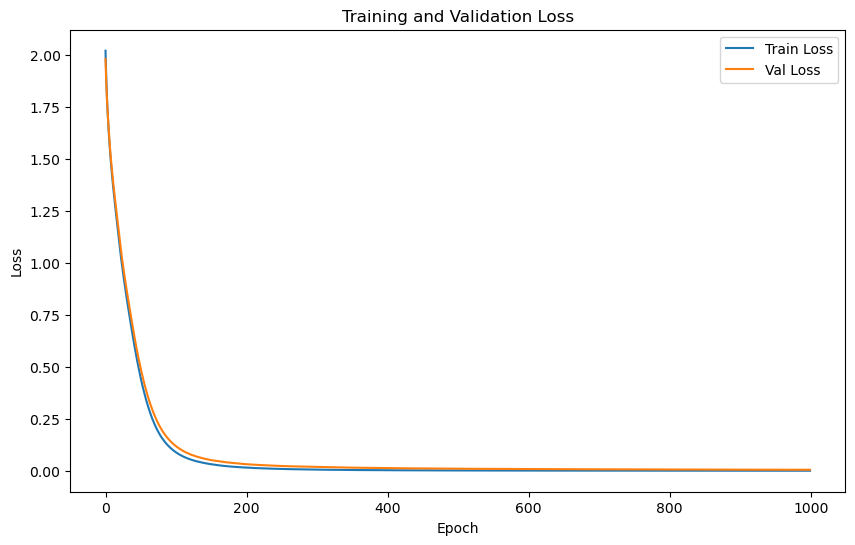

In [45]:
tscl_mlp_input_dim = tscl_mlp_train_reps.shape[1]
tscl_mlp_num_classes = len(torch.unique(tscl_mlp_train_labels_torch))
tscl_mlp_model = MLPClassifier(tscl_mlp_input_dim, tscl_mlp_num_classes).to(device)

tscl_mlp_criterion = nn.CrossEntropyLoss()
tscl_mlp_optimizer = optim.Adam(tscl_mlp_model.parameters(), lr=1e-4)

tscl_mlp_num_epochs = 1000
tscl_mlp_patience = 100

tscl_mlp_train_losses = []
tscl_mlp_val_losses = []

tscl_mlp_best_val_loss = float('inf')
tscl_mlp_epochs_without_improvement = 0

for tscl_mlp_epoch in range(tscl_mlp_num_epochs):
    # Training
    tscl_mlp_model.train()
    tscl_mlp_train_running_loss = 0.0
    
    for tscl_mlp_embeddings_batch, tscl_mlp_labels_batch in tscl_mlp_train_loader:
        tscl_mlp_embeddings_batch = tscl_mlp_embeddings_batch.to(device)
        tscl_mlp_labels_batch = tscl_mlp_labels_batch.to(device)
        
        tscl_mlp_optimizer.zero_grad()
        
        # Forward
        tscl_mlp_outputs = tscl_mlp_model(tscl_mlp_embeddings_batch)
        tscl_mlp_loss = tscl_mlp_criterion(tscl_mlp_outputs, tscl_mlp_labels_batch)
        
        # Backward & Update
        tscl_mlp_loss.backward()
        tscl_mlp_optimizer.step()
        
        tscl_mlp_train_running_loss += tscl_mlp_loss.item() * tscl_mlp_embeddings_batch.size(0)
    
    tscl_mlp_epoch_train_loss = tscl_mlp_train_running_loss / len(tscl_mlp_train_loader.dataset)
    tscl_mlp_train_losses.append(tscl_mlp_epoch_train_loss)

    # Validation
    tscl_mlp_model.eval()
    tscl_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for tscl_mlp_val_embeddings_batch, tscl_mlp_val_labels_batch in tscl_mlp_val_loader:
            tscl_mlp_val_embeddings_batch = tscl_mlp_val_embeddings_batch.to(device)
            tscl_mlp_val_labels_batch = tscl_mlp_val_labels_batch.to(device)

            tscl_mlp_val_outputs = tscl_mlp_model(tscl_mlp_val_embeddings_batch)
            tscl_mlp_val_loss = tscl_mlp_criterion(tscl_mlp_val_outputs, tscl_mlp_val_labels_batch)

            tscl_mlp_val_running_loss += tscl_mlp_val_loss.item() * tscl_mlp_val_embeddings_batch.size(0)

    tscl_mlp_epoch_val_loss = tscl_mlp_val_running_loss / len(tscl_mlp_val_loader.dataset)
    tscl_mlp_val_losses.append(tscl_mlp_epoch_val_loss)

    print(f"[Epoch {tscl_mlp_epoch+1}/{tscl_mlp_num_epochs}] "
          f"Train Loss: {tscl_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {tscl_mlp_epoch_val_loss:.4f}")

    # Early stopping
    if tscl_mlp_epoch_val_loss < tscl_mlp_best_val_loss:
        print(f"Validation loss improved from {tscl_mlp_best_val_loss:.4f} to {tscl_mlp_epoch_val_loss:.4f}.")
        tscl_mlp_best_val_loss = tscl_mlp_epoch_val_loss
        tscl_mlp_epochs_without_improvement = 0

    else:
        # no improvement
        tscl_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {tscl_mlp_epochs_without_improvement}/{tscl_mlp_patience}")
        
        if tscl_mlp_epochs_without_improvement >= tscl_mlp_patience:
            print(f"!! Early stopping triggered at epoch {tscl_mlp_epoch+1} !!\n"
                  f"No improvement for {tscl_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(tscl_mlp_train_losses, label='Train Loss')
plt.plot(tscl_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved TSCL+MLP predictions and true labels to model_predictions
Test Loss: 0.2362 | Test Accuracy: 96.63%


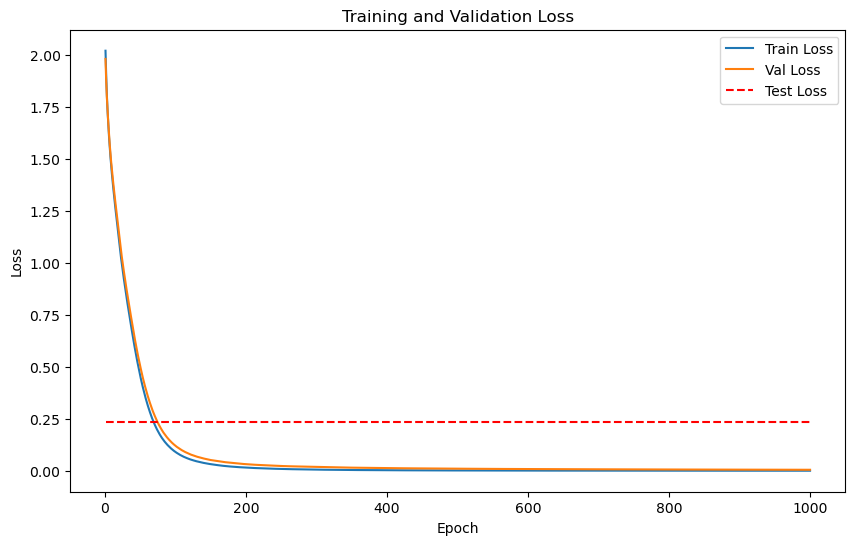

In [46]:
tscl_mlp_model.eval()

tscl_mlp_test_running_loss = 0.0
tscl_mlp_test_correct = 0
tscl_mlp_all_predictions = []
tscl_mlp_all_true_labels = []

with torch.no_grad():
    for tscl_mlp_test_embeddings_batch, tscl_mlp_test_labels_batch in tscl_mlp_test_loader:
        tscl_mlp_test_embeddings_batch = tscl_mlp_test_embeddings_batch.to(device)
        tscl_mlp_test_labels_batch = tscl_mlp_test_labels_batch.to(device)

        tscl_mlp_test_outputs = tscl_mlp_model(tscl_mlp_test_embeddings_batch)
        
        tscl_mlp_test_loss_batch = tscl_mlp_criterion(tscl_mlp_test_outputs, tscl_mlp_test_labels_batch)
        tscl_mlp_test_running_loss += tscl_mlp_test_loss_batch.item() * tscl_mlp_test_embeddings_batch.size(0)

        _, tscl_mlp_test_predicted = torch.max(tscl_mlp_test_outputs, dim=1)
        tscl_mlp_test_correct += (tscl_mlp_test_predicted == tscl_mlp_test_labels_batch).sum().item()

        tscl_mlp_all_predictions.extend(tscl_mlp_test_predicted.cpu().numpy())
        tscl_mlp_all_true_labels.extend(tscl_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'tscl_mlp_predictions.npy'), np.array(tscl_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'tscl_mlp_true_labels.npy'), np.array(tscl_mlp_all_true_labels))
print(f"Saved TSCL+MLP predictions and true labels to {predictions_dir}")

tscl_mlp_epoch_test_loss = tscl_mlp_test_running_loss / len(tscl_mlp_test_loader.dataset)
tscl_mlp_test_accuracy = tscl_mlp_test_correct / len(tscl_mlp_test_loader.dataset)

tscl_mlp_test_accuracy_pct = tscl_mlp_test_accuracy * 100.0

print(f"Test Loss: {tscl_mlp_epoch_test_loss:.4f} | Test Accuracy: {tscl_mlp_test_accuracy_pct:.2f}%")

tscl_mlp_num_epochs_run = len(tscl_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         tscl_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         tscl_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         [tscl_mlp_epoch_test_loss]*tscl_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Model - Supervised Contrastive Learning with Silhouette Distance Loss

In [47]:
sclsdl_encoded_train_dir = os.path.join(encoded_dir, 'train')
sclsdl_encoded_val_dir = os.path.join(encoded_dir, 'val')
sclsdl_encoded_test_dir = os.path.join(encoded_dir, 'test')

sclsdl_train_embeddings, sclsdl_train_labels = load_encoded_data(sclsdl_encoded_train_dir)
sclsdl_val_embeddings, sclsdl_val_labels = load_encoded_data(sclsdl_encoded_val_dir)
sclsdl_test_embeddings, sclsdl_test_labels = load_encoded_data(sclsdl_encoded_test_dir)

#shape verification
print(f"\n\nTrain embeddings shape: {sclsdl_train_embeddings.shape}, \nTrain labels shape: {sclsdl_train_labels.shape}")
print(f"\n\nVal embeddings shape: {sclsdl_val_embeddings.shape}, \nVal labels shape: {sclsdl_val_labels.shape}")
print(f"\n\nTest embeddings shape: {sclsdl_test_embeddings.shape}, \nTest labels shape: {sclsdl_test_labels.shape}")

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 360 samples with 64 features each
LOG: Labels shape: (360,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 45 samples with 64 features each
LOG: Labels shape: (45,)
LOG: Loading encoded data (representations) from encoded_representations\test...


LOG: Loaded 147747 samples with 64 features each
LOG: Labels shape: (147747,)


Train embeddings shape: (360, 64), 
Train labels shape: (360,)


Val embeddings shape: (45, 64), 
Val labels shape: (45,)


Test embeddings shape: (147747, 64), 
Test labels shape: (147747,)


In [48]:
#flattening embeddings to (num_samples, 64)
sclsdl_train_embeddings = sclsdl_train_embeddings.reshape(sclsdl_train_embeddings.shape[0], -1)
sclsdl_val_embeddings = sclsdl_val_embeddings.reshape(sclsdl_val_embeddings.shape[0], -1)
sclsdl_test_embeddings = sclsdl_test_embeddings.reshape(sclsdl_test_embeddings.shape[0], -1)

#compute mean and std from training set
sclsdl_train_mean = np.mean(sclsdl_train_embeddings, axis=0)
sclsdl_train_std = np.std(sclsdl_train_embeddings, axis=0)

#normalize all datasets from above training mean and std
#sclsdl_train_embeddings = (sclsdl_train_embeddings - sclsdl_train_mean) / sclsdl_train_std
#sclsdl_val_embeddings = (sclsdl_val_embeddings - sclsdl_train_mean) / sclsdl_train_std
#sclsdl_test_embeddings = (sclsdl_test_embeddings - sclsdl_train_mean) / sclsdl_train_std

sclsdl_train_dataset = TensorDataset(torch.tensor(sclsdl_train_embeddings, dtype=torch.float32), torch.tensor(sclsdl_train_labels, dtype=torch.long))
sclsdl_val_dataset = TensorDataset(torch.tensor(sclsdl_val_embeddings, dtype=torch.float32), torch.tensor(sclsdl_val_labels, dtype=torch.long))
sclsdl_test_dataset = TensorDataset(torch.tensor(sclsdl_test_embeddings, dtype=torch.float32), torch.tensor(sclsdl_test_labels, dtype=torch.long))


sclsdl_m = 20
sclsdl_num_classes = len(np.unique(sclsdl_train_labels))

# calc theoretical required batch size
sclsdl_required_batch_size = sclsdl_m * sclsdl_num_classes

if sclsdl_required_batch_size > len(sclsdl_train_dataset):
    sclsdl_max_possible_m = len(sclsdl_train_dataset) // sclsdl_num_classes
    sclsdl_m = max(1, sclsdl_max_possible_m)
    sclsdl_batch_size_train = sclsdl_m * sclsdl_num_classes
else:
    sclsdl_batch_size_train = sclsdl_required_batch_size

sclsdl_sampler = MPerClassSampler(labels = sclsdl_train_labels, m = sclsdl_m, batch_size = sclsdl_batch_size_train, length_before_new_iter=len(sclsdl_train_dataset))
sclsdl_train_loader = DataLoader(sclsdl_train_dataset, batch_size=sclsdl_batch_size_train, sampler=sclsdl_sampler)

#creating dataloaders for scl
sclsdl_dataloader_bs = 64
sclsdl_val_loader = DataLoader(sclsdl_val_dataset, batch_size=sclsdl_dataloader_bs, shuffle=False)
sclsdl_test_loader = DataLoader(sclsdl_test_dataset, batch_size=sclsdl_dataloader_bs, shuffle=False)

for sclsdl_X_batch, sclsdl_y_batch in sclsdl_train_loader:
    sclsdl_unique, sclsdl_counts = np.unique(y_batch.numpy(), return_counts=True)
    print("Class distribution in batch:", dict(zip(sclsdl_unique, sclsdl_counts)))
    print(f"Training batch size: {sclsdl_batch_size_train}")
    break


Class distribution in batch: {0: 20, 1: 20, 2: 20, 3: 20, 4: 20, 5: 20, 6: 20, 7: 20, 8: 20}
Training batch size: 180


In [49]:
class SupConNet(nn.Module):
    def __init__(self, feature_dim=128):
        super(SupConNet, self).__init__()
        self.projection_head = nn.Sequential(
            nn.Linear(64, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, feature_dim)
        )

    def forward(self, x):
        return self.projection_head(x)

In [50]:
class SilhouetteDistanceLoss(nn.Module):
    def __init__(self):
        super(SilhouetteDistanceLoss, self).__init__()

    def forward(self, features, labels):
        return self.score(features, labels, True,True)

    def score(self,X, labels,feature_norm=True, loss=False):
        unique_labels = torch.unique(labels)
        if feature_norm:
            X= F.normalize(X, p=2, dim=1)


        A, B = self._compute_distances(X, labels, unique_labels)

        # A= scale*A
        # B = (1-scale)*B
        sil_samples = (B - A) / torch.clamp(torch.maximum(A, B), min=0.0001)

        # nan values are for clusters of size 1, and should be 0
        mean_sil_score = torch.mean(torch.nan_to_num(sil_samples))
        if loss:
            return (1 - mean_sil_score) / 2
        else:
            return mean_sil_score.item()


    def _compute_distances(self,X, labels, unique_labels):
        intra_dist = torch.zeros_like(labels, dtype=torch.float32)
        inter_dist = torch.full_like(labels, torch.inf, dtype=torch.float32)

        for i, label_a in enumerate(unique_labels):
            cluster_indices_a = (labels == label_a)
            subX_a = X[cluster_indices_a]


            intra_distances_a = torch.cdist(subX_a, subX_a)
            div = (subX_a.size(0) - 1) if subX_a.shape[0]>1 else 1
            intra_dist[cluster_indices_a] = intra_distances_a.sum(dim=1) / div

            for label_b in unique_labels[i + 1:]:
                cluster_indices_b = (labels == label_b)
                subX_b = X[cluster_indices_b]
                inter_distances_ab = torch.cdist(subX_a, subX_b)
                inter_distances_ba = torch.cdist(subX_b, subX_a)

                inter_dist[cluster_indices_a] = torch.minimum(inter_distances_ab.mean(dim=1), inter_dist[cluster_indices_a])
                inter_dist[cluster_indices_b] = torch.minimum(inter_distances_ba.mean(dim=1), inter_dist[cluster_indices_b])

        return intra_dist, inter_dist

LOG: Epoch [1/2000] - Training


    Batch [1/2], Train Loss: 0.4482
    Batch [2/2], Train Loss: 0.4311
LOG: Epoch [1/2000] - Validation
    Batch [1/1], Val Loss: 0.3600
Epoch [1/2000], Avg Train Loss: 0.4397, Avg Val Loss: 0.3600

Validation loss improved from inf to 0.3600. Saving model...
LOG: Epoch [2/2000] - Training
    Batch [1/2], Train Loss: 0.4411


    Batch [2/2], Train Loss: 0.4390
LOG: Epoch [2/2000] - Validation
    Batch [1/1], Val Loss: 0.3590
Epoch [2/2000], Avg Train Loss: 0.4401, Avg Val Loss: 0.3590

Validation loss improved from 0.3600 to 0.3590. Saving model...
LOG: Epoch [3/2000] - Training
    Batch [1/2], Train Loss: 0.4399
    Batch [2/2], Train Loss: 0.4324
LOG: Epoch [3/2000] - Validation
    Batch [1/1], Val Loss: 0.3596
Epoch [3/2000], Avg Train Loss: 0.4362, Avg Val Loss: 0.3596

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [4/2000] - Training


    Batch [1/2], Train Loss: 0.4358
    Batch [2/2], Train Loss: 0.4337
LOG: Epoch [4/2000] - Validation
    Batch [1/1], Val Loss: 0.3616
Epoch [4/2000], Avg Train Loss: 0.4348, Avg Val Loss: 0.3616

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [5/2000] - Training
    Batch [1/2], Train Loss: 0.4387


    Batch [2/2], Train Loss: 0.4298
LOG: Epoch [5/2000] - Validation
    Batch [1/1], Val Loss: 0.3642
Epoch [5/2000], Avg Train Loss: 0.4343, Avg Val Loss: 0.3642

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [6/2000] - Training
    Batch [1/2], Train Loss: 0.4300
    Batch [2/2], Train Loss: 0.4339
LOG: Epoch [6/2000] - Validation


    Batch [1/1], Val Loss: 0.3657
Epoch [6/2000], Avg Train Loss: 0.4319, Avg Val Loss: 0.3657

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [7/2000] - Training
    Batch [1/2], Train Loss: 0.4271
    Batch [2/2], Train Loss: 0.4308
LOG: Epoch [7/2000] - Validation


    Batch [1/1], Val Loss: 0.3639
Epoch [7/2000], Avg Train Loss: 0.4289, Avg Val Loss: 0.3639

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [8/2000] - Training
    Batch [1/2], Train Loss: 0.4259
    Batch [2/2], Train Loss: 0.4232
LOG: Epoch [8/2000] - Validation
    Batch [1/1], Val Loss: 0.3604
Epoch [8/2000], Avg Train Loss: 0.4245, Avg Val Loss: 0.3604

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [9/2000] - Training


    Batch [1/2], Train Loss: 0.4235
    Batch [2/2], Train Loss: 0.4190
LOG: Epoch [9/2000] - Validation
    Batch [1/1], Val Loss: 0.3572
Epoch [9/2000], Avg Train Loss: 0.4213, Avg Val Loss: 0.3572

Validation loss improved from 0.3590 to 0.3572. Saving model...
LOG: Epoch [10/2000] - Training
    Batch [1/2], Train Loss: 0.4213


    Batch [2/2], Train Loss: 0.4190
LOG: Epoch [10/2000] - Validation
    Batch [1/1], Val Loss: 0.3547
Epoch [10/2000], Avg Train Loss: 0.4202, Avg Val Loss: 0.3547

Validation loss improved from 0.3572 to 0.3547. Saving model...
LOG: Epoch [11/2000] - Training
    Batch [1/2], Train Loss: 0.4165
    Batch [2/2], Train Loss: 0.4174
LOG: Epoch [11/2000] - Validation


    Batch [1/1], Val Loss: 0.3525
Epoch [11/2000], Avg Train Loss: 0.4169, Avg Val Loss: 0.3525

Validation loss improved from 0.3547 to 0.3525. Saving model...
LOG: Epoch [12/2000] - Training
    Batch [1/2], Train Loss: 0.4281
    Batch [2/2], Train Loss: 0.4156
LOG: Epoch [12/2000] - Validation
    Batch [1/1], Val Loss: 0.3505
Epoch [12/2000], Avg Train Loss: 0.4219, Avg Val Loss: 0.3505

Validation loss improved from 0.3525 to 0.3505. Saving model...
LOG: Epoch [13/2000] - Training


    Batch [1/2], Train Loss: 0.4208
    Batch [2/2], Train Loss: 0.4134
LOG: Epoch [13/2000] - Validation
    Batch [1/1], Val Loss: 0.3487
Epoch [13/2000], Avg Train Loss: 0.4171, Avg Val Loss: 0.3487

Validation loss improved from 0.3505 to 0.3487. Saving model...
LOG: Epoch [14/2000] - Training
    Batch [1/2], Train Loss: 0.4150


    Batch [2/2], Train Loss: 0.4171
LOG: Epoch [14/2000] - Validation
    Batch [1/1], Val Loss: 0.3468
Epoch [14/2000], Avg Train Loss: 0.4160, Avg Val Loss: 0.3468

Validation loss improved from 0.3487 to 0.3468. Saving model...
LOG: Epoch [15/2000] - Training
    Batch [1/2], Train Loss: 0.4171
    Batch [2/2], Train Loss: 0.4098
LOG: Epoch [15/2000] - Validation


    Batch [1/1], Val Loss: 0.3447
Epoch [15/2000], Avg Train Loss: 0.4134, Avg Val Loss: 0.3447

Validation loss improved from 0.3468 to 0.3447. Saving model...
LOG: Epoch [16/2000] - Training
    Batch [1/2], Train Loss: 0.4121
    Batch [2/2], Train Loss: 0.4166
LOG: Epoch [16/2000] - Validation
    Batch [1/1], Val Loss: 0.3428
Epoch [16/2000], Avg Train Loss: 0.4144, Avg Val Loss: 0.3428

Validation loss improved from 0.3447 to 0.3428. Saving model...
LOG: Epoch [17/2000] - Training


    Batch [1/2], Train Loss: 0.4068
    Batch [2/2], Train Loss: 0.4040
LOG: Epoch [17/2000] - Validation
    Batch [1/1], Val Loss: 0.3411
Epoch [17/2000], Avg Train Loss: 0.4054, Avg Val Loss: 0.3411

Validation loss improved from 0.3428 to 0.3411. Saving model...
LOG: Epoch [18/2000] - Training
    Batch [1/2], Train Loss: 0.4123


    Batch [2/2], Train Loss: 0.4113
LOG: Epoch [18/2000] - Validation
    Batch [1/1], Val Loss: 0.3393
Epoch [18/2000], Avg Train Loss: 0.4118, Avg Val Loss: 0.3393

Validation loss improved from 0.3411 to 0.3393. Saving model...
LOG: Epoch [19/2000] - Training
    Batch [1/2], Train Loss: 0.4032
    Batch [2/2], Train Loss: 0.4106
LOG: Epoch [19/2000] - Validation


    Batch [1/1], Val Loss: 0.3373
Epoch [19/2000], Avg Train Loss: 0.4069, Avg Val Loss: 0.3373

Validation loss improved from 0.3393 to 0.3373. Saving model...
LOG: Epoch [20/2000] - Training
    Batch [1/2], Train Loss: 0.4081
    Batch [2/2], Train Loss: 0.4081
LOG: Epoch [20/2000] - Validation
    Batch [1/1], Val Loss: 0.3353
Epoch [20/2000], Avg Train Loss: 0.4081, Avg Val Loss: 0.3353

Validation loss improved from 0.3373 to 0.3353. Saving model...
LOG: Epoch [21/2000] - Training


    Batch [1/2], Train Loss: 0.4030
    Batch [2/2], Train Loss: 0.3967
LOG: Epoch [21/2000] - Validation
    Batch [1/1], Val Loss: 0.3336
Epoch [21/2000], Avg Train Loss: 0.3999, Avg Val Loss: 0.3336

Validation loss improved from 0.3353 to 0.3336. Saving model...
LOG: Epoch [22/2000] - Training


    Batch [1/2], Train Loss: 0.3997
    Batch [2/2], Train Loss: 0.4039
LOG: Epoch [22/2000] - Validation
    Batch [1/1], Val Loss: 0.3315
Epoch [22/2000], Avg Train Loss: 0.4018, Avg Val Loss: 0.3315

Validation loss improved from 0.3336 to 0.3315. Saving model...
LOG: Epoch [23/2000] - Training
    Batch [1/2], Train Loss: 0.3987


    Batch [2/2], Train Loss: 0.3967
LOG: Epoch [23/2000] - Validation
    Batch [1/1], Val Loss: 0.3296
Epoch [23/2000], Avg Train Loss: 0.3977, Avg Val Loss: 0.3296

Validation loss improved from 0.3315 to 0.3296. Saving model...
LOG: Epoch [24/2000] - Training
    Batch [1/2], Train Loss: 0.3969
    Batch [2/2], Train Loss: 0.3923
LOG: Epoch [24/2000] - Validation


    Batch [1/1], Val Loss: 0.3278
Epoch [24/2000], Avg Train Loss: 0.3946, Avg Val Loss: 0.3278

Validation loss improved from 0.3296 to 0.3278. Saving model...
LOG: Epoch [25/2000] - Training
    Batch [1/2], Train Loss: 0.3928
    Batch [2/2], Train Loss: 0.3996
LOG: Epoch [25/2000] - Validation
    Batch [1/1], Val Loss: 0.3261
Epoch [25/2000], Avg Train Loss: 0.3962, Avg Val Loss: 0.3261

Validation loss improved from 0.3278 to 0.3261. Saving model...
LOG: Epoch [26/2000] - Training


    Batch [1/2], Train Loss: 0.3938
    Batch [2/2], Train Loss: 0.3910
LOG: Epoch [26/2000] - Validation
    Batch [1/1], Val Loss: 0.3243
Epoch [26/2000], Avg Train Loss: 0.3924, Avg Val Loss: 0.3243

Validation loss improved from 0.3261 to 0.3243. Saving model...
LOG: Epoch [27/2000] - Training
    Batch [1/2], Train Loss: 0.3959


    Batch [2/2], Train Loss: 0.3853
LOG: Epoch [27/2000] - Validation
    Batch [1/1], Val Loss: 0.3226
Epoch [27/2000], Avg Train Loss: 0.3906, Avg Val Loss: 0.3226

Validation loss improved from 0.3243 to 0.3226. Saving model...
LOG: Epoch [28/2000] - Training
    Batch [1/2], Train Loss: 0.3863
    Batch [2/2], Train Loss: 0.3995
LOG: Epoch [28/2000] - Validation
    Batch [1/1], Val Loss: 0.3205
Epoch [28/2000], Avg Train Loss: 0.3929, Avg Val Loss: 0.3205

Validation loss improved from 0.3226 to 0.3205. Saving model...
LOG: Epoch [29/2000] - Training


    Batch [1/2], Train Loss: 0.3862
    Batch [2/2], Train Loss: 0.3824
LOG: Epoch [29/2000] - Validation
    Batch [1/1], Val Loss: 0.3190
Epoch [29/2000], Avg Train Loss: 0.3843, Avg Val Loss: 0.3190

Validation loss improved from 0.3205 to 0.3190. Saving model...
LOG: Epoch [30/2000] - Training
    Batch [1/2], Train Loss: 0.3790


    Batch [2/2], Train Loss: 0.3825
LOG: Epoch [30/2000] - Validation
    Batch [1/1], Val Loss: 0.3169
Epoch [30/2000], Avg Train Loss: 0.3808, Avg Val Loss: 0.3169

Validation loss improved from 0.3190 to 0.3169. Saving model...
LOG: Epoch [31/2000] - Training
    Batch [1/2], Train Loss: 0.3923
    Batch [2/2], Train Loss: 0.3800
LOG: Epoch [31/2000] - Validation


    Batch [1/1], Val Loss: 0.3152
Epoch [31/2000], Avg Train Loss: 0.3861, Avg Val Loss: 0.3152

Validation loss improved from 0.3169 to 0.3152. Saving model...
LOG: Epoch [32/2000] - Training
    Batch [1/2], Train Loss: 0.3832
    Batch [2/2], Train Loss: 0.3889
LOG: Epoch [32/2000] - Validation
    Batch [1/1], Val Loss: 0.3136
Epoch [32/2000], Avg Train Loss: 0.3861, Avg Val Loss: 0.3136

Validation loss improved from 0.3152 to 0.3136. Saving model...
LOG: Epoch [33/2000] - Training


    Batch [1/2], Train Loss: 0.3891
    Batch [2/2], Train Loss: 0.3835
LOG: Epoch [33/2000] - Validation
    Batch [1/1], Val Loss: 0.3119
Epoch [33/2000], Avg Train Loss: 0.3863, Avg Val Loss: 0.3119

Validation loss improved from 0.3136 to 0.3119. Saving model...
LOG: Epoch [34/2000] - Training
    Batch [1/2], Train Loss: 0.3721


    Batch [2/2], Train Loss: 0.3786
LOG: Epoch [34/2000] - Validation
    Batch [1/1], Val Loss: 0.3102
Epoch [34/2000], Avg Train Loss: 0.3753, Avg Val Loss: 0.3102

Validation loss improved from 0.3119 to 0.3102. Saving model...
LOG: Epoch [35/2000] - Training
    Batch [1/2], Train Loss: 0.3816
    Batch [2/2], Train Loss: 0.3749
LOG: Epoch [35/2000] - Validation


    Batch [1/1], Val Loss: 0.3086
Epoch [35/2000], Avg Train Loss: 0.3782, Avg Val Loss: 0.3086

Validation loss improved from 0.3102 to 0.3086. Saving model...
LOG: Epoch [36/2000] - Training
    Batch [1/2], Train Loss: 0.3801
    Batch [2/2], Train Loss: 0.3785
LOG: Epoch [36/2000] - Validation
    Batch [1/1], Val Loss: 0.3069
Epoch [36/2000], Avg Train Loss: 0.3793, Avg Val Loss: 0.3069

Validation loss improved from 0.3086 to 0.3069. Saving model...
LOG: Epoch [37/2000] - Training


    Batch [1/2], Train Loss: 0.3801
    Batch [2/2], Train Loss: 0.3777
LOG: Epoch [37/2000] - Validation
    Batch [1/1], Val Loss: 0.3052
Epoch [37/2000], Avg Train Loss: 0.3789, Avg Val Loss: 0.3052

Validation loss improved from 0.3069 to 0.3052. Saving model...
LOG: Epoch [38/2000] - Training


    Batch [1/2], Train Loss: 0.3700
    Batch [2/2], Train Loss: 0.3678
LOG: Epoch [38/2000] - Validation
    Batch [1/1], Val Loss: 0.3037
Epoch [38/2000], Avg Train Loss: 0.3689, Avg Val Loss: 0.3037

Validation loss improved from 0.3052 to 0.3037. Saving model...
LOG: Epoch [39/2000] - Training


    Batch [1/2], Train Loss: 0.3777
    Batch [2/2], Train Loss: 0.3838
LOG: Epoch [39/2000] - Validation
    Batch [1/1], Val Loss: 0.3020
Epoch [39/2000], Avg Train Loss: 0.3807, Avg Val Loss: 0.3020

Validation loss improved from 0.3037 to 0.3020. Saving model...
LOG: Epoch [40/2000] - Training
    Batch [1/2], Train Loss: 0.3728


    Batch [2/2], Train Loss: 0.3642
LOG: Epoch [40/2000] - Validation
    Batch [1/1], Val Loss: 0.3008
Epoch [40/2000], Avg Train Loss: 0.3685, Avg Val Loss: 0.3008

Validation loss improved from 0.3020 to 0.3008. Saving model...
LOG: Epoch [41/2000] - Training
    Batch [1/2], Train Loss: 0.3775
    Batch [2/2], Train Loss: 0.3683
LOG: Epoch [41/2000] - Validation


    Batch [1/1], Val Loss: 0.2993
Epoch [41/2000], Avg Train Loss: 0.3729, Avg Val Loss: 0.2993

Validation loss improved from 0.3008 to 0.2993. Saving model...
LOG: Epoch [42/2000] - Training
    Batch [1/2], Train Loss: 0.3728
    Batch [2/2], Train Loss: 0.3732
LOG: Epoch [42/2000] - Validation
    Batch [1/1], Val Loss: 0.2977
Epoch [42/2000], Avg Train Loss: 0.3730, Avg Val Loss: 0.2977

Validation loss improved from 0.2993 to 0.2977. Saving model...
LOG: Epoch [43/2000] - Training


    Batch [1/2], Train Loss: 0.3711
    Batch [2/2], Train Loss: 0.3534
LOG: Epoch [43/2000] - Validation
    Batch [1/1], Val Loss: 0.2963
Epoch [43/2000], Avg Train Loss: 0.3623, Avg Val Loss: 0.2963

Validation loss improved from 0.2977 to 0.2963. Saving model...
LOG: Epoch [44/2000] - Training
    Batch [1/2], Train Loss: 0.3646


    Batch [2/2], Train Loss: 0.3733
LOG: Epoch [44/2000] - Validation
    Batch [1/1], Val Loss: 0.2948
Epoch [44/2000], Avg Train Loss: 0.3690, Avg Val Loss: 0.2948

Validation loss improved from 0.2963 to 0.2948. Saving model...
LOG: Epoch [45/2000] - Training
    Batch [1/2], Train Loss: 0.3733
    Batch [2/2], Train Loss: 0.3569
LOG: Epoch [45/2000] - Validation


    Batch [1/1], Val Loss: 0.2933
Epoch [45/2000], Avg Train Loss: 0.3651, Avg Val Loss: 0.2933

Validation loss improved from 0.2948 to 0.2933. Saving model...
LOG: Epoch [46/2000] - Training
    Batch [1/2], Train Loss: 0.3625
    Batch [2/2], Train Loss: 0.3683
LOG: Epoch [46/2000] - Validation
    Batch [1/1], Val Loss: 0.2922
Epoch [46/2000], Avg Train Loss: 0.3654, Avg Val Loss: 0.2922

Validation loss improved from 0.2933 to 0.2922. Saving model...
LOG: Epoch [47/2000] - Training


    Batch [1/2], Train Loss: 0.3670
    Batch [2/2], Train Loss: 0.3581
LOG: Epoch [47/2000] - Validation
    Batch [1/1], Val Loss: 0.2905
Epoch [47/2000], Avg Train Loss: 0.3625, Avg Val Loss: 0.2905

Validation loss improved from 0.2922 to 0.2905. Saving model...
LOG: Epoch [48/2000] - Training
    Batch [1/2], Train Loss: 0.3603


    Batch [2/2], Train Loss: 0.3650
LOG: Epoch [48/2000] - Validation
    Batch [1/1], Val Loss: 0.2893
Epoch [48/2000], Avg Train Loss: 0.3626, Avg Val Loss: 0.2893

Validation loss improved from 0.2905 to 0.2893. Saving model...
LOG: Epoch [49/2000] - Training
    Batch [1/2], Train Loss: 0.3645
    Batch [2/2], Train Loss: 0.3543
LOG: Epoch [49/2000] - Validation
    Batch [1/1], Val Loss: 0.2879
Epoch [49/2000], Avg Train Loss: 0.3594, Avg Val Loss: 0.2879

Validation loss improved from 0.2893 to 0.2879. Saving model...
LOG: Epoch [50/2000] - Training


    Batch [1/2], Train Loss: 0.3629
    Batch [2/2], Train Loss: 0.3607
LOG: Epoch [50/2000] - Validation
    Batch [1/1], Val Loss: 0.2866
Epoch [50/2000], Avg Train Loss: 0.3618, Avg Val Loss: 0.2866

Validation loss improved from 0.2879 to 0.2866. Saving model...
LOG: Epoch [51/2000] - Training
    Batch [1/2], Train Loss: 0.3603


    Batch [2/2], Train Loss: 0.3600
LOG: Epoch [51/2000] - Validation
    Batch [1/1], Val Loss: 0.2851
Epoch [51/2000], Avg Train Loss: 0.3601, Avg Val Loss: 0.2851

Validation loss improved from 0.2866 to 0.2851. Saving model...
LOG: Epoch [52/2000] - Training
    Batch [1/2], Train Loss: 0.3519
    Batch [2/2], Train Loss: 0.3517
LOG: Epoch [52/2000] - Validation


    Batch [1/1], Val Loss: 0.2836
Epoch [52/2000], Avg Train Loss: 0.3518, Avg Val Loss: 0.2836

Validation loss improved from 0.2851 to 0.2836. Saving model...
LOG: Epoch [53/2000] - Training
    Batch [1/2], Train Loss: 0.3488
    Batch [2/2], Train Loss: 0.3504
LOG: Epoch [53/2000] - Validation
    Batch [1/1], Val Loss: 0.2821
Epoch [53/2000], Avg Train Loss: 0.3496, Avg Val Loss: 0.2821

Validation loss improved from 0.2836 to 0.2821. Saving model...
LOG: Epoch [54/2000] - Training


    Batch [1/2], Train Loss: 0.3552
    Batch [2/2], Train Loss: 0.3496
LOG: Epoch [54/2000] - Validation
    Batch [1/1], Val Loss: 0.2807
Epoch [54/2000], Avg Train Loss: 0.3524, Avg Val Loss: 0.2807

Validation loss improved from 0.2821 to 0.2807. Saving model...
LOG: Epoch [55/2000] - Training
    Batch [1/2], Train Loss: 0.3488


    Batch [2/2], Train Loss: 0.3509
LOG: Epoch [55/2000] - Validation
    Batch [1/1], Val Loss: 0.2795
Epoch [55/2000], Avg Train Loss: 0.3499, Avg Val Loss: 0.2795

Validation loss improved from 0.2807 to 0.2795. Saving model...
LOG: Epoch [56/2000] - Training
    Batch [1/2], Train Loss: 0.3592
    Batch [2/2], Train Loss: 0.3504
LOG: Epoch [56/2000] - Validation


    Batch [1/1], Val Loss: 0.2781
Epoch [56/2000], Avg Train Loss: 0.3548, Avg Val Loss: 0.2781

Validation loss improved from 0.2795 to 0.2781. Saving model...
LOG: Epoch [57/2000] - Training
    Batch [1/2], Train Loss: 0.3562
    Batch [2/2], Train Loss: 0.3547
LOG: Epoch [57/2000] - Validation


    Batch [1/1], Val Loss: 0.2768
Epoch [57/2000], Avg Train Loss: 0.3555, Avg Val Loss: 0.2768

Validation loss improved from 0.2781 to 0.2768. Saving model...
LOG: Epoch [58/2000] - Training
    Batch [1/2], Train Loss: 0.3426
    Batch [2/2], Train Loss: 0.3350
LOG: Epoch [58/2000] - Validation
    Batch [1/1], Val Loss: 0.2755
Epoch [58/2000], Avg Train Loss: 0.3388, Avg Val Loss: 0.2755

Validation loss improved from 0.2768 to 0.2755. Saving model...
LOG: Epoch [59/2000] - Training


    Batch [1/2], Train Loss: 0.3475
    Batch [2/2], Train Loss: 0.3471
LOG: Epoch [59/2000] - Validation
    Batch [1/1], Val Loss: 0.2741
Epoch [59/2000], Avg Train Loss: 0.3473, Avg Val Loss: 0.2741

Validation loss improved from 0.2755 to 0.2741. Saving model...
LOG: Epoch [60/2000] - Training
    Batch [1/2], Train Loss: 0.3441


    Batch [2/2], Train Loss: 0.3468
LOG: Epoch [60/2000] - Validation
    Batch [1/1], Val Loss: 0.2728
Epoch [60/2000], Avg Train Loss: 0.3455, Avg Val Loss: 0.2728

Validation loss improved from 0.2741 to 0.2728. Saving model...
LOG: Epoch [61/2000] - Training
    Batch [1/2], Train Loss: 0.3494
    Batch [2/2], Train Loss: 0.3485
LOG: Epoch [61/2000] - Validation


    Batch [1/1], Val Loss: 0.2716
Epoch [61/2000], Avg Train Loss: 0.3490, Avg Val Loss: 0.2716

Validation loss improved from 0.2728 to 0.2716. Saving model...
LOG: Epoch [62/2000] - Training
    Batch [1/2], Train Loss: 0.3450
    Batch [2/2], Train Loss: 0.3475
LOG: Epoch [62/2000] - Validation
    Batch [1/1], Val Loss: 0.2704
Epoch [62/2000], Avg Train Loss: 0.3462, Avg Val Loss: 0.2704

Validation loss improved from 0.2716 to 0.2704. Saving model...
LOG: Epoch [63/2000] - Training


    Batch [1/2], Train Loss: 0.3360
    Batch [2/2], Train Loss: 0.3543
LOG: Epoch [63/2000] - Validation
    Batch [1/1], Val Loss: 0.2691
Epoch [63/2000], Avg Train Loss: 0.3452, Avg Val Loss: 0.2691

Validation loss improved from 0.2704 to 0.2691. Saving model...
LOG: Epoch [64/2000] - Training
    Batch [1/2], Train Loss: 0.3451


    Batch [2/2], Train Loss: 0.3339
LOG: Epoch [64/2000] - Validation
    Batch [1/1], Val Loss: 0.2679
Epoch [64/2000], Avg Train Loss: 0.3395, Avg Val Loss: 0.2679

Validation loss improved from 0.2691 to 0.2679. Saving model...
LOG: Epoch [65/2000] - Training
    Batch [1/2], Train Loss: 0.3393
    Batch [2/2], Train Loss: 0.3435
LOG: Epoch [65/2000] - Validation


    Batch [1/1], Val Loss: 0.2668
Epoch [65/2000], Avg Train Loss: 0.3414, Avg Val Loss: 0.2668

Validation loss improved from 0.2679 to 0.2668. Saving model...
LOG: Epoch [66/2000] - Training
    Batch [1/2], Train Loss: 0.3379
    Batch [2/2], Train Loss: 0.3431
LOG: Epoch [66/2000] - Validation
    Batch [1/1], Val Loss: 0.2657
Epoch [66/2000], Avg Train Loss: 0.3405, Avg Val Loss: 0.2657

Validation loss improved from 0.2668 to 0.2657. Saving model...
LOG: Epoch [67/2000] - Training


    Batch [1/2], Train Loss: 0.3413
    Batch [2/2], Train Loss: 0.3283
LOG: Epoch [67/2000] - Validation
    Batch [1/1], Val Loss: 0.2646
Epoch [67/2000], Avg Train Loss: 0.3348, Avg Val Loss: 0.2646

Validation loss improved from 0.2657 to 0.2646. Saving model...
LOG: Epoch [68/2000] - Training
    Batch [1/2], Train Loss: 0.3303


    Batch [2/2], Train Loss: 0.3318
LOG: Epoch [68/2000] - Validation
    Batch [1/1], Val Loss: 0.2633
Epoch [68/2000], Avg Train Loss: 0.3311, Avg Val Loss: 0.2633

Validation loss improved from 0.2646 to 0.2633. Saving model...
LOG: Epoch [69/2000] - Training
    Batch [1/2], Train Loss: 0.3233
    Batch [2/2], Train Loss: 0.3363
LOG: Epoch [69/2000] - Validation


    Batch [1/1], Val Loss: 0.2622
Epoch [69/2000], Avg Train Loss: 0.3298, Avg Val Loss: 0.2622

Validation loss improved from 0.2633 to 0.2622. Saving model...
LOG: Epoch [70/2000] - Training
    Batch [1/2], Train Loss: 0.3368
    Batch [2/2], Train Loss: 0.3347
LOG: Epoch [70/2000] - Validation
    Batch [1/1], Val Loss: 0.2611
Epoch [70/2000], Avg Train Loss: 0.3358, Avg Val Loss: 0.2611

Validation loss improved from 0.2622 to 0.2611. Saving model...
LOG: Epoch [71/2000] - Training


    Batch [1/2], Train Loss: 0.3418
    Batch [2/2], Train Loss: 0.3270
LOG: Epoch [71/2000] - Validation
    Batch [1/1], Val Loss: 0.2599
Epoch [71/2000], Avg Train Loss: 0.3344, Avg Val Loss: 0.2599

Validation loss improved from 0.2611 to 0.2599. Saving model...
LOG: Epoch [72/2000] - Training
    Batch [1/2], Train Loss: 0.3243


    Batch [2/2], Train Loss: 0.3330
LOG: Epoch [72/2000] - Validation
    Batch [1/1], Val Loss: 0.2587
Epoch [72/2000], Avg Train Loss: 0.3287, Avg Val Loss: 0.2587

Validation loss improved from 0.2599 to 0.2587. Saving model...
LOG: Epoch [73/2000] - Training
    Batch [1/2], Train Loss: 0.3307
    Batch [2/2], Train Loss: 0.3287
LOG: Epoch [73/2000] - Validation
    Batch [1/1], Val Loss: 0.2576
Epoch [73/2000], Avg Train Loss: 0.3297, Avg Val Loss: 0.2576

Validation loss improved from 0.2587 to 0.2576. Saving model...
LOG: Epoch [74/2000] - Training


    Batch [1/2], Train Loss: 0.3296
    Batch [2/2], Train Loss: 0.3297
LOG: Epoch [74/2000] - Validation
    Batch [1/1], Val Loss: 0.2566
Epoch [74/2000], Avg Train Loss: 0.3297, Avg Val Loss: 0.2566

Validation loss improved from 0.2576 to 0.2566. Saving model...
LOG: Epoch [75/2000] - Training
    Batch [1/2], Train Loss: 0.3331


    Batch [2/2], Train Loss: 0.3305
LOG: Epoch [75/2000] - Validation
    Batch [1/1], Val Loss: 0.2554
Epoch [75/2000], Avg Train Loss: 0.3318, Avg Val Loss: 0.2554

Validation loss improved from 0.2566 to 0.2554. Saving model...
LOG: Epoch [76/2000] - Training
    Batch [1/2], Train Loss: 0.3358
    Batch [2/2], Train Loss: 0.3375
LOG: Epoch [76/2000] - Validation


    Batch [1/1], Val Loss: 0.2544
Epoch [76/2000], Avg Train Loss: 0.3367, Avg Val Loss: 0.2544

Validation loss improved from 0.2554 to 0.2544. Saving model...
LOG: Epoch [77/2000] - Training
    Batch [1/2], Train Loss: 0.3212
    Batch [2/2], Train Loss: 0.3374
LOG: Epoch [77/2000] - Validation
    Batch [1/1], Val Loss: 0.2534
Epoch [77/2000], Avg Train Loss: 0.3293, Avg Val Loss: 0.2534

Validation loss improved from 0.2544 to 0.2534. Saving model...
LOG: Epoch [78/2000] - Training


    Batch [1/2], Train Loss: 0.3299
    Batch [2/2], Train Loss: 0.3209
LOG: Epoch [78/2000] - Validation
    Batch [1/1], Val Loss: 0.2523
Epoch [78/2000], Avg Train Loss: 0.3254, Avg Val Loss: 0.2523

Validation loss improved from 0.2534 to 0.2523. Saving model...
LOG: Epoch [79/2000] - Training
    Batch [1/2], Train Loss: 0.3264


    Batch [2/2], Train Loss: 0.3105
LOG: Epoch [79/2000] - Validation
    Batch [1/1], Val Loss: 0.2513
Epoch [79/2000], Avg Train Loss: 0.3185, Avg Val Loss: 0.2513

Validation loss improved from 0.2523 to 0.2513. Saving model...
LOG: Epoch [80/2000] - Training
    Batch [1/2], Train Loss: 0.3233
    Batch [2/2], Train Loss: 0.3169
LOG: Epoch [80/2000] - Validation


    Batch [1/1], Val Loss: 0.2504
Epoch [80/2000], Avg Train Loss: 0.3201, Avg Val Loss: 0.2504

Validation loss improved from 0.2513 to 0.2504. Saving model...
LOG: Epoch [81/2000] - Training
    Batch [1/2], Train Loss: 0.3280
    Batch [2/2], Train Loss: 0.3184
LOG: Epoch [81/2000] - Validation
    Batch [1/1], Val Loss: 0.2495
Epoch [81/2000], Avg Train Loss: 0.3232, Avg Val Loss: 0.2495

Validation loss improved from 0.2504 to 0.2495. Saving model...
LOG: Epoch [82/2000] - Training


    Batch [1/2], Train Loss: 0.3279
    Batch [2/2], Train Loss: 0.3190
LOG: Epoch [82/2000] - Validation
    Batch [1/1], Val Loss: 0.2486
Epoch [82/2000], Avg Train Loss: 0.3234, Avg Val Loss: 0.2486

Validation loss improved from 0.2495 to 0.2486. Saving model...
LOG: Epoch [83/2000] - Training
    Batch [1/2], Train Loss: 0.3151


    Batch [2/2], Train Loss: 0.3182
LOG: Epoch [83/2000] - Validation
    Batch [1/1], Val Loss: 0.2479
Epoch [83/2000], Avg Train Loss: 0.3166, Avg Val Loss: 0.2479

Validation loss improved from 0.2486 to 0.2479. Saving model...
LOG: Epoch [84/2000] - Training
    Batch [1/2], Train Loss: 0.3114
    Batch [2/2], Train Loss: 0.3227
LOG: Epoch [84/2000] - Validation


    Batch [1/1], Val Loss: 0.2472
Epoch [84/2000], Avg Train Loss: 0.3170, Avg Val Loss: 0.2472

Validation loss improved from 0.2479 to 0.2472. Saving model...
LOG: Epoch [85/2000] - Training
    Batch [1/2], Train Loss: 0.3098
    Batch [2/2], Train Loss: 0.3168
LOG: Epoch [85/2000] - Validation
    Batch [1/1], Val Loss: 0.2464
Epoch [85/2000], Avg Train Loss: 0.3133, Avg Val Loss: 0.2464

Validation loss improved from 0.2472 to 0.2464. Saving model...
LOG: Epoch [86/2000] - Training


    Batch [1/2], Train Loss: 0.3175
    Batch [2/2], Train Loss: 0.3210
LOG: Epoch [86/2000] - Validation
    Batch [1/1], Val Loss: 0.2456
Epoch [86/2000], Avg Train Loss: 0.3192, Avg Val Loss: 0.2456

Validation loss improved from 0.2464 to 0.2456. Saving model...
LOG: Epoch [87/2000] - Training
    Batch [1/2], Train Loss: 0.3099


    Batch [2/2], Train Loss: 0.3088
LOG: Epoch [87/2000] - Validation
    Batch [1/1], Val Loss: 0.2445
Epoch [87/2000], Avg Train Loss: 0.3093, Avg Val Loss: 0.2445

Validation loss improved from 0.2456 to 0.2445. Saving model...
LOG: Epoch [88/2000] - Training
    Batch [1/2], Train Loss: 0.3137
    Batch [2/2], Train Loss: 0.3219
LOG: Epoch [88/2000] - Validation
    Batch [1/1], Val Loss: 0.2437
Epoch [88/2000], Avg Train Loss: 0.3178, Avg Val Loss: 0.2437

Validation loss improved from 0.2445 to 0.2437. Saving model...
LOG: Epoch [89/2000] - Training


    Batch [1/2], Train Loss: 0.3154
    Batch [2/2], Train Loss: 0.3187
LOG: Epoch [89/2000] - Validation
    Batch [1/1], Val Loss: 0.2427
Epoch [89/2000], Avg Train Loss: 0.3171, Avg Val Loss: 0.2427

Validation loss improved from 0.2437 to 0.2427. Saving model...
LOG: Epoch [90/2000] - Training
    Batch [1/2], Train Loss: 0.3067


    Batch [2/2], Train Loss: 0.3087
LOG: Epoch [90/2000] - Validation
    Batch [1/1], Val Loss: 0.2417
Epoch [90/2000], Avg Train Loss: 0.3077, Avg Val Loss: 0.2417

Validation loss improved from 0.2427 to 0.2417. Saving model...
LOG: Epoch [91/2000] - Training
    Batch [1/2], Train Loss: 0.3123


    Batch [2/2], Train Loss: 0.3069
LOG: Epoch [91/2000] - Validation
    Batch [1/1], Val Loss: 0.2407
Epoch [91/2000], Avg Train Loss: 0.3096, Avg Val Loss: 0.2407

Validation loss improved from 0.2417 to 0.2407. Saving model...
LOG: Epoch [92/2000] - Training
    Batch [1/2], Train Loss: 0.3024


    Batch [2/2], Train Loss: 0.3182
LOG: Epoch [92/2000] - Validation
    Batch [1/1], Val Loss: 0.2397
Epoch [92/2000], Avg Train Loss: 0.3103, Avg Val Loss: 0.2397

Validation loss improved from 0.2407 to 0.2397. Saving model...
LOG: Epoch [93/2000] - Training
    Batch [1/2], Train Loss: 0.3088
    Batch [2/2], Train Loss: 0.3129
LOG: Epoch [93/2000] - Validation
    Batch [1/1], Val Loss: 0.2388
Epoch [93/2000], Avg Train Loss: 0.3109, Avg Val Loss: 0.2388

Validation loss improved from 0.2397 to 0.2388. Saving model...
LOG: Epoch [94/2000] - Training


    Batch [1/2], Train Loss: 0.2941
    Batch [2/2], Train Loss: 0.3058
LOG: Epoch [94/2000] - Validation
    Batch [1/1], Val Loss: 0.2379
Epoch [94/2000], Avg Train Loss: 0.2999, Avg Val Loss: 0.2379

Validation loss improved from 0.2388 to 0.2379. Saving model...
LOG: Epoch [95/2000] - Training
    Batch [1/2], Train Loss: 0.3029


    Batch [2/2], Train Loss: 0.3104
LOG: Epoch [95/2000] - Validation
    Batch [1/1], Val Loss: 0.2371
Epoch [95/2000], Avg Train Loss: 0.3066, Avg Val Loss: 0.2371

Validation loss improved from 0.2379 to 0.2371. Saving model...
LOG: Epoch [96/2000] - Training
    Batch [1/2], Train Loss: 0.3102
    Batch [2/2], Train Loss: 0.3124
LOG: Epoch [96/2000] - Validation
    Batch [1/1], Val Loss: 0.2359
Epoch [96/2000], Avg Train Loss: 0.3113, Avg Val Loss: 0.2359

Validation loss improved from 0.2371 to 0.2359. Saving model...
LOG: Epoch [97/2000] - Training


    Batch [1/2], Train Loss: 0.3074
    Batch [2/2], Train Loss: 0.3141
LOG: Epoch [97/2000] - Validation
    Batch [1/1], Val Loss: 0.2350
Epoch [97/2000], Avg Train Loss: 0.3107, Avg Val Loss: 0.2350

Validation loss improved from 0.2359 to 0.2350. Saving model...
LOG: Epoch [98/2000] - Training
    Batch [1/2], Train Loss: 0.3050


    Batch [2/2], Train Loss: 0.2990
LOG: Epoch [98/2000] - Validation
    Batch [1/1], Val Loss: 0.2341
Epoch [98/2000], Avg Train Loss: 0.3020, Avg Val Loss: 0.2341

Validation loss improved from 0.2350 to 0.2341. Saving model...
LOG: Epoch [99/2000] - Training
    Batch [1/2], Train Loss: 0.3037
    Batch [2/2], Train Loss: 0.3019
LOG: Epoch [99/2000] - Validation
    Batch [1/1], Val Loss: 0.2333
Epoch [99/2000], Avg Train Loss: 0.3028, Avg Val Loss: 0.2333

Validation loss improved from 0.2341 to 0.2333. Saving model...
LOG: Epoch [100/2000] - Training


    Batch [1/2], Train Loss: 0.2984
    Batch [2/2], Train Loss: 0.2972
LOG: Epoch [100/2000] - Validation
    Batch [1/1], Val Loss: 0.2324
Epoch [100/2000], Avg Train Loss: 0.2978, Avg Val Loss: 0.2324

Validation loss improved from 0.2333 to 0.2324. Saving model...
LOG: Epoch [101/2000] - Training
    Batch [1/2], Train Loss: 0.2845


    Batch [2/2], Train Loss: 0.2927
LOG: Epoch [101/2000] - Validation
    Batch [1/1], Val Loss: 0.2316
Epoch [101/2000], Avg Train Loss: 0.2886, Avg Val Loss: 0.2316

Validation loss improved from 0.2324 to 0.2316. Saving model...
LOG: Epoch [102/2000] - Training
    Batch [1/2], Train Loss: 0.2901
    Batch [2/2], Train Loss: 0.2939
LOG: Epoch [102/2000] - Validation
    Batch [1/1], Val Loss: 0.2308
Epoch [102/2000], Avg Train Loss: 0.2920, Avg Val Loss: 0.2308

Validation loss improved from 0.2316 to 0.2308. Saving model...
LOG: Epoch [103/2000] - Training


    Batch [1/2], Train Loss: 0.2788
    Batch [2/2], Train Loss: 0.3013
LOG: Epoch [103/2000] - Validation
    Batch [1/1], Val Loss: 0.2298
Epoch [103/2000], Avg Train Loss: 0.2900, Avg Val Loss: 0.2298

Validation loss improved from 0.2308 to 0.2298. Saving model...
LOG: Epoch [104/2000] - Training
    Batch [1/2], Train Loss: 0.2925


    Batch [2/2], Train Loss: 0.3081
LOG: Epoch [104/2000] - Validation
    Batch [1/1], Val Loss: 0.2292
Epoch [104/2000], Avg Train Loss: 0.3003, Avg Val Loss: 0.2292

Validation loss improved from 0.2298 to 0.2292. Saving model...
LOG: Epoch [105/2000] - Training
    Batch [1/2], Train Loss: 0.2949
    Batch [2/2], Train Loss: 0.2868
LOG: Epoch [105/2000] - Validation
    Batch [1/1], Val Loss: 0.2282
Epoch [105/2000], Avg Train Loss: 0.2909, Avg Val Loss: 0.2282

Validation loss improved from 0.2292 to 0.2282. Saving model...
LOG: Epoch [106/2000] - Training


    Batch [1/2], Train Loss: 0.2923
    Batch [2/2], Train Loss: 0.3026
LOG: Epoch [106/2000] - Validation
    Batch [1/1], Val Loss: 0.2273
Epoch [106/2000], Avg Train Loss: 0.2975, Avg Val Loss: 0.2273

Validation loss improved from 0.2282 to 0.2273. Saving model...
LOG: Epoch [107/2000] - Training
    Batch [1/2], Train Loss: 0.2995


    Batch [2/2], Train Loss: 0.2871
LOG: Epoch [107/2000] - Validation
    Batch [1/1], Val Loss: 0.2265
Epoch [107/2000], Avg Train Loss: 0.2933, Avg Val Loss: 0.2265

Validation loss improved from 0.2273 to 0.2265. Saving model...
LOG: Epoch [108/2000] - Training
    Batch [1/2], Train Loss: 0.2855
    Batch [2/2], Train Loss: 0.2845
LOG: Epoch [108/2000] - Validation


    Batch [1/1], Val Loss: 0.2256
Epoch [108/2000], Avg Train Loss: 0.2850, Avg Val Loss: 0.2256

Validation loss improved from 0.2265 to 0.2256. Saving model...
LOG: Epoch [109/2000] - Training
    Batch [1/2], Train Loss: 0.2908
    Batch [2/2], Train Loss: 0.2865
LOG: Epoch [109/2000] - Validation
    Batch [1/1], Val Loss: 0.2249
Epoch [109/2000], Avg Train Loss: 0.2887, Avg Val Loss: 0.2249

Validation loss improved from 0.2256 to 0.2249. Saving model...
LOG: Epoch [110/2000] - Training


    Batch [1/2], Train Loss: 0.2862
    Batch [2/2], Train Loss: 0.2730
LOG: Epoch [110/2000] - Validation
    Batch [1/1], Val Loss: 0.2241
Epoch [110/2000], Avg Train Loss: 0.2796, Avg Val Loss: 0.2241

Validation loss improved from 0.2249 to 0.2241. Saving model...
LOG: Epoch [111/2000] - Training
    Batch [1/2], Train Loss: 0.2953


    Batch [2/2], Train Loss: 0.2724
LOG: Epoch [111/2000] - Validation
    Batch [1/1], Val Loss: 0.2234
Epoch [111/2000], Avg Train Loss: 0.2838, Avg Val Loss: 0.2234

Validation loss improved from 0.2241 to 0.2234. Saving model...
LOG: Epoch [112/2000] - Training
    Batch [1/2], Train Loss: 0.2886
    Batch [2/2], Train Loss: 0.2945
LOG: Epoch [112/2000] - Validation


    Batch [1/1], Val Loss: 0.2226
Epoch [112/2000], Avg Train Loss: 0.2915, Avg Val Loss: 0.2226

Validation loss improved from 0.2234 to 0.2226. Saving model...
LOG: Epoch [113/2000] - Training
    Batch [1/2], Train Loss: 0.2975
    Batch [2/2], Train Loss: 0.2925
LOG: Epoch [113/2000] - Validation
    Batch [1/1], Val Loss: 0.2219
Epoch [113/2000], Avg Train Loss: 0.2950, Avg Val Loss: 0.2219

Validation loss improved from 0.2226 to 0.2219. Saving model...
LOG: Epoch [114/2000] - Training


    Batch [1/2], Train Loss: 0.2886
    Batch [2/2], Train Loss: 0.2861
LOG: Epoch [114/2000] - Validation
    Batch [1/1], Val Loss: 0.2211
Epoch [114/2000], Avg Train Loss: 0.2874, Avg Val Loss: 0.2211

Validation loss improved from 0.2219 to 0.2211. Saving model...
LOG: Epoch [115/2000] - Training
    Batch [1/2], Train Loss: 0.2938


    Batch [2/2], Train Loss: 0.2850
LOG: Epoch [115/2000] - Validation
    Batch [1/1], Val Loss: 0.2204
Epoch [115/2000], Avg Train Loss: 0.2894, Avg Val Loss: 0.2204

Validation loss improved from 0.2211 to 0.2204. Saving model...
LOG: Epoch [116/2000] - Training
    Batch [1/2], Train Loss: 0.2846
    Batch [2/2], Train Loss: 0.2727
LOG: Epoch [116/2000] - Validation
    Batch [1/1], Val Loss: 0.2195
Epoch [116/2000], Avg Train Loss: 0.2787, Avg Val Loss: 0.2195

Validation loss improved from 0.2204 to 0.2195. Saving model...
LOG: Epoch [117/2000] - Training


    Batch [1/2], Train Loss: 0.2681
    Batch [2/2], Train Loss: 0.2753
LOG: Epoch [117/2000] - Validation
    Batch [1/1], Val Loss: 0.2188
Epoch [117/2000], Avg Train Loss: 0.2717, Avg Val Loss: 0.2188

Validation loss improved from 0.2195 to 0.2188. Saving model...
LOG: Epoch [118/2000] - Training
    Batch [1/2], Train Loss: 0.2757


    Batch [2/2], Train Loss: 0.2775
LOG: Epoch [118/2000] - Validation
    Batch [1/1], Val Loss: 0.2181
Epoch [118/2000], Avg Train Loss: 0.2766, Avg Val Loss: 0.2181

Validation loss improved from 0.2188 to 0.2181. Saving model...
LOG: Epoch [119/2000] - Training
    Batch [1/2], Train Loss: 0.2863
    Batch [2/2], Train Loss: 0.2805
LOG: Epoch [119/2000] - Validation
    Batch [1/1], Val Loss: 0.2171
Epoch [119/2000], Avg Train Loss: 0.2834, Avg Val Loss: 0.2171

Validation loss improved from 0.2181 to 0.2171. Saving model...
LOG: Epoch [120/2000] - Training


    Batch [1/2], Train Loss: 0.2823
    Batch [2/2], Train Loss: 0.2774
LOG: Epoch [120/2000] - Validation
    Batch [1/1], Val Loss: 0.2165
Epoch [120/2000], Avg Train Loss: 0.2799, Avg Val Loss: 0.2165

Validation loss improved from 0.2171 to 0.2165. Saving model...
LOG: Epoch [121/2000] - Training
    Batch [1/2], Train Loss: 0.2800


    Batch [2/2], Train Loss: 0.2708
LOG: Epoch [121/2000] - Validation
    Batch [1/1], Val Loss: 0.2159
Epoch [121/2000], Avg Train Loss: 0.2754, Avg Val Loss: 0.2159

Validation loss improved from 0.2165 to 0.2159. Saving model...
LOG: Epoch [122/2000] - Training
    Batch [1/2], Train Loss: 0.2739
    Batch [2/2], Train Loss: 0.2707
LOG: Epoch [122/2000] - Validation
    Batch [1/1], Val Loss: 0.2151
Epoch [122/2000], Avg Train Loss: 0.2723, Avg Val Loss: 0.2151

Validation loss improved from 0.2159 to 0.2151. Saving model...
LOG: Epoch [123/2000] - Training


    Batch [1/2], Train Loss: 0.2871
    Batch [2/2], Train Loss: 0.2722
LOG: Epoch [123/2000] - Validation
    Batch [1/1], Val Loss: 0.2145
Epoch [123/2000], Avg Train Loss: 0.2796, Avg Val Loss: 0.2145

Validation loss improved from 0.2151 to 0.2145. Saving model...
LOG: Epoch [124/2000] - Training
    Batch [1/2], Train Loss: 0.2802


    Batch [2/2], Train Loss: 0.2855
LOG: Epoch [124/2000] - Validation
    Batch [1/1], Val Loss: 0.2137
Epoch [124/2000], Avg Train Loss: 0.2829, Avg Val Loss: 0.2137

Validation loss improved from 0.2145 to 0.2137. Saving model...
LOG: Epoch [125/2000] - Training
    Batch [1/2], Train Loss: 0.2716
    Batch [2/2], Train Loss: 0.2746
LOG: Epoch [125/2000] - Validation


    Batch [1/1], Val Loss: 0.2129
Epoch [125/2000], Avg Train Loss: 0.2731, Avg Val Loss: 0.2129

Validation loss improved from 0.2137 to 0.2129. Saving model...
LOG: Epoch [126/2000] - Training
    Batch [1/2], Train Loss: 0.2764
    Batch [2/2], Train Loss: 0.2765
LOG: Epoch [126/2000] - Validation
    Batch [1/1], Val Loss: 0.2121
Epoch [126/2000], Avg Train Loss: 0.2764, Avg Val Loss: 0.2121

Validation loss improved from 0.2129 to 0.2121. Saving model...
LOG: Epoch [127/2000] - Training


    Batch [1/2], Train Loss: 0.2736
    Batch [2/2], Train Loss: 0.2695
LOG: Epoch [127/2000] - Validation
    Batch [1/1], Val Loss: 0.2115
Epoch [127/2000], Avg Train Loss: 0.2715, Avg Val Loss: 0.2115

Validation loss improved from 0.2121 to 0.2115. Saving model...
LOG: Epoch [128/2000] - Training
    Batch [1/2], Train Loss: 0.2756


    Batch [2/2], Train Loss: 0.2676
LOG: Epoch [128/2000] - Validation
    Batch [1/1], Val Loss: 0.2108
Epoch [128/2000], Avg Train Loss: 0.2716, Avg Val Loss: 0.2108

Validation loss improved from 0.2115 to 0.2108. Saving model...
LOG: Epoch [129/2000] - Training
    Batch [1/2], Train Loss: 0.2672
    Batch [2/2], Train Loss: 0.2680
LOG: Epoch [129/2000] - Validation
    Batch [1/1], Val Loss: 0.2100
Epoch [129/2000], Avg Train Loss: 0.2676, Avg Val Loss: 0.2100

Validation loss improved from 0.2108 to 0.2100. Saving model...
LOG: Epoch [130/2000] - Training


    Batch [1/2], Train Loss: 0.2802
    Batch [2/2], Train Loss: 0.2756
LOG: Epoch [130/2000] - Validation
    Batch [1/1], Val Loss: 0.2091
Epoch [130/2000], Avg Train Loss: 0.2779, Avg Val Loss: 0.2091

Validation loss improved from 0.2100 to 0.2091. Saving model...
LOG: Epoch [131/2000] - Training
    Batch [1/2], Train Loss: 0.2723


    Batch [2/2], Train Loss: 0.2820
LOG: Epoch [131/2000] - Validation
    Batch [1/1], Val Loss: 0.2083
Epoch [131/2000], Avg Train Loss: 0.2772, Avg Val Loss: 0.2083

Validation loss improved from 0.2091 to 0.2083. Saving model...
LOG: Epoch [132/2000] - Training
    Batch [1/2], Train Loss: 0.2775
    Batch [2/2], Train Loss: 0.2789
LOG: Epoch [132/2000] - Validation
    Batch [1/1], Val Loss: 0.2077
Epoch [132/2000], Avg Train Loss: 0.2782, Avg Val Loss: 0.2077

Validation loss improved from 0.2083 to 0.2077. Saving model...
LOG: Epoch [133/2000] - Training


    Batch [1/2], Train Loss: 0.2792
    Batch [2/2], Train Loss: 0.2753
LOG: Epoch [133/2000] - Validation
    Batch [1/1], Val Loss: 0.2069
Epoch [133/2000], Avg Train Loss: 0.2773, Avg Val Loss: 0.2069

Validation loss improved from 0.2077 to 0.2069. Saving model...
LOG: Epoch [134/2000] - Training
    Batch [1/2], Train Loss: 0.2659


    Batch [2/2], Train Loss: 0.2621
LOG: Epoch [134/2000] - Validation
    Batch [1/1], Val Loss: 0.2061
Epoch [134/2000], Avg Train Loss: 0.2640, Avg Val Loss: 0.2061

Validation loss improved from 0.2069 to 0.2061. Saving model...
LOG: Epoch [135/2000] - Training
    Batch [1/2], Train Loss: 0.2678
    Batch [2/2], Train Loss: 0.2706
LOG: Epoch [135/2000] - Validation


    Batch [1/1], Val Loss: 0.2055
Epoch [135/2000], Avg Train Loss: 0.2692, Avg Val Loss: 0.2055

Validation loss improved from 0.2061 to 0.2055. Saving model...
LOG: Epoch [136/2000] - Training
    Batch [1/2], Train Loss: 0.2739
    Batch [2/2], Train Loss: 0.2699
LOG: Epoch [136/2000] - Validation


    Batch [1/1], Val Loss: 0.2048
Epoch [136/2000], Avg Train Loss: 0.2719, Avg Val Loss: 0.2048

Validation loss improved from 0.2055 to 0.2048. Saving model...
LOG: Epoch [137/2000] - Training
    Batch [1/2], Train Loss: 0.2629
    Batch [2/2], Train Loss: 0.2724
LOG: Epoch [137/2000] - Validation
    Batch [1/1], Val Loss: 0.2041
Epoch [137/2000], Avg Train Loss: 0.2676, Avg Val Loss: 0.2041

Validation loss improved from 0.2048 to 0.2041. Saving model...
LOG: Epoch [138/2000] - Training


    Batch [1/2], Train Loss: 0.2775
    Batch [2/2], Train Loss: 0.2690
LOG: Epoch [138/2000] - Validation
    Batch [1/1], Val Loss: 0.2035
Epoch [138/2000], Avg Train Loss: 0.2733, Avg Val Loss: 0.2035

Validation loss improved from 0.2041 to 0.2035. Saving model...
LOG: Epoch [139/2000] - Training
    Batch [1/2], Train Loss: 0.2690


    Batch [2/2], Train Loss: 0.2516
LOG: Epoch [139/2000] - Validation
    Batch [1/1], Val Loss: 0.2029
Epoch [139/2000], Avg Train Loss: 0.2603, Avg Val Loss: 0.2029

Validation loss improved from 0.2035 to 0.2029. Saving model...
LOG: Epoch [140/2000] - Training
    Batch [1/2], Train Loss: 0.2531
    Batch [2/2], Train Loss: 0.2585
LOG: Epoch [140/2000] - Validation


    Batch [1/1], Val Loss: 0.2022
Epoch [140/2000], Avg Train Loss: 0.2558, Avg Val Loss: 0.2022

Validation loss improved from 0.2029 to 0.2022. Saving model...
LOG: Epoch [141/2000] - Training
    Batch [1/2], Train Loss: 0.2748
    Batch [2/2], Train Loss: 0.2651
LOG: Epoch [141/2000] - Validation
    Batch [1/1], Val Loss: 0.2015
Epoch [141/2000], Avg Train Loss: 0.2700, Avg Val Loss: 0.2015

Validation loss improved from 0.2022 to 0.2015. Saving model...
LOG: Epoch [142/2000] - Training


    Batch [1/2], Train Loss: 0.2661
    Batch [2/2], Train Loss: 0.2648
LOG: Epoch [142/2000] - Validation
    Batch [1/1], Val Loss: 0.2009
Epoch [142/2000], Avg Train Loss: 0.2654, Avg Val Loss: 0.2009

Validation loss improved from 0.2015 to 0.2009. Saving model...
LOG: Epoch [143/2000] - Training
    Batch [1/2], Train Loss: 0.2653


    Batch [2/2], Train Loss: 0.2605
LOG: Epoch [143/2000] - Validation
    Batch [1/1], Val Loss: 0.2004
Epoch [143/2000], Avg Train Loss: 0.2629, Avg Val Loss: 0.2004

Validation loss improved from 0.2009 to 0.2004. Saving model...
LOG: Epoch [144/2000] - Training
    Batch [1/2], Train Loss: 0.2661
    Batch [2/2], Train Loss: 0.2707
LOG: Epoch [144/2000] - Validation
    Batch [1/1], Val Loss: 0.2000
Epoch [144/2000], Avg Train Loss: 0.2684, Avg Val Loss: 0.2000

Validation loss improved from 0.2004 to 0.2000. Saving model...
LOG: Epoch [145/2000] - Training


    Batch [1/2], Train Loss: 0.2708
    Batch [2/2], Train Loss: 0.2739
LOG: Epoch [145/2000] - Validation
    Batch [1/1], Val Loss: 0.1994
Epoch [145/2000], Avg Train Loss: 0.2723, Avg Val Loss: 0.1994

Validation loss improved from 0.2000 to 0.1994. Saving model...
LOG: Epoch [146/2000] - Training
    Batch [1/2], Train Loss: 0.2684


    Batch [2/2], Train Loss: 0.2576
LOG: Epoch [146/2000] - Validation
    Batch [1/1], Val Loss: 0.1988
Epoch [146/2000], Avg Train Loss: 0.2630, Avg Val Loss: 0.1988

Validation loss improved from 0.1994 to 0.1988. Saving model...
LOG: Epoch [147/2000] - Training
    Batch [1/2], Train Loss: 0.2608
    Batch [2/2], Train Loss: 0.2821
LOG: Epoch [147/2000] - Validation
    Batch [1/1], Val Loss: 0.1982
Epoch [147/2000], Avg Train Loss: 0.2714, Avg Val Loss: 0.1982

Validation loss improved from 0.1988 to 0.1982. Saving model...
LOG: Epoch [148/2000] - Training


    Batch [1/2], Train Loss: 0.2688
    Batch [2/2], Train Loss: 0.2573
LOG: Epoch [148/2000] - Validation
    Batch [1/1], Val Loss: 0.1979
Epoch [148/2000], Avg Train Loss: 0.2630, Avg Val Loss: 0.1979

Validation loss improved from 0.1982 to 0.1979. Saving model...
LOG: Epoch [149/2000] - Training
    Batch [1/2], Train Loss: 0.2559


    Batch [2/2], Train Loss: 0.2673
LOG: Epoch [149/2000] - Validation
    Batch [1/1], Val Loss: 0.1974
Epoch [149/2000], Avg Train Loss: 0.2616, Avg Val Loss: 0.1974

Validation loss improved from 0.1979 to 0.1974. Saving model...
LOG: Epoch [150/2000] - Training
    Batch [1/2], Train Loss: 0.2682
    Batch [2/2], Train Loss: 0.2582
LOG: Epoch [150/2000] - Validation
    Batch [1/1], Val Loss: 0.1969
Epoch [150/2000], Avg Train Loss: 0.2632, Avg Val Loss: 0.1969

Validation loss improved from 0.1974 to 0.1969. Saving model...
LOG: Epoch [151/2000] - Training


    Batch [1/2], Train Loss: 0.2569
    Batch [2/2], Train Loss: 0.2527
LOG: Epoch [151/2000] - Validation
    Batch [1/1], Val Loss: 0.1964
Epoch [151/2000], Avg Train Loss: 0.2548, Avg Val Loss: 0.1964

Validation loss improved from 0.1969 to 0.1964. Saving model...
LOG: Epoch [152/2000] - Training
    Batch [1/2], Train Loss: 0.2508


    Batch [2/2], Train Loss: 0.2641
LOG: Epoch [152/2000] - Validation
    Batch [1/1], Val Loss: 0.1959
Epoch [152/2000], Avg Train Loss: 0.2574, Avg Val Loss: 0.1959

Validation loss improved from 0.1964 to 0.1959. Saving model...
LOG: Epoch [153/2000] - Training
    Batch [1/2], Train Loss: 0.2439


    Batch [2/2], Train Loss: 0.2531
LOG: Epoch [153/2000] - Validation
    Batch [1/1], Val Loss: 0.1953
Epoch [153/2000], Avg Train Loss: 0.2485, Avg Val Loss: 0.1953

Validation loss improved from 0.1959 to 0.1953. Saving model...
LOG: Epoch [154/2000] - Training
    Batch [1/2], Train Loss: 0.2547
    Batch [2/2], Train Loss: 0.2476
LOG: Epoch [154/2000] - Validation
    Batch [1/1], Val Loss: 0.1947
Epoch [154/2000], Avg Train Loss: 0.2512, Avg Val Loss: 0.1947

Validation loss improved from 0.1953 to 0.1947. Saving model...
LOG: Epoch [155/2000] - Training


    Batch [1/2], Train Loss: 0.2473
    Batch [2/2], Train Loss: 0.2561
LOG: Epoch [155/2000] - Validation
    Batch [1/1], Val Loss: 0.1943
Epoch [155/2000], Avg Train Loss: 0.2517, Avg Val Loss: 0.1943

Validation loss improved from 0.1947 to 0.1943. Saving model...
LOG: Epoch [156/2000] - Training
    Batch [1/2], Train Loss: 0.2491


    Batch [2/2], Train Loss: 0.2582
LOG: Epoch [156/2000] - Validation
    Batch [1/1], Val Loss: 0.1936
Epoch [156/2000], Avg Train Loss: 0.2537, Avg Val Loss: 0.1936

Validation loss improved from 0.1943 to 0.1936. Saving model...
LOG: Epoch [157/2000] - Training
    Batch [1/2], Train Loss: 0.2539
    Batch [2/2], Train Loss: 0.2630
LOG: Epoch [157/2000] - Validation


    Batch [1/1], Val Loss: 0.1930
Epoch [157/2000], Avg Train Loss: 0.2584, Avg Val Loss: 0.1930

Validation loss improved from 0.1936 to 0.1930. Saving model...
LOG: Epoch [158/2000] - Training
    Batch [1/2], Train Loss: 0.2460
    Batch [2/2], Train Loss: 0.2444
LOG: Epoch [158/2000] - Validation


    Batch [1/1], Val Loss: 0.1926
Epoch [158/2000], Avg Train Loss: 0.2452, Avg Val Loss: 0.1926

Validation loss improved from 0.1930 to 0.1926. Saving model...
LOG: Epoch [159/2000] - Training
    Batch [1/2], Train Loss: 0.2550
    Batch [2/2], Train Loss: 0.2511
LOG: Epoch [159/2000] - Validation
    Batch [1/1], Val Loss: 0.1920
Epoch [159/2000], Avg Train Loss: 0.2530, Avg Val Loss: 0.1920

Validation loss improved from 0.1926 to 0.1920. Saving model...
LOG: Epoch [160/2000] - Training


    Batch [1/2], Train Loss: 0.2525
    Batch [2/2], Train Loss: 0.2598
LOG: Epoch [160/2000] - Validation
    Batch [1/1], Val Loss: 0.1914
Epoch [160/2000], Avg Train Loss: 0.2561, Avg Val Loss: 0.1914

Validation loss improved from 0.1920 to 0.1914. Saving model...
LOG: Epoch [161/2000] - Training
    Batch [1/2], Train Loss: 0.2481


    Batch [2/2], Train Loss: 0.2508
LOG: Epoch [161/2000] - Validation
    Batch [1/1], Val Loss: 0.1910
Epoch [161/2000], Avg Train Loss: 0.2495, Avg Val Loss: 0.1910

Validation loss improved from 0.1914 to 0.1910. Saving model...
LOG: Epoch [162/2000] - Training
    Batch [1/2], Train Loss: 0.2571
    Batch [2/2], Train Loss: 0.2531
LOG: Epoch [162/2000] - Validation
    Batch [1/1], Val Loss: 0.1905
Epoch [162/2000], Avg Train Loss: 0.2551, Avg Val Loss: 0.1905

Validation loss improved from 0.1910 to 0.1905. Saving model...
LOG: Epoch [163/2000] - Training


    Batch [1/2], Train Loss: 0.2569
    Batch [2/2], Train Loss: 0.2385
LOG: Epoch [163/2000] - Validation
    Batch [1/1], Val Loss: 0.1902
Epoch [163/2000], Avg Train Loss: 0.2477, Avg Val Loss: 0.1902

Validation loss improved from 0.1905 to 0.1902. Saving model...
LOG: Epoch [164/2000] - Training
    Batch [1/2], Train Loss: 0.2504


    Batch [2/2], Train Loss: 0.2499
LOG: Epoch [164/2000] - Validation
    Batch [1/1], Val Loss: 0.1898
Epoch [164/2000], Avg Train Loss: 0.2502, Avg Val Loss: 0.1898

Validation loss improved from 0.1902 to 0.1898. Saving model...
LOG: Epoch [165/2000] - Training
    Batch [1/2], Train Loss: 0.2489
    Batch [2/2], Train Loss: 0.2497
LOG: Epoch [165/2000] - Validation


    Batch [1/1], Val Loss: 0.1895
Epoch [165/2000], Avg Train Loss: 0.2493, Avg Val Loss: 0.1895

Validation loss improved from 0.1898 to 0.1895. Saving model...
LOG: Epoch [166/2000] - Training
    Batch [1/2], Train Loss: 0.2428
    Batch [2/2], Train Loss: 0.2489
LOG: Epoch [166/2000] - Validation
    Batch [1/1], Val Loss: 0.1889
Epoch [166/2000], Avg Train Loss: 0.2459, Avg Val Loss: 0.1889

Validation loss improved from 0.1895 to 0.1889. Saving model...
LOG: Epoch [167/2000] - Training


    Batch [1/2], Train Loss: 0.2523
    Batch [2/2], Train Loss: 0.2429
LOG: Epoch [167/2000] - Validation
    Batch [1/1], Val Loss: 0.1884
Epoch [167/2000], Avg Train Loss: 0.2476, Avg Val Loss: 0.1884

Validation loss improved from 0.1889 to 0.1884. Saving model...
LOG: Epoch [168/2000] - Training
    Batch [1/2], Train Loss: 0.2525


    Batch [2/2], Train Loss: 0.2489
LOG: Epoch [168/2000] - Validation
    Batch [1/1], Val Loss: 0.1878
Epoch [168/2000], Avg Train Loss: 0.2507, Avg Val Loss: 0.1878

Validation loss improved from 0.1884 to 0.1878. Saving model...
LOG: Epoch [169/2000] - Training
    Batch [1/2], Train Loss: 0.2445
    Batch [2/2], Train Loss: 0.2331
LOG: Epoch [169/2000] - Validation
    Batch [1/1], Val Loss: 0.1872
Epoch [169/2000], Avg Train Loss: 0.2388, Avg Val Loss: 0.1872

Validation loss improved from 0.1878 to 0.1872. Saving model...
LOG: Epoch [170/2000] - Training


    Batch [1/2], Train Loss: 0.2478
    Batch [2/2], Train Loss: 0.2355
LOG: Epoch [170/2000] - Validation
    Batch [1/1], Val Loss: 0.1866
Epoch [170/2000], Avg Train Loss: 0.2416, Avg Val Loss: 0.1866

Validation loss improved from 0.1872 to 0.1866. Saving model...
LOG: Epoch [171/2000] - Training
    Batch [1/2], Train Loss: 0.2241


    Batch [2/2], Train Loss: 0.2471
LOG: Epoch [171/2000] - Validation
    Batch [1/1], Val Loss: 0.1860
Epoch [171/2000], Avg Train Loss: 0.2356, Avg Val Loss: 0.1860

Validation loss improved from 0.1866 to 0.1860. Saving model...
LOG: Epoch [172/2000] - Training
    Batch [1/2], Train Loss: 0.2290
    Batch [2/2], Train Loss: 0.2306
LOG: Epoch [172/2000] - Validation
    Batch [1/1], Val Loss: 0.1856
Epoch [172/2000], Avg Train Loss: 0.2298, Avg Val Loss: 0.1856

Validation loss improved from 0.1860 to 0.1856. Saving model...
LOG: Epoch [173/2000] - Training


    Batch [1/2], Train Loss: 0.2443
    Batch [2/2], Train Loss: 0.2436
LOG: Epoch [173/2000] - Validation
    Batch [1/1], Val Loss: 0.1851
Epoch [173/2000], Avg Train Loss: 0.2440, Avg Val Loss: 0.1851

Validation loss improved from 0.1856 to 0.1851. Saving model...
LOG: Epoch [174/2000] - Training
    Batch [1/2], Train Loss: 0.2326


    Batch [2/2], Train Loss: 0.2403
LOG: Epoch [174/2000] - Validation
    Batch [1/1], Val Loss: 0.1846
Epoch [174/2000], Avg Train Loss: 0.2364, Avg Val Loss: 0.1846

Validation loss improved from 0.1851 to 0.1846. Saving model...
LOG: Epoch [175/2000] - Training
    Batch [1/2], Train Loss: 0.2376
    Batch [2/2], Train Loss: 0.2431
LOG: Epoch [175/2000] - Validation


    Batch [1/1], Val Loss: 0.1841
Epoch [175/2000], Avg Train Loss: 0.2403, Avg Val Loss: 0.1841

Validation loss improved from 0.1846 to 0.1841. Saving model...
LOG: Epoch [176/2000] - Training
    Batch [1/2], Train Loss: 0.2263
    Batch [2/2], Train Loss: 0.2362
LOG: Epoch [176/2000] - Validation
    Batch [1/1], Val Loss: 0.1837
Epoch [176/2000], Avg Train Loss: 0.2313, Avg Val Loss: 0.1837

Validation loss improved from 0.1841 to 0.1837. Saving model...
LOG: Epoch [177/2000] - Training


    Batch [1/2], Train Loss: 0.2270
    Batch [2/2], Train Loss: 0.2233
LOG: Epoch [177/2000] - Validation
    Batch [1/1], Val Loss: 0.1831
Epoch [177/2000], Avg Train Loss: 0.2251, Avg Val Loss: 0.1831

Validation loss improved from 0.1837 to 0.1831. Saving model...
LOG: Epoch [178/2000] - Training
    Batch [1/2], Train Loss: 0.2488


    Batch [2/2], Train Loss: 0.2409
LOG: Epoch [178/2000] - Validation
    Batch [1/1], Val Loss: 0.1826
Epoch [178/2000], Avg Train Loss: 0.2448, Avg Val Loss: 0.1826

Validation loss improved from 0.1831 to 0.1826. Saving model...
LOG: Epoch [179/2000] - Training
    Batch [1/2], Train Loss: 0.2449
    Batch [2/2], Train Loss: 0.2301
LOG: Epoch [179/2000] - Validation
    Batch [1/1], Val Loss: 0.1823
Epoch [179/2000], Avg Train Loss: 0.2375, Avg Val Loss: 0.1823

Validation loss improved from 0.1826 to 0.1823. Saving model...
LOG: Epoch [180/2000] - Training


    Batch [1/2], Train Loss: 0.2321
    Batch [2/2], Train Loss: 0.2372
LOG: Epoch [180/2000] - Validation
    Batch [1/1], Val Loss: 0.1818
Epoch [180/2000], Avg Train Loss: 0.2346, Avg Val Loss: 0.1818

Validation loss improved from 0.1823 to 0.1818. Saving model...
LOG: Epoch [181/2000] - Training
    Batch [1/2], Train Loss: 0.2276


    Batch [2/2], Train Loss: 0.2526
LOG: Epoch [181/2000] - Validation
    Batch [1/1], Val Loss: 0.1813
Epoch [181/2000], Avg Train Loss: 0.2401, Avg Val Loss: 0.1813

Validation loss improved from 0.1818 to 0.1813. Saving model...
LOG: Epoch [182/2000] - Training
    Batch [1/2], Train Loss: 0.2373
    Batch [2/2], Train Loss: 0.2467
LOG: Epoch [182/2000] - Validation


    Batch [1/1], Val Loss: 0.1809
Epoch [182/2000], Avg Train Loss: 0.2420, Avg Val Loss: 0.1809

Validation loss improved from 0.1813 to 0.1809. Saving model...
LOG: Epoch [183/2000] - Training
    Batch [1/2], Train Loss: 0.2372
    Batch [2/2], Train Loss: 0.2408
LOG: Epoch [183/2000] - Validation
    Batch [1/1], Val Loss: 0.1804
Epoch [183/2000], Avg Train Loss: 0.2390, Avg Val Loss: 0.1804

Validation loss improved from 0.1809 to 0.1804. Saving model...
LOG: Epoch [184/2000] - Training


    Batch [1/2], Train Loss: 0.2404
    Batch [2/2], Train Loss: 0.2318
LOG: Epoch [184/2000] - Validation
    Batch [1/1], Val Loss: 0.1800
Epoch [184/2000], Avg Train Loss: 0.2361, Avg Val Loss: 0.1800

Validation loss improved from 0.1804 to 0.1800. Saving model...
LOG: Epoch [185/2000] - Training
    Batch [1/2], Train Loss: 0.2380


    Batch [2/2], Train Loss: 0.2435
LOG: Epoch [185/2000] - Validation
    Batch [1/1], Val Loss: 0.1794
Epoch [185/2000], Avg Train Loss: 0.2407, Avg Val Loss: 0.1794

Validation loss improved from 0.1800 to 0.1794. Saving model...
LOG: Epoch [186/2000] - Training
    Batch [1/2], Train Loss: 0.2384


    Batch [2/2], Train Loss: 0.2340
LOG: Epoch [186/2000] - Validation
    Batch [1/1], Val Loss: 0.1790
Epoch [186/2000], Avg Train Loss: 0.2362, Avg Val Loss: 0.1790

Validation loss improved from 0.1794 to 0.1790. Saving model...
LOG: Epoch [187/2000] - Training
    Batch [1/2], Train Loss: 0.2296
    Batch [2/2], Train Loss: 0.2225
LOG: Epoch [187/2000] - Validation
    Batch [1/1], Val Loss: 0.1786
Epoch [187/2000], Avg Train Loss: 0.2261, Avg Val Loss: 0.1786

Validation loss improved from 0.1790 to 0.1786. Saving model...
LOG: Epoch [188/2000] - Training


    Batch [1/2], Train Loss: 0.2366
    Batch [2/2], Train Loss: 0.2390
LOG: Epoch [188/2000] - Validation
    Batch [1/1], Val Loss: 0.1782
Epoch [188/2000], Avg Train Loss: 0.2378, Avg Val Loss: 0.1782

Validation loss improved from 0.1786 to 0.1782. Saving model...
LOG: Epoch [189/2000] - Training
    Batch [1/2], Train Loss: 0.2239


    Batch [2/2], Train Loss: 0.2387
LOG: Epoch [189/2000] - Validation
    Batch [1/1], Val Loss: 0.1778
Epoch [189/2000], Avg Train Loss: 0.2313, Avg Val Loss: 0.1778

Validation loss improved from 0.1782 to 0.1778. Saving model...
LOG: Epoch [190/2000] - Training
    Batch [1/2], Train Loss: 0.2233
    Batch [2/2], Train Loss: 0.2459
LOG: Epoch [190/2000] - Validation


    Batch [1/1], Val Loss: 0.1775
Epoch [190/2000], Avg Train Loss: 0.2346, Avg Val Loss: 0.1775

Validation loss improved from 0.1778 to 0.1775. Saving model...
LOG: Epoch [191/2000] - Training
    Batch [1/2], Train Loss: 0.2203
    Batch [2/2], Train Loss: 0.2224
LOG: Epoch [191/2000] - Validation
    Batch [1/1], Val Loss: 0.1774
Epoch [191/2000], Avg Train Loss: 0.2213, Avg Val Loss: 0.1774

Validation loss improved from 0.1775 to 0.1774. Saving model...
LOG: Epoch [192/2000] - Training


    Batch [1/2], Train Loss: 0.2369
    Batch [2/2], Train Loss: 0.2255
LOG: Epoch [192/2000] - Validation
    Batch [1/1], Val Loss: 0.1770
Epoch [192/2000], Avg Train Loss: 0.2312, Avg Val Loss: 0.1770

Validation loss improved from 0.1774 to 0.1770. Saving model...
LOG: Epoch [193/2000] - Training


    Batch [1/2], Train Loss: 0.2241
    Batch [2/2], Train Loss: 0.2284
LOG: Epoch [193/2000] - Validation
    Batch [1/1], Val Loss: 0.1768
Epoch [193/2000], Avg Train Loss: 0.2263, Avg Val Loss: 0.1768

Validation loss improved from 0.1770 to 0.1768. Saving model...
LOG: Epoch [194/2000] - Training
    Batch [1/2], Train Loss: 0.2287


    Batch [2/2], Train Loss: 0.2249
LOG: Epoch [194/2000] - Validation
    Batch [1/1], Val Loss: 0.1766
Epoch [194/2000], Avg Train Loss: 0.2268, Avg Val Loss: 0.1766

Validation loss improved from 0.1768 to 0.1766. Saving model...
LOG: Epoch [195/2000] - Training
    Batch [1/2], Train Loss: 0.2416
    Batch [2/2], Train Loss: 0.2322
LOG: Epoch [195/2000] - Validation
    Batch [1/1], Val Loss: 0.1762
Epoch [195/2000], Avg Train Loss: 0.2369, Avg Val Loss: 0.1762

Validation loss improved from 0.1766 to 0.1762. Saving model...
LOG: Epoch [196/2000] - Training


    Batch [1/2], Train Loss: 0.2216
    Batch [2/2], Train Loss: 0.2274
LOG: Epoch [196/2000] - Validation
    Batch [1/1], Val Loss: 0.1758
Epoch [196/2000], Avg Train Loss: 0.2245, Avg Val Loss: 0.1758

Validation loss improved from 0.1762 to 0.1758. Saving model...
LOG: Epoch [197/2000] - Training
    Batch [1/2], Train Loss: 0.2273


    Batch [2/2], Train Loss: 0.2143
LOG: Epoch [197/2000] - Validation
    Batch [1/1], Val Loss: 0.1754
Epoch [197/2000], Avg Train Loss: 0.2208, Avg Val Loss: 0.1754

Validation loss improved from 0.1758 to 0.1754. Saving model...
LOG: Epoch [198/2000] - Training
    Batch [1/2], Train Loss: 0.2419
    Batch [2/2], Train Loss: 0.2192
LOG: Epoch [198/2000] - Validation
    Batch [1/1], Val Loss: 0.1750
Epoch [198/2000], Avg Train Loss: 0.2305, Avg Val Loss: 0.1750

Validation loss improved from 0.1754 to 0.1750. Saving model...
LOG: Epoch [199/2000] - Training


    Batch [1/2], Train Loss: 0.2208
    Batch [2/2], Train Loss: 0.2184
LOG: Epoch [199/2000] - Validation
    Batch [1/1], Val Loss: 0.1748
Epoch [199/2000], Avg Train Loss: 0.2196, Avg Val Loss: 0.1748

Validation loss improved from 0.1750 to 0.1748. Saving model...
LOG: Epoch [200/2000] - Training
    Batch [1/2], Train Loss: 0.2226


    Batch [2/2], Train Loss: 0.2258
LOG: Epoch [200/2000] - Validation
    Batch [1/1], Val Loss: 0.1745
Epoch [200/2000], Avg Train Loss: 0.2242, Avg Val Loss: 0.1745

Validation loss improved from 0.1748 to 0.1745. Saving model...
LOG: Epoch [201/2000] - Training
    Batch [1/2], Train Loss: 0.2239


    Batch [2/2], Train Loss: 0.2282
LOG: Epoch [201/2000] - Validation
    Batch [1/1], Val Loss: 0.1740
Epoch [201/2000], Avg Train Loss: 0.2261, Avg Val Loss: 0.1740

Validation loss improved from 0.1745 to 0.1740. Saving model...
LOG: Epoch [202/2000] - Training
    Batch [1/2], Train Loss: 0.2224
    Batch [2/2], Train Loss: 0.2291
LOG: Epoch [202/2000] - Validation
    Batch [1/1], Val Loss: 0.1736
Epoch [202/2000], Avg Train Loss: 0.2257, Avg Val Loss: 0.1736

Validation loss improved from 0.1740 to 0.1736. Saving model...
LOG: Epoch [203/2000] - Training


    Batch [1/2], Train Loss: 0.2262
    Batch [2/2], Train Loss: 0.2163
LOG: Epoch [203/2000] - Validation
    Batch [1/1], Val Loss: 0.1733
Epoch [203/2000], Avg Train Loss: 0.2212, Avg Val Loss: 0.1733

Validation loss improved from 0.1736 to 0.1733. Saving model...
LOG: Epoch [204/2000] - Training
    Batch [1/2], Train Loss: 0.2248


    Batch [2/2], Train Loss: 0.2361
LOG: Epoch [204/2000] - Validation
    Batch [1/1], Val Loss: 0.1729
Epoch [204/2000], Avg Train Loss: 0.2304, Avg Val Loss: 0.1729

Validation loss improved from 0.1733 to 0.1729. Saving model...
LOG: Epoch [205/2000] - Training
    Batch [1/2], Train Loss: 0.2218
    Batch [2/2], Train Loss: 0.2176
LOG: Epoch [205/2000] - Validation


    Batch [1/1], Val Loss: 0.1725
Epoch [205/2000], Avg Train Loss: 0.2197, Avg Val Loss: 0.1725

Validation loss improved from 0.1729 to 0.1725. Saving model...
LOG: Epoch [206/2000] - Training
    Batch [1/2], Train Loss: 0.2287
    Batch [2/2], Train Loss: 0.2265
LOG: Epoch [206/2000] - Validation
    Batch [1/1], Val Loss: 0.1723
Epoch [206/2000], Avg Train Loss: 0.2276, Avg Val Loss: 0.1723

Validation loss improved from 0.1725 to 0.1723. Saving model...
LOG: Epoch [207/2000] - Training


    Batch [1/2], Train Loss: 0.2227
    Batch [2/2], Train Loss: 0.2236
LOG: Epoch [207/2000] - Validation
    Batch [1/1], Val Loss: 0.1718
Epoch [207/2000], Avg Train Loss: 0.2232, Avg Val Loss: 0.1718

Validation loss improved from 0.1723 to 0.1718. Saving model...
LOG: Epoch [208/2000] - Training


    Batch [1/2], Train Loss: 0.2251
    Batch [2/2], Train Loss: 0.2253
LOG: Epoch [208/2000] - Validation
    Batch [1/1], Val Loss: 0.1715
Epoch [208/2000], Avg Train Loss: 0.2252, Avg Val Loss: 0.1715

Validation loss improved from 0.1718 to 0.1715. Saving model...
LOG: Epoch [209/2000] - Training
    Batch [1/2], Train Loss: 0.2238


    Batch [2/2], Train Loss: 0.2116
LOG: Epoch [209/2000] - Validation
    Batch [1/1], Val Loss: 0.1712
Epoch [209/2000], Avg Train Loss: 0.2177, Avg Val Loss: 0.1712

Validation loss improved from 0.1715 to 0.1712. Saving model...
LOG: Epoch [210/2000] - Training
    Batch [1/2], Train Loss: 0.2267
    Batch [2/2], Train Loss: 0.2169
LOG: Epoch [210/2000] - Validation
    Batch [1/1], Val Loss: 0.1708
Epoch [210/2000], Avg Train Loss: 0.2218, Avg Val Loss: 0.1708

Validation loss improved from 0.1712 to 0.1708. Saving model...
LOG: Epoch [211/2000] - Training


    Batch [1/2], Train Loss: 0.2238
    Batch [2/2], Train Loss: 0.2260
LOG: Epoch [211/2000] - Validation
    Batch [1/1], Val Loss: 0.1704
Epoch [211/2000], Avg Train Loss: 0.2249, Avg Val Loss: 0.1704

Validation loss improved from 0.1708 to 0.1704. Saving model...
LOG: Epoch [212/2000] - Training
    Batch [1/2], Train Loss: 0.2105


    Batch [2/2], Train Loss: 0.2255
LOG: Epoch [212/2000] - Validation
    Batch [1/1], Val Loss: 0.1699
Epoch [212/2000], Avg Train Loss: 0.2180, Avg Val Loss: 0.1699

Validation loss improved from 0.1704 to 0.1699. Saving model...
LOG: Epoch [213/2000] - Training
    Batch [1/2], Train Loss: 0.2218
    Batch [2/2], Train Loss: 0.2311
LOG: Epoch [213/2000] - Validation
    Batch [1/1], Val Loss: 0.1695
Epoch [213/2000], Avg Train Loss: 0.2265, Avg Val Loss: 0.1695

Validation loss improved from 0.1699 to 0.1695. Saving model...
LOG: Epoch [214/2000] - Training


    Batch [1/2], Train Loss: 0.2030
    Batch [2/2], Train Loss: 0.2180
LOG: Epoch [214/2000] - Validation
    Batch [1/1], Val Loss: 0.1690
Epoch [214/2000], Avg Train Loss: 0.2105, Avg Val Loss: 0.1690

Validation loss improved from 0.1695 to 0.1690. Saving model...
LOG: Epoch [215/2000] - Training
    Batch [1/2], Train Loss: 0.2053


    Batch [2/2], Train Loss: 0.2212
LOG: Epoch [215/2000] - Validation
    Batch [1/1], Val Loss: 0.1685
Epoch [215/2000], Avg Train Loss: 0.2132, Avg Val Loss: 0.1685

Validation loss improved from 0.1690 to 0.1685. Saving model...
LOG: Epoch [216/2000] - Training
    Batch [1/2], Train Loss: 0.2073
    Batch [2/2], Train Loss: 0.2119
LOG: Epoch [216/2000] - Validation


    Batch [1/1], Val Loss: 0.1681
Epoch [216/2000], Avg Train Loss: 0.2096, Avg Val Loss: 0.1681

Validation loss improved from 0.1685 to 0.1681. Saving model...
LOG: Epoch [217/2000] - Training
    Batch [1/2], Train Loss: 0.2058
    Batch [2/2], Train Loss: 0.2134
LOG: Epoch [217/2000] - Validation
    Batch [1/1], Val Loss: 0.1680
Epoch [217/2000], Avg Train Loss: 0.2096, Avg Val Loss: 0.1680

Validation loss improved from 0.1681 to 0.1680. Saving model...
LOG: Epoch [218/2000] - Training


    Batch [1/2], Train Loss: 0.2064
    Batch [2/2], Train Loss: 0.2059
LOG: Epoch [218/2000] - Validation
    Batch [1/1], Val Loss: 0.1676
Epoch [218/2000], Avg Train Loss: 0.2061, Avg Val Loss: 0.1676

Validation loss improved from 0.1680 to 0.1676. Saving model...
LOG: Epoch [219/2000] - Training
    Batch [1/2], Train Loss: 0.2259


    Batch [2/2], Train Loss: 0.2206
LOG: Epoch [219/2000] - Validation
    Batch [1/1], Val Loss: 0.1675
Epoch [219/2000], Avg Train Loss: 0.2233, Avg Val Loss: 0.1675

Validation loss improved from 0.1676 to 0.1675. Saving model...
LOG: Epoch [220/2000] - Training
    Batch [1/2], Train Loss: 0.2089
    Batch [2/2], Train Loss: 0.2133
LOG: Epoch [220/2000] - Validation


    Batch [1/1], Val Loss: 0.1672
Epoch [220/2000], Avg Train Loss: 0.2111, Avg Val Loss: 0.1672

Validation loss improved from 0.1675 to 0.1672. Saving model...
LOG: Epoch [221/2000] - Training
    Batch [1/2], Train Loss: 0.2153
    Batch [2/2], Train Loss: 0.2229
LOG: Epoch [221/2000] - Validation
    Batch [1/1], Val Loss: 0.1668
Epoch [221/2000], Avg Train Loss: 0.2191, Avg Val Loss: 0.1668

Validation loss improved from 0.1672 to 0.1668. Saving model...
LOG: Epoch [222/2000] - Training


    Batch [1/2], Train Loss: 0.2013
    Batch [2/2], Train Loss: 0.2133
LOG: Epoch [222/2000] - Validation
    Batch [1/1], Val Loss: 0.1662
Epoch [222/2000], Avg Train Loss: 0.2073, Avg Val Loss: 0.1662

Validation loss improved from 0.1668 to 0.1662. Saving model...
LOG: Epoch [223/2000] - Training
    Batch [1/2], Train Loss: 0.2032


    Batch [2/2], Train Loss: 0.2192
LOG: Epoch [223/2000] - Validation
    Batch [1/1], Val Loss: 0.1658
Epoch [223/2000], Avg Train Loss: 0.2112, Avg Val Loss: 0.1658

Validation loss improved from 0.1662 to 0.1658. Saving model...
LOG: Epoch [224/2000] - Training
    Batch [1/2], Train Loss: 0.2092


    Batch [2/2], Train Loss: 0.2089
LOG: Epoch [224/2000] - Validation
    Batch [1/1], Val Loss: 0.1652
Epoch [224/2000], Avg Train Loss: 0.2091, Avg Val Loss: 0.1652

Validation loss improved from 0.1658 to 0.1652. Saving model...
LOG: Epoch [225/2000] - Training
    Batch [1/2], Train Loss: 0.2078
    Batch [2/2], Train Loss: 0.2208
LOG: Epoch [225/2000] - Validation


    Batch [1/1], Val Loss: 0.1647
Epoch [225/2000], Avg Train Loss: 0.2143, Avg Val Loss: 0.1647

Validation loss improved from 0.1652 to 0.1647. Saving model...
LOG: Epoch [226/2000] - Training
    Batch [1/2], Train Loss: 0.2156
    Batch [2/2], Train Loss: 0.2048
LOG: Epoch [226/2000] - Validation
    Batch [1/1], Val Loss: 0.1643
Epoch [226/2000], Avg Train Loss: 0.2102, Avg Val Loss: 0.1643

Validation loss improved from 0.1647 to 0.1643. Saving model...
LOG: Epoch [227/2000] - Training


    Batch [1/2], Train Loss: 0.2050
    Batch [2/2], Train Loss: 0.2127
LOG: Epoch [227/2000] - Validation
    Batch [1/1], Val Loss: 0.1640
Epoch [227/2000], Avg Train Loss: 0.2089, Avg Val Loss: 0.1640

Validation loss improved from 0.1643 to 0.1640. Saving model...
LOG: Epoch [228/2000] - Training
    Batch [1/2], Train Loss: 0.2073


    Batch [2/2], Train Loss: 0.2080
LOG: Epoch [228/2000] - Validation
    Batch [1/1], Val Loss: 0.1635
Epoch [228/2000], Avg Train Loss: 0.2076, Avg Val Loss: 0.1635

Validation loss improved from 0.1640 to 0.1635. Saving model...
LOG: Epoch [229/2000] - Training
    Batch [1/2], Train Loss: 0.2088
    Batch [2/2], Train Loss: 0.2101
LOG: Epoch [229/2000] - Validation


    Batch [1/1], Val Loss: 0.1632
Epoch [229/2000], Avg Train Loss: 0.2094, Avg Val Loss: 0.1632

Validation loss improved from 0.1635 to 0.1632. Saving model...
LOG: Epoch [230/2000] - Training
    Batch [1/2], Train Loss: 0.2221
    Batch [2/2], Train Loss: 0.2046
LOG: Epoch [230/2000] - Validation
    Batch [1/1], Val Loss: 0.1629
Epoch [230/2000], Avg Train Loss: 0.2134, Avg Val Loss: 0.1629

Validation loss improved from 0.1632 to 0.1629. Saving model...
LOG: Epoch [231/2000] - Training


    Batch [1/2], Train Loss: 0.2074
    Batch [2/2], Train Loss: 0.2123
LOG: Epoch [231/2000] - Validation
    Batch [1/1], Val Loss: 0.1626
Epoch [231/2000], Avg Train Loss: 0.2098, Avg Val Loss: 0.1626

Validation loss improved from 0.1629 to 0.1626. Saving model...
LOG: Epoch [232/2000] - Training
    Batch [1/2], Train Loss: 0.2090


    Batch [2/2], Train Loss: 0.1961
LOG: Epoch [232/2000] - Validation
    Batch [1/1], Val Loss: 0.1624
Epoch [232/2000], Avg Train Loss: 0.2026, Avg Val Loss: 0.1624

Validation loss improved from 0.1626 to 0.1624. Saving model...
LOG: Epoch [233/2000] - Training
    Batch [1/2], Train Loss: 0.1975
    Batch [2/2], Train Loss: 0.2099
LOG: Epoch [233/2000] - Validation


    Batch [1/1], Val Loss: 0.1623
Epoch [233/2000], Avg Train Loss: 0.2037, Avg Val Loss: 0.1623

Validation loss improved from 0.1624 to 0.1623. Saving model...
LOG: Epoch [234/2000] - Training
    Batch [1/2], Train Loss: 0.2096
    Batch [2/2], Train Loss: 0.2100
LOG: Epoch [234/2000] - Validation
    Batch [1/1], Val Loss: 0.1620
Epoch [234/2000], Avg Train Loss: 0.2098, Avg Val Loss: 0.1620

Validation loss improved from 0.1623 to 0.1620. Saving model...
LOG: Epoch [235/2000] - Training


    Batch [1/2], Train Loss: 0.2227
    Batch [2/2], Train Loss: 0.2080
LOG: Epoch [235/2000] - Validation
    Batch [1/1], Val Loss: 0.1617
Epoch [235/2000], Avg Train Loss: 0.2153, Avg Val Loss: 0.1617

Validation loss improved from 0.1620 to 0.1617. Saving model...
LOG: Epoch [236/2000] - Training
    Batch [1/2], Train Loss: 0.2069


    Batch [2/2], Train Loss: 0.2069
LOG: Epoch [236/2000] - Validation
    Batch [1/1], Val Loss: 0.1613
Epoch [236/2000], Avg Train Loss: 0.2069, Avg Val Loss: 0.1613

Validation loss improved from 0.1617 to 0.1613. Saving model...
LOG: Epoch [237/2000] - Training
    Batch [1/2], Train Loss: 0.2120


    Batch [2/2], Train Loss: 0.2077
LOG: Epoch [237/2000] - Validation
    Batch [1/1], Val Loss: 0.1610
Epoch [237/2000], Avg Train Loss: 0.2099, Avg Val Loss: 0.1610

Validation loss improved from 0.1613 to 0.1610. Saving model...
LOG: Epoch [238/2000] - Training
    Batch [1/2], Train Loss: 0.2110
    Batch [2/2], Train Loss: 0.1968
LOG: Epoch [238/2000] - Validation
    Batch [1/1], Val Loss: 0.1608
Epoch [238/2000], Avg Train Loss: 0.2039, Avg Val Loss: 0.1608

Validation loss improved from 0.1610 to 0.1608. Saving model...
LOG: Epoch [239/2000] - Training


    Batch [1/2], Train Loss: 0.2134
    Batch [2/2], Train Loss: 0.2130
LOG: Epoch [239/2000] - Validation
    Batch [1/1], Val Loss: 0.1604
Epoch [239/2000], Avg Train Loss: 0.2132, Avg Val Loss: 0.1604

Validation loss improved from 0.1608 to 0.1604. Saving model...
LOG: Epoch [240/2000] - Training
    Batch [1/2], Train Loss: 0.2022


    Batch [2/2], Train Loss: 0.1985
LOG: Epoch [240/2000] - Validation
    Batch [1/1], Val Loss: 0.1601
Epoch [240/2000], Avg Train Loss: 0.2004, Avg Val Loss: 0.1601

Validation loss improved from 0.1604 to 0.1601. Saving model...
LOG: Epoch [241/2000] - Training
    Batch [1/2], Train Loss: 0.2120
    Batch [2/2], Train Loss: 0.1970
LOG: Epoch [241/2000] - Validation


    Batch [1/1], Val Loss: 0.1600
Epoch [241/2000], Avg Train Loss: 0.2045, Avg Val Loss: 0.1600

Validation loss improved from 0.1601 to 0.1600. Saving model...
LOG: Epoch [242/2000] - Training
    Batch [1/2], Train Loss: 0.1880
    Batch [2/2], Train Loss: 0.1885
LOG: Epoch [242/2000] - Validation
    Batch [1/1], Val Loss: 0.1599
Epoch [242/2000], Avg Train Loss: 0.1882, Avg Val Loss: 0.1599

Validation loss improved from 0.1600 to 0.1599. Saving model...
LOG: Epoch [243/2000] - Training


    Batch [1/2], Train Loss: 0.2127
    Batch [2/2], Train Loss: 0.1870
LOG: Epoch [243/2000] - Validation
    Batch [1/1], Val Loss: 0.1597
Epoch [243/2000], Avg Train Loss: 0.1999, Avg Val Loss: 0.1597

Validation loss improved from 0.1599 to 0.1597. Saving model...
LOG: Epoch [244/2000] - Training
    Batch [1/2], Train Loss: 0.1953


    Batch [2/2], Train Loss: 0.1990
LOG: Epoch [244/2000] - Validation
    Batch [1/1], Val Loss: 0.1596
Epoch [244/2000], Avg Train Loss: 0.1971, Avg Val Loss: 0.1596

Validation loss improved from 0.1597 to 0.1596. Saving model...
LOG: Epoch [245/2000] - Training
    Batch [1/2], Train Loss: 0.1933
    Batch [2/2], Train Loss: 0.2044
LOG: Epoch [245/2000] - Validation


    Batch [1/1], Val Loss: 0.1596
Epoch [245/2000], Avg Train Loss: 0.1988, Avg Val Loss: 0.1596

Validation loss improved from 0.1596 to 0.1596. Saving model...
LOG: Epoch [246/2000] - Training
    Batch [1/2], Train Loss: 0.1959
    Batch [2/2], Train Loss: 0.2009
LOG: Epoch [246/2000] - Validation
    Batch [1/1], Val Loss: 0.1594
Epoch [246/2000], Avg Train Loss: 0.1984, Avg Val Loss: 0.1594

Validation loss improved from 0.1596 to 0.1594. Saving model...
LOG: Epoch [247/2000] - Training


    Batch [1/2], Train Loss: 0.1912
    Batch [2/2], Train Loss: 0.2041
LOG: Epoch [247/2000] - Validation
    Batch [1/1], Val Loss: 0.1593
Epoch [247/2000], Avg Train Loss: 0.1977, Avg Val Loss: 0.1593

Validation loss improved from 0.1594 to 0.1593. Saving model...
LOG: Epoch [248/2000] - Training
    Batch [1/2], Train Loss: 0.2062


    Batch [2/2], Train Loss: 0.2019
LOG: Epoch [248/2000] - Validation
    Batch [1/1], Val Loss: 0.1592
Epoch [248/2000], Avg Train Loss: 0.2040, Avg Val Loss: 0.1592

Validation loss improved from 0.1593 to 0.1592. Saving model...
LOG: Epoch [249/2000] - Training
    Batch [1/2], Train Loss: 0.2034
    Batch [2/2], Train Loss: 0.1999
LOG: Epoch [249/2000] - Validation


    Batch [1/1], Val Loss: 0.1593
Epoch [249/2000], Avg Train Loss: 0.2017, Avg Val Loss: 0.1593

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [250/2000] - Training
    Batch [1/2], Train Loss: 0.1916
    Batch [2/2], Train Loss: 0.1931
LOG: Epoch [250/2000] - Validation


    Batch [1/1], Val Loss: 0.1595
Epoch [250/2000], Avg Train Loss: 0.1923, Avg Val Loss: 0.1595

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [251/2000] - Training
    Batch [1/2], Train Loss: 0.1984
    Batch [2/2], Train Loss: 0.2037
LOG: Epoch [251/2000] - Validation
    Batch [1/1], Val Loss: 0.1595
Epoch [251/2000], Avg Train Loss: 0.2010, Avg Val Loss: 0.1595

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [252/2000] - Training


    Batch [1/2], Train Loss: 0.2079
    Batch [2/2], Train Loss: 0.1961
LOG: Epoch [252/2000] - Validation
    Batch [1/1], Val Loss: 0.1594
Epoch [252/2000], Avg Train Loss: 0.2020, Avg Val Loss: 0.1594

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [253/2000] - Training
    Batch [1/2], Train Loss: 0.1820


    Batch [2/2], Train Loss: 0.1902
LOG: Epoch [253/2000] - Validation
    Batch [1/1], Val Loss: 0.1592
Epoch [253/2000], Avg Train Loss: 0.1861, Avg Val Loss: 0.1592

Validation loss improved from 0.1592 to 0.1592. Saving model...
LOG: Epoch [254/2000] - Training
    Batch [1/2], Train Loss: 0.1971
    Batch [2/2], Train Loss: 0.1862
LOG: Epoch [254/2000] - Validation
    Batch [1/1], Val Loss: 0.1588
Epoch [254/2000], Avg Train Loss: 0.1917, Avg Val Loss: 0.1588

Validation loss improved from 0.1592 to 0.1588. Saving model...
LOG: Epoch [255/2000] - Training


    Batch [1/2], Train Loss: 0.1994
    Batch [2/2], Train Loss: 0.2010
LOG: Epoch [255/2000] - Validation
    Batch [1/1], Val Loss: 0.1586
Epoch [255/2000], Avg Train Loss: 0.2002, Avg Val Loss: 0.1586

Validation loss improved from 0.1588 to 0.1586. Saving model...
LOG: Epoch [256/2000] - Training
    Batch [1/2], Train Loss: 0.2002


    Batch [2/2], Train Loss: 0.1899
LOG: Epoch [256/2000] - Validation
    Batch [1/1], Val Loss: 0.1583
Epoch [256/2000], Avg Train Loss: 0.1950, Avg Val Loss: 0.1583

Validation loss improved from 0.1586 to 0.1583. Saving model...
LOG: Epoch [257/2000] - Training
    Batch [1/2], Train Loss: 0.1972
    Batch [2/2], Train Loss: 0.1951
LOG: Epoch [257/2000] - Validation


    Batch [1/1], Val Loss: 0.1581
Epoch [257/2000], Avg Train Loss: 0.1962, Avg Val Loss: 0.1581

Validation loss improved from 0.1583 to 0.1581. Saving model...
LOG: Epoch [258/2000] - Training
    Batch [1/2], Train Loss: 0.1896
    Batch [2/2], Train Loss: 0.1927
LOG: Epoch [258/2000] - Validation
    Batch [1/1], Val Loss: 0.1580
Epoch [258/2000], Avg Train Loss: 0.1912, Avg Val Loss: 0.1580

Validation loss improved from 0.1581 to 0.1580. Saving model...
LOG: Epoch [259/2000] - Training


    Batch [1/2], Train Loss: 0.1805
    Batch [2/2], Train Loss: 0.1900
LOG: Epoch [259/2000] - Validation
    Batch [1/1], Val Loss: 0.1578
Epoch [259/2000], Avg Train Loss: 0.1853, Avg Val Loss: 0.1578

Validation loss improved from 0.1580 to 0.1578. Saving model...
LOG: Epoch [260/2000] - Training
    Batch [1/2], Train Loss: 0.1972


    Batch [2/2], Train Loss: 0.2029
LOG: Epoch [260/2000] - Validation
    Batch [1/1], Val Loss: 0.1576
Epoch [260/2000], Avg Train Loss: 0.2001, Avg Val Loss: 0.1576

Validation loss improved from 0.1578 to 0.1576. Saving model...
LOG: Epoch [261/2000] - Training
    Batch [1/2], Train Loss: 0.2019
    Batch [2/2], Train Loss: 0.1901
LOG: Epoch [261/2000] - Validation


    Batch [1/1], Val Loss: 0.1576
Epoch [261/2000], Avg Train Loss: 0.1960, Avg Val Loss: 0.1576

Validation loss improved from 0.1576 to 0.1576. Saving model...
LOG: Epoch [262/2000] - Training
    Batch [1/2], Train Loss: 0.1895
    Batch [2/2], Train Loss: 0.1899
LOG: Epoch [262/2000] - Validation
    Batch [1/1], Val Loss: 0.1572
Epoch [262/2000], Avg Train Loss: 0.1897, Avg Val Loss: 0.1572

Validation loss improved from 0.1576 to 0.1572. Saving model...
LOG: Epoch [263/2000] - Training


    Batch [1/2], Train Loss: 0.1865
    Batch [2/2], Train Loss: 0.1886
LOG: Epoch [263/2000] - Validation
    Batch [1/1], Val Loss: 0.1569
Epoch [263/2000], Avg Train Loss: 0.1875, Avg Val Loss: 0.1569

Validation loss improved from 0.1572 to 0.1569. Saving model...
LOG: Epoch [264/2000] - Training


    Batch [1/2], Train Loss: 0.1798
    Batch [2/2], Train Loss: 0.1847
LOG: Epoch [264/2000] - Validation
    Batch [1/1], Val Loss: 0.1565
Epoch [264/2000], Avg Train Loss: 0.1823, Avg Val Loss: 0.1565

Validation loss improved from 0.1569 to 0.1565. Saving model...
LOG: Epoch [265/2000] - Training
    Batch [1/2], Train Loss: 0.1914


    Batch [2/2], Train Loss: 0.1853
LOG: Epoch [265/2000] - Validation
    Batch [1/1], Val Loss: 0.1562
Epoch [265/2000], Avg Train Loss: 0.1884, Avg Val Loss: 0.1562

Validation loss improved from 0.1565 to 0.1562. Saving model...
LOG: Epoch [266/2000] - Training
    Batch [1/2], Train Loss: 0.1882
    Batch [2/2], Train Loss: 0.1867
LOG: Epoch [266/2000] - Validation
    Batch [1/1], Val Loss: 0.1557
Epoch [266/2000], Avg Train Loss: 0.1875, Avg Val Loss: 0.1557

Validation loss improved from 0.1562 to 0.1557. Saving model...
LOG: Epoch [267/2000] - Training


    Batch [1/2], Train Loss: 0.1855
    Batch [2/2], Train Loss: 0.2018
LOG: Epoch [267/2000] - Validation
    Batch [1/1], Val Loss: 0.1553
Epoch [267/2000], Avg Train Loss: 0.1937, Avg Val Loss: 0.1553

Validation loss improved from 0.1557 to 0.1553. Saving model...
LOG: Epoch [268/2000] - Training
    Batch [1/2], Train Loss: 0.1913


    Batch [2/2], Train Loss: 0.1820
LOG: Epoch [268/2000] - Validation
    Batch [1/1], Val Loss: 0.1552
Epoch [268/2000], Avg Train Loss: 0.1866, Avg Val Loss: 0.1552

Validation loss improved from 0.1553 to 0.1552. Saving model...
LOG: Epoch [269/2000] - Training
    Batch [1/2], Train Loss: 0.1955
    Batch [2/2], Train Loss: 0.2036
LOG: Epoch [269/2000] - Validation


    Batch [1/1], Val Loss: 0.1551
Epoch [269/2000], Avg Train Loss: 0.1995, Avg Val Loss: 0.1551

Validation loss improved from 0.1552 to 0.1551. Saving model...
LOG: Epoch [270/2000] - Training
    Batch [1/2], Train Loss: 0.1878
    Batch [2/2], Train Loss: 0.1939
LOG: Epoch [270/2000] - Validation
    Batch [1/1], Val Loss: 0.1549
Epoch [270/2000], Avg Train Loss: 0.1909, Avg Val Loss: 0.1549

Validation loss improved from 0.1551 to 0.1549. Saving model...
LOG: Epoch [271/2000] - Training


    Batch [1/2], Train Loss: 0.1848
    Batch [2/2], Train Loss: 0.1931
LOG: Epoch [271/2000] - Validation
    Batch [1/1], Val Loss: 0.1547
Epoch [271/2000], Avg Train Loss: 0.1890, Avg Val Loss: 0.1547

Validation loss improved from 0.1549 to 0.1547. Saving model...
LOG: Epoch [272/2000] - Training
    Batch [1/2], Train Loss: 0.1882


    Batch [2/2], Train Loss: 0.1830
LOG: Epoch [272/2000] - Validation
    Batch [1/1], Val Loss: 0.1543
Epoch [272/2000], Avg Train Loss: 0.1856, Avg Val Loss: 0.1543

Validation loss improved from 0.1547 to 0.1543. Saving model...
LOG: Epoch [273/2000] - Training
    Batch [1/2], Train Loss: 0.1882
    Batch [2/2], Train Loss: 0.1910
LOG: Epoch [273/2000] - Validation


    Batch [1/1], Val Loss: 0.1539
Epoch [273/2000], Avg Train Loss: 0.1896, Avg Val Loss: 0.1539

Validation loss improved from 0.1543 to 0.1539. Saving model...
LOG: Epoch [274/2000] - Training
    Batch [1/2], Train Loss: 0.1834
    Batch [2/2], Train Loss: 0.1906
LOG: Epoch [274/2000] - Validation
    Batch [1/1], Val Loss: 0.1537
Epoch [274/2000], Avg Train Loss: 0.1870, Avg Val Loss: 0.1537

Validation loss improved from 0.1539 to 0.1537. Saving model...
LOG: Epoch [275/2000] - Training


    Batch [1/2], Train Loss: 0.1920
    Batch [2/2], Train Loss: 0.1771
LOG: Epoch [275/2000] - Validation
    Batch [1/1], Val Loss: 0.1533
Epoch [275/2000], Avg Train Loss: 0.1846, Avg Val Loss: 0.1533

Validation loss improved from 0.1537 to 0.1533. Saving model...
LOG: Epoch [276/2000] - Training
    Batch [1/2], Train Loss: 0.1796


    Batch [2/2], Train Loss: 0.1766
LOG: Epoch [276/2000] - Validation
    Batch [1/1], Val Loss: 0.1532
Epoch [276/2000], Avg Train Loss: 0.1781, Avg Val Loss: 0.1532

Validation loss improved from 0.1533 to 0.1532. Saving model...
LOG: Epoch [277/2000] - Training
    Batch [1/2], Train Loss: 0.1849
    Batch [2/2], Train Loss: 0.1823
LOG: Epoch [277/2000] - Validation


    Batch [1/1], Val Loss: 0.1531
Epoch [277/2000], Avg Train Loss: 0.1836, Avg Val Loss: 0.1531

Validation loss improved from 0.1532 to 0.1531. Saving model...
LOG: Epoch [278/2000] - Training
    Batch [1/2], Train Loss: 0.1746
    Batch [2/2], Train Loss: 0.1851
LOG: Epoch [278/2000] - Validation
    Batch [1/1], Val Loss: 0.1529
Epoch [278/2000], Avg Train Loss: 0.1798, Avg Val Loss: 0.1529

Validation loss improved from 0.1531 to 0.1529. Saving model...
LOG: Epoch [279/2000] - Training


    Batch [1/2], Train Loss: 0.1805
    Batch [2/2], Train Loss: 0.1735
LOG: Epoch [279/2000] - Validation
    Batch [1/1], Val Loss: 0.1526
Epoch [279/2000], Avg Train Loss: 0.1770, Avg Val Loss: 0.1526

Validation loss improved from 0.1529 to 0.1526. Saving model...
LOG: Epoch [280/2000] - Training
    Batch [1/2], Train Loss: 0.1880


    Batch [2/2], Train Loss: 0.1798
LOG: Epoch [280/2000] - Validation
    Batch [1/1], Val Loss: 0.1522
Epoch [280/2000], Avg Train Loss: 0.1839, Avg Val Loss: 0.1522

Validation loss improved from 0.1526 to 0.1522. Saving model...
LOG: Epoch [281/2000] - Training
    Batch [1/2], Train Loss: 0.1753
    Batch [2/2], Train Loss: 0.1934
LOG: Epoch [281/2000] - Validation


    Batch [1/1], Val Loss: 0.1522
Epoch [281/2000], Avg Train Loss: 0.1844, Avg Val Loss: 0.1522

Validation loss improved from 0.1522 to 0.1522. Saving model...
LOG: Epoch [282/2000] - Training
    Batch [1/2], Train Loss: 0.1826
    Batch [2/2], Train Loss: 0.1693
LOG: Epoch [282/2000] - Validation
    Batch [1/1], Val Loss: 0.1520
Epoch [282/2000], Avg Train Loss: 0.1760, Avg Val Loss: 0.1520

Validation loss improved from 0.1522 to 0.1520. Saving model...
LOG: Epoch [283/2000] - Training


    Batch [1/2], Train Loss: 0.1976
    Batch [2/2], Train Loss: 0.1725
LOG: Epoch [283/2000] - Validation
    Batch [1/1], Val Loss: 0.1518
Epoch [283/2000], Avg Train Loss: 0.1850, Avg Val Loss: 0.1518

Validation loss improved from 0.1520 to 0.1518. Saving model...
LOG: Epoch [284/2000] - Training
    Batch [1/2], Train Loss: 0.1886


    Batch [2/2], Train Loss: 0.1856
LOG: Epoch [284/2000] - Validation
    Batch [1/1], Val Loss: 0.1518
Epoch [284/2000], Avg Train Loss: 0.1871, Avg Val Loss: 0.1518

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [285/2000] - Training
    Batch [1/2], Train Loss: 0.1818
    Batch [2/2], Train Loss: 0.1745
LOG: Epoch [285/2000] - Validation


    Batch [1/1], Val Loss: 0.1519
Epoch [285/2000], Avg Train Loss: 0.1781, Avg Val Loss: 0.1519

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [286/2000] - Training
    Batch [1/2], Train Loss: 0.1803
    Batch [2/2], Train Loss: 0.1886
LOG: Epoch [286/2000] - Validation
    Batch [1/1], Val Loss: 0.1518
Epoch [286/2000], Avg Train Loss: 0.1844, Avg Val Loss: 0.1518

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [287/2000] - Training


    Batch [1/2], Train Loss: 0.1709
    Batch [2/2], Train Loss: 0.1793
LOG: Epoch [287/2000] - Validation
    Batch [1/1], Val Loss: 0.1519
Epoch [287/2000], Avg Train Loss: 0.1751, Avg Val Loss: 0.1519

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [288/2000] - Training
    Batch [1/2], Train Loss: 0.1793


    Batch [2/2], Train Loss: 0.1869
LOG: Epoch [288/2000] - Validation
    Batch [1/1], Val Loss: 0.1517
Epoch [288/2000], Avg Train Loss: 0.1831, Avg Val Loss: 0.1517

Validation loss improved from 0.1518 to 0.1517. Saving model...
LOG: Epoch [289/2000] - Training
    Batch [1/2], Train Loss: 0.1711
    Batch [2/2], Train Loss: 0.1708
LOG: Epoch [289/2000] - Validation


    Batch [1/1], Val Loss: 0.1516
Epoch [289/2000], Avg Train Loss: 0.1709, Avg Val Loss: 0.1516

Validation loss improved from 0.1517 to 0.1516. Saving model...
LOG: Epoch [290/2000] - Training
    Batch [1/2], Train Loss: 0.1816
    Batch [2/2], Train Loss: 0.1800
LOG: Epoch [290/2000] - Validation
    Batch [1/1], Val Loss: 0.1513
Epoch [290/2000], Avg Train Loss: 0.1808, Avg Val Loss: 0.1513

Validation loss improved from 0.1516 to 0.1513. Saving model...
LOG: Epoch [291/2000] - Training


    Batch [1/2], Train Loss: 0.1666
    Batch [2/2], Train Loss: 0.1696
LOG: Epoch [291/2000] - Validation
    Batch [1/1], Val Loss: 0.1512
Epoch [291/2000], Avg Train Loss: 0.1681, Avg Val Loss: 0.1512

Validation loss improved from 0.1513 to 0.1512. Saving model...
LOG: Epoch [292/2000] - Training
    Batch [1/2], Train Loss: 0.1729


    Batch [2/2], Train Loss: 0.1786
LOG: Epoch [292/2000] - Validation
    Batch [1/1], Val Loss: 0.1510
Epoch [292/2000], Avg Train Loss: 0.1758, Avg Val Loss: 0.1510

Validation loss improved from 0.1512 to 0.1510. Saving model...
LOG: Epoch [293/2000] - Training
    Batch [1/2], Train Loss: 0.1763
    Batch [2/2], Train Loss: 0.1722
LOG: Epoch [293/2000] - Validation
    Batch [1/1], Val Loss: 0.1508
Epoch [293/2000], Avg Train Loss: 0.1743, Avg Val Loss: 0.1508

Validation loss improved from 0.1510 to 0.1508. Saving model...
LOG: Epoch [294/2000] - Training


    Batch [1/2], Train Loss: 0.1909
    Batch [2/2], Train Loss: 0.1752
LOG: Epoch [294/2000] - Validation
    Batch [1/1], Val Loss: 0.1508
Epoch [294/2000], Avg Train Loss: 0.1830, Avg Val Loss: 0.1508

Validation loss improved from 0.1508 to 0.1508. Saving model...
LOG: Epoch [295/2000] - Training
    Batch [1/2], Train Loss: 0.1913


    Batch [2/2], Train Loss: 0.1679
LOG: Epoch [295/2000] - Validation
    Batch [1/1], Val Loss: 0.1509
Epoch [295/2000], Avg Train Loss: 0.1796, Avg Val Loss: 0.1509

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [296/2000] - Training
    Batch [1/2], Train Loss: 0.1824


    Batch [2/2], Train Loss: 0.1819
LOG: Epoch [296/2000] - Validation
    Batch [1/1], Val Loss: 0.1508
Epoch [296/2000], Avg Train Loss: 0.1822, Avg Val Loss: 0.1508

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [297/2000] - Training
    Batch [1/2], Train Loss: 0.1720
    Batch [2/2], Train Loss: 0.1735
LOG: Epoch [297/2000] - Validation
    Batch [1/1], Val Loss: 0.1505
Epoch [297/2000], Avg Train Loss: 0.1728, Avg Val Loss: 0.1505

Validation loss improved from 0.1508 to 0.1505. Saving model...
LOG: Epoch [298/2000] - Training


    Batch [1/2], Train Loss: 0.1873
    Batch [2/2], Train Loss: 0.1785
LOG: Epoch [298/2000] - Validation
    Batch [1/1], Val Loss: 0.1502
Epoch [298/2000], Avg Train Loss: 0.1829, Avg Val Loss: 0.1502

Validation loss improved from 0.1505 to 0.1502. Saving model...
LOG: Epoch [299/2000] - Training
    Batch [1/2], Train Loss: 0.1719


    Batch [2/2], Train Loss: 0.1729
LOG: Epoch [299/2000] - Validation
    Batch [1/1], Val Loss: 0.1498
Epoch [299/2000], Avg Train Loss: 0.1724, Avg Val Loss: 0.1498

Validation loss improved from 0.1502 to 0.1498. Saving model...
LOG: Epoch [300/2000] - Training
    Batch [1/2], Train Loss: 0.1675
    Batch [2/2], Train Loss: 0.1798
LOG: Epoch [300/2000] - Validation
    Batch [1/1], Val Loss: 0.1496
Epoch [300/2000], Avg Train Loss: 0.1737, Avg Val Loss: 0.1496

Validation loss improved from 0.1498 to 0.1496. Saving model...
LOG: Epoch [301/2000] - Training


    Batch [1/2], Train Loss: 0.1865
    Batch [2/2], Train Loss: 0.1618
LOG: Epoch [301/2000] - Validation
    Batch [1/1], Val Loss: 0.1492
Epoch [301/2000], Avg Train Loss: 0.1742, Avg Val Loss: 0.1492

Validation loss improved from 0.1496 to 0.1492. Saving model...
LOG: Epoch [302/2000] - Training
    Batch [1/2], Train Loss: 0.1743


    Batch [2/2], Train Loss: 0.1764
LOG: Epoch [302/2000] - Validation
    Batch [1/1], Val Loss: 0.1489
Epoch [302/2000], Avg Train Loss: 0.1753, Avg Val Loss: 0.1489

Validation loss improved from 0.1492 to 0.1489. Saving model...
LOG: Epoch [303/2000] - Training
    Batch [1/2], Train Loss: 0.1641
    Batch [2/2], Train Loss: 0.1753
LOG: Epoch [303/2000] - Validation
    Batch [1/1], Val Loss: 0.1487
Epoch [303/2000], Avg Train Loss: 0.1697, Avg Val Loss: 0.1487

Validation loss improved from 0.1489 to 0.1487. Saving model...
LOG: Epoch [304/2000] - Training


    Batch [1/2], Train Loss: 0.1786
    Batch [2/2], Train Loss: 0.1631
LOG: Epoch [304/2000] - Validation
    Batch [1/1], Val Loss: 0.1484
Epoch [304/2000], Avg Train Loss: 0.1709, Avg Val Loss: 0.1484

Validation loss improved from 0.1487 to 0.1484. Saving model...
LOG: Epoch [305/2000] - Training
    Batch [1/2], Train Loss: 0.1639


    Batch [2/2], Train Loss: 0.1621
LOG: Epoch [305/2000] - Validation
    Batch [1/1], Val Loss: 0.1483
Epoch [305/2000], Avg Train Loss: 0.1630, Avg Val Loss: 0.1483

Validation loss improved from 0.1484 to 0.1483. Saving model...
LOG: Epoch [306/2000] - Training
    Batch [1/2], Train Loss: 0.1737
    Batch [2/2], Train Loss: 0.1634
LOG: Epoch [306/2000] - Validation


    Batch [1/1], Val Loss: 0.1479
Epoch [306/2000], Avg Train Loss: 0.1686, Avg Val Loss: 0.1479

Validation loss improved from 0.1483 to 0.1479. Saving model...
LOG: Epoch [307/2000] - Training
    Batch [1/2], Train Loss: 0.1742
    Batch [2/2], Train Loss: 0.1722
LOG: Epoch [307/2000] - Validation
    Batch [1/1], Val Loss: 0.1480
Epoch [307/2000], Avg Train Loss: 0.1732, Avg Val Loss: 0.1480

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [308/2000] - Training


    Batch [1/2], Train Loss: 0.1654
    Batch [2/2], Train Loss: 0.1760
LOG: Epoch [308/2000] - Validation
    Batch [1/1], Val Loss: 0.1476
Epoch [308/2000], Avg Train Loss: 0.1707, Avg Val Loss: 0.1476

Validation loss improved from 0.1479 to 0.1476. Saving model...
LOG: Epoch [309/2000] - Training
    Batch [1/2], Train Loss: 0.1756


    Batch [2/2], Train Loss: 0.1663
LOG: Epoch [309/2000] - Validation
    Batch [1/1], Val Loss: 0.1475
Epoch [309/2000], Avg Train Loss: 0.1710, Avg Val Loss: 0.1475

Validation loss improved from 0.1476 to 0.1475. Saving model...
LOG: Epoch [310/2000] - Training
    Batch [1/2], Train Loss: 0.1693
    Batch [2/2], Train Loss: 0.1591
LOG: Epoch [310/2000] - Validation
    Batch [1/1], Val Loss: 0.1473
Epoch [310/2000], Avg Train Loss: 0.1642, Avg Val Loss: 0.1473

Validation loss improved from 0.1475 to 0.1473. Saving model...
LOG: Epoch [311/2000] - Training


    Batch [1/2], Train Loss: 0.1713
    Batch [2/2], Train Loss: 0.1801
LOG: Epoch [311/2000] - Validation
    Batch [1/1], Val Loss: 0.1470
Epoch [311/2000], Avg Train Loss: 0.1757, Avg Val Loss: 0.1470

Validation loss improved from 0.1473 to 0.1470. Saving model...
LOG: Epoch [312/2000] - Training
    Batch [1/2], Train Loss: 0.1700


    Batch [2/2], Train Loss: 0.1654
LOG: Epoch [312/2000] - Validation
    Batch [1/1], Val Loss: 0.1469
Epoch [312/2000], Avg Train Loss: 0.1677, Avg Val Loss: 0.1469

Validation loss improved from 0.1470 to 0.1469. Saving model...
LOG: Epoch [313/2000] - Training
    Batch [1/2], Train Loss: 0.1647
    Batch [2/2], Train Loss: 0.1750
LOG: Epoch [313/2000] - Validation


    Batch [1/1], Val Loss: 0.1471
Epoch [313/2000], Avg Train Loss: 0.1698, Avg Val Loss: 0.1471

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [314/2000] - Training
    Batch [1/2], Train Loss: 0.1641
    Batch [2/2], Train Loss: 0.1516
LOG: Epoch [314/2000] - Validation
    Batch [1/1], Val Loss: 0.1472
Epoch [314/2000], Avg Train Loss: 0.1579, Avg Val Loss: 0.1472

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [315/2000] - Training


    Batch [1/2], Train Loss: 0.1709
    Batch [2/2], Train Loss: 0.1763
LOG: Epoch [315/2000] - Validation
    Batch [1/1], Val Loss: 0.1476
Epoch [315/2000], Avg Train Loss: 0.1736, Avg Val Loss: 0.1476

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [316/2000] - Training
    Batch [1/2], Train Loss: 0.1642


    Batch [2/2], Train Loss: 0.1589
LOG: Epoch [316/2000] - Validation
    Batch [1/1], Val Loss: 0.1477
Epoch [316/2000], Avg Train Loss: 0.1616, Avg Val Loss: 0.1477

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [317/2000] - Training
    Batch [1/2], Train Loss: 0.1655
    Batch [2/2], Train Loss: 0.1717
LOG: Epoch [317/2000] - Validation


    Batch [1/1], Val Loss: 0.1480
Epoch [317/2000], Avg Train Loss: 0.1686, Avg Val Loss: 0.1480

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [318/2000] - Training
    Batch [1/2], Train Loss: 0.1749
    Batch [2/2], Train Loss: 0.1736
LOG: Epoch [318/2000] - Validation


    Batch [1/1], Val Loss: 0.1478
Epoch [318/2000], Avg Train Loss: 0.1743, Avg Val Loss: 0.1478

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [319/2000] - Training
    Batch [1/2], Train Loss: 0.1683
    Batch [2/2], Train Loss: 0.1725
LOG: Epoch [319/2000] - Validation
    Batch [1/1], Val Loss: 0.1477
Epoch [319/2000], Avg Train Loss: 0.1704, Avg Val Loss: 0.1477

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [320/2000] - Training


    Batch [1/2], Train Loss: 0.1693
    Batch [2/2], Train Loss: 0.1770
LOG: Epoch [320/2000] - Validation
    Batch [1/1], Val Loss: 0.1477
Epoch [320/2000], Avg Train Loss: 0.1732, Avg Val Loss: 0.1477

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [321/2000] - Training
    Batch [1/2], Train Loss: 0.1728


    Batch [2/2], Train Loss: 0.1680
LOG: Epoch [321/2000] - Validation
    Batch [1/1], Val Loss: 0.1479
Epoch [321/2000], Avg Train Loss: 0.1704, Avg Val Loss: 0.1479

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [322/2000] - Training
    Batch [1/2], Train Loss: 0.1591
    Batch [2/2], Train Loss: 0.1784
LOG: Epoch [322/2000] - Validation


    Batch [1/1], Val Loss: 0.1476
Epoch [322/2000], Avg Train Loss: 0.1687, Avg Val Loss: 0.1476

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [323/2000] - Training
    Batch [1/2], Train Loss: 0.1644
    Batch [2/2], Train Loss: 0.1537
LOG: Epoch [323/2000] - Validation
    Batch [1/1], Val Loss: 0.1473
Epoch [323/2000], Avg Train Loss: 0.1591, Avg Val Loss: 0.1473

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [324/2000] - Training


    Batch [1/2], Train Loss: 0.1580
    Batch [2/2], Train Loss: 0.1653
LOG: Epoch [324/2000] - Validation
    Batch [1/1], Val Loss: 0.1470
Epoch [324/2000], Avg Train Loss: 0.1617, Avg Val Loss: 0.1470

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [325/2000] - Training
    Batch [1/2], Train Loss: 0.1794


    Batch [2/2], Train Loss: 0.1713
LOG: Epoch [325/2000] - Validation
    Batch [1/1], Val Loss: 0.1468
Epoch [325/2000], Avg Train Loss: 0.1754, Avg Val Loss: 0.1468

Validation loss improved from 0.1469 to 0.1468. Saving model...
LOG: Epoch [326/2000] - Training
    Batch [1/2], Train Loss: 0.1622
    Batch [2/2], Train Loss: 0.1593
LOG: Epoch [326/2000] - Validation


    Batch [1/1], Val Loss: 0.1464
Epoch [326/2000], Avg Train Loss: 0.1607, Avg Val Loss: 0.1464

Validation loss improved from 0.1468 to 0.1464. Saving model...
LOG: Epoch [327/2000] - Training
    Batch [1/2], Train Loss: 0.1657
    Batch [2/2], Train Loss: 0.1507
LOG: Epoch [327/2000] - Validation
    Batch [1/1], Val Loss: 0.1463
Epoch [327/2000], Avg Train Loss: 0.1582, Avg Val Loss: 0.1463

Validation loss improved from 0.1464 to 0.1463. Saving model...
LOG: Epoch [328/2000] - Training


    Batch [1/2], Train Loss: 0.1568
    Batch [2/2], Train Loss: 0.1505
LOG: Epoch [328/2000] - Validation
    Batch [1/1], Val Loss: 0.1462
Epoch [328/2000], Avg Train Loss: 0.1537, Avg Val Loss: 0.1462

Validation loss improved from 0.1463 to 0.1462. Saving model...
LOG: Epoch [329/2000] - Training
    Batch [1/2], Train Loss: 0.1573


    Batch [2/2], Train Loss: 0.1734
LOG: Epoch [329/2000] - Validation
    Batch [1/1], Val Loss: 0.1461
Epoch [329/2000], Avg Train Loss: 0.1653, Avg Val Loss: 0.1461

Validation loss improved from 0.1462 to 0.1461. Saving model...
LOG: Epoch [330/2000] - Training
    Batch [1/2], Train Loss: 0.1648


    Batch [2/2], Train Loss: 0.1695
LOG: Epoch [330/2000] - Validation
    Batch [1/1], Val Loss: 0.1460
Epoch [330/2000], Avg Train Loss: 0.1671, Avg Val Loss: 0.1460

Validation loss improved from 0.1461 to 0.1460. Saving model...
LOG: Epoch [331/2000] - Training
    Batch [1/2], Train Loss: 0.1626
    Batch [2/2], Train Loss: 0.1592
LOG: Epoch [331/2000] - Validation


    Batch [1/1], Val Loss: 0.1459
Epoch [331/2000], Avg Train Loss: 0.1609, Avg Val Loss: 0.1459

Validation loss improved from 0.1460 to 0.1459. Saving model...
LOG: Epoch [332/2000] - Training
    Batch [1/2], Train Loss: 0.1584
    Batch [2/2], Train Loss: 0.1795
LOG: Epoch [332/2000] - Validation
    Batch [1/1], Val Loss: 0.1454
Epoch [332/2000], Avg Train Loss: 0.1690, Avg Val Loss: 0.1454

Validation loss improved from 0.1459 to 0.1454. Saving model...
LOG: Epoch [333/2000] - Training


    Batch [1/2], Train Loss: 0.1609
    Batch [2/2], Train Loss: 0.1635
LOG: Epoch [333/2000] - Validation
    Batch [1/1], Val Loss: 0.1451
Epoch [333/2000], Avg Train Loss: 0.1622, Avg Val Loss: 0.1451

Validation loss improved from 0.1454 to 0.1451. Saving model...
LOG: Epoch [334/2000] - Training
    Batch [1/2], Train Loss: 0.1669


    Batch [2/2], Train Loss: 0.1575
LOG: Epoch [334/2000] - Validation
    Batch [1/1], Val Loss: 0.1451
Epoch [334/2000], Avg Train Loss: 0.1622, Avg Val Loss: 0.1451

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [335/2000] - Training
    Batch [1/2], Train Loss: 0.1576
    Batch [2/2], Train Loss: 0.1732
LOG: Epoch [335/2000] - Validation


    Batch [1/1], Val Loss: 0.1451
Epoch [335/2000], Avg Train Loss: 0.1654, Avg Val Loss: 0.1451

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [336/2000] - Training
    Batch [1/2], Train Loss: 0.1604
    Batch [2/2], Train Loss: 0.1593
LOG: Epoch [336/2000] - Validation
    Batch [1/1], Val Loss: 0.1450
Epoch [336/2000], Avg Train Loss: 0.1598, Avg Val Loss: 0.1450

Validation loss improved from 0.1451 to 0.1450. Saving model...
LOG: Epoch [337/2000] - Training


    Batch [1/2], Train Loss: 0.1534
    Batch [2/2], Train Loss: 0.1716
LOG: Epoch [337/2000] - Validation
    Batch [1/1], Val Loss: 0.1447
Epoch [337/2000], Avg Train Loss: 0.1625, Avg Val Loss: 0.1447

Validation loss improved from 0.1450 to 0.1447. Saving model...
LOG: Epoch [338/2000] - Training
    Batch [1/2], Train Loss: 0.1563


    Batch [2/2], Train Loss: 0.1631
LOG: Epoch [338/2000] - Validation
    Batch [1/1], Val Loss: 0.1446
Epoch [338/2000], Avg Train Loss: 0.1597, Avg Val Loss: 0.1446

Validation loss improved from 0.1447 to 0.1446. Saving model...
LOG: Epoch [339/2000] - Training
    Batch [1/2], Train Loss: 0.1690
    Batch [2/2], Train Loss: 0.1621
LOG: Epoch [339/2000] - Validation
    Batch [1/1], Val Loss: 0.1444
Epoch [339/2000], Avg Train Loss: 0.1656, Avg Val Loss: 0.1444

Validation loss improved from 0.1446 to 0.1444. Saving model...
LOG: Epoch [340/2000] - Training


    Batch [1/2], Train Loss: 0.1654
    Batch [2/2], Train Loss: 0.1626
LOG: Epoch [340/2000] - Validation
    Batch [1/1], Val Loss: 0.1442
Epoch [340/2000], Avg Train Loss: 0.1640, Avg Val Loss: 0.1442

Validation loss improved from 0.1444 to 0.1442. Saving model...
LOG: Epoch [341/2000] - Training
    Batch [1/2], Train Loss: 0.1660


    Batch [2/2], Train Loss: 0.1640
LOG: Epoch [341/2000] - Validation
    Batch [1/1], Val Loss: 0.1442
Epoch [341/2000], Avg Train Loss: 0.1650, Avg Val Loss: 0.1442

Validation loss improved from 0.1442 to 0.1442. Saving model...
LOG: Epoch [342/2000] - Training
    Batch [1/2], Train Loss: 0.1630
    Batch [2/2], Train Loss: 0.1624
LOG: Epoch [342/2000] - Validation


    Batch [1/1], Val Loss: 0.1442
Epoch [342/2000], Avg Train Loss: 0.1627, Avg Val Loss: 0.1442

Validation loss improved from 0.1442 to 0.1442. Saving model...
LOG: Epoch [343/2000] - Training
    Batch [1/2], Train Loss: 0.1549
    Batch [2/2], Train Loss: 0.1638
LOG: Epoch [343/2000] - Validation
    Batch [1/1], Val Loss: 0.1441
Epoch [343/2000], Avg Train Loss: 0.1593, Avg Val Loss: 0.1441

Validation loss improved from 0.1442 to 0.1441. Saving model...
LOG: Epoch [344/2000] - Training


    Batch [1/2], Train Loss: 0.1522
    Batch [2/2], Train Loss: 0.1503
LOG: Epoch [344/2000] - Validation
    Batch [1/1], Val Loss: 0.1437
Epoch [344/2000], Avg Train Loss: 0.1513, Avg Val Loss: 0.1437

Validation loss improved from 0.1441 to 0.1437. Saving model...
LOG: Epoch [345/2000] - Training
    Batch [1/2], Train Loss: 0.1625


    Batch [2/2], Train Loss: 0.1542
LOG: Epoch [345/2000] - Validation
    Batch [1/1], Val Loss: 0.1434
Epoch [345/2000], Avg Train Loss: 0.1583, Avg Val Loss: 0.1434

Validation loss improved from 0.1437 to 0.1434. Saving model...
LOG: Epoch [346/2000] - Training
    Batch [1/2], Train Loss: 0.1538
    Batch [2/2], Train Loss: 0.1520
LOG: Epoch [346/2000] - Validation
    Batch [1/1], Val Loss: 0.1429
Epoch [346/2000], Avg Train Loss: 0.1529, Avg Val Loss: 0.1429

Validation loss improved from 0.1434 to 0.1429. Saving model...
LOG: Epoch [347/2000] - Training


    Batch [1/2], Train Loss: 0.1569
    Batch [2/2], Train Loss: 0.1498
LOG: Epoch [347/2000] - Validation
    Batch [1/1], Val Loss: 0.1428
Epoch [347/2000], Avg Train Loss: 0.1533, Avg Val Loss: 0.1428

Validation loss improved from 0.1429 to 0.1428. Saving model...
LOG: Epoch [348/2000] - Training
    Batch [1/2], Train Loss: 0.1528


    Batch [2/2], Train Loss: 0.1515
LOG: Epoch [348/2000] - Validation
    Batch [1/1], Val Loss: 0.1425
Epoch [348/2000], Avg Train Loss: 0.1522, Avg Val Loss: 0.1425

Validation loss improved from 0.1428 to 0.1425. Saving model...
LOG: Epoch [349/2000] - Training
    Batch [1/2], Train Loss: 0.1608
    Batch [2/2], Train Loss: 0.1602
LOG: Epoch [349/2000] - Validation


    Batch [1/1], Val Loss: 0.1425
Epoch [349/2000], Avg Train Loss: 0.1605, Avg Val Loss: 0.1425

Validation loss improved from 0.1425 to 0.1425. Saving model...
LOG: Epoch [350/2000] - Training
    Batch [1/2], Train Loss: 0.1598
    Batch [2/2], Train Loss: 0.1443
LOG: Epoch [350/2000] - Validation
    Batch [1/1], Val Loss: 0.1426
Epoch [350/2000], Avg Train Loss: 0.1520, Avg Val Loss: 0.1426

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [351/2000] - Training


    Batch [1/2], Train Loss: 0.1550
    Batch [2/2], Train Loss: 0.1470
LOG: Epoch [351/2000] - Validation
    Batch [1/1], Val Loss: 0.1424
Epoch [351/2000], Avg Train Loss: 0.1510, Avg Val Loss: 0.1424

Validation loss improved from 0.1425 to 0.1424. Saving model...
LOG: Epoch [352/2000] - Training
    Batch [1/2], Train Loss: 0.1551


    Batch [2/2], Train Loss: 0.1627
LOG: Epoch [352/2000] - Validation
    Batch [1/1], Val Loss: 0.1425
Epoch [352/2000], Avg Train Loss: 0.1589, Avg Val Loss: 0.1425

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [353/2000] - Training
    Batch [1/2], Train Loss: 0.1554
    Batch [2/2], Train Loss: 0.1471
LOG: Epoch [353/2000] - Validation
    Batch [1/1], Val Loss: 0.1422
Epoch [353/2000], Avg Train Loss: 0.1513, Avg Val Loss: 0.1422

Validation loss improved from 0.1424 to 0.1422. Saving model...
LOG: Epoch [354/2000] - Training


    Batch [1/2], Train Loss: 0.1587
    Batch [2/2], Train Loss: 0.1575
LOG: Epoch [354/2000] - Validation
    Batch [1/1], Val Loss: 0.1422
Epoch [354/2000], Avg Train Loss: 0.1581, Avg Val Loss: 0.1422

Validation loss improved from 0.1422 to 0.1422. Saving model...
LOG: Epoch [355/2000] - Training
    Batch [1/2], Train Loss: 0.1558


    Batch [2/2], Train Loss: 0.1558
LOG: Epoch [355/2000] - Validation
    Batch [1/1], Val Loss: 0.1418
Epoch [355/2000], Avg Train Loss: 0.1558, Avg Val Loss: 0.1418

Validation loss improved from 0.1422 to 0.1418. Saving model...
LOG: Epoch [356/2000] - Training
    Batch [1/2], Train Loss: 0.1479
    Batch [2/2], Train Loss: 0.1656
LOG: Epoch [356/2000] - Validation
    Batch [1/1], Val Loss: 0.1419
Epoch [356/2000], Avg Train Loss: 0.1568, Avg Val Loss: 0.1419

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [357/2000] - Training


    Batch [1/2], Train Loss: 0.1499
    Batch [2/2], Train Loss: 0.1670
LOG: Epoch [357/2000] - Validation
    Batch [1/1], Val Loss: 0.1419
Epoch [357/2000], Avg Train Loss: 0.1584, Avg Val Loss: 0.1419

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [358/2000] - Training
    Batch [1/2], Train Loss: 0.1512


    Batch [2/2], Train Loss: 0.1546
LOG: Epoch [358/2000] - Validation
    Batch [1/1], Val Loss: 0.1418
Epoch [358/2000], Avg Train Loss: 0.1529, Avg Val Loss: 0.1418

Validation loss improved from 0.1418 to 0.1418. Saving model...
LOG: Epoch [359/2000] - Training
    Batch [1/2], Train Loss: 0.1553
    Batch [2/2], Train Loss: 0.1568
LOG: Epoch [359/2000] - Validation
    Batch [1/1], Val Loss: 0.1413
Epoch [359/2000], Avg Train Loss: 0.1561, Avg Val Loss: 0.1413

Validation loss improved from 0.1418 to 0.1413. Saving model...
LOG: Epoch [360/2000] - Training


    Batch [1/2], Train Loss: 0.1575
    Batch [2/2], Train Loss: 0.1500
LOG: Epoch [360/2000] - Validation
    Batch [1/1], Val Loss: 0.1414
Epoch [360/2000], Avg Train Loss: 0.1537, Avg Val Loss: 0.1414

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [361/2000] - Training
    Batch [1/2], Train Loss: 0.1560


    Batch [2/2], Train Loss: 0.1529
LOG: Epoch [361/2000] - Validation
    Batch [1/1], Val Loss: 0.1414
Epoch [361/2000], Avg Train Loss: 0.1544, Avg Val Loss: 0.1414

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [362/2000] - Training
    Batch [1/2], Train Loss: 0.1623
    Batch [2/2], Train Loss: 0.1511
LOG: Epoch [362/2000] - Validation


    Batch [1/1], Val Loss: 0.1412
Epoch [362/2000], Avg Train Loss: 0.1567, Avg Val Loss: 0.1412

Validation loss improved from 0.1413 to 0.1412. Saving model...
LOG: Epoch [363/2000] - Training
    Batch [1/2], Train Loss: 0.1592
    Batch [2/2], Train Loss: 0.1577
LOG: Epoch [363/2000] - Validation
    Batch [1/1], Val Loss: 0.1404
Epoch [363/2000], Avg Train Loss: 0.1585, Avg Val Loss: 0.1404

Validation loss improved from 0.1412 to 0.1404. Saving model...
LOG: Epoch [364/2000] - Training


    Batch [1/2], Train Loss: 0.1495
    Batch [2/2], Train Loss: 0.1609
LOG: Epoch [364/2000] - Validation
    Batch [1/1], Val Loss: 0.1402
Epoch [364/2000], Avg Train Loss: 0.1552, Avg Val Loss: 0.1402

Validation loss improved from 0.1404 to 0.1402. Saving model...
LOG: Epoch [365/2000] - Training
    Batch [1/2], Train Loss: 0.1588


    Batch [2/2], Train Loss: 0.1505
LOG: Epoch [365/2000] - Validation
    Batch [1/1], Val Loss: 0.1398
Epoch [365/2000], Avg Train Loss: 0.1546, Avg Val Loss: 0.1398

Validation loss improved from 0.1402 to 0.1398. Saving model...
LOG: Epoch [366/2000] - Training
    Batch [1/2], Train Loss: 0.1568
    Batch [2/2], Train Loss: 0.1467
LOG: Epoch [366/2000] - Validation


    Batch [1/1], Val Loss: 0.1394
Epoch [366/2000], Avg Train Loss: 0.1517, Avg Val Loss: 0.1394

Validation loss improved from 0.1398 to 0.1394. Saving model...
LOG: Epoch [367/2000] - Training
    Batch [1/2], Train Loss: 0.1398
    Batch [2/2], Train Loss: 0.1543
LOG: Epoch [367/2000] - Validation
    Batch [1/1], Val Loss: 0.1393
Epoch [367/2000], Avg Train Loss: 0.1470, Avg Val Loss: 0.1393

Validation loss improved from 0.1394 to 0.1393. Saving model...
LOG: Epoch [368/2000] - Training


    Batch [1/2], Train Loss: 0.1455
    Batch [2/2], Train Loss: 0.1453
LOG: Epoch [368/2000] - Validation
    Batch [1/1], Val Loss: 0.1393
Epoch [368/2000], Avg Train Loss: 0.1454, Avg Val Loss: 0.1393

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [369/2000] - Training
    Batch [1/2], Train Loss: 0.1526


    Batch [2/2], Train Loss: 0.1550
LOG: Epoch [369/2000] - Validation
    Batch [1/1], Val Loss: 0.1392
Epoch [369/2000], Avg Train Loss: 0.1538, Avg Val Loss: 0.1392

Validation loss improved from 0.1393 to 0.1392. Saving model...
LOG: Epoch [370/2000] - Training
    Batch [1/2], Train Loss: 0.1538


    Batch [2/2], Train Loss: 0.1527
LOG: Epoch [370/2000] - Validation
    Batch [1/1], Val Loss: 0.1391
Epoch [370/2000], Avg Train Loss: 0.1533, Avg Val Loss: 0.1391

Validation loss improved from 0.1392 to 0.1391. Saving model...
LOG: Epoch [371/2000] - Training
    Batch [1/2], Train Loss: 0.1556
    Batch [2/2], Train Loss: 0.1477
LOG: Epoch [371/2000] - Validation


    Batch [1/1], Val Loss: 0.1393
Epoch [371/2000], Avg Train Loss: 0.1517, Avg Val Loss: 0.1393

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [372/2000] - Training
    Batch [1/2], Train Loss: 0.1571
    Batch [2/2], Train Loss: 0.1365
LOG: Epoch [372/2000] - Validation
    Batch [1/1], Val Loss: 0.1391
Epoch [372/2000], Avg Train Loss: 0.1468, Avg Val Loss: 0.1391

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [373/2000] - Training


    Batch [1/2], Train Loss: 0.1555
    Batch [2/2], Train Loss: 0.1375
LOG: Epoch [373/2000] - Validation
    Batch [1/1], Val Loss: 0.1393
Epoch [373/2000], Avg Train Loss: 0.1465, Avg Val Loss: 0.1393

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [374/2000] - Training
    Batch [1/2], Train Loss: 0.1599


    Batch [2/2], Train Loss: 0.1419
LOG: Epoch [374/2000] - Validation
    Batch [1/1], Val Loss: 0.1393
Epoch [374/2000], Avg Train Loss: 0.1509, Avg Val Loss: 0.1393

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [375/2000] - Training
    Batch [1/2], Train Loss: 0.1425
    Batch [2/2], Train Loss: 0.1486
LOG: Epoch [375/2000] - Validation


    Batch [1/1], Val Loss: 0.1396
Epoch [375/2000], Avg Train Loss: 0.1455, Avg Val Loss: 0.1396

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [376/2000] - Training
    Batch [1/2], Train Loss: 0.1509
    Batch [2/2], Train Loss: 0.1543
LOG: Epoch [376/2000] - Validation
    Batch [1/1], Val Loss: 0.1397
Epoch [376/2000], Avg Train Loss: 0.1526, Avg Val Loss: 0.1397

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [377/2000] - Training


    Batch [1/2], Train Loss: 0.1559
    Batch [2/2], Train Loss: 0.1474
LOG: Epoch [377/2000] - Validation
    Batch [1/1], Val Loss: 0.1398
Epoch [377/2000], Avg Train Loss: 0.1517, Avg Val Loss: 0.1398

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [378/2000] - Training
    Batch [1/2], Train Loss: 0.1511


    Batch [2/2], Train Loss: 0.1532
LOG: Epoch [378/2000] - Validation
    Batch [1/1], Val Loss: 0.1398
Epoch [378/2000], Avg Train Loss: 0.1522, Avg Val Loss: 0.1398

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [379/2000] - Training
    Batch [1/2], Train Loss: 0.1576
    Batch [2/2], Train Loss: 0.1353
LOG: Epoch [379/2000] - Validation
    Batch [1/1], Val Loss: 0.1398
Epoch [379/2000], Avg Train Loss: 0.1464, Avg Val Loss: 0.1398

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [380/2000] - Training


    Batch [1/2], Train Loss: 0.1482
    Batch [2/2], Train Loss: 0.1402
LOG: Epoch [380/2000] - Validation
    Batch [1/1], Val Loss: 0.1397
Epoch [380/2000], Avg Train Loss: 0.1442, Avg Val Loss: 0.1397

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [381/2000] - Training
    Batch [1/2], Train Loss: 0.1607


    Batch [2/2], Train Loss: 0.1533
LOG: Epoch [381/2000] - Validation
    Batch [1/1], Val Loss: 0.1395
Epoch [381/2000], Avg Train Loss: 0.1570, Avg Val Loss: 0.1395

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [382/2000] - Training
    Batch [1/2], Train Loss: 0.1506


    Batch [2/2], Train Loss: 0.1378
LOG: Epoch [382/2000] - Validation
    Batch [1/1], Val Loss: 0.1392
Epoch [382/2000], Avg Train Loss: 0.1442, Avg Val Loss: 0.1392

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [383/2000] - Training
    Batch [1/2], Train Loss: 0.1352
    Batch [2/2], Train Loss: 0.1485
LOG: Epoch [383/2000] - Validation
    Batch [1/1], Val Loss: 0.1391
Epoch [383/2000], Avg Train Loss: 0.1418, Avg Val Loss: 0.1391

Validation loss improved from 0.1391 to 0.1391. Saving model...
LOG: Epoch [384/2000] - Training


    Batch [1/2], Train Loss: 0.1527
    Batch [2/2], Train Loss: 0.1419
LOG: Epoch [384/2000] - Validation
    Batch [1/1], Val Loss: 0.1391
Epoch [384/2000], Avg Train Loss: 0.1473, Avg Val Loss: 0.1391

Validation loss improved from 0.1391 to 0.1391. Saving model...
LOG: Epoch [385/2000] - Training
    Batch [1/2], Train Loss: 0.1407


    Batch [2/2], Train Loss: 0.1411
LOG: Epoch [385/2000] - Validation
    Batch [1/1], Val Loss: 0.1389
Epoch [385/2000], Avg Train Loss: 0.1409, Avg Val Loss: 0.1389

Validation loss improved from 0.1391 to 0.1389. Saving model...
LOG: Epoch [386/2000] - Training
    Batch [1/2], Train Loss: 0.1468
    Batch [2/2], Train Loss: 0.1539
LOG: Epoch [386/2000] - Validation


    Batch [1/1], Val Loss: 0.1387
Epoch [386/2000], Avg Train Loss: 0.1504, Avg Val Loss: 0.1387

Validation loss improved from 0.1389 to 0.1387. Saving model...
LOG: Epoch [387/2000] - Training
    Batch [1/2], Train Loss: 0.1550
    Batch [2/2], Train Loss: 0.1362
LOG: Epoch [387/2000] - Validation
    Batch [1/1], Val Loss: 0.1384
Epoch [387/2000], Avg Train Loss: 0.1456, Avg Val Loss: 0.1384

Validation loss improved from 0.1387 to 0.1384. Saving model...
LOG: Epoch [388/2000] - Training


    Batch [1/2], Train Loss: 0.1437
    Batch [2/2], Train Loss: 0.1361
LOG: Epoch [388/2000] - Validation
    Batch [1/1], Val Loss: 0.1385
Epoch [388/2000], Avg Train Loss: 0.1399, Avg Val Loss: 0.1385

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [389/2000] - Training
    Batch [1/2], Train Loss: 0.1510


    Batch [2/2], Train Loss: 0.1430
LOG: Epoch [389/2000] - Validation
    Batch [1/1], Val Loss: 0.1385
Epoch [389/2000], Avg Train Loss: 0.1470, Avg Val Loss: 0.1385

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [390/2000] - Training
    Batch [1/2], Train Loss: 0.1523
    Batch [2/2], Train Loss: 0.1418
LOG: Epoch [390/2000] - Validation
    Batch [1/1], Val Loss: 0.1382
Epoch [390/2000], Avg Train Loss: 0.1470, Avg Val Loss: 0.1382

Validation loss improved from 0.1384 to 0.1382. Saving model...
LOG: Epoch [391/2000] - Training


    Batch [1/2], Train Loss: 0.1396
    Batch [2/2], Train Loss: 0.1584
LOG: Epoch [391/2000] - Validation
    Batch [1/1], Val Loss: 0.1382
Epoch [391/2000], Avg Train Loss: 0.1490, Avg Val Loss: 0.1382

Validation loss improved from 0.1382 to 0.1382. Saving model...
LOG: Epoch [392/2000] - Training
    Batch [1/2], Train Loss: 0.1408


    Batch [2/2], Train Loss: 0.1435
LOG: Epoch [392/2000] - Validation
    Batch [1/1], Val Loss: 0.1382
Epoch [392/2000], Avg Train Loss: 0.1422, Avg Val Loss: 0.1382

Validation loss improved from 0.1382 to 0.1382. Saving model...
LOG: Epoch [393/2000] - Training
    Batch [1/2], Train Loss: 0.1342
    Batch [2/2], Train Loss: 0.1464
LOG: Epoch [393/2000] - Validation
    Batch [1/1], Val Loss: 0.1382
Epoch [393/2000], Avg Train Loss: 0.1403, Avg Val Loss: 0.1382

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [394/2000] - Training


    Batch [1/2], Train Loss: 0.1496
    Batch [2/2], Train Loss: 0.1523
LOG: Epoch [394/2000] - Validation
    Batch [1/1], Val Loss: 0.1382
Epoch [394/2000], Avg Train Loss: 0.1510, Avg Val Loss: 0.1382

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [395/2000] - Training
    Batch [1/2], Train Loss: 0.1400


    Batch [2/2], Train Loss: 0.1400
LOG: Epoch [395/2000] - Validation
    Batch [1/1], Val Loss: 0.1378
Epoch [395/2000], Avg Train Loss: 0.1400, Avg Val Loss: 0.1378

Validation loss improved from 0.1382 to 0.1378. Saving model...
LOG: Epoch [396/2000] - Training
    Batch [1/2], Train Loss: 0.1330
    Batch [2/2], Train Loss: 0.1321
LOG: Epoch [396/2000] - Validation
    Batch [1/1], Val Loss: 0.1376
Epoch [396/2000], Avg Train Loss: 0.1326, Avg Val Loss: 0.1376

Validation loss improved from 0.1378 to 0.1376. Saving model...
LOG: Epoch [397/2000] - Training


    Batch [1/2], Train Loss: 0.1423
    Batch [2/2], Train Loss: 0.1411
LOG: Epoch [397/2000] - Validation
    Batch [1/1], Val Loss: 0.1375
Epoch [397/2000], Avg Train Loss: 0.1417, Avg Val Loss: 0.1375

Validation loss improved from 0.1376 to 0.1375. Saving model...
LOG: Epoch [398/2000] - Training
    Batch [1/2], Train Loss: 0.1310


    Batch [2/2], Train Loss: 0.1462
LOG: Epoch [398/2000] - Validation
    Batch [1/1], Val Loss: 0.1373
Epoch [398/2000], Avg Train Loss: 0.1386, Avg Val Loss: 0.1373

Validation loss improved from 0.1375 to 0.1373. Saving model...
LOG: Epoch [399/2000] - Training
    Batch [1/2], Train Loss: 0.1530
    Batch [2/2], Train Loss: 0.1493
LOG: Epoch [399/2000] - Validation
    Batch [1/1], Val Loss: 0.1373
Epoch [399/2000], Avg Train Loss: 0.1511, Avg Val Loss: 0.1373

Validation loss improved from 0.1373 to 0.1373. Saving model...
LOG: Epoch [400/2000] - Training


    Batch [1/2], Train Loss: 0.1367
    Batch [2/2], Train Loss: 0.1351
LOG: Epoch [400/2000] - Validation
    Batch [1/1], Val Loss: 0.1374
Epoch [400/2000], Avg Train Loss: 0.1359, Avg Val Loss: 0.1374

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [401/2000] - Training
    Batch [1/2], Train Loss: 0.1481


    Batch [2/2], Train Loss: 0.1337
LOG: Epoch [401/2000] - Validation
    Batch [1/1], Val Loss: 0.1372
Epoch [401/2000], Avg Train Loss: 0.1409, Avg Val Loss: 0.1372

Validation loss improved from 0.1373 to 0.1372. Saving model...
LOG: Epoch [402/2000] - Training
    Batch [1/2], Train Loss: 0.1472
    Batch [2/2], Train Loss: 0.1373
LOG: Epoch [402/2000] - Validation
    Batch [1/1], Val Loss: 0.1371
Epoch [402/2000], Avg Train Loss: 0.1423, Avg Val Loss: 0.1371

Validation loss improved from 0.1372 to 0.1371. Saving model...
LOG: Epoch [403/2000] - Training


    Batch [1/2], Train Loss: 0.1462
    Batch [2/2], Train Loss: 0.1427
LOG: Epoch [403/2000] - Validation
    Batch [1/1], Val Loss: 0.1371
Epoch [403/2000], Avg Train Loss: 0.1444, Avg Val Loss: 0.1371

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [404/2000] - Training
    Batch [1/2], Train Loss: 0.1433


    Batch [2/2], Train Loss: 0.1292
LOG: Epoch [404/2000] - Validation
    Batch [1/1], Val Loss: 0.1371
Epoch [404/2000], Avg Train Loss: 0.1362, Avg Val Loss: 0.1371

Validation loss improved from 0.1371 to 0.1371. Saving model...
LOG: Epoch [405/2000] - Training
    Batch [1/2], Train Loss: 0.1390
    Batch [2/2], Train Loss: 0.1425
LOG: Epoch [405/2000] - Validation


    Batch [1/1], Val Loss: 0.1372
Epoch [405/2000], Avg Train Loss: 0.1408, Avg Val Loss: 0.1372

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [406/2000] - Training
    Batch [1/2], Train Loss: 0.1396
    Batch [2/2], Train Loss: 0.1400
LOG: Epoch [406/2000] - Validation
    Batch [1/1], Val Loss: 0.1374
Epoch [406/2000], Avg Train Loss: 0.1398, Avg Val Loss: 0.1374

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [407/2000] - Training


    Batch [1/2], Train Loss: 0.1367
    Batch [2/2], Train Loss: 0.1517
LOG: Epoch [407/2000] - Validation
    Batch [1/1], Val Loss: 0.1376
Epoch [407/2000], Avg Train Loss: 0.1442, Avg Val Loss: 0.1376

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [408/2000] - Training
    Batch [1/2], Train Loss: 0.1343


    Batch [2/2], Train Loss: 0.1369
LOG: Epoch [408/2000] - Validation
    Batch [1/1], Val Loss: 0.1376
Epoch [408/2000], Avg Train Loss: 0.1356, Avg Val Loss: 0.1376

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [409/2000] - Training
    Batch [1/2], Train Loss: 0.1427
    Batch [2/2], Train Loss: 0.1345
LOG: Epoch [409/2000] - Validation
    Batch [1/1], Val Loss: 0.1378
Epoch [409/2000], Avg Train Loss: 0.1386, Avg Val Loss: 0.1378

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [410/2000] - Training


    Batch [1/2], Train Loss: 0.1486
    Batch [2/2], Train Loss: 0.1321
LOG: Epoch [410/2000] - Validation
    Batch [1/1], Val Loss: 0.1375
Epoch [410/2000], Avg Train Loss: 0.1403, Avg Val Loss: 0.1375

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [411/2000] - Training
    Batch [1/2], Train Loss: 0.1469


    Batch [2/2], Train Loss: 0.1422
LOG: Epoch [411/2000] - Validation
    Batch [1/1], Val Loss: 0.1372
Epoch [411/2000], Avg Train Loss: 0.1445, Avg Val Loss: 0.1372

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [412/2000] - Training
    Batch [1/2], Train Loss: 0.1372
    Batch [2/2], Train Loss: 0.1357
LOG: Epoch [412/2000] - Validation
    Batch [1/1], Val Loss: 0.1370
Epoch [412/2000], Avg Train Loss: 0.1365, Avg Val Loss: 0.1370

Validation loss improved from 0.1371 to 0.1370. Saving model...
LOG: Epoch [413/2000] - Training


    Batch [1/2], Train Loss: 0.1319
    Batch [2/2], Train Loss: 0.1261
LOG: Epoch [413/2000] - Validation
    Batch [1/1], Val Loss: 0.1367
Epoch [413/2000], Avg Train Loss: 0.1290, Avg Val Loss: 0.1367

Validation loss improved from 0.1370 to 0.1367. Saving model...
LOG: Epoch [414/2000] - Training
    Batch [1/2], Train Loss: 0.1376


    Batch [2/2], Train Loss: 0.1437
LOG: Epoch [414/2000] - Validation
    Batch [1/1], Val Loss: 0.1363
Epoch [414/2000], Avg Train Loss: 0.1407, Avg Val Loss: 0.1363

Validation loss improved from 0.1367 to 0.1363. Saving model...
LOG: Epoch [415/2000] - Training
    Batch [1/2], Train Loss: 0.1345
    Batch [2/2], Train Loss: 0.1336
LOG: Epoch [415/2000] - Validation


    Batch [1/1], Val Loss: 0.1360
Epoch [415/2000], Avg Train Loss: 0.1340, Avg Val Loss: 0.1360

Validation loss improved from 0.1363 to 0.1360. Saving model...
LOG: Epoch [416/2000] - Training
    Batch [1/2], Train Loss: 0.1247
    Batch [2/2], Train Loss: 0.1268
LOG: Epoch [416/2000] - Validation
    Batch [1/1], Val Loss: 0.1359
Epoch [416/2000], Avg Train Loss: 0.1258, Avg Val Loss: 0.1359

Validation loss improved from 0.1360 to 0.1359. Saving model...
LOG: Epoch [417/2000] - Training


    Batch [1/2], Train Loss: 0.1383
    Batch [2/2], Train Loss: 0.1355
LOG: Epoch [417/2000] - Validation
    Batch [1/1], Val Loss: 0.1360
Epoch [417/2000], Avg Train Loss: 0.1369, Avg Val Loss: 0.1360

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [418/2000] - Training
    Batch [1/2], Train Loss: 0.1369


    Batch [2/2], Train Loss: 0.1535
LOG: Epoch [418/2000] - Validation
    Batch [1/1], Val Loss: 0.1363
Epoch [418/2000], Avg Train Loss: 0.1452, Avg Val Loss: 0.1363

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [419/2000] - Training
    Batch [1/2], Train Loss: 0.1368
    Batch [2/2], Train Loss: 0.1308
LOG: Epoch [419/2000] - Validation
    Batch [1/1], Val Loss: 0.1372
Epoch [419/2000], Avg Train Loss: 0.1338, Avg Val Loss: 0.1372

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [420/2000] - Training


    Batch [1/2], Train Loss: 0.1417
    Batch [2/2], Train Loss: 0.1333
LOG: Epoch [420/2000] - Validation
    Batch [1/1], Val Loss: 0.1376
Epoch [420/2000], Avg Train Loss: 0.1375, Avg Val Loss: 0.1376

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [421/2000] - Training
    Batch [1/2], Train Loss: 0.1337


    Batch [2/2], Train Loss: 0.1373
LOG: Epoch [421/2000] - Validation
    Batch [1/1], Val Loss: 0.1377
Epoch [421/2000], Avg Train Loss: 0.1355, Avg Val Loss: 0.1377

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [422/2000] - Training
    Batch [1/2], Train Loss: 0.1319
    Batch [2/2], Train Loss: 0.1308
LOG: Epoch [422/2000] - Validation
    Batch [1/1], Val Loss: 0.1380
Epoch [422/2000], Avg Train Loss: 0.1313, Avg Val Loss: 0.1380

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [423/2000] - Training


    Batch [1/2], Train Loss: 0.1381
    Batch [2/2], Train Loss: 0.1230
LOG: Epoch [423/2000] - Validation
    Batch [1/1], Val Loss: 0.1381
Epoch [423/2000], Avg Train Loss: 0.1305, Avg Val Loss: 0.1381

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [424/2000] - Training
    Batch [1/2], Train Loss: 0.1252


    Batch [2/2], Train Loss: 0.1375
LOG: Epoch [424/2000] - Validation
    Batch [1/1], Val Loss: 0.1380
Epoch [424/2000], Avg Train Loss: 0.1314, Avg Val Loss: 0.1380

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [425/2000] - Training
    Batch [1/2], Train Loss: 0.1323
    Batch [2/2], Train Loss: 0.1212
LOG: Epoch [425/2000] - Validation


    Batch [1/1], Val Loss: 0.1379
Epoch [425/2000], Avg Train Loss: 0.1268, Avg Val Loss: 0.1379

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [426/2000] - Training
    Batch [1/2], Train Loss: 0.1235
    Batch [2/2], Train Loss: 0.1314
LOG: Epoch [426/2000] - Validation
    Batch [1/1], Val Loss: 0.1376
Epoch [426/2000], Avg Train Loss: 0.1275, Avg Val Loss: 0.1376

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [427/2000] - Training


    Batch [1/2], Train Loss: 0.1271
    Batch [2/2], Train Loss: 0.1309
LOG: Epoch [427/2000] - Validation
    Batch [1/1], Val Loss: 0.1374
Epoch [427/2000], Avg Train Loss: 0.1290, Avg Val Loss: 0.1374

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [428/2000] - Training
    Batch [1/2], Train Loss: 0.1285


    Batch [2/2], Train Loss: 0.1336
LOG: Epoch [428/2000] - Validation
    Batch [1/1], Val Loss: 0.1370
Epoch [428/2000], Avg Train Loss: 0.1310, Avg Val Loss: 0.1370

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [429/2000] - Training
    Batch [1/2], Train Loss: 0.1323
    Batch [2/2], Train Loss: 0.1247
LOG: Epoch [429/2000] - Validation
    Batch [1/1], Val Loss: 0.1365
Epoch [429/2000], Avg Train Loss: 0.1285, Avg Val Loss: 0.1365

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [430/2000] - Training


    Batch [1/2], Train Loss: 0.1398
    Batch [2/2], Train Loss: 0.1304
LOG: Epoch [430/2000] - Validation
    Batch [1/1], Val Loss: 0.1360
Epoch [430/2000], Avg Train Loss: 0.1351, Avg Val Loss: 0.1360

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [431/2000] - Training
    Batch [1/2], Train Loss: 0.1224


    Batch [2/2], Train Loss: 0.1295
LOG: Epoch [431/2000] - Validation
    Batch [1/1], Val Loss: 0.1357
Epoch [431/2000], Avg Train Loss: 0.1259, Avg Val Loss: 0.1357

Validation loss improved from 0.1359 to 0.1357. Saving model...
LOG: Epoch [432/2000] - Training
    Batch [1/2], Train Loss: 0.1337
    Batch [2/2], Train Loss: 0.1287
LOG: Epoch [432/2000] - Validation
    Batch [1/1], Val Loss: 0.1353
Epoch [432/2000], Avg Train Loss: 0.1312, Avg Val Loss: 0.1353

Validation loss improved from 0.1357 to 0.1353. Saving model...
LOG: Epoch [433/2000] - Training


    Batch [1/2], Train Loss: 0.1357
    Batch [2/2], Train Loss: 0.1352
LOG: Epoch [433/2000] - Validation
    Batch [1/1], Val Loss: 0.1349
Epoch [433/2000], Avg Train Loss: 0.1354, Avg Val Loss: 0.1349

Validation loss improved from 0.1353 to 0.1349. Saving model...
LOG: Epoch [434/2000] - Training
    Batch [1/2], Train Loss: 0.1240


    Batch [2/2], Train Loss: 0.1373
LOG: Epoch [434/2000] - Validation
    Batch [1/1], Val Loss: 0.1345
Epoch [434/2000], Avg Train Loss: 0.1307, Avg Val Loss: 0.1345

Validation loss improved from 0.1349 to 0.1345. Saving model...
LOG: Epoch [435/2000] - Training
    Batch [1/2], Train Loss: 0.1264
    Batch [2/2], Train Loss: 0.1277
LOG: Epoch [435/2000] - Validation
    Batch [1/1], Val Loss: 0.1348
Epoch [435/2000], Avg Train Loss: 0.1271, Avg Val Loss: 0.1348

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [436/2000] - Training


    Batch [1/2], Train Loss: 0.1321
    Batch [2/2], Train Loss: 0.1240
LOG: Epoch [436/2000] - Validation
    Batch [1/1], Val Loss: 0.1352
Epoch [436/2000], Avg Train Loss: 0.1280, Avg Val Loss: 0.1352

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [437/2000] - Training
    Batch [1/2], Train Loss: 0.1322


    Batch [2/2], Train Loss: 0.1201
LOG: Epoch [437/2000] - Validation
    Batch [1/1], Val Loss: 0.1353
Epoch [437/2000], Avg Train Loss: 0.1262, Avg Val Loss: 0.1353

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [438/2000] - Training
    Batch [1/2], Train Loss: 0.1184
    Batch [2/2], Train Loss: 0.1327
LOG: Epoch [438/2000] - Validation
    Batch [1/1], Val Loss: 0.1353
Epoch [438/2000], Avg Train Loss: 0.1256, Avg Val Loss: 0.1353

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [439/2000] - Training


    Batch [1/2], Train Loss: 0.1346
    Batch [2/2], Train Loss: 0.1291
LOG: Epoch [439/2000] - Validation
    Batch [1/1], Val Loss: 0.1356
Epoch [439/2000], Avg Train Loss: 0.1319, Avg Val Loss: 0.1356

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [440/2000] - Training
    Batch [1/2], Train Loss: 0.1276


    Batch [2/2], Train Loss: 0.1224
LOG: Epoch [440/2000] - Validation
    Batch [1/1], Val Loss: 0.1356
Epoch [440/2000], Avg Train Loss: 0.1250, Avg Val Loss: 0.1356

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [441/2000] - Training
    Batch [1/2], Train Loss: 0.1236
    Batch [2/2], Train Loss: 0.1309
LOG: Epoch [441/2000] - Validation


    Batch [1/1], Val Loss: 0.1359
Epoch [441/2000], Avg Train Loss: 0.1272, Avg Val Loss: 0.1359

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [442/2000] - Training
    Batch [1/2], Train Loss: 0.1336
    Batch [2/2], Train Loss: 0.1332
LOG: Epoch [442/2000] - Validation
    Batch [1/1], Val Loss: 0.1358
Epoch [442/2000], Avg Train Loss: 0.1334, Avg Val Loss: 0.1358

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [443/2000] - Training


    Batch [1/2], Train Loss: 0.1224
    Batch [2/2], Train Loss: 0.1264
LOG: Epoch [443/2000] - Validation
    Batch [1/1], Val Loss: 0.1352
Epoch [443/2000], Avg Train Loss: 0.1244, Avg Val Loss: 0.1352

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [444/2000] - Training
    Batch [1/2], Train Loss: 0.1259


    Batch [2/2], Train Loss: 0.1279
LOG: Epoch [444/2000] - Validation
    Batch [1/1], Val Loss: 0.1345
Epoch [444/2000], Avg Train Loss: 0.1269, Avg Val Loss: 0.1345

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [445/2000] - Training
    Batch [1/2], Train Loss: 0.1262
    Batch [2/2], Train Loss: 0.1341
LOG: Epoch [445/2000] - Validation


    Batch [1/1], Val Loss: 0.1340
Epoch [445/2000], Avg Train Loss: 0.1302, Avg Val Loss: 0.1340

Validation loss improved from 0.1345 to 0.1340. Saving model...
LOG: Epoch [446/2000] - Training
    Batch [1/2], Train Loss: 0.1198
    Batch [2/2], Train Loss: 0.1176
LOG: Epoch [446/2000] - Validation
    Batch [1/1], Val Loss: 0.1339
Epoch [446/2000], Avg Train Loss: 0.1187, Avg Val Loss: 0.1339

Validation loss improved from 0.1340 to 0.1339. Saving model...
LOG: Epoch [447/2000] - Training


    Batch [1/2], Train Loss: 0.1318
    Batch [2/2], Train Loss: 0.1311
LOG: Epoch [447/2000] - Validation
    Batch [1/1], Val Loss: 0.1339
Epoch [447/2000], Avg Train Loss: 0.1314, Avg Val Loss: 0.1339

Validation loss improved from 0.1339 to 0.1339. Saving model...
LOG: Epoch [448/2000] - Training
    Batch [1/2], Train Loss: 0.1263


    Batch [2/2], Train Loss: 0.1205
LOG: Epoch [448/2000] - Validation
    Batch [1/1], Val Loss: 0.1338
Epoch [448/2000], Avg Train Loss: 0.1234, Avg Val Loss: 0.1338

Validation loss improved from 0.1339 to 0.1338. Saving model...
LOG: Epoch [449/2000] - Training
    Batch [1/2], Train Loss: 0.1203


    Batch [2/2], Train Loss: 0.1239
LOG: Epoch [449/2000] - Validation
    Batch [1/1], Val Loss: 0.1335
Epoch [449/2000], Avg Train Loss: 0.1221, Avg Val Loss: 0.1335

Validation loss improved from 0.1338 to 0.1335. Saving model...
LOG: Epoch [450/2000] - Training
    Batch [1/2], Train Loss: 0.1339
    Batch [2/2], Train Loss: 0.1324
LOG: Epoch [450/2000] - Validation
    Batch [1/1], Val Loss: 0.1332
Epoch [450/2000], Avg Train Loss: 0.1332, Avg Val Loss: 0.1332

Validation loss improved from 0.1335 to 0.1332. Saving model...
LOG: Epoch [451/2000] - Training


    Batch [1/2], Train Loss: 0.1287
    Batch [2/2], Train Loss: 0.1271
LOG: Epoch [451/2000] - Validation
    Batch [1/1], Val Loss: 0.1331
Epoch [451/2000], Avg Train Loss: 0.1279, Avg Val Loss: 0.1331

Validation loss improved from 0.1332 to 0.1331. Saving model...
LOG: Epoch [452/2000] - Training
    Batch [1/2], Train Loss: 0.1187


    Batch [2/2], Train Loss: 0.1270
LOG: Epoch [452/2000] - Validation
    Batch [1/1], Val Loss: 0.1329
Epoch [452/2000], Avg Train Loss: 0.1229, Avg Val Loss: 0.1329

Validation loss improved from 0.1331 to 0.1329. Saving model...
LOG: Epoch [453/2000] - Training
    Batch [1/2], Train Loss: 0.1334
    Batch [2/2], Train Loss: 0.1313
LOG: Epoch [453/2000] - Validation
    Batch [1/1], Val Loss: 0.1326
Epoch [453/2000], Avg Train Loss: 0.1324, Avg Val Loss: 0.1326

Validation loss improved from 0.1329 to 0.1326. Saving model...
LOG: Epoch [454/2000] - Training


    Batch [1/2], Train Loss: 0.1258
    Batch [2/2], Train Loss: 0.1213
LOG: Epoch [454/2000] - Validation
    Batch [1/1], Val Loss: 0.1324
Epoch [454/2000], Avg Train Loss: 0.1236, Avg Val Loss: 0.1324

Validation loss improved from 0.1326 to 0.1324. Saving model...
LOG: Epoch [455/2000] - Training
    Batch [1/2], Train Loss: 0.1243


    Batch [2/2], Train Loss: 0.1362
LOG: Epoch [455/2000] - Validation
    Batch [1/1], Val Loss: 0.1323
Epoch [455/2000], Avg Train Loss: 0.1303, Avg Val Loss: 0.1323

Validation loss improved from 0.1324 to 0.1323. Saving model...
LOG: Epoch [456/2000] - Training
    Batch [1/2], Train Loss: 0.1205
    Batch [2/2], Train Loss: 0.1270
LOG: Epoch [456/2000] - Validation


    Batch [1/1], Val Loss: 0.1323
Epoch [456/2000], Avg Train Loss: 0.1238, Avg Val Loss: 0.1323

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [457/2000] - Training
    Batch [1/2], Train Loss: 0.1312
    Batch [2/2], Train Loss: 0.1221
LOG: Epoch [457/2000] - Validation
    Batch [1/1], Val Loss: 0.1324
Epoch [457/2000], Avg Train Loss: 0.1266, Avg Val Loss: 0.1324

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [458/2000] - Training


    Batch [1/2], Train Loss: 0.1273
    Batch [2/2], Train Loss: 0.1464
LOG: Epoch [458/2000] - Validation
    Batch [1/1], Val Loss: 0.1322
Epoch [458/2000], Avg Train Loss: 0.1368, Avg Val Loss: 0.1322

Validation loss improved from 0.1323 to 0.1322. Saving model...
LOG: Epoch [459/2000] - Training
    Batch [1/2], Train Loss: 0.1304


    Batch [2/2], Train Loss: 0.1199
LOG: Epoch [459/2000] - Validation
    Batch [1/1], Val Loss: 0.1323
Epoch [459/2000], Avg Train Loss: 0.1252, Avg Val Loss: 0.1323

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [460/2000] - Training
    Batch [1/2], Train Loss: 0.1359
    Batch [2/2], Train Loss: 0.1212
LOG: Epoch [460/2000] - Validation
    Batch [1/1], Val Loss: 0.1323
Epoch [460/2000], Avg Train Loss: 0.1286, Avg Val Loss: 0.1323

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [461/2000] - Training


    Batch [1/2], Train Loss: 0.1309
    Batch [2/2], Train Loss: 0.1278
LOG: Epoch [461/2000] - Validation
    Batch [1/1], Val Loss: 0.1323
Epoch [461/2000], Avg Train Loss: 0.1293, Avg Val Loss: 0.1323

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [462/2000] - Training
    Batch [1/2], Train Loss: 0.1244


    Batch [2/2], Train Loss: 0.1161
LOG: Epoch [462/2000] - Validation
    Batch [1/1], Val Loss: 0.1320
Epoch [462/2000], Avg Train Loss: 0.1202, Avg Val Loss: 0.1320

Validation loss improved from 0.1322 to 0.1320. Saving model...
LOG: Epoch [463/2000] - Training
    Batch [1/2], Train Loss: 0.1318
    Batch [2/2], Train Loss: 0.1272
LOG: Epoch [463/2000] - Validation
    Batch [1/1], Val Loss: 0.1321
Epoch [463/2000], Avg Train Loss: 0.1295, Avg Val Loss: 0.1321

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [464/2000] - Training


    Batch [1/2], Train Loss: 0.1257
    Batch [2/2], Train Loss: 0.1274
LOG: Epoch [464/2000] - Validation
    Batch [1/1], Val Loss: 0.1323
Epoch [464/2000], Avg Train Loss: 0.1265, Avg Val Loss: 0.1323

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [465/2000] - Training
    Batch [1/2], Train Loss: 0.1280


    Batch [2/2], Train Loss: 0.1235
LOG: Epoch [465/2000] - Validation
    Batch [1/1], Val Loss: 0.1321
Epoch [465/2000], Avg Train Loss: 0.1258, Avg Val Loss: 0.1321

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [466/2000] - Training
    Batch [1/2], Train Loss: 0.1224
    Batch [2/2], Train Loss: 0.1170
LOG: Epoch [466/2000] - Validation


    Batch [1/1], Val Loss: 0.1322
Epoch [466/2000], Avg Train Loss: 0.1197, Avg Val Loss: 0.1322

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [467/2000] - Training
    Batch [1/2], Train Loss: 0.1313
    Batch [2/2], Train Loss: 0.1282
LOG: Epoch [467/2000] - Validation
    Batch [1/1], Val Loss: 0.1320
Epoch [467/2000], Avg Train Loss: 0.1298, Avg Val Loss: 0.1320

Validation loss improved from 0.1320 to 0.1320. Saving model...
LOG: Epoch [468/2000] - Training


    Batch [1/2], Train Loss: 0.1189
    Batch [2/2], Train Loss: 0.1316
LOG: Epoch [468/2000] - Validation
    Batch [1/1], Val Loss: 0.1317
Epoch [468/2000], Avg Train Loss: 0.1252, Avg Val Loss: 0.1317

Validation loss improved from 0.1320 to 0.1317. Saving model...
LOG: Epoch [469/2000] - Training
    Batch [1/2], Train Loss: 0.1260


    Batch [2/2], Train Loss: 0.1143
LOG: Epoch [469/2000] - Validation
    Batch [1/1], Val Loss: 0.1316
Epoch [469/2000], Avg Train Loss: 0.1202, Avg Val Loss: 0.1316

Validation loss improved from 0.1317 to 0.1316. Saving model...
LOG: Epoch [470/2000] - Training
    Batch [1/2], Train Loss: 0.1089
    Batch [2/2], Train Loss: 0.1313
LOG: Epoch [470/2000] - Validation
    Batch [1/1], Val Loss: 0.1313
Epoch [470/2000], Avg Train Loss: 0.1201, Avg Val Loss: 0.1313

Validation loss improved from 0.1316 to 0.1313. Saving model...
LOG: Epoch [471/2000] - Training


    Batch [1/2], Train Loss: 0.1223
    Batch [2/2], Train Loss: 0.1188
LOG: Epoch [471/2000] - Validation
    Batch [1/1], Val Loss: 0.1310
Epoch [471/2000], Avg Train Loss: 0.1206, Avg Val Loss: 0.1310

Validation loss improved from 0.1313 to 0.1310. Saving model...
LOG: Epoch [472/2000] - Training
    Batch [1/2], Train Loss: 0.1192


    Batch [2/2], Train Loss: 0.1232
LOG: Epoch [472/2000] - Validation
    Batch [1/1], Val Loss: 0.1309
Epoch [472/2000], Avg Train Loss: 0.1212, Avg Val Loss: 0.1309

Validation loss improved from 0.1310 to 0.1309. Saving model...
LOG: Epoch [473/2000] - Training
    Batch [1/2], Train Loss: 0.1142
    Batch [2/2], Train Loss: 0.1174
LOG: Epoch [473/2000] - Validation


    Batch [1/1], Val Loss: 0.1307
Epoch [473/2000], Avg Train Loss: 0.1158, Avg Val Loss: 0.1307

Validation loss improved from 0.1309 to 0.1307. Saving model...
LOG: Epoch [474/2000] - Training
    Batch [1/2], Train Loss: 0.1312
    Batch [2/2], Train Loss: 0.1100
LOG: Epoch [474/2000] - Validation
    Batch [1/1], Val Loss: 0.1304
Epoch [474/2000], Avg Train Loss: 0.1206, Avg Val Loss: 0.1304

Validation loss improved from 0.1307 to 0.1304. Saving model...
LOG: Epoch [475/2000] - Training


    Batch [1/2], Train Loss: 0.1204
    Batch [2/2], Train Loss: 0.1309
LOG: Epoch [475/2000] - Validation
    Batch [1/1], Val Loss: 0.1302
Epoch [475/2000], Avg Train Loss: 0.1257, Avg Val Loss: 0.1302

Validation loss improved from 0.1304 to 0.1302. Saving model...
LOG: Epoch [476/2000] - Training
    Batch [1/2], Train Loss: 0.1238


    Batch [2/2], Train Loss: 0.1216
LOG: Epoch [476/2000] - Validation
    Batch [1/1], Val Loss: 0.1303
Epoch [476/2000], Avg Train Loss: 0.1227, Avg Val Loss: 0.1303

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [477/2000] - Training
    Batch [1/2], Train Loss: 0.1172
    Batch [2/2], Train Loss: 0.1224
LOG: Epoch [477/2000] - Validation


    Batch [1/1], Val Loss: 0.1300
Epoch [477/2000], Avg Train Loss: 0.1198, Avg Val Loss: 0.1300

Validation loss improved from 0.1302 to 0.1300. Saving model...
LOG: Epoch [478/2000] - Training
    Batch [1/2], Train Loss: 0.1197
    Batch [2/2], Train Loss: 0.1293
LOG: Epoch [478/2000] - Validation
    Batch [1/1], Val Loss: 0.1298
Epoch [478/2000], Avg Train Loss: 0.1245, Avg Val Loss: 0.1298

Validation loss improved from 0.1300 to 0.1298. Saving model...
LOG: Epoch [479/2000] - Training


    Batch [1/2], Train Loss: 0.1178
    Batch [2/2], Train Loss: 0.1232
LOG: Epoch [479/2000] - Validation
    Batch [1/1], Val Loss: 0.1299
Epoch [479/2000], Avg Train Loss: 0.1205, Avg Val Loss: 0.1299

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [480/2000] - Training
    Batch [1/2], Train Loss: 0.1159


    Batch [2/2], Train Loss: 0.1202
LOG: Epoch [480/2000] - Validation
    Batch [1/1], Val Loss: 0.1302
Epoch [480/2000], Avg Train Loss: 0.1180, Avg Val Loss: 0.1302

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [481/2000] - Training
    Batch [1/2], Train Loss: 0.1154
    Batch [2/2], Train Loss: 0.1200
LOG: Epoch [481/2000] - Validation


    Batch [1/1], Val Loss: 0.1305
Epoch [481/2000], Avg Train Loss: 0.1177, Avg Val Loss: 0.1305

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [482/2000] - Training
    Batch [1/2], Train Loss: 0.1184
    Batch [2/2], Train Loss: 0.1235
LOG: Epoch [482/2000] - Validation
    Batch [1/1], Val Loss: 0.1302
Epoch [482/2000], Avg Train Loss: 0.1209, Avg Val Loss: 0.1302

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [483/2000] - Training


    Batch [1/2], Train Loss: 0.1219
    Batch [2/2], Train Loss: 0.1246
LOG: Epoch [483/2000] - Validation
    Batch [1/1], Val Loss: 0.1298
Epoch [483/2000], Avg Train Loss: 0.1233, Avg Val Loss: 0.1298

Validation loss improved from 0.1298 to 0.1298. Saving model...
LOG: Epoch [484/2000] - Training
    Batch [1/2], Train Loss: 0.1180


    Batch [2/2], Train Loss: 0.1083
LOG: Epoch [484/2000] - Validation
    Batch [1/1], Val Loss: 0.1290
Epoch [484/2000], Avg Train Loss: 0.1131, Avg Val Loss: 0.1290

Validation loss improved from 0.1298 to 0.1290. Saving model...
LOG: Epoch [485/2000] - Training
    Batch [1/2], Train Loss: 0.1167
    Batch [2/2], Train Loss: 0.1186
LOG: Epoch [485/2000] - Validation


    Batch [1/1], Val Loss: 0.1289
Epoch [485/2000], Avg Train Loss: 0.1176, Avg Val Loss: 0.1289

Validation loss improved from 0.1290 to 0.1289. Saving model...
LOG: Epoch [486/2000] - Training
    Batch [1/2], Train Loss: 0.1197
    Batch [2/2], Train Loss: 0.1138
LOG: Epoch [486/2000] - Validation
    Batch [1/1], Val Loss: 0.1288
Epoch [486/2000], Avg Train Loss: 0.1168, Avg Val Loss: 0.1288

Validation loss improved from 0.1289 to 0.1288. Saving model...
LOG: Epoch [487/2000] - Training


    Batch [1/2], Train Loss: 0.1133
    Batch [2/2], Train Loss: 0.1181
LOG: Epoch [487/2000] - Validation
    Batch [1/1], Val Loss: 0.1289
Epoch [487/2000], Avg Train Loss: 0.1157, Avg Val Loss: 0.1289

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [488/2000] - Training
    Batch [1/2], Train Loss: 0.1196


    Batch [2/2], Train Loss: 0.1108
LOG: Epoch [488/2000] - Validation
    Batch [1/1], Val Loss: 0.1290
Epoch [488/2000], Avg Train Loss: 0.1152, Avg Val Loss: 0.1290

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [489/2000] - Training
    Batch [1/2], Train Loss: 0.1139
    Batch [2/2], Train Loss: 0.1096
LOG: Epoch [489/2000] - Validation


    Batch [1/1], Val Loss: 0.1292
Epoch [489/2000], Avg Train Loss: 0.1117, Avg Val Loss: 0.1292

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [490/2000] - Training
    Batch [1/2], Train Loss: 0.1078
    Batch [2/2], Train Loss: 0.1093
LOG: Epoch [490/2000] - Validation
    Batch [1/1], Val Loss: 0.1292
Epoch [490/2000], Avg Train Loss: 0.1086, Avg Val Loss: 0.1292

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [491/2000] - Training


    Batch [1/2], Train Loss: 0.1278
    Batch [2/2], Train Loss: 0.1212
LOG: Epoch [491/2000] - Validation
    Batch [1/1], Val Loss: 0.1294
Epoch [491/2000], Avg Train Loss: 0.1245, Avg Val Loss: 0.1294

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [492/2000] - Training
    Batch [1/2], Train Loss: 0.1172


    Batch [2/2], Train Loss: 0.1184
LOG: Epoch [492/2000] - Validation
    Batch [1/1], Val Loss: 0.1294
Epoch [492/2000], Avg Train Loss: 0.1178, Avg Val Loss: 0.1294

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [493/2000] - Training
    Batch [1/2], Train Loss: 0.1019
    Batch [2/2], Train Loss: 0.1150
LOG: Epoch [493/2000] - Validation
    Batch [1/1], Val Loss: 0.1292
Epoch [493/2000], Avg Train Loss: 0.1084, Avg Val Loss: 0.1292

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [494/2000] - Training


    Batch [1/2], Train Loss: 0.1196
    Batch [2/2], Train Loss: 0.1132
LOG: Epoch [494/2000] - Validation
    Batch [1/1], Val Loss: 0.1294
Epoch [494/2000], Avg Train Loss: 0.1164, Avg Val Loss: 0.1294

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [495/2000] - Training
    Batch [1/2], Train Loss: 0.1196


    Batch [2/2], Train Loss: 0.1245
LOG: Epoch [495/2000] - Validation
    Batch [1/1], Val Loss: 0.1289
Epoch [495/2000], Avg Train Loss: 0.1221, Avg Val Loss: 0.1289

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [496/2000] - Training
    Batch [1/2], Train Loss: 0.1233
    Batch [2/2], Train Loss: 0.1149
LOG: Epoch [496/2000] - Validation


    Batch [1/1], Val Loss: 0.1284
Epoch [496/2000], Avg Train Loss: 0.1191, Avg Val Loss: 0.1284

Validation loss improved from 0.1288 to 0.1284. Saving model...
LOG: Epoch [497/2000] - Training
    Batch [1/2], Train Loss: 0.1245
    Batch [2/2], Train Loss: 0.1200
LOG: Epoch [497/2000] - Validation
    Batch [1/1], Val Loss: 0.1280
Epoch [497/2000], Avg Train Loss: 0.1223, Avg Val Loss: 0.1280

Validation loss improved from 0.1284 to 0.1280. Saving model...
LOG: Epoch [498/2000] - Training


    Batch [1/2], Train Loss: 0.1201
    Batch [2/2], Train Loss: 0.1119
LOG: Epoch [498/2000] - Validation
    Batch [1/1], Val Loss: 0.1278
Epoch [498/2000], Avg Train Loss: 0.1160, Avg Val Loss: 0.1278

Validation loss improved from 0.1280 to 0.1278. Saving model...
LOG: Epoch [499/2000] - Training
    Batch [1/2], Train Loss: 0.1073


    Batch [2/2], Train Loss: 0.1038
LOG: Epoch [499/2000] - Validation
    Batch [1/1], Val Loss: 0.1276
Epoch [499/2000], Avg Train Loss: 0.1056, Avg Val Loss: 0.1276

Validation loss improved from 0.1278 to 0.1276. Saving model...
LOG: Epoch [500/2000] - Training
    Batch [1/2], Train Loss: 0.1131
    Batch [2/2], Train Loss: 0.1272
LOG: Epoch [500/2000] - Validation


    Batch [1/1], Val Loss: 0.1276
Epoch [500/2000], Avg Train Loss: 0.1201, Avg Val Loss: 0.1276

Validation loss improved from 0.1276 to 0.1276. Saving model...
LOG: Epoch [501/2000] - Training
    Batch [1/2], Train Loss: 0.1151
    Batch [2/2], Train Loss: 0.1173
LOG: Epoch [501/2000] - Validation
    Batch [1/1], Val Loss: 0.1275
Epoch [501/2000], Avg Train Loss: 0.1162, Avg Val Loss: 0.1275

Validation loss improved from 0.1276 to 0.1275. Saving model...
LOG: Epoch [502/2000] - Training


    Batch [1/2], Train Loss: 0.1118
    Batch [2/2], Train Loss: 0.1208
LOG: Epoch [502/2000] - Validation
    Batch [1/1], Val Loss: 0.1273
Epoch [502/2000], Avg Train Loss: 0.1163, Avg Val Loss: 0.1273

Validation loss improved from 0.1275 to 0.1273. Saving model...
LOG: Epoch [503/2000] - Training


    Batch [1/2], Train Loss: 0.1271
    Batch [2/2], Train Loss: 0.1069
LOG: Epoch [503/2000] - Validation
    Batch [1/1], Val Loss: 0.1273
Epoch [503/2000], Avg Train Loss: 0.1170, Avg Val Loss: 0.1273

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [504/2000] - Training
    Batch [1/2], Train Loss: 0.1236


    Batch [2/2], Train Loss: 0.1084
LOG: Epoch [504/2000] - Validation
    Batch [1/1], Val Loss: 0.1274
Epoch [504/2000], Avg Train Loss: 0.1160, Avg Val Loss: 0.1274

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [505/2000] - Training
    Batch [1/2], Train Loss: 0.1189
    Batch [2/2], Train Loss: 0.1198
LOG: Epoch [505/2000] - Validation
    Batch [1/1], Val Loss: 0.1272
Epoch [505/2000], Avg Train Loss: 0.1194, Avg Val Loss: 0.1272

Validation loss improved from 0.1273 to 0.1272. Saving model...
LOG: Epoch [506/2000] - Training


    Batch [1/2], Train Loss: 0.1153
    Batch [2/2], Train Loss: 0.1019
LOG: Epoch [506/2000] - Validation
    Batch [1/1], Val Loss: 0.1267
Epoch [506/2000], Avg Train Loss: 0.1086, Avg Val Loss: 0.1267

Validation loss improved from 0.1272 to 0.1267. Saving model...
LOG: Epoch [507/2000] - Training
    Batch [1/2], Train Loss: 0.1049


    Batch [2/2], Train Loss: 0.1094
LOG: Epoch [507/2000] - Validation
    Batch [1/1], Val Loss: 0.1264
Epoch [507/2000], Avg Train Loss: 0.1072, Avg Val Loss: 0.1264

Validation loss improved from 0.1267 to 0.1264. Saving model...
LOG: Epoch [508/2000] - Training
    Batch [1/2], Train Loss: 0.1212
    Batch [2/2], Train Loss: 0.1153
LOG: Epoch [508/2000] - Validation
    Batch [1/1], Val Loss: 0.1262
Epoch [508/2000], Avg Train Loss: 0.1183, Avg Val Loss: 0.1262

Validation loss improved from 0.1264 to 0.1262. Saving model...
LOG: Epoch [509/2000] - Training


    Batch [1/2], Train Loss: 0.1072
    Batch [2/2], Train Loss: 0.1185
LOG: Epoch [509/2000] - Validation
    Batch [1/1], Val Loss: 0.1260
Epoch [509/2000], Avg Train Loss: 0.1129, Avg Val Loss: 0.1260

Validation loss improved from 0.1262 to 0.1260. Saving model...
LOG: Epoch [510/2000] - Training
    Batch [1/2], Train Loss: 0.1107


    Batch [2/2], Train Loss: 0.1186
LOG: Epoch [510/2000] - Validation
    Batch [1/1], Val Loss: 0.1260
Epoch [510/2000], Avg Train Loss: 0.1147, Avg Val Loss: 0.1260

Validation loss improved from 0.1260 to 0.1260. Saving model...
LOG: Epoch [511/2000] - Training
    Batch [1/2], Train Loss: 0.1080
    Batch [2/2], Train Loss: 0.1162
LOG: Epoch [511/2000] - Validation


    Batch [1/1], Val Loss: 0.1263
Epoch [511/2000], Avg Train Loss: 0.1121, Avg Val Loss: 0.1263

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [512/2000] - Training
    Batch [1/2], Train Loss: 0.1214
    Batch [2/2], Train Loss: 0.1157
LOG: Epoch [512/2000] - Validation
    Batch [1/1], Val Loss: 0.1263
Epoch [512/2000], Avg Train Loss: 0.1185, Avg Val Loss: 0.1263

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [513/2000] - Training


    Batch [1/2], Train Loss: 0.1211
    Batch [2/2], Train Loss: 0.1130
LOG: Epoch [513/2000] - Validation
    Batch [1/1], Val Loss: 0.1261
Epoch [513/2000], Avg Train Loss: 0.1171, Avg Val Loss: 0.1261

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [514/2000] - Training
    Batch [1/2], Train Loss: 0.1195


    Batch [2/2], Train Loss: 0.1112
LOG: Epoch [514/2000] - Validation
    Batch [1/1], Val Loss: 0.1258
Epoch [514/2000], Avg Train Loss: 0.1153, Avg Val Loss: 0.1258

Validation loss improved from 0.1260 to 0.1258. Saving model...
LOG: Epoch [515/2000] - Training
    Batch [1/2], Train Loss: 0.1161
    Batch [2/2], Train Loss: 0.1118
LOG: Epoch [515/2000] - Validation


    Batch [1/1], Val Loss: 0.1259
Epoch [515/2000], Avg Train Loss: 0.1139, Avg Val Loss: 0.1259

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [516/2000] - Training
    Batch [1/2], Train Loss: 0.1134
    Batch [2/2], Train Loss: 0.1038
LOG: Epoch [516/2000] - Validation
    Batch [1/1], Val Loss: 0.1262
Epoch [516/2000], Avg Train Loss: 0.1086, Avg Val Loss: 0.1262

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [517/2000] - Training


    Batch [1/2], Train Loss: 0.1177
    Batch [2/2], Train Loss: 0.1101
LOG: Epoch [517/2000] - Validation
    Batch [1/1], Val Loss: 0.1260
Epoch [517/2000], Avg Train Loss: 0.1139, Avg Val Loss: 0.1260

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [518/2000] - Training
    Batch [1/2], Train Loss: 0.1045


    Batch [2/2], Train Loss: 0.1052
LOG: Epoch [518/2000] - Validation
    Batch [1/1], Val Loss: 0.1260
Epoch [518/2000], Avg Train Loss: 0.1048, Avg Val Loss: 0.1260

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [519/2000] - Training
    Batch [1/2], Train Loss: 0.1057
    Batch [2/2], Train Loss: 0.1189
LOG: Epoch [519/2000] - Validation
    Batch [1/1], Val Loss: 0.1256
Epoch [519/2000], Avg Train Loss: 0.1123, Avg Val Loss: 0.1256

Validation loss improved from 0.1258 to 0.1256. Saving model...
LOG: Epoch [520/2000] - Training


    Batch [1/2], Train Loss: 0.1086
    Batch [2/2], Train Loss: 0.1117
LOG: Epoch [520/2000] - Validation
    Batch [1/1], Val Loss: 0.1256
Epoch [520/2000], Avg Train Loss: 0.1101, Avg Val Loss: 0.1256

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [521/2000] - Training
    Batch [1/2], Train Loss: 0.1120


    Batch [2/2], Train Loss: 0.1163
LOG: Epoch [521/2000] - Validation
    Batch [1/1], Val Loss: 0.1256
Epoch [521/2000], Avg Train Loss: 0.1142, Avg Val Loss: 0.1256

Validation loss improved from 0.1256 to 0.1256. Saving model...
LOG: Epoch [522/2000] - Training
    Batch [1/2], Train Loss: 0.1097
    Batch [2/2], Train Loss: 0.0998
LOG: Epoch [522/2000] - Validation
    Batch [1/1], Val Loss: 0.1254
Epoch [522/2000], Avg Train Loss: 0.1048, Avg Val Loss: 0.1254

Validation loss improved from 0.1256 to 0.1254. Saving model...
LOG: Epoch [523/2000] - Training


    Batch [1/2], Train Loss: 0.1067
    Batch [2/2], Train Loss: 0.1228
LOG: Epoch [523/2000] - Validation
    Batch [1/1], Val Loss: 0.1247
Epoch [523/2000], Avg Train Loss: 0.1148, Avg Val Loss: 0.1247

Validation loss improved from 0.1254 to 0.1247. Saving model...
LOG: Epoch [524/2000] - Training
    Batch [1/2], Train Loss: 0.1091


    Batch [2/2], Train Loss: 0.1044
LOG: Epoch [524/2000] - Validation
    Batch [1/1], Val Loss: 0.1240
Epoch [524/2000], Avg Train Loss: 0.1067, Avg Val Loss: 0.1240

Validation loss improved from 0.1247 to 0.1240. Saving model...
LOG: Epoch [525/2000] - Training
    Batch [1/2], Train Loss: 0.1100
    Batch [2/2], Train Loss: 0.1160
LOG: Epoch [525/2000] - Validation


    Batch [1/1], Val Loss: 0.1238
Epoch [525/2000], Avg Train Loss: 0.1130, Avg Val Loss: 0.1238

Validation loss improved from 0.1240 to 0.1238. Saving model...
LOG: Epoch [526/2000] - Training
    Batch [1/2], Train Loss: 0.1083
    Batch [2/2], Train Loss: 0.1103
LOG: Epoch [526/2000] - Validation
    Batch [1/1], Val Loss: 0.1235
Epoch [526/2000], Avg Train Loss: 0.1093, Avg Val Loss: 0.1235

Validation loss improved from 0.1238 to 0.1235. Saving model...
LOG: Epoch [527/2000] - Training


    Batch [1/2], Train Loss: 0.0988
    Batch [2/2], Train Loss: 0.1081
LOG: Epoch [527/2000] - Validation
    Batch [1/1], Val Loss: 0.1236
Epoch [527/2000], Avg Train Loss: 0.1034, Avg Val Loss: 0.1236

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [528/2000] - Training


    Batch [1/2], Train Loss: 0.1167
    Batch [2/2], Train Loss: 0.1129
LOG: Epoch [528/2000] - Validation
    Batch [1/1], Val Loss: 0.1235
Epoch [528/2000], Avg Train Loss: 0.1148, Avg Val Loss: 0.1235

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [529/2000] - Training
    Batch [1/2], Train Loss: 0.1119


    Batch [2/2], Train Loss: 0.1139
LOG: Epoch [529/2000] - Validation
    Batch [1/1], Val Loss: 0.1236
Epoch [529/2000], Avg Train Loss: 0.1129, Avg Val Loss: 0.1236

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [530/2000] - Training
    Batch [1/2], Train Loss: 0.1156
    Batch [2/2], Train Loss: 0.1082
LOG: Epoch [530/2000] - Validation
    Batch [1/1], Val Loss: 0.1238
Epoch [530/2000], Avg Train Loss: 0.1119, Avg Val Loss: 0.1238

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [531/2000] - Training


    Batch [1/2], Train Loss: 0.1123
    Batch [2/2], Train Loss: 0.1102
LOG: Epoch [531/2000] - Validation
    Batch [1/1], Val Loss: 0.1239
Epoch [531/2000], Avg Train Loss: 0.1113, Avg Val Loss: 0.1239

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [532/2000] - Training
    Batch [1/2], Train Loss: 0.1086


    Batch [2/2], Train Loss: 0.1141
LOG: Epoch [532/2000] - Validation
    Batch [1/1], Val Loss: 0.1238
Epoch [532/2000], Avg Train Loss: 0.1113, Avg Val Loss: 0.1238

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [533/2000] - Training
    Batch [1/2], Train Loss: 0.1030
    Batch [2/2], Train Loss: 0.1083
LOG: Epoch [533/2000] - Validation


    Batch [1/1], Val Loss: 0.1237
Epoch [533/2000], Avg Train Loss: 0.1057, Avg Val Loss: 0.1237

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [534/2000] - Training
    Batch [1/2], Train Loss: 0.1006
    Batch [2/2], Train Loss: 0.1065
LOG: Epoch [534/2000] - Validation
    Batch [1/1], Val Loss: 0.1236
Epoch [534/2000], Avg Train Loss: 0.1036, Avg Val Loss: 0.1236

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [535/2000] - Training


    Batch [1/2], Train Loss: 0.1031
    Batch [2/2], Train Loss: 0.1007
LOG: Epoch [535/2000] - Validation
    Batch [1/1], Val Loss: 0.1233
Epoch [535/2000], Avg Train Loss: 0.1019, Avg Val Loss: 0.1233

Validation loss improved from 0.1235 to 0.1233. Saving model...
LOG: Epoch [536/2000] - Training
    Batch [1/2], Train Loss: 0.1066


    Batch [2/2], Train Loss: 0.1100
LOG: Epoch [536/2000] - Validation
    Batch [1/1], Val Loss: 0.1231
Epoch [536/2000], Avg Train Loss: 0.1083, Avg Val Loss: 0.1231

Validation loss improved from 0.1233 to 0.1231. Saving model...
LOG: Epoch [537/2000] - Training
    Batch [1/2], Train Loss: 0.0990


    Batch [2/2], Train Loss: 0.1062
LOG: Epoch [537/2000] - Validation
    Batch [1/1], Val Loss: 0.1228
Epoch [537/2000], Avg Train Loss: 0.1026, Avg Val Loss: 0.1228

Validation loss improved from 0.1231 to 0.1228. Saving model...
LOG: Epoch [538/2000] - Training
    Batch [1/2], Train Loss: 0.1161
    Batch [2/2], Train Loss: 0.1054
LOG: Epoch [538/2000] - Validation
    Batch [1/1], Val Loss: 0.1226
Epoch [538/2000], Avg Train Loss: 0.1108, Avg Val Loss: 0.1226

Validation loss improved from 0.1228 to 0.1226. Saving model...
LOG: Epoch [539/2000] - Training


    Batch [1/2], Train Loss: 0.1007
    Batch [2/2], Train Loss: 0.1043
LOG: Epoch [539/2000] - Validation
    Batch [1/1], Val Loss: 0.1229
Epoch [539/2000], Avg Train Loss: 0.1025, Avg Val Loss: 0.1229

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [540/2000] - Training
    Batch [1/2], Train Loss: 0.1033


    Batch [2/2], Train Loss: 0.1065
LOG: Epoch [540/2000] - Validation
    Batch [1/1], Val Loss: 0.1228
Epoch [540/2000], Avg Train Loss: 0.1049, Avg Val Loss: 0.1228

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [541/2000] - Training
    Batch [1/2], Train Loss: 0.1076
    Batch [2/2], Train Loss: 0.0917
LOG: Epoch [541/2000] - Validation


    Batch [1/1], Val Loss: 0.1231
Epoch [541/2000], Avg Train Loss: 0.0996, Avg Val Loss: 0.1231

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [542/2000] - Training
    Batch [1/2], Train Loss: 0.0994
    Batch [2/2], Train Loss: 0.1109
LOG: Epoch [542/2000] - Validation
    Batch [1/1], Val Loss: 0.1228
Epoch [542/2000], Avg Train Loss: 0.1052, Avg Val Loss: 0.1228

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [543/2000] - Training


    Batch [1/2], Train Loss: 0.0992
    Batch [2/2], Train Loss: 0.0975
LOG: Epoch [543/2000] - Validation
    Batch [1/1], Val Loss: 0.1229
Epoch [543/2000], Avg Train Loss: 0.0984, Avg Val Loss: 0.1229

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [544/2000] - Training
    Batch [1/2], Train Loss: 0.1134


    Batch [2/2], Train Loss: 0.1116
LOG: Epoch [544/2000] - Validation
    Batch [1/1], Val Loss: 0.1228
Epoch [544/2000], Avg Train Loss: 0.1125, Avg Val Loss: 0.1228

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [545/2000] - Training
    Batch [1/2], Train Loss: 0.1155
    Batch [2/2], Train Loss: 0.1006
LOG: Epoch [545/2000] - Validation


    Batch [1/1], Val Loss: 0.1227
Epoch [545/2000], Avg Train Loss: 0.1080, Avg Val Loss: 0.1227

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [546/2000] - Training
    Batch [1/2], Train Loss: 0.1201
    Batch [2/2], Train Loss: 0.1069
LOG: Epoch [546/2000] - Validation
    Batch [1/1], Val Loss: 0.1224
Epoch [546/2000], Avg Train Loss: 0.1135, Avg Val Loss: 0.1224

Validation loss improved from 0.1226 to 0.1224. Saving model...
LOG: Epoch [547/2000] - Training


    Batch [1/2], Train Loss: 0.1055
    Batch [2/2], Train Loss: 0.1162
LOG: Epoch [547/2000] - Validation
    Batch [1/1], Val Loss: 0.1225
Epoch [547/2000], Avg Train Loss: 0.1109, Avg Val Loss: 0.1225

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [548/2000] - Training
    Batch [1/2], Train Loss: 0.1177


    Batch [2/2], Train Loss: 0.1049
LOG: Epoch [548/2000] - Validation
    Batch [1/1], Val Loss: 0.1224
Epoch [548/2000], Avg Train Loss: 0.1113, Avg Val Loss: 0.1224

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [549/2000] - Training
    Batch [1/2], Train Loss: 0.1060
    Batch [2/2], Train Loss: 0.1009
LOG: Epoch [549/2000] - Validation


    Batch [1/1], Val Loss: 0.1222
Epoch [549/2000], Avg Train Loss: 0.1034, Avg Val Loss: 0.1222

Validation loss improved from 0.1224 to 0.1222. Saving model...
LOG: Epoch [550/2000] - Training
    Batch [1/2], Train Loss: 0.1091
    Batch [2/2], Train Loss: 0.1057
LOG: Epoch [550/2000] - Validation
    Batch [1/1], Val Loss: 0.1222
Epoch [550/2000], Avg Train Loss: 0.1074, Avg Val Loss: 0.1222

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [551/2000] - Training


    Batch [1/2], Train Loss: 0.1040
    Batch [2/2], Train Loss: 0.0958
LOG: Epoch [551/2000] - Validation
    Batch [1/1], Val Loss: 0.1224
Epoch [551/2000], Avg Train Loss: 0.0999, Avg Val Loss: 0.1224

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [552/2000] - Training
    Batch [1/2], Train Loss: 0.1053


    Batch [2/2], Train Loss: 0.0972
LOG: Epoch [552/2000] - Validation
    Batch [1/1], Val Loss: 0.1229
Epoch [552/2000], Avg Train Loss: 0.1012, Avg Val Loss: 0.1229

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [553/2000] - Training
    Batch [1/2], Train Loss: 0.0977
    Batch [2/2], Train Loss: 0.0984
LOG: Epoch [553/2000] - Validation


    Batch [1/1], Val Loss: 0.1236
Epoch [553/2000], Avg Train Loss: 0.0981, Avg Val Loss: 0.1236

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [554/2000] - Training
    Batch [1/2], Train Loss: 0.1062
    Batch [2/2], Train Loss: 0.0941
LOG: Epoch [554/2000] - Validation
    Batch [1/1], Val Loss: 0.1245
Epoch [554/2000], Avg Train Loss: 0.1001, Avg Val Loss: 0.1245

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [555/2000] - Training


    Batch [1/2], Train Loss: 0.0957
    Batch [2/2], Train Loss: 0.1015
LOG: Epoch [555/2000] - Validation
    Batch [1/1], Val Loss: 0.1248
Epoch [555/2000], Avg Train Loss: 0.0986, Avg Val Loss: 0.1248

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [556/2000] - Training
    Batch [1/2], Train Loss: 0.1011


    Batch [2/2], Train Loss: 0.0993
LOG: Epoch [556/2000] - Validation
    Batch [1/1], Val Loss: 0.1251
Epoch [556/2000], Avg Train Loss: 0.1002, Avg Val Loss: 0.1251

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [557/2000] - Training
    Batch [1/2], Train Loss: 0.1037
    Batch [2/2], Train Loss: 0.0986
LOG: Epoch [557/2000] - Validation


    Batch [1/1], Val Loss: 0.1250
Epoch [557/2000], Avg Train Loss: 0.1012, Avg Val Loss: 0.1250

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [558/2000] - Training
    Batch [1/2], Train Loss: 0.0999
    Batch [2/2], Train Loss: 0.0900
LOG: Epoch [558/2000] - Validation


    Batch [1/1], Val Loss: 0.1240
Epoch [558/2000], Avg Train Loss: 0.0950, Avg Val Loss: 0.1240

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [559/2000] - Training
    Batch [1/2], Train Loss: 0.1022
    Batch [2/2], Train Loss: 0.1002
LOG: Epoch [559/2000] - Validation
    Batch [1/1], Val Loss: 0.1238
Epoch [559/2000], Avg Train Loss: 0.1012, Avg Val Loss: 0.1238

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [560/2000] - Training


    Batch [1/2], Train Loss: 0.1012
    Batch [2/2], Train Loss: 0.1005
LOG: Epoch [560/2000] - Validation
    Batch [1/1], Val Loss: 0.1235
Epoch [560/2000], Avg Train Loss: 0.1009, Avg Val Loss: 0.1235

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [561/2000] - Training
    Batch [1/2], Train Loss: 0.1022


    Batch [2/2], Train Loss: 0.0985
LOG: Epoch [561/2000] - Validation
    Batch [1/1], Val Loss: 0.1233
Epoch [561/2000], Avg Train Loss: 0.1003, Avg Val Loss: 0.1233

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [562/2000] - Training
    Batch [1/2], Train Loss: 0.1062
    Batch [2/2], Train Loss: 0.1060
LOG: Epoch [562/2000] - Validation


    Batch [1/1], Val Loss: 0.1228
Epoch [562/2000], Avg Train Loss: 0.1061, Avg Val Loss: 0.1228

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [563/2000] - Training
    Batch [1/2], Train Loss: 0.1069
    Batch [2/2], Train Loss: 0.1052
LOG: Epoch [563/2000] - Validation
    Batch [1/1], Val Loss: 0.1224
Epoch [563/2000], Avg Train Loss: 0.1061, Avg Val Loss: 0.1224

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [564/2000] - Training


    Batch [1/2], Train Loss: 0.0938
    Batch [2/2], Train Loss: 0.0870
LOG: Epoch [564/2000] - Validation
    Batch [1/1], Val Loss: 0.1223
Epoch [564/2000], Avg Train Loss: 0.0904, Avg Val Loss: 0.1223

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [565/2000] - Training
    Batch [1/2], Train Loss: 0.0999


    Batch [2/2], Train Loss: 0.1015
LOG: Epoch [565/2000] - Validation
    Batch [1/1], Val Loss: 0.1222
Epoch [565/2000], Avg Train Loss: 0.1007, Avg Val Loss: 0.1222

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [566/2000] - Training
    Batch [1/2], Train Loss: 0.0976
    Batch [2/2], Train Loss: 0.0929
LOG: Epoch [566/2000] - Validation
    Batch [1/1], Val Loss: 0.1222
Epoch [566/2000], Avg Train Loss: 0.0953, Avg Val Loss: 0.1222

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [567/2000] - Training


    Batch [1/2], Train Loss: 0.0991
    Batch [2/2], Train Loss: 0.1037
LOG: Epoch [567/2000] - Validation
    Batch [1/1], Val Loss: 0.1222
Epoch [567/2000], Avg Train Loss: 0.1014, Avg Val Loss: 0.1222

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [568/2000] - Training
    Batch [1/2], Train Loss: 0.0971


    Batch [2/2], Train Loss: 0.0971
LOG: Epoch [568/2000] - Validation
    Batch [1/1], Val Loss: 0.1222
Epoch [568/2000], Avg Train Loss: 0.0971, Avg Val Loss: 0.1222

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [569/2000] - Training
    Batch [1/2], Train Loss: 0.1087
    Batch [2/2], Train Loss: 0.1044
LOG: Epoch [569/2000] - Validation


    Batch [1/1], Val Loss: 0.1224
Epoch [569/2000], Avg Train Loss: 0.1066, Avg Val Loss: 0.1224

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [570/2000] - Training
    Batch [1/2], Train Loss: 0.1048
    Batch [2/2], Train Loss: 0.1142
LOG: Epoch [570/2000] - Validation
    Batch [1/1], Val Loss: 0.1227
Epoch [570/2000], Avg Train Loss: 0.1095, Avg Val Loss: 0.1227

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [571/2000] - Training


    Batch [1/2], Train Loss: 0.0944
    Batch [2/2], Train Loss: 0.0921
LOG: Epoch [571/2000] - Validation
    Batch [1/1], Val Loss: 0.1229
Epoch [571/2000], Avg Train Loss: 0.0932, Avg Val Loss: 0.1229

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [572/2000] - Training
    Batch [1/2], Train Loss: 0.1134


    Batch [2/2], Train Loss: 0.0943
LOG: Epoch [572/2000] - Validation
    Batch [1/1], Val Loss: 0.1231
Epoch [572/2000], Avg Train Loss: 0.1039, Avg Val Loss: 0.1231

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [573/2000] - Training
    Batch [1/2], Train Loss: 0.0867
    Batch [2/2], Train Loss: 0.0919
LOG: Epoch [573/2000] - Validation


    Batch [1/1], Val Loss: 0.1233
Epoch [573/2000], Avg Train Loss: 0.0893, Avg Val Loss: 0.1233

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [574/2000] - Training
    Batch [1/2], Train Loss: 0.0950
    Batch [2/2], Train Loss: 0.0973
LOG: Epoch [574/2000] - Validation
    Batch [1/1], Val Loss: 0.1235
Epoch [574/2000], Avg Train Loss: 0.0961, Avg Val Loss: 0.1235

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [575/2000] - Training


    Batch [1/2], Train Loss: 0.0998
    Batch [2/2], Train Loss: 0.1001
LOG: Epoch [575/2000] - Validation
    Batch [1/1], Val Loss: 0.1235
Epoch [575/2000], Avg Train Loss: 0.1000, Avg Val Loss: 0.1235

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [576/2000] - Training
    Batch [1/2], Train Loss: 0.0964


    Batch [2/2], Train Loss: 0.1061
LOG: Epoch [576/2000] - Validation
    Batch [1/1], Val Loss: 0.1232
Epoch [576/2000], Avg Train Loss: 0.1012, Avg Val Loss: 0.1232

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [577/2000] - Training
    Batch [1/2], Train Loss: 0.1002
    Batch [2/2], Train Loss: 0.1066
LOG: Epoch [577/2000] - Validation
    Batch [1/1], Val Loss: 0.1230
Epoch [577/2000], Avg Train Loss: 0.1034, Avg Val Loss: 0.1230

!! Validation loss did NOT improve !! Patience: 28/100
LOG: Epoch [578/2000] - Training


    Batch [1/2], Train Loss: 0.0941
    Batch [2/2], Train Loss: 0.0978
LOG: Epoch [578/2000] - Validation
    Batch [1/1], Val Loss: 0.1227
Epoch [578/2000], Avg Train Loss: 0.0960, Avg Val Loss: 0.1227

!! Validation loss did NOT improve !! Patience: 29/100
LOG: Epoch [579/2000] - Training
    Batch [1/2], Train Loss: 0.0983


    Batch [2/2], Train Loss: 0.0946
LOG: Epoch [579/2000] - Validation
    Batch [1/1], Val Loss: 0.1225
Epoch [579/2000], Avg Train Loss: 0.0964, Avg Val Loss: 0.1225

!! Validation loss did NOT improve !! Patience: 30/100
LOG: Epoch [580/2000] - Training
    Batch [1/2], Train Loss: 0.1026
    Batch [2/2], Train Loss: 0.1016
LOG: Epoch [580/2000] - Validation


    Batch [1/1], Val Loss: 0.1224
Epoch [580/2000], Avg Train Loss: 0.1021, Avg Val Loss: 0.1224

!! Validation loss did NOT improve !! Patience: 31/100
LOG: Epoch [581/2000] - Training
    Batch [1/2], Train Loss: 0.0996
    Batch [2/2], Train Loss: 0.1060
LOG: Epoch [581/2000] - Validation
    Batch [1/1], Val Loss: 0.1222
Epoch [581/2000], Avg Train Loss: 0.1028, Avg Val Loss: 0.1222

!! Validation loss did NOT improve !! Patience: 32/100
LOG: Epoch [582/2000] - Training


    Batch [1/2], Train Loss: 0.1102
    Batch [2/2], Train Loss: 0.0965
LOG: Epoch [582/2000] - Validation
    Batch [1/1], Val Loss: 0.1223
Epoch [582/2000], Avg Train Loss: 0.1033, Avg Val Loss: 0.1223

!! Validation loss did NOT improve !! Patience: 33/100
LOG: Epoch [583/2000] - Training
    Batch [1/2], Train Loss: 0.1043


    Batch [2/2], Train Loss: 0.1051
LOG: Epoch [583/2000] - Validation
    Batch [1/1], Val Loss: 0.1225
Epoch [583/2000], Avg Train Loss: 0.1047, Avg Val Loss: 0.1225

!! Validation loss did NOT improve !! Patience: 34/100
LOG: Epoch [584/2000] - Training
    Batch [1/2], Train Loss: 0.1066
    Batch [2/2], Train Loss: 0.0928
LOG: Epoch [584/2000] - Validation


    Batch [1/1], Val Loss: 0.1222
Epoch [584/2000], Avg Train Loss: 0.0997, Avg Val Loss: 0.1222

!! Validation loss did NOT improve !! Patience: 35/100
LOG: Epoch [585/2000] - Training
    Batch [1/2], Train Loss: 0.0997
    Batch [2/2], Train Loss: 0.1038
LOG: Epoch [585/2000] - Validation
    Batch [1/1], Val Loss: 0.1225
Epoch [585/2000], Avg Train Loss: 0.1017, Avg Val Loss: 0.1225

!! Validation loss did NOT improve !! Patience: 36/100
LOG: Epoch [586/2000] - Training


    Batch [1/2], Train Loss: 0.0977
    Batch [2/2], Train Loss: 0.0948
LOG: Epoch [586/2000] - Validation
    Batch [1/1], Val Loss: 0.1224
Epoch [586/2000], Avg Train Loss: 0.0962, Avg Val Loss: 0.1224

!! Validation loss did NOT improve !! Patience: 37/100
LOG: Epoch [587/2000] - Training
    Batch [1/2], Train Loss: 0.0970


    Batch [2/2], Train Loss: 0.0948
LOG: Epoch [587/2000] - Validation
    Batch [1/1], Val Loss: 0.1225
Epoch [587/2000], Avg Train Loss: 0.0959, Avg Val Loss: 0.1225

!! Validation loss did NOT improve !! Patience: 38/100
LOG: Epoch [588/2000] - Training
    Batch [1/2], Train Loss: 0.0964
    Batch [2/2], Train Loss: 0.0901
LOG: Epoch [588/2000] - Validation


    Batch [1/1], Val Loss: 0.1226
Epoch [588/2000], Avg Train Loss: 0.0932, Avg Val Loss: 0.1226

!! Validation loss did NOT improve !! Patience: 39/100
LOG: Epoch [589/2000] - Training
    Batch [1/2], Train Loss: 0.0915
    Batch [2/2], Train Loss: 0.0898
LOG: Epoch [589/2000] - Validation
    Batch [1/1], Val Loss: 0.1228
Epoch [589/2000], Avg Train Loss: 0.0906, Avg Val Loss: 0.1228

!! Validation loss did NOT improve !! Patience: 40/100
LOG: Epoch [590/2000] - Training


    Batch [1/2], Train Loss: 0.0993
    Batch [2/2], Train Loss: 0.1008
LOG: Epoch [590/2000] - Validation
    Batch [1/1], Val Loss: 0.1226
Epoch [590/2000], Avg Train Loss: 0.1000, Avg Val Loss: 0.1226

!! Validation loss did NOT improve !! Patience: 41/100
LOG: Epoch [591/2000] - Training
    Batch [1/2], Train Loss: 0.1063


    Batch [2/2], Train Loss: 0.0938
LOG: Epoch [591/2000] - Validation
    Batch [1/1], Val Loss: 0.1223
Epoch [591/2000], Avg Train Loss: 0.1001, Avg Val Loss: 0.1223

!! Validation loss did NOT improve !! Patience: 42/100
LOG: Epoch [592/2000] - Training
    Batch [1/2], Train Loss: 0.0949
    Batch [2/2], Train Loss: 0.1083
LOG: Epoch [592/2000] - Validation


    Batch [1/1], Val Loss: 0.1221
Epoch [592/2000], Avg Train Loss: 0.1016, Avg Val Loss: 0.1221

Validation loss improved from 0.1222 to 0.1221. Saving model...
LOG: Epoch [593/2000] - Training
    Batch [1/2], Train Loss: 0.0927
    Batch [2/2], Train Loss: 0.1084
LOG: Epoch [593/2000] - Validation
    Batch [1/1], Val Loss: 0.1219
Epoch [593/2000], Avg Train Loss: 0.1005, Avg Val Loss: 0.1219

Validation loss improved from 0.1221 to 0.1219. Saving model...
LOG: Epoch [594/2000] - Training


    Batch [1/2], Train Loss: 0.0971
    Batch [2/2], Train Loss: 0.1015
LOG: Epoch [594/2000] - Validation
    Batch [1/1], Val Loss: 0.1221
Epoch [594/2000], Avg Train Loss: 0.0993, Avg Val Loss: 0.1221

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [595/2000] - Training
    Batch [1/2], Train Loss: 0.1074


    Batch [2/2], Train Loss: 0.0916
LOG: Epoch [595/2000] - Validation
    Batch [1/1], Val Loss: 0.1222
Epoch [595/2000], Avg Train Loss: 0.0995, Avg Val Loss: 0.1222

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [596/2000] - Training
    Batch [1/2], Train Loss: 0.0990
    Batch [2/2], Train Loss: 0.0955
LOG: Epoch [596/2000] - Validation


    Batch [1/1], Val Loss: 0.1219
Epoch [596/2000], Avg Train Loss: 0.0972, Avg Val Loss: 0.1219

Validation loss improved from 0.1219 to 0.1219. Saving model...
LOG: Epoch [597/2000] - Training
    Batch [1/2], Train Loss: 0.1033
    Batch [2/2], Train Loss: 0.0926
LOG: Epoch [597/2000] - Validation
    Batch [1/1], Val Loss: 0.1219
Epoch [597/2000], Avg Train Loss: 0.0979, Avg Val Loss: 0.1219

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [598/2000] - Training


    Batch [1/2], Train Loss: 0.1001
    Batch [2/2], Train Loss: 0.0928
LOG: Epoch [598/2000] - Validation
    Batch [1/1], Val Loss: 0.1219
Epoch [598/2000], Avg Train Loss: 0.0965, Avg Val Loss: 0.1219

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [599/2000] - Training


    Batch [1/2], Train Loss: 0.0994
    Batch [2/2], Train Loss: 0.1051
LOG: Epoch [599/2000] - Validation
    Batch [1/1], Val Loss: 0.1221
Epoch [599/2000], Avg Train Loss: 0.1022, Avg Val Loss: 0.1221

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [600/2000] - Training


    Batch [1/2], Train Loss: 0.0984
    Batch [2/2], Train Loss: 0.0983
LOG: Epoch [600/2000] - Validation
    Batch [1/1], Val Loss: 0.1220
Epoch [600/2000], Avg Train Loss: 0.0984, Avg Val Loss: 0.1220

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [601/2000] - Training
    Batch [1/2], Train Loss: 0.0991


    Batch [2/2], Train Loss: 0.0951
LOG: Epoch [601/2000] - Validation
    Batch [1/1], Val Loss: 0.1220
Epoch [601/2000], Avg Train Loss: 0.0971, Avg Val Loss: 0.1220

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [602/2000] - Training
    Batch [1/2], Train Loss: 0.0921
    Batch [2/2], Train Loss: 0.0913
LOG: Epoch [602/2000] - Validation
    Batch [1/1], Val Loss: 0.1220
Epoch [602/2000], Avg Train Loss: 0.0917, Avg Val Loss: 0.1220

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [603/2000] - Training


    Batch [1/2], Train Loss: 0.0988
    Batch [2/2], Train Loss: 0.0985
LOG: Epoch [603/2000] - Validation
    Batch [1/1], Val Loss: 0.1219
Epoch [603/2000], Avg Train Loss: 0.0986, Avg Val Loss: 0.1219

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [604/2000] - Training
    Batch [1/2], Train Loss: 0.0982


    Batch [2/2], Train Loss: 0.1065
LOG: Epoch [604/2000] - Validation
    Batch [1/1], Val Loss: 0.1218
Epoch [604/2000], Avg Train Loss: 0.1024, Avg Val Loss: 0.1218

Validation loss improved from 0.1219 to 0.1218. Saving model...
LOG: Epoch [605/2000] - Training
    Batch [1/2], Train Loss: 0.0995
    Batch [2/2], Train Loss: 0.0970
LOG: Epoch [605/2000] - Validation


    Batch [1/1], Val Loss: 0.1220
Epoch [605/2000], Avg Train Loss: 0.0983, Avg Val Loss: 0.1220

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [606/2000] - Training
    Batch [1/2], Train Loss: 0.1024
    Batch [2/2], Train Loss: 0.1063
LOG: Epoch [606/2000] - Validation
    Batch [1/1], Val Loss: 0.1220
Epoch [606/2000], Avg Train Loss: 0.1043, Avg Val Loss: 0.1220

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [607/2000] - Training


    Batch [1/2], Train Loss: 0.1018
    Batch [2/2], Train Loss: 0.1002
LOG: Epoch [607/2000] - Validation
    Batch [1/1], Val Loss: 0.1220
Epoch [607/2000], Avg Train Loss: 0.1010, Avg Val Loss: 0.1220

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [608/2000] - Training
    Batch [1/2], Train Loss: 0.0979


    Batch [2/2], Train Loss: 0.0913
LOG: Epoch [608/2000] - Validation
    Batch [1/1], Val Loss: 0.1221
Epoch [608/2000], Avg Train Loss: 0.0946, Avg Val Loss: 0.1221

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [609/2000] - Training
    Batch [1/2], Train Loss: 0.1025
    Batch [2/2], Train Loss: 0.0987
LOG: Epoch [609/2000] - Validation
    Batch [1/1], Val Loss: 0.1219
Epoch [609/2000], Avg Train Loss: 0.1006, Avg Val Loss: 0.1219

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [610/2000] - Training


    Batch [1/2], Train Loss: 0.0993
    Batch [2/2], Train Loss: 0.0937
LOG: Epoch [610/2000] - Validation
    Batch [1/1], Val Loss: 0.1219
Epoch [610/2000], Avg Train Loss: 0.0965, Avg Val Loss: 0.1219

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [611/2000] - Training
    Batch [1/2], Train Loss: 0.0851


    Batch [2/2], Train Loss: 0.1006
LOG: Epoch [611/2000] - Validation
    Batch [1/1], Val Loss: 0.1218
Epoch [611/2000], Avg Train Loss: 0.0928, Avg Val Loss: 0.1218

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [612/2000] - Training
    Batch [1/2], Train Loss: 0.0944
    Batch [2/2], Train Loss: 0.0935
LOG: Epoch [612/2000] - Validation


    Batch [1/1], Val Loss: 0.1219
Epoch [612/2000], Avg Train Loss: 0.0939, Avg Val Loss: 0.1219

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [613/2000] - Training
    Batch [1/2], Train Loss: 0.0898
    Batch [2/2], Train Loss: 0.0929
LOG: Epoch [613/2000] - Validation


    Batch [1/1], Val Loss: 0.1220
Epoch [613/2000], Avg Train Loss: 0.0914, Avg Val Loss: 0.1220

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [614/2000] - Training
    Batch [1/2], Train Loss: 0.0979
    Batch [2/2], Train Loss: 0.1041
LOG: Epoch [614/2000] - Validation
    Batch [1/1], Val Loss: 0.1220
Epoch [614/2000], Avg Train Loss: 0.1010, Avg Val Loss: 0.1220

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [615/2000] - Training


    Batch [1/2], Train Loss: 0.0985
    Batch [2/2], Train Loss: 0.0977
LOG: Epoch [615/2000] - Validation
    Batch [1/1], Val Loss: 0.1221
Epoch [615/2000], Avg Train Loss: 0.0981, Avg Val Loss: 0.1221

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [616/2000] - Training
    Batch [1/2], Train Loss: 0.1019


    Batch [2/2], Train Loss: 0.0999
LOG: Epoch [616/2000] - Validation
    Batch [1/1], Val Loss: 0.1223
Epoch [616/2000], Avg Train Loss: 0.1009, Avg Val Loss: 0.1223

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [617/2000] - Training
    Batch [1/2], Train Loss: 0.0993
    Batch [2/2], Train Loss: 0.0961
LOG: Epoch [617/2000] - Validation


    Batch [1/1], Val Loss: 0.1221
Epoch [617/2000], Avg Train Loss: 0.0977, Avg Val Loss: 0.1221

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [618/2000] - Training
    Batch [1/2], Train Loss: 0.0908
    Batch [2/2], Train Loss: 0.0890
LOG: Epoch [618/2000] - Validation
    Batch [1/1], Val Loss: 0.1221
Epoch [618/2000], Avg Train Loss: 0.0899, Avg Val Loss: 0.1221

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [619/2000] - Training


    Batch [1/2], Train Loss: 0.1079
    Batch [2/2], Train Loss: 0.0965
LOG: Epoch [619/2000] - Validation
    Batch [1/1], Val Loss: 0.1220
Epoch [619/2000], Avg Train Loss: 0.1022, Avg Val Loss: 0.1220

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [620/2000] - Training
    Batch [1/2], Train Loss: 0.0938


    Batch [2/2], Train Loss: 0.1054
LOG: Epoch [620/2000] - Validation
    Batch [1/1], Val Loss: 0.1219
Epoch [620/2000], Avg Train Loss: 0.0996, Avg Val Loss: 0.1219

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [621/2000] - Training
    Batch [1/2], Train Loss: 0.0974
    Batch [2/2], Train Loss: 0.1014
LOG: Epoch [621/2000] - Validation


    Batch [1/1], Val Loss: 0.1217
Epoch [621/2000], Avg Train Loss: 0.0994, Avg Val Loss: 0.1217

Validation loss improved from 0.1218 to 0.1217. Saving model...
LOG: Epoch [622/2000] - Training
    Batch [1/2], Train Loss: 0.0984
    Batch [2/2], Train Loss: 0.1018
LOG: Epoch [622/2000] - Validation
    Batch [1/1], Val Loss: 0.1217
Epoch [622/2000], Avg Train Loss: 0.1001, Avg Val Loss: 0.1217

Validation loss improved from 0.1217 to 0.1217. Saving model...
LOG: Epoch [623/2000] - Training


    Batch [1/2], Train Loss: 0.0916
    Batch [2/2], Train Loss: 0.0907
LOG: Epoch [623/2000] - Validation
    Batch [1/1], Val Loss: 0.1216
Epoch [623/2000], Avg Train Loss: 0.0912, Avg Val Loss: 0.1216

Validation loss improved from 0.1217 to 0.1216. Saving model...
LOG: Epoch [624/2000] - Training
    Batch [1/2], Train Loss: 0.0930


    Batch [2/2], Train Loss: 0.1034
LOG: Epoch [624/2000] - Validation
    Batch [1/1], Val Loss: 0.1214
Epoch [624/2000], Avg Train Loss: 0.0982, Avg Val Loss: 0.1214

Validation loss improved from 0.1216 to 0.1214. Saving model...
LOG: Epoch [625/2000] - Training
    Batch [1/2], Train Loss: 0.0975
    Batch [2/2], Train Loss: 0.1007
LOG: Epoch [625/2000] - Validation


    Batch [1/1], Val Loss: 0.1212
Epoch [625/2000], Avg Train Loss: 0.0991, Avg Val Loss: 0.1212

Validation loss improved from 0.1214 to 0.1212. Saving model...
LOG: Epoch [626/2000] - Training
    Batch [1/2], Train Loss: 0.1057
    Batch [2/2], Train Loss: 0.1025
LOG: Epoch [626/2000] - Validation
    Batch [1/1], Val Loss: 0.1214
Epoch [626/2000], Avg Train Loss: 0.1041, Avg Val Loss: 0.1214

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [627/2000] - Training


    Batch [1/2], Train Loss: 0.0936
    Batch [2/2], Train Loss: 0.1031
LOG: Epoch [627/2000] - Validation
    Batch [1/1], Val Loss: 0.1214
Epoch [627/2000], Avg Train Loss: 0.0984, Avg Val Loss: 0.1214

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [628/2000] - Training
    Batch [1/2], Train Loss: 0.0975


    Batch [2/2], Train Loss: 0.0985
LOG: Epoch [628/2000] - Validation
    Batch [1/1], Val Loss: 0.1214
Epoch [628/2000], Avg Train Loss: 0.0980, Avg Val Loss: 0.1214

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [629/2000] - Training
    Batch [1/2], Train Loss: 0.0841
    Batch [2/2], Train Loss: 0.1035
LOG: Epoch [629/2000] - Validation
    Batch [1/1], Val Loss: 0.1214
Epoch [629/2000], Avg Train Loss: 0.0938, Avg Val Loss: 0.1214

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [630/2000] - Training


    Batch [1/2], Train Loss: 0.0944
    Batch [2/2], Train Loss: 0.1117
LOG: Epoch [630/2000] - Validation
    Batch [1/1], Val Loss: 0.1215
Epoch [630/2000], Avg Train Loss: 0.1031, Avg Val Loss: 0.1215

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [631/2000] - Training
    Batch [1/2], Train Loss: 0.1043


    Batch [2/2], Train Loss: 0.1046
LOG: Epoch [631/2000] - Validation
    Batch [1/1], Val Loss: 0.1217
Epoch [631/2000], Avg Train Loss: 0.1044, Avg Val Loss: 0.1217

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [632/2000] - Training
    Batch [1/2], Train Loss: 0.0995
    Batch [2/2], Train Loss: 0.1028
LOG: Epoch [632/2000] - Validation
    Batch [1/1], Val Loss: 0.1217
Epoch [632/2000], Avg Train Loss: 0.1011, Avg Val Loss: 0.1217

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [633/2000] - Training


    Batch [1/2], Train Loss: 0.0964
    Batch [2/2], Train Loss: 0.1079
LOG: Epoch [633/2000] - Validation
    Batch [1/1], Val Loss: 0.1215
Epoch [633/2000], Avg Train Loss: 0.1021, Avg Val Loss: 0.1215

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [634/2000] - Training
    Batch [1/2], Train Loss: 0.0965


    Batch [2/2], Train Loss: 0.0995
LOG: Epoch [634/2000] - Validation
    Batch [1/1], Val Loss: 0.1215
Epoch [634/2000], Avg Train Loss: 0.0980, Avg Val Loss: 0.1215

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [635/2000] - Training
    Batch [1/2], Train Loss: 0.0964
    Batch [2/2], Train Loss: 0.1017
LOG: Epoch [635/2000] - Validation


    Batch [1/1], Val Loss: 0.1216
Epoch [635/2000], Avg Train Loss: 0.0990, Avg Val Loss: 0.1216

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [636/2000] - Training
    Batch [1/2], Train Loss: 0.0920
    Batch [2/2], Train Loss: 0.1054
LOG: Epoch [636/2000] - Validation
    Batch [1/1], Val Loss: 0.1216
Epoch [636/2000], Avg Train Loss: 0.0987, Avg Val Loss: 0.1216

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [637/2000] - Training


    Batch [1/2], Train Loss: 0.0923
    Batch [2/2], Train Loss: 0.0929
LOG: Epoch [637/2000] - Validation
    Batch [1/1], Val Loss: 0.1215
Epoch [637/2000], Avg Train Loss: 0.0926, Avg Val Loss: 0.1215

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [638/2000] - Training
    Batch [1/2], Train Loss: 0.0950


    Batch [2/2], Train Loss: 0.1000
LOG: Epoch [638/2000] - Validation
    Batch [1/1], Val Loss: 0.1215
Epoch [638/2000], Avg Train Loss: 0.0975, Avg Val Loss: 0.1215

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [639/2000] - Training
    Batch [1/2], Train Loss: 0.1084
    Batch [2/2], Train Loss: 0.1034
LOG: Epoch [639/2000] - Validation


    Batch [1/1], Val Loss: 0.1217
Epoch [639/2000], Avg Train Loss: 0.1059, Avg Val Loss: 0.1217

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [640/2000] - Training
    Batch [1/2], Train Loss: 0.0882
    Batch [2/2], Train Loss: 0.1076
LOG: Epoch [640/2000] - Validation
    Batch [1/1], Val Loss: 0.1217
Epoch [640/2000], Avg Train Loss: 0.0979, Avg Val Loss: 0.1217

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [641/2000] - Training


    Batch [1/2], Train Loss: 0.1010
    Batch [2/2], Train Loss: 0.1040
LOG: Epoch [641/2000] - Validation
    Batch [1/1], Val Loss: 0.1219
Epoch [641/2000], Avg Train Loss: 0.1025, Avg Val Loss: 0.1219

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [642/2000] - Training
    Batch [1/2], Train Loss: 0.0931


    Batch [2/2], Train Loss: 0.1029
LOG: Epoch [642/2000] - Validation
    Batch [1/1], Val Loss: 0.1219
Epoch [642/2000], Avg Train Loss: 0.0980, Avg Val Loss: 0.1219

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [643/2000] - Training
    Batch [1/2], Train Loss: 0.1010
    Batch [2/2], Train Loss: 0.1004
LOG: Epoch [643/2000] - Validation


    Batch [1/1], Val Loss: 0.1220
Epoch [643/2000], Avg Train Loss: 0.1007, Avg Val Loss: 0.1220

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [644/2000] - Training
    Batch [1/2], Train Loss: 0.1028
    Batch [2/2], Train Loss: 0.0952
LOG: Epoch [644/2000] - Validation
    Batch [1/1], Val Loss: 0.1218
Epoch [644/2000], Avg Train Loss: 0.0990, Avg Val Loss: 0.1218

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [645/2000] - Training


    Batch [1/2], Train Loss: 0.0914
    Batch [2/2], Train Loss: 0.0930
LOG: Epoch [645/2000] - Validation
    Batch [1/1], Val Loss: 0.1216
Epoch [645/2000], Avg Train Loss: 0.0922, Avg Val Loss: 0.1216

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [646/2000] - Training
    Batch [1/2], Train Loss: 0.1021


    Batch [2/2], Train Loss: 0.0923
LOG: Epoch [646/2000] - Validation
    Batch [1/1], Val Loss: 0.1217
Epoch [646/2000], Avg Train Loss: 0.0972, Avg Val Loss: 0.1217

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [647/2000] - Training
    Batch [1/2], Train Loss: 0.1093
    Batch [2/2], Train Loss: 0.1061
LOG: Epoch [647/2000] - Validation


    Batch [1/1], Val Loss: 0.1216
Epoch [647/2000], Avg Train Loss: 0.1077, Avg Val Loss: 0.1216

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [648/2000] - Training
    Batch [1/2], Train Loss: 0.1035
    Batch [2/2], Train Loss: 0.1020
LOG: Epoch [648/2000] - Validation


    Batch [1/1], Val Loss: 0.1217
Epoch [648/2000], Avg Train Loss: 0.1027, Avg Val Loss: 0.1217

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [649/2000] - Training
    Batch [1/2], Train Loss: 0.1097
    Batch [2/2], Train Loss: 0.0945
LOG: Epoch [649/2000] - Validation
    Batch [1/1], Val Loss: 0.1217
Epoch [649/2000], Avg Train Loss: 0.1021, Avg Val Loss: 0.1217

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [650/2000] - Training


    Batch [1/2], Train Loss: 0.0943
    Batch [2/2], Train Loss: 0.0963
LOG: Epoch [650/2000] - Validation
    Batch [1/1], Val Loss: 0.1215
Epoch [650/2000], Avg Train Loss: 0.0953, Avg Val Loss: 0.1215

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [651/2000] - Training
    Batch [1/2], Train Loss: 0.0967


    Batch [2/2], Train Loss: 0.0978
LOG: Epoch [651/2000] - Validation
    Batch [1/1], Val Loss: 0.1216
Epoch [651/2000], Avg Train Loss: 0.0972, Avg Val Loss: 0.1216

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [652/2000] - Training
    Batch [1/2], Train Loss: 0.0983
    Batch [2/2], Train Loss: 0.0977
LOG: Epoch [652/2000] - Validation


    Batch [1/1], Val Loss: 0.1217
Epoch [652/2000], Avg Train Loss: 0.0980, Avg Val Loss: 0.1217

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [653/2000] - Training
    Batch [1/2], Train Loss: 0.0992
    Batch [2/2], Train Loss: 0.0934
LOG: Epoch [653/2000] - Validation
    Batch [1/1], Val Loss: 0.1216
Epoch [653/2000], Avg Train Loss: 0.0963, Avg Val Loss: 0.1216

!! Validation loss did NOT improve !! Patience: 28/100
LOG: Epoch [654/2000] - Training


    Batch [1/2], Train Loss: 0.0944
    Batch [2/2], Train Loss: 0.0966
LOG: Epoch [654/2000] - Validation
    Batch [1/1], Val Loss: 0.1218
Epoch [654/2000], Avg Train Loss: 0.0955, Avg Val Loss: 0.1218

!! Validation loss did NOT improve !! Patience: 29/100
LOG: Epoch [655/2000] - Training
    Batch [1/2], Train Loss: 0.0963


    Batch [2/2], Train Loss: 0.1076
LOG: Epoch [655/2000] - Validation
    Batch [1/1], Val Loss: 0.1218
Epoch [655/2000], Avg Train Loss: 0.1019, Avg Val Loss: 0.1218

!! Validation loss did NOT improve !! Patience: 30/100
LOG: Epoch [656/2000] - Training


    Batch [1/2], Train Loss: 0.0948
    Batch [2/2], Train Loss: 0.1034
LOG: Epoch [656/2000] - Validation
    Batch [1/1], Val Loss: 0.1218
Epoch [656/2000], Avg Train Loss: 0.0991, Avg Val Loss: 0.1218

!! Validation loss did NOT improve !! Patience: 31/100
LOG: Epoch [657/2000] - Training
    Batch [1/2], Train Loss: 0.0968


    Batch [2/2], Train Loss: 0.1050
LOG: Epoch [657/2000] - Validation
    Batch [1/1], Val Loss: 0.1218
Epoch [657/2000], Avg Train Loss: 0.1009, Avg Val Loss: 0.1218

!! Validation loss did NOT improve !! Patience: 32/100
LOG: Epoch [658/2000] - Training
    Batch [1/2], Train Loss: 0.0936
    Batch [2/2], Train Loss: 0.1043
LOG: Epoch [658/2000] - Validation
    Batch [1/1], Val Loss: 0.1218
Epoch [658/2000], Avg Train Loss: 0.0989, Avg Val Loss: 0.1218

!! Validation loss did NOT improve !! Patience: 33/100
LOG: Epoch [659/2000] - Training


    Batch [1/2], Train Loss: 0.1065
    Batch [2/2], Train Loss: 0.1019
LOG: Epoch [659/2000] - Validation
    Batch [1/1], Val Loss: 0.1218
Epoch [659/2000], Avg Train Loss: 0.1042, Avg Val Loss: 0.1218

!! Validation loss did NOT improve !! Patience: 34/100
LOG: Epoch [660/2000] - Training
    Batch [1/2], Train Loss: 0.0922


    Batch [2/2], Train Loss: 0.0952
LOG: Epoch [660/2000] - Validation
    Batch [1/1], Val Loss: 0.1218
Epoch [660/2000], Avg Train Loss: 0.0937, Avg Val Loss: 0.1218

!! Validation loss did NOT improve !! Patience: 35/100
LOG: Epoch [661/2000] - Training
    Batch [1/2], Train Loss: 0.1001
    Batch [2/2], Train Loss: 0.1032
LOG: Epoch [661/2000] - Validation
    Batch [1/1], Val Loss: 0.1218
Epoch [661/2000], Avg Train Loss: 0.1016, Avg Val Loss: 0.1218

!! Validation loss did NOT improve !! Patience: 36/100
LOG: Epoch [662/2000] - Training


    Batch [1/2], Train Loss: 0.0978
    Batch [2/2], Train Loss: 0.0946
LOG: Epoch [662/2000] - Validation
    Batch [1/1], Val Loss: 0.1216
Epoch [662/2000], Avg Train Loss: 0.0962, Avg Val Loss: 0.1216

!! Validation loss did NOT improve !! Patience: 37/100
LOG: Epoch [663/2000] - Training
    Batch [1/2], Train Loss: 0.0864


    Batch [2/2], Train Loss: 0.0944
LOG: Epoch [663/2000] - Validation
    Batch [1/1], Val Loss: 0.1216
Epoch [663/2000], Avg Train Loss: 0.0904, Avg Val Loss: 0.1216

!! Validation loss did NOT improve !! Patience: 38/100
LOG: Epoch [664/2000] - Training
    Batch [1/2], Train Loss: 0.0962
    Batch [2/2], Train Loss: 0.0922
LOG: Epoch [664/2000] - Validation
    Batch [1/1], Val Loss: 0.1216
Epoch [664/2000], Avg Train Loss: 0.0942, Avg Val Loss: 0.1216

!! Validation loss did NOT improve !! Patience: 39/100
LOG: Epoch [665/2000] - Training


    Batch [1/2], Train Loss: 0.1004
    Batch [2/2], Train Loss: 0.1070
LOG: Epoch [665/2000] - Validation
    Batch [1/1], Val Loss: 0.1217
Epoch [665/2000], Avg Train Loss: 0.1037, Avg Val Loss: 0.1217

!! Validation loss did NOT improve !! Patience: 40/100
LOG: Epoch [666/2000] - Training
    Batch [1/2], Train Loss: 0.0991


    Batch [2/2], Train Loss: 0.0985
LOG: Epoch [666/2000] - Validation
    Batch [1/1], Val Loss: 0.1218
Epoch [666/2000], Avg Train Loss: 0.0988, Avg Val Loss: 0.1218

!! Validation loss did NOT improve !! Patience: 41/100
LOG: Epoch [667/2000] - Training
    Batch [1/2], Train Loss: 0.1052
    Batch [2/2], Train Loss: 0.0982
LOG: Epoch [667/2000] - Validation
    Batch [1/1], Val Loss: 0.1221
Epoch [667/2000], Avg Train Loss: 0.1017, Avg Val Loss: 0.1221

!! Validation loss did NOT improve !! Patience: 42/100
LOG: Epoch [668/2000] - Training


    Batch [1/2], Train Loss: 0.0939
    Batch [2/2], Train Loss: 0.0888
LOG: Epoch [668/2000] - Validation
    Batch [1/1], Val Loss: 0.1219
Epoch [668/2000], Avg Train Loss: 0.0914, Avg Val Loss: 0.1219

!! Validation loss did NOT improve !! Patience: 43/100
LOG: Epoch [669/2000] - Training
    Batch [1/2], Train Loss: 0.1030


    Batch [2/2], Train Loss: 0.1084
LOG: Epoch [669/2000] - Validation
    Batch [1/1], Val Loss: 0.1220
Epoch [669/2000], Avg Train Loss: 0.1057, Avg Val Loss: 0.1220

!! Validation loss did NOT improve !! Patience: 44/100
LOG: Epoch [670/2000] - Training
    Batch [1/2], Train Loss: 0.0991
    Batch [2/2], Train Loss: 0.0997
LOG: Epoch [670/2000] - Validation


    Batch [1/1], Val Loss: 0.1221
Epoch [670/2000], Avg Train Loss: 0.0994, Avg Val Loss: 0.1221

!! Validation loss did NOT improve !! Patience: 45/100
LOG: Epoch [671/2000] - Training
    Batch [1/2], Train Loss: 0.1042
    Batch [2/2], Train Loss: 0.0996
LOG: Epoch [671/2000] - Validation
    Batch [1/1], Val Loss: 0.1221
Epoch [671/2000], Avg Train Loss: 0.1019, Avg Val Loss: 0.1221

!! Validation loss did NOT improve !! Patience: 46/100
LOG: Epoch [672/2000] - Training


    Batch [1/2], Train Loss: 0.1002
    Batch [2/2], Train Loss: 0.0919
LOG: Epoch [672/2000] - Validation
    Batch [1/1], Val Loss: 0.1222
Epoch [672/2000], Avg Train Loss: 0.0960, Avg Val Loss: 0.1222

!! Validation loss did NOT improve !! Patience: 47/100
LOG: Epoch [673/2000] - Training
    Batch [1/2], Train Loss: 0.0961


    Batch [2/2], Train Loss: 0.0985
LOG: Epoch [673/2000] - Validation
    Batch [1/1], Val Loss: 0.1221
Epoch [673/2000], Avg Train Loss: 0.0973, Avg Val Loss: 0.1221

!! Validation loss did NOT improve !! Patience: 48/100
LOG: Epoch [674/2000] - Training
    Batch [1/2], Train Loss: 0.0945
    Batch [2/2], Train Loss: 0.1028
LOG: Epoch [674/2000] - Validation
    Batch [1/1], Val Loss: 0.1220
Epoch [674/2000], Avg Train Loss: 0.0986, Avg Val Loss: 0.1220

!! Validation loss did NOT improve !! Patience: 49/100
LOG: Epoch [675/2000] - Training


    Batch [1/2], Train Loss: 0.0923
    Batch [2/2], Train Loss: 0.1017
LOG: Epoch [675/2000] - Validation
    Batch [1/1], Val Loss: 0.1218
Epoch [675/2000], Avg Train Loss: 0.0970, Avg Val Loss: 0.1218

!! Validation loss did NOT improve !! Patience: 50/100
LOG: Epoch [676/2000] - Training
    Batch [1/2], Train Loss: 0.1055


    Batch [2/2], Train Loss: 0.1060
LOG: Epoch [676/2000] - Validation
    Batch [1/1], Val Loss: 0.1218
Epoch [676/2000], Avg Train Loss: 0.1058, Avg Val Loss: 0.1218

!! Validation loss did NOT improve !! Patience: 51/100
LOG: Epoch [677/2000] - Training
    Batch [1/2], Train Loss: 0.0985
    Batch [2/2], Train Loss: 0.0997
LOG: Epoch [677/2000] - Validation


    Batch [1/1], Val Loss: 0.1217
Epoch [677/2000], Avg Train Loss: 0.0991, Avg Val Loss: 0.1217

!! Validation loss did NOT improve !! Patience: 52/100
LOG: Epoch [678/2000] - Training
    Batch [1/2], Train Loss: 0.0998
    Batch [2/2], Train Loss: 0.1078
LOG: Epoch [678/2000] - Validation
    Batch [1/1], Val Loss: 0.1216
Epoch [678/2000], Avg Train Loss: 0.1038, Avg Val Loss: 0.1216

!! Validation loss did NOT improve !! Patience: 53/100
LOG: Epoch [679/2000] - Training


    Batch [1/2], Train Loss: 0.0885
    Batch [2/2], Train Loss: 0.0921
LOG: Epoch [679/2000] - Validation
    Batch [1/1], Val Loss: 0.1213
Epoch [679/2000], Avg Train Loss: 0.0903, Avg Val Loss: 0.1213

!! Validation loss did NOT improve !! Patience: 54/100
LOG: Epoch [680/2000] - Training
    Batch [1/2], Train Loss: 0.0950


    Batch [2/2], Train Loss: 0.0934
LOG: Epoch [680/2000] - Validation
    Batch [1/1], Val Loss: 0.1215
Epoch [680/2000], Avg Train Loss: 0.0942, Avg Val Loss: 0.1215

!! Validation loss did NOT improve !! Patience: 55/100
LOG: Epoch [681/2000] - Training
    Batch [1/2], Train Loss: 0.0900
    Batch [2/2], Train Loss: 0.0889
LOG: Epoch [681/2000] - Validation
    Batch [1/1], Val Loss: 0.1215
Epoch [681/2000], Avg Train Loss: 0.0895, Avg Val Loss: 0.1215

!! Validation loss did NOT improve !! Patience: 56/100
LOG: Epoch [682/2000] - Training


    Batch [1/2], Train Loss: 0.0993
    Batch [2/2], Train Loss: 0.1034
LOG: Epoch [682/2000] - Validation
    Batch [1/1], Val Loss: 0.1217
Epoch [682/2000], Avg Train Loss: 0.1014, Avg Val Loss: 0.1217

!! Validation loss did NOT improve !! Patience: 57/100
LOG: Epoch [683/2000] - Training


    Batch [1/2], Train Loss: 0.0952
    Batch [2/2], Train Loss: 0.1003
LOG: Epoch [683/2000] - Validation
    Batch [1/1], Val Loss: 0.1217
Epoch [683/2000], Avg Train Loss: 0.0977, Avg Val Loss: 0.1217

!! Validation loss did NOT improve !! Patience: 58/100
LOG: Epoch [684/2000] - Training
    Batch [1/2], Train Loss: 0.0978


    Batch [2/2], Train Loss: 0.0949
LOG: Epoch [684/2000] - Validation
    Batch [1/1], Val Loss: 0.1217
Epoch [684/2000], Avg Train Loss: 0.0963, Avg Val Loss: 0.1217

!! Validation loss did NOT improve !! Patience: 59/100
LOG: Epoch [685/2000] - Training
    Batch [1/2], Train Loss: 0.1008
    Batch [2/2], Train Loss: 0.1030
LOG: Epoch [685/2000] - Validation
    Batch [1/1], Val Loss: 0.1217
Epoch [685/2000], Avg Train Loss: 0.1019, Avg Val Loss: 0.1217

!! Validation loss did NOT improve !! Patience: 60/100
LOG: Epoch [686/2000] - Training


    Batch [1/2], Train Loss: 0.1026
    Batch [2/2], Train Loss: 0.0999
LOG: Epoch [686/2000] - Validation
    Batch [1/1], Val Loss: 0.1216
Epoch [686/2000], Avg Train Loss: 0.1013, Avg Val Loss: 0.1216

!! Validation loss did NOT improve !! Patience: 61/100
LOG: Epoch [687/2000] - Training
    Batch [1/2], Train Loss: 0.0950


    Batch [2/2], Train Loss: 0.0990
LOG: Epoch [687/2000] - Validation
    Batch [1/1], Val Loss: 0.1218
Epoch [687/2000], Avg Train Loss: 0.0970, Avg Val Loss: 0.1218

!! Validation loss did NOT improve !! Patience: 62/100
LOG: Epoch [688/2000] - Training
    Batch [1/2], Train Loss: 0.0926
    Batch [2/2], Train Loss: 0.0948
LOG: Epoch [688/2000] - Validation


    Batch [1/1], Val Loss: 0.1216
Epoch [688/2000], Avg Train Loss: 0.0937, Avg Val Loss: 0.1216

!! Validation loss did NOT improve !! Patience: 63/100
LOG: Epoch [689/2000] - Training
    Batch [1/2], Train Loss: 0.0866
    Batch [2/2], Train Loss: 0.1083
LOG: Epoch [689/2000] - Validation
    Batch [1/1], Val Loss: 0.1219
Epoch [689/2000], Avg Train Loss: 0.0974, Avg Val Loss: 0.1219

!! Validation loss did NOT improve !! Patience: 64/100
LOG: Epoch [690/2000] - Training


    Batch [1/2], Train Loss: 0.0942
    Batch [2/2], Train Loss: 0.1056
LOG: Epoch [690/2000] - Validation
    Batch [1/1], Val Loss: 0.1218
Epoch [690/2000], Avg Train Loss: 0.0999, Avg Val Loss: 0.1218

!! Validation loss did NOT improve !! Patience: 65/100
LOG: Epoch [691/2000] - Training
    Batch [1/2], Train Loss: 0.0949


    Batch [2/2], Train Loss: 0.0955
LOG: Epoch [691/2000] - Validation
    Batch [1/1], Val Loss: 0.1218
Epoch [691/2000], Avg Train Loss: 0.0952, Avg Val Loss: 0.1218

!! Validation loss did NOT improve !! Patience: 66/100
LOG: Epoch [692/2000] - Training
    Batch [1/2], Train Loss: 0.0949
    Batch [2/2], Train Loss: 0.1019
LOG: Epoch [692/2000] - Validation


    Batch [1/1], Val Loss: 0.1218
Epoch [692/2000], Avg Train Loss: 0.0984, Avg Val Loss: 0.1218

!! Validation loss did NOT improve !! Patience: 67/100
LOG: Epoch [693/2000] - Training
    Batch [1/2], Train Loss: 0.0980
    Batch [2/2], Train Loss: 0.0870
LOG: Epoch [693/2000] - Validation
    Batch [1/1], Val Loss: 0.1218
Epoch [693/2000], Avg Train Loss: 0.0925, Avg Val Loss: 0.1218

!! Validation loss did NOT improve !! Patience: 68/100
LOG: Epoch [694/2000] - Training


    Batch [1/2], Train Loss: 0.0978
    Batch [2/2], Train Loss: 0.1021
LOG: Epoch [694/2000] - Validation
    Batch [1/1], Val Loss: 0.1220
Epoch [694/2000], Avg Train Loss: 0.0999, Avg Val Loss: 0.1220

!! Validation loss did NOT improve !! Patience: 69/100
LOG: Epoch [695/2000] - Training
    Batch [1/2], Train Loss: 0.0928


    Batch [2/2], Train Loss: 0.0876
LOG: Epoch [695/2000] - Validation
    Batch [1/1], Val Loss: 0.1220
Epoch [695/2000], Avg Train Loss: 0.0902, Avg Val Loss: 0.1220

!! Validation loss did NOT improve !! Patience: 70/100
LOG: Epoch [696/2000] - Training
    Batch [1/2], Train Loss: 0.0939
    Batch [2/2], Train Loss: 0.0986
LOG: Epoch [696/2000] - Validation
    Batch [1/1], Val Loss: 0.1219
Epoch [696/2000], Avg Train Loss: 0.0962, Avg Val Loss: 0.1219

!! Validation loss did NOT improve !! Patience: 71/100
LOG: Epoch [697/2000] - Training


    Batch [1/2], Train Loss: 0.1076
    Batch [2/2], Train Loss: 0.0967
LOG: Epoch [697/2000] - Validation
    Batch [1/1], Val Loss: 0.1220
Epoch [697/2000], Avg Train Loss: 0.1021, Avg Val Loss: 0.1220

!! Validation loss did NOT improve !! Patience: 72/100
LOG: Epoch [698/2000] - Training
    Batch [1/2], Train Loss: 0.0829


    Batch [2/2], Train Loss: 0.0987
LOG: Epoch [698/2000] - Validation
    Batch [1/1], Val Loss: 0.1218
Epoch [698/2000], Avg Train Loss: 0.0908, Avg Val Loss: 0.1218

!! Validation loss did NOT improve !! Patience: 73/100
LOG: Epoch [699/2000] - Training
    Batch [1/2], Train Loss: 0.0949
    Batch [2/2], Train Loss: 0.0873
LOG: Epoch [699/2000] - Validation


    Batch [1/1], Val Loss: 0.1218
Epoch [699/2000], Avg Train Loss: 0.0911, Avg Val Loss: 0.1218

!! Validation loss did NOT improve !! Patience: 74/100
LOG: Epoch [700/2000] - Training
    Batch [1/2], Train Loss: 0.1017
    Batch [2/2], Train Loss: 0.0988
LOG: Epoch [700/2000] - Validation
    Batch [1/1], Val Loss: 0.1220
Epoch [700/2000], Avg Train Loss: 0.1003, Avg Val Loss: 0.1220

!! Validation loss did NOT improve !! Patience: 75/100
LOG: Epoch [701/2000] - Training


    Batch [1/2], Train Loss: 0.0967
    Batch [2/2], Train Loss: 0.0980
LOG: Epoch [701/2000] - Validation
    Batch [1/1], Val Loss: 0.1220
Epoch [701/2000], Avg Train Loss: 0.0973, Avg Val Loss: 0.1220

!! Validation loss did NOT improve !! Patience: 76/100
LOG: Epoch [702/2000] - Training
    Batch [1/2], Train Loss: 0.0940


    Batch [2/2], Train Loss: 0.0940
LOG: Epoch [702/2000] - Validation
    Batch [1/1], Val Loss: 0.1220
Epoch [702/2000], Avg Train Loss: 0.0940, Avg Val Loss: 0.1220

!! Validation loss did NOT improve !! Patience: 77/100
LOG: Epoch [703/2000] - Training
    Batch [1/2], Train Loss: 0.1049
    Batch [2/2], Train Loss: 0.1025
LOG: Epoch [703/2000] - Validation


    Batch [1/1], Val Loss: 0.1219
Epoch [703/2000], Avg Train Loss: 0.1037, Avg Val Loss: 0.1219

!! Validation loss did NOT improve !! Patience: 78/100
LOG: Epoch [704/2000] - Training
    Batch [1/2], Train Loss: 0.1016
    Batch [2/2], Train Loss: 0.0958
LOG: Epoch [704/2000] - Validation
    Batch [1/1], Val Loss: 0.1217
Epoch [704/2000], Avg Train Loss: 0.0987, Avg Val Loss: 0.1217

!! Validation loss did NOT improve !! Patience: 79/100
LOG: Epoch [705/2000] - Training


    Batch [1/2], Train Loss: 0.1029
    Batch [2/2], Train Loss: 0.1003
LOG: Epoch [705/2000] - Validation
    Batch [1/1], Val Loss: 0.1220
Epoch [705/2000], Avg Train Loss: 0.1016, Avg Val Loss: 0.1220

!! Validation loss did NOT improve !! Patience: 80/100
LOG: Epoch [706/2000] - Training
    Batch [1/2], Train Loss: 0.0885


    Batch [2/2], Train Loss: 0.0991
LOG: Epoch [706/2000] - Validation
    Batch [1/1], Val Loss: 0.1220
Epoch [706/2000], Avg Train Loss: 0.0938, Avg Val Loss: 0.1220

!! Validation loss did NOT improve !! Patience: 81/100
LOG: Epoch [707/2000] - Training
    Batch [1/2], Train Loss: 0.0909
    Batch [2/2], Train Loss: 0.0932
LOG: Epoch [707/2000] - Validation


    Batch [1/1], Val Loss: 0.1220
Epoch [707/2000], Avg Train Loss: 0.0920, Avg Val Loss: 0.1220

!! Validation loss did NOT improve !! Patience: 82/100
LOG: Epoch [708/2000] - Training
    Batch [1/2], Train Loss: 0.1088
    Batch [2/2], Train Loss: 0.0913
LOG: Epoch [708/2000] - Validation
    Batch [1/1], Val Loss: 0.1221
Epoch [708/2000], Avg Train Loss: 0.1000, Avg Val Loss: 0.1221

!! Validation loss did NOT improve !! Patience: 83/100
LOG: Epoch [709/2000] - Training


    Batch [1/2], Train Loss: 0.0991
    Batch [2/2], Train Loss: 0.1043
LOG: Epoch [709/2000] - Validation
    Batch [1/1], Val Loss: 0.1221
Epoch [709/2000], Avg Train Loss: 0.1017, Avg Val Loss: 0.1221

!! Validation loss did NOT improve !! Patience: 84/100
LOG: Epoch [710/2000] - Training
    Batch [1/2], Train Loss: 0.1015


    Batch [2/2], Train Loss: 0.1043
LOG: Epoch [710/2000] - Validation
    Batch [1/1], Val Loss: 0.1221
Epoch [710/2000], Avg Train Loss: 0.1029, Avg Val Loss: 0.1221

!! Validation loss did NOT improve !! Patience: 85/100
LOG: Epoch [711/2000] - Training
    Batch [1/2], Train Loss: 0.0964
    Batch [2/2], Train Loss: 0.0900
LOG: Epoch [711/2000] - Validation


    Batch [1/1], Val Loss: 0.1221
Epoch [711/2000], Avg Train Loss: 0.0932, Avg Val Loss: 0.1221

!! Validation loss did NOT improve !! Patience: 86/100
LOG: Epoch [712/2000] - Training
    Batch [1/2], Train Loss: 0.0958
    Batch [2/2], Train Loss: 0.1016
LOG: Epoch [712/2000] - Validation
    Batch [1/1], Val Loss: 0.1220
Epoch [712/2000], Avg Train Loss: 0.0987, Avg Val Loss: 0.1220

!! Validation loss did NOT improve !! Patience: 87/100
LOG: Epoch [713/2000] - Training


    Batch [1/2], Train Loss: 0.1037
    Batch [2/2], Train Loss: 0.1011
LOG: Epoch [713/2000] - Validation
    Batch [1/1], Val Loss: 0.1217
Epoch [713/2000], Avg Train Loss: 0.1024, Avg Val Loss: 0.1217

!! Validation loss did NOT improve !! Patience: 88/100
LOG: Epoch [714/2000] - Training
    Batch [1/2], Train Loss: 0.1035


    Batch [2/2], Train Loss: 0.0967
LOG: Epoch [714/2000] - Validation
    Batch [1/1], Val Loss: 0.1216
Epoch [714/2000], Avg Train Loss: 0.1001, Avg Val Loss: 0.1216

!! Validation loss did NOT improve !! Patience: 89/100
LOG: Epoch [715/2000] - Training
    Batch [1/2], Train Loss: 0.1004
    Batch [2/2], Train Loss: 0.1015
LOG: Epoch [715/2000] - Validation
    Batch [1/1], Val Loss: 0.1214
Epoch [715/2000], Avg Train Loss: 0.1010, Avg Val Loss: 0.1214

!! Validation loss did NOT improve !! Patience: 90/100
LOG: Epoch [716/2000] - Training


    Batch [1/2], Train Loss: 0.0999
    Batch [2/2], Train Loss: 0.1017
LOG: Epoch [716/2000] - Validation
    Batch [1/1], Val Loss: 0.1217
Epoch [716/2000], Avg Train Loss: 0.1008, Avg Val Loss: 0.1217

!! Validation loss did NOT improve !! Patience: 91/100
LOG: Epoch [717/2000] - Training
    Batch [1/2], Train Loss: 0.0968


    Batch [2/2], Train Loss: 0.0930
LOG: Epoch [717/2000] - Validation
    Batch [1/1], Val Loss: 0.1218
Epoch [717/2000], Avg Train Loss: 0.0949, Avg Val Loss: 0.1218

!! Validation loss did NOT improve !! Patience: 92/100
LOG: Epoch [718/2000] - Training
    Batch [1/2], Train Loss: 0.1090
    Batch [2/2], Train Loss: 0.0971
LOG: Epoch [718/2000] - Validation


    Batch [1/1], Val Loss: 0.1218
Epoch [718/2000], Avg Train Loss: 0.1030, Avg Val Loss: 0.1218

!! Validation loss did NOT improve !! Patience: 93/100
LOG: Epoch [719/2000] - Training
    Batch [1/2], Train Loss: 0.1050
    Batch [2/2], Train Loss: 0.1001
LOG: Epoch [719/2000] - Validation
    Batch [1/1], Val Loss: 0.1218
Epoch [719/2000], Avg Train Loss: 0.1025, Avg Val Loss: 0.1218

!! Validation loss did NOT improve !! Patience: 94/100
LOG: Epoch [720/2000] - Training


    Batch [1/2], Train Loss: 0.0942
    Batch [2/2], Train Loss: 0.0898
LOG: Epoch [720/2000] - Validation
    Batch [1/1], Val Loss: 0.1217
Epoch [720/2000], Avg Train Loss: 0.0920, Avg Val Loss: 0.1217

!! Validation loss did NOT improve !! Patience: 95/100
LOG: Epoch [721/2000] - Training
    Batch [1/2], Train Loss: 0.0920


    Batch [2/2], Train Loss: 0.0996
LOG: Epoch [721/2000] - Validation
    Batch [1/1], Val Loss: 0.1218
Epoch [721/2000], Avg Train Loss: 0.0958, Avg Val Loss: 0.1218

!! Validation loss did NOT improve !! Patience: 96/100
LOG: Epoch [722/2000] - Training
    Batch [1/2], Train Loss: 0.1043
    Batch [2/2], Train Loss: 0.1007
LOG: Epoch [722/2000] - Validation


    Batch [1/1], Val Loss: 0.1217
Epoch [722/2000], Avg Train Loss: 0.1025, Avg Val Loss: 0.1217

!! Validation loss did NOT improve !! Patience: 97/100
LOG: Epoch [723/2000] - Training
    Batch [1/2], Train Loss: 0.0973
    Batch [2/2], Train Loss: 0.0997
LOG: Epoch [723/2000] - Validation
    Batch [1/1], Val Loss: 0.1217
Epoch [723/2000], Avg Train Loss: 0.0985, Avg Val Loss: 0.1217

!! Validation loss did NOT improve !! Patience: 98/100
LOG: Epoch [724/2000] - Training


    Batch [1/2], Train Loss: 0.0978
    Batch [2/2], Train Loss: 0.0924
LOG: Epoch [724/2000] - Validation
    Batch [1/1], Val Loss: 0.1216
Epoch [724/2000], Avg Train Loss: 0.0951, Avg Val Loss: 0.1216

!! Validation loss did NOT improve !! Patience: 99/100
LOG: Epoch [725/2000] - Training
    Batch [1/2], Train Loss: 0.1012


    Batch [2/2], Train Loss: 0.1040
LOG: Epoch [725/2000] - Validation
    Batch [1/1], Val Loss: 0.1217
Epoch [725/2000], Avg Train Loss: 0.1026, Avg Val Loss: 0.1217

!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 725!!
No improvement for 100 epochs


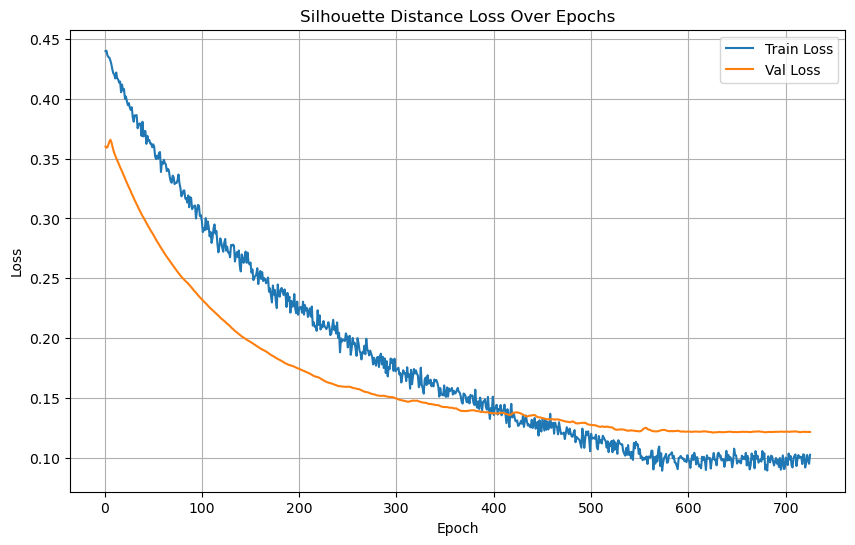

In [51]:
sclsdl_model = SupConNet().to(device)
sclsdl_criterion = SilhouetteDistanceLoss()
sclsdl_optimizer = optim.AdamW(sclsdl_model.parameters(), lr=0.0001, weight_decay=1e-5)
sclsdl_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    sclsdl_optimizer, 
    mode='min',
    patience=25,
    factor=0.1
)

sclsdl_num_epochs = 2000

sclsdl_patience = 100
sclsdl_best_val_loss = float('inf')
sclsdl_epochs_without_improvement = 0

sclsdl_train_loss_history = []
sclsdl_val_loss_history = []

for sclsdl_epoch in range(sclsdl_num_epochs):
    # Training
    sclsdl_model.train()
    sclsdl_running_train_loss = 0.0
    
    print(f"LOG: Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}] - Training")
    for batch_idx, (vectors, labels) in enumerate(sclsdl_train_loader):

        vectors = vectors.to(device).float()
        labels = labels.to(device)

        # Forward pass
        sclsdl_train_projections = sclsdl_model(vectors)

        sclsdl_loss = sclsdl_criterion(sclsdl_train_projections, labels)

        # Backprop and optimize
        sclsdl_optimizer.zero_grad()
        sclsdl_loss.backward()
        sclsdl_optimizer.step()

        sclsdl_running_train_loss += sclsdl_loss.item()
        print(f"    Batch [{batch_idx+1}/{len(sclsdl_train_loader)}], Train Loss: {sclsdl_loss.item():.4f}")

    sclsdl_train_epoch_loss = sclsdl_running_train_loss / len(sclsdl_train_loader)
    sclsdl_train_loss_history.append(sclsdl_train_epoch_loss)

    # Validation
    sclsdl_model.eval()
    sclsdl_running_val_loss = 0.0
    print(f"LOG: Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}] - Validation")
    with torch.no_grad():
        for val_batch_idx, (vectors, labels) in enumerate(sclsdl_val_loader):

            vectors = vectors.to(device).float()
            labels = labels.to(device)

            sclsdl_val_projections = sclsdl_model(vectors)
            sclsdl_val_batch_loss = sclsdl_criterion(sclsdl_val_projections, labels).item()
            sclsdl_running_val_loss += sclsdl_val_batch_loss
            print(f"    Batch [{val_batch_idx+1}/{len(sclsdl_val_loader)}], Val Loss: {sclsdl_val_batch_loss:.4f}")

    sclsdl_val_epoch_loss = sclsdl_running_val_loss / len(sclsdl_val_loader)
    sclsdl_val_loss_history.append(sclsdl_val_epoch_loss)
    
    sclsdl_scheduler.step(sclsdl_val_epoch_loss)

    print(f"Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}], "
          f"Avg Train Loss: {sclsdl_train_epoch_loss:.4f}, "
          f"Avg Val Loss: {sclsdl_val_epoch_loss:.4f}\n")
    
    #early stopping logic
    if sclsdl_val_epoch_loss < sclsdl_best_val_loss:
        print(f"Validation loss improved from {sclsdl_best_val_loss:.4f} to {sclsdl_val_epoch_loss:.4f}. Saving model...")
        sclsdl_best_val_loss = sclsdl_val_epoch_loss
        sclsdl_epochs_without_improvement = 0
    else:
        sclsdl_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! Patience: {sclsdl_epochs_without_improvement}/{sclsdl_patience}")

    #stop training if val loss not improving
    if sclsdl_epochs_without_improvement >= sclsdl_patience:
        print(f"!! Early stopping triggered at epoch {sclsdl_epoch + 1}!!\nNo improvement for {sclsdl_patience} epochs")
        break

plt.figure(figsize=(10,6))
sclsdl_num_epochs_run = len(sclsdl_train_loss_history)
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_train_loss_history, label='Train Loss')
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_val_loss_history, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Silhouette Distance Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

Test Batch [10/2309], Loss: 0.0761
Test Batch [20/2309], Loss: 0.0631
Test Batch [30/2309], Loss: 0.5000
Test Batch [40/2309], Loss: 0.0224
Test Batch [50/2309], Loss: 0.5000
Test Batch [60/2309], Loss: 0.5000
Test Batch [70/2309], Loss: 0.5000


Test Batch [80/2309], Loss: 0.0403
Test Batch [90/2309], Loss: 0.5000
Test Batch [100/2309], Loss: 0.0345
Test Batch [110/2309], Loss: 0.5000
Test Batch [120/2309], Loss: 0.0494
Test Batch [130/2309], Loss: 0.5000
Test Batch [140/2309], Loss: 0.5000


Test Batch [150/2309], Loss: 0.5000
Test Batch [160/2309], Loss: 0.0573
Test Batch [170/2309], Loss: 0.0235
Test Batch [180/2309], Loss: 0.5000
Test Batch [190/2309], Loss: 0.5000
Test Batch [200/2309], Loss: 0.0868
Test Batch [210/2309], Loss: 0.0081
Test Batch [220/2309], Loss: 0.5000


Test Batch [230/2309], Loss: 0.0627
Test Batch [240/2309], Loss: 0.5000
Test Batch [250/2309], Loss: 0.0486
Test Batch [260/2309], Loss: 0.0474
Test Batch [270/2309], Loss: 0.5000
Test Batch [280/2309], Loss: 0.5000
Test Batch [290/2309], Loss: 0.5000
Test Batch [300/2309], Loss: 0.0646
Test Batch [310/2309], Loss: 0.5000


Test Batch [320/2309], Loss: 0.0647
Test Batch [330/2309], Loss: 0.5000
Test Batch [340/2309], Loss: 0.5000
Test Batch [350/2309], Loss: 0.0177
Test Batch [360/2309], Loss: 0.0976
Test Batch [370/2309], Loss: 0.0405
Test Batch [380/2309], Loss: 0.0816


Test Batch [390/2309], Loss: 0.0555
Test Batch [400/2309], Loss: 0.0318
Test Batch [410/2309], Loss: 0.5000
Test Batch [420/2309], Loss: 0.0937
Test Batch [430/2309], Loss: 0.0199
Test Batch [440/2309], Loss: 0.5000


Test Batch [450/2309], Loss: 0.0540
Test Batch [460/2309], Loss: 0.5000
Test Batch [470/2309], Loss: 0.0074
Test Batch [480/2309], Loss: 0.0429
Test Batch [490/2309], Loss: 0.5000
Test Batch [500/2309], Loss: 0.0405


Test Batch [510/2309], Loss: 0.5000
Test Batch [520/2309], Loss: 0.0752
Test Batch [530/2309], Loss: 0.0483
Test Batch [540/2309], Loss: 0.5000
Test Batch [550/2309], Loss: 0.0574
Test Batch [560/2309], Loss: 0.0607
Test Batch [570/2309], Loss: 0.5000


Test Batch [580/2309], Loss: 0.5000
Test Batch [590/2309], Loss: 0.0930
Test Batch [600/2309], Loss: 0.0421
Test Batch [610/2309], Loss: 0.5000
Test Batch [620/2309], Loss: 0.5000


Test Batch [630/2309], Loss: 0.5000
Test Batch [640/2309], Loss: 0.0362
Test Batch [650/2309], Loss: 0.5000
Test Batch [660/2309], Loss: 0.0717
Test Batch [670/2309], Loss: 0.5000
Test Batch [680/2309], Loss: 0.0467


Test Batch [690/2309], Loss: 0.1055
Test Batch [700/2309], Loss: 0.5000
Test Batch [710/2309], Loss: 0.0442
Test Batch [720/2309], Loss: 0.5000
Test Batch [730/2309], Loss: 0.0624
Test Batch [740/2309], Loss: 0.5000
Test Batch [750/2309], Loss: 0.5000


Test Batch [760/2309], Loss: 0.0651
Test Batch [770/2309], Loss: 0.0547
Test Batch [780/2309], Loss: 0.5000
Test Batch [790/2309], Loss: 0.5000
Test Batch [800/2309], Loss: 0.0185
Test Batch [810/2309], Loss: 0.0343


Test Batch [820/2309], Loss: 0.1177
Test Batch [830/2309], Loss: 0.5000
Test Batch [840/2309], Loss: 0.0693
Test Batch [850/2309], Loss: 0.1725
Test Batch [860/2309], Loss: 0.1070
Test Batch [870/2309], Loss: 0.0379


Test Batch [880/2309], Loss: 0.5000
Test Batch [890/2309], Loss: 0.0341
Test Batch [900/2309], Loss: 0.5000
Test Batch [910/2309], Loss: 0.5000
Test Batch [920/2309], Loss: 0.0637
Test Batch [930/2309], Loss: 0.0387
Test Batch [940/2309], Loss: 0.5000
Test Batch [950/2309], Loss: 0.5000


Test Batch [960/2309], Loss: 0.0137
Test Batch [970/2309], Loss: 0.0490
Test Batch [980/2309], Loss: 0.1023
Test Batch [990/2309], Loss: 0.5000
Test Batch [1000/2309], Loss: 0.0763
Test Batch [1010/2309], Loss: 0.5000
Test Batch [1020/2309], Loss: 0.0466
Test Batch [1030/2309], Loss: 0.5000


Test Batch [1040/2309], Loss: 0.5000
Test Batch [1050/2309], Loss: 0.0388
Test Batch [1060/2309], Loss: 0.0687
Test Batch [1070/2309], Loss: 0.0964
Test Batch [1080/2309], Loss: 0.1119
Test Batch [1090/2309], Loss: 0.0148


Test Batch [1100/2309], Loss: 0.5000
Test Batch [1110/2309], Loss: 0.5000
Test Batch [1120/2309], Loss: 0.0787
Test Batch [1130/2309], Loss: 0.0196


Test Batch [1140/2309], Loss: 0.0523
Test Batch [1150/2309], Loss: 0.1845
Test Batch [1160/2309], Loss: 0.0685
Test Batch [1170/2309], Loss: 0.0606
Test Batch [1180/2309], Loss: 0.5000


Test Batch [1190/2309], Loss: 0.0930
Test Batch [1200/2309], Loss: 0.0754
Test Batch [1210/2309], Loss: 0.0385
Test Batch [1220/2309], Loss: 0.0274
Test Batch [1230/2309], Loss: 0.0225


Test Batch [1240/2309], Loss: 0.1299
Test Batch [1250/2309], Loss: 0.5000
Test Batch [1260/2309], Loss: 0.1339
Test Batch [1270/2309], Loss: 0.0671


Test Batch [1280/2309], Loss: 0.0570
Test Batch [1290/2309], Loss: 0.0514
Test Batch [1300/2309], Loss: 0.1302


Test Batch [1310/2309], Loss: 0.0651
Test Batch [1320/2309], Loss: 0.1477
Test Batch [1330/2309], Loss: 0.1245
Test Batch [1340/2309], Loss: 0.0269


Test Batch [1350/2309], Loss: 0.1741
Test Batch [1360/2309], Loss: 0.1898
Test Batch [1370/2309], Loss: 0.1080


Test Batch [1380/2309], Loss: 0.1259
Test Batch [1390/2309], Loss: 0.0893
Test Batch [1400/2309], Loss: 0.0974
Test Batch [1410/2309], Loss: 0.0925


Test Batch [1420/2309], Loss: 0.0934
Test Batch [1430/2309], Loss: 0.5000
Test Batch [1440/2309], Loss: 0.0529
Test Batch [1450/2309], Loss: 0.1182


Test Batch [1460/2309], Loss: 0.0776
Test Batch [1470/2309], Loss: 0.5000
Test Batch [1480/2309], Loss: 0.0885
Test Batch [1490/2309], Loss: 0.0674
Test Batch [1500/2309], Loss: 0.0674


Test Batch [1510/2309], Loss: 0.0708
Test Batch [1520/2309], Loss: 0.5000
Test Batch [1530/2309], Loss: 0.0637
Test Batch [1540/2309], Loss: 0.0982


Test Batch [1550/2309], Loss: 0.0724
Test Batch [1560/2309], Loss: 0.0692
Test Batch [1570/2309], Loss: 0.1144
Test Batch [1580/2309], Loss: 0.0722


Test Batch [1590/2309], Loss: 0.0762
Test Batch [1600/2309], Loss: 0.0603
Test Batch [1610/2309], Loss: 0.0744
Test Batch [1620/2309], Loss: 0.2157


Test Batch [1630/2309], Loss: 0.2322
Test Batch [1640/2309], Loss: 0.1692
Test Batch [1650/2309], Loss: 0.0228
Test Batch [1660/2309], Loss: 0.1298


Test Batch [1670/2309], Loss: 0.1442
Test Batch [1680/2309], Loss: 0.1087
Test Batch [1690/2309], Loss: 0.0891
Test Batch [1700/2309], Loss: 0.0973


Test Batch [1710/2309], Loss: 0.0482
Test Batch [1720/2309], Loss: 0.5000
Test Batch [1730/2309], Loss: 0.0612
Test Batch [1740/2309], Loss: 0.5000
Test Batch [1750/2309], Loss: 0.0437
Test Batch [1760/2309], Loss: 0.0527
Test Batch [1770/2309], Loss: 0.0444


Test Batch [1780/2309], Loss: 0.0601
Test Batch [1790/2309], Loss: 0.0726
Test Batch [1800/2309], Loss: 0.0746
Test Batch [1810/2309], Loss: 0.1152
Test Batch [1820/2309], Loss: 0.0840
Test Batch [1830/2309], Loss: 0.0745


Test Batch [1840/2309], Loss: 0.5000
Test Batch [1850/2309], Loss: 0.1415
Test Batch [1860/2309], Loss: 0.0616
Test Batch [1870/2309], Loss: 0.0733
Test Batch [1880/2309], Loss: 0.0623


Test Batch [1890/2309], Loss: 0.0824
Test Batch [1900/2309], Loss: 0.1390
Test Batch [1910/2309], Loss: 0.1406
Test Batch [1920/2309], Loss: 0.0926


Test Batch [1930/2309], Loss: 0.0785
Test Batch [1940/2309], Loss: 0.0518
Test Batch [1950/2309], Loss: 0.1171
Test Batch [1960/2309], Loss: 0.1237
Test Batch [1970/2309], Loss: 0.0801


Test Batch [1980/2309], Loss: 0.0478
Test Batch [1990/2309], Loss: 0.0489
Test Batch [2000/2309], Loss: 0.0577
Test Batch [2010/2309], Loss: 0.0422
Test Batch [2020/2309], Loss: 0.0499
Test Batch [2030/2309], Loss: 0.0700


Test Batch [2040/2309], Loss: 0.0583
Test Batch [2050/2309], Loss: 0.0534
Test Batch [2060/2309], Loss: 0.1207
Test Batch [2070/2309], Loss: 0.0750
Test Batch [2080/2309], Loss: 0.2174
Test Batch [2090/2309], Loss: 0.5000


Test Batch [2100/2309], Loss: 0.0587
Test Batch [2110/2309], Loss: 0.1570
Test Batch [2120/2309], Loss: 0.1173
Test Batch [2130/2309], Loss: 0.5000
Test Batch [2140/2309], Loss: 0.5000
Test Batch [2150/2309], Loss: 0.5000


Test Batch [2160/2309], Loss: 0.5000
Test Batch [2170/2309], Loss: 0.0145
Test Batch [2180/2309], Loss: 0.5000
Test Batch [2190/2309], Loss: 0.0234
Test Batch [2200/2309], Loss: 0.1031
Test Batch [2210/2309], Loss: 0.5000


Test Batch [2220/2309], Loss: 0.5000
Test Batch [2230/2309], Loss: 0.5000
Test Batch [2240/2309], Loss: 0.5000
Test Batch [2250/2309], Loss: 0.5000
Test Batch [2260/2309], Loss: 0.5000
Test Batch [2270/2309], Loss: 0.5000


Test Batch [2280/2309], Loss: 0.0615
Test Batch [2290/2309], Loss: 0.5000
Test Batch [2300/2309], Loss: 0.5000

Test Loss: 0.2021


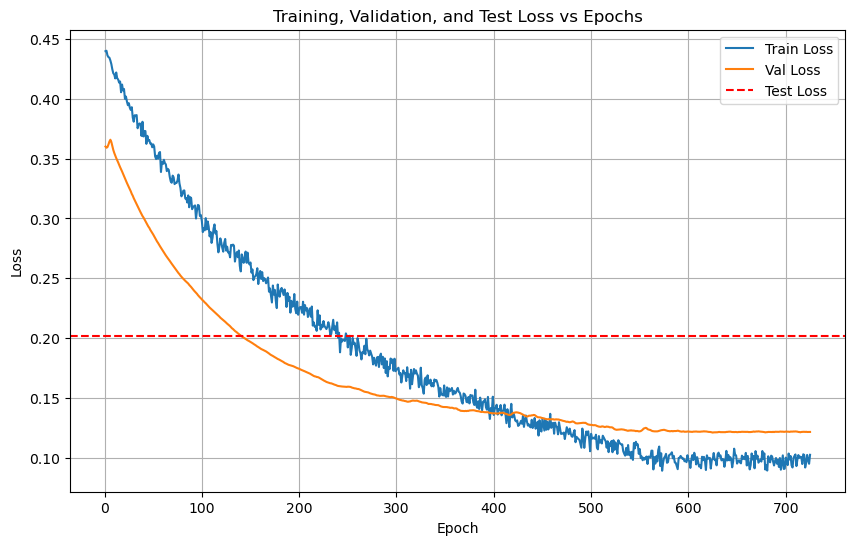

In [52]:
# Test Evaluation
sclsdl_model.eval()
sclsdl_total_test_loss = 0.0

with torch.no_grad():
    for batch_idx, (vectors, labels) in enumerate(sclsdl_test_loader):
        vectors = vectors.to(device).float()
        labels = labels.to(device)
        projections = sclsdl_model(vectors)
        loss = sclsdl_criterion(projections, labels)
        sclsdl_total_test_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:
            print(f"Test Batch [{batch_idx + 1}/{len(sclsdl_test_loader)}], Loss: {loss.item():.4f}")

sclsdl_avg_test_loss = sclsdl_total_test_loss / len(sclsdl_test_loader)
print(f"\nTest Loss: {sclsdl_avg_test_loss:.4f}")


plt.figure(figsize=(10, 6))
sclsdl_num_epochs_run = len(sclsdl_train_loss_history)
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_train_loss_history, label='Train Loss')
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_val_loss_history, label='Val Loss')
# test loss = horizontal dashed line
plt.axhline(y=sclsdl_avg_test_loss, color='r', linestyle='--', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

### Saving the representations learnt by SCL w/ SDL Model

In [53]:
# dir to save the SCL representations
sclsdl_rep_dir = "sclsdl_representations"
os.makedirs(sclsdl_rep_dir, exist_ok=True)

sclsdl_loaders = {
    'train': sclsdl_train_loader,
    'val': sclsdl_val_loader,
    'test': sclsdl_test_loader
}

sclsdl_model.eval()

with torch.no_grad():
    for sclsdl_split_name, sclsdl_loader in sclsdl_loaders.items():
        print(f"\nExtracting SCL_SDL representations for the {sclsdl_split_name} dataset...")
        # creating subfolder for the split
        sclsdl_split_dir = os.path.join(sclsdl_rep_dir, sclsdl_split_name)
        os.makedirs(sclsdl_split_dir, exist_ok=True)
        
        # processing the data batch-wise
        for sclsdl_batch_idx, (sclsdl_vectors, sclsdl_labels) in enumerate(sclsdl_loader):
            sclsdl_vectors = sclsdl_vectors.to(device).float()
            # computing projections using the trained SCL model
            sclsdl_projections = sclsdl_model(sclsdl_vectors)
            
            # converting projections and labels to np arrays
            sclsdl_projections_np = sclsdl_projections.cpu().numpy()
            sclsdl_labels_np = sclsdl_labels.cpu().numpy()
            
            # saving the batch projections and labels
            np.save(os.path.join(sclsdl_split_dir, f"scl_encoded_batch_{sclsdl_batch_idx}.npy"), sclsdl_projections_np)
            np.save(os.path.join(sclsdl_split_dir, f"scl_labels_batch_{sclsdl_batch_idx}.npy"), sclsdl_labels_np)
            
            if (sclsdl_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {sclsdl_batch_idx + 1}/{len(sclsdl_loader)} for {sclsdl_split_name} dataset.")

        print(f"Completed extraction for the {sclsdl_split_name} dataset. Representations saved in '{sclsdl_split_dir}'.")

print("SCL representations extraction complete.")


Extracting SCL_SDL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'sclsdl_representations\train'.

Extracting SCL_SDL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'sclsdl_representations\val'.

Extracting SCL_SDL representations for the test dataset...
  Processed batch 10/2309 for test dataset.
  Processed batch 20/2309 for test dataset.


  Processed batch 30/2309 for test dataset.
  Processed batch 40/2309 for test dataset.
  Processed batch 50/2309 for test dataset.
  Processed batch 60/2309 for test dataset.


  Processed batch 70/2309 for test dataset.
  Processed batch 80/2309 for test dataset.
  Processed batch 90/2309 for test dataset.


  Processed batch 100/2309 for test dataset.
  Processed batch 110/2309 for test dataset.
  Processed batch 120/2309 for test dataset.
  Processed batch 130/2309 for test dataset.


  Processed batch 140/2309 for test dataset.
  Processed batch 150/2309 for test dataset.
  Processed batch 160/2309 for test dataset.


  Processed batch 170/2309 for test dataset.
  Processed batch 180/2309 for test dataset.
  Processed batch 190/2309 for test dataset.
  Processed batch 200/2309 for test dataset.


  Processed batch 210/2309 for test dataset.
  Processed batch 220/2309 for test dataset.
  Processed batch 230/2309 for test dataset.
  Processed batch 240/2309 for test dataset.


  Processed batch 250/2309 for test dataset.
  Processed batch 260/2309 for test dataset.
  Processed batch 270/2309 for test dataset.


  Processed batch 280/2309 for test dataset.
  Processed batch 290/2309 for test dataset.
  Processed batch 300/2309 for test dataset.


  Processed batch 310/2309 for test dataset.
  Processed batch 320/2309 for test dataset.
  Processed batch 330/2309 for test dataset.


  Processed batch 340/2309 for test dataset.
  Processed batch 350/2309 for test dataset.
  Processed batch 360/2309 for test dataset.


  Processed batch 370/2309 for test dataset.
  Processed batch 380/2309 for test dataset.
  Processed batch 390/2309 for test dataset.


  Processed batch 400/2309 for test dataset.
  Processed batch 410/2309 for test dataset.
  Processed batch 420/2309 for test dataset.


  Processed batch 430/2309 for test dataset.
  Processed batch 440/2309 for test dataset.
  Processed batch 450/2309 for test dataset.
  Processed batch 460/2309 for test dataset.


  Processed batch 470/2309 for test dataset.
  Processed batch 480/2309 for test dataset.
  Processed batch 490/2309 for test dataset.
  Processed batch 500/2309 for test dataset.


  Processed batch 510/2309 for test dataset.
  Processed batch 520/2309 for test dataset.
  Processed batch 530/2309 for test dataset.
  Processed batch 540/2309 for test dataset.


  Processed batch 550/2309 for test dataset.
  Processed batch 560/2309 for test dataset.
  Processed batch 570/2309 for test dataset.


  Processed batch 580/2309 for test dataset.
  Processed batch 590/2309 for test dataset.
  Processed batch 600/2309 for test dataset.
  Processed batch 610/2309 for test dataset.


  Processed batch 620/2309 for test dataset.
  Processed batch 630/2309 for test dataset.
  Processed batch 640/2309 for test dataset.


  Processed batch 650/2309 for test dataset.
  Processed batch 660/2309 for test dataset.
  Processed batch 670/2309 for test dataset.
  Processed batch 680/2309 for test dataset.


  Processed batch 690/2309 for test dataset.
  Processed batch 700/2309 for test dataset.
  Processed batch 710/2309 for test dataset.


  Processed batch 720/2309 for test dataset.
  Processed batch 730/2309 for test dataset.
  Processed batch 740/2309 for test dataset.
  Processed batch 750/2309 for test dataset.


  Processed batch 760/2309 for test dataset.
  Processed batch 770/2309 for test dataset.
  Processed batch 780/2309 for test dataset.
  Processed batch 790/2309 for test dataset.


  Processed batch 800/2309 for test dataset.
  Processed batch 810/2309 for test dataset.
  Processed batch 820/2309 for test dataset.


  Processed batch 830/2309 for test dataset.
  Processed batch 840/2309 for test dataset.
  Processed batch 850/2309 for test dataset.


  Processed batch 860/2309 for test dataset.
  Processed batch 870/2309 for test dataset.
  Processed batch 880/2309 for test dataset.
  Processed batch 890/2309 for test dataset.


  Processed batch 900/2309 for test dataset.
  Processed batch 910/2309 for test dataset.


  Processed batch 920/2309 for test dataset.
  Processed batch 930/2309 for test dataset.
  Processed batch 940/2309 for test dataset.
  Processed batch 950/2309 for test dataset.


  Processed batch 960/2309 for test dataset.
  Processed batch 970/2309 for test dataset.
  Processed batch 980/2309 for test dataset.


  Processed batch 990/2309 for test dataset.
  Processed batch 1000/2309 for test dataset.
  Processed batch 1010/2309 for test dataset.
  Processed batch 1020/2309 for test dataset.


  Processed batch 1030/2309 for test dataset.
  Processed batch 1040/2309 for test dataset.
  Processed batch 1050/2309 for test dataset.
  Processed batch 1060/2309 for test dataset.


  Processed batch 1070/2309 for test dataset.
  Processed batch 1080/2309 for test dataset.


  Processed batch 1090/2309 for test dataset.
  Processed batch 1100/2309 for test dataset.
  Processed batch 1110/2309 for test dataset.


  Processed batch 1120/2309 for test dataset.
  Processed batch 1130/2309 for test dataset.
  Processed batch 1140/2309 for test dataset.
  Processed batch 1150/2309 for test dataset.


  Processed batch 1160/2309 for test dataset.
  Processed batch 1170/2309 for test dataset.


  Processed batch 1180/2309 for test dataset.
  Processed batch 1190/2309 for test dataset.


  Processed batch 1200/2309 for test dataset.
  Processed batch 1210/2309 for test dataset.
  Processed batch 1220/2309 for test dataset.


  Processed batch 1230/2309 for test dataset.
  Processed batch 1240/2309 for test dataset.
  Processed batch 1250/2309 for test dataset.


  Processed batch 1260/2309 for test dataset.
  Processed batch 1270/2309 for test dataset.
  Processed batch 1280/2309 for test dataset.


  Processed batch 1290/2309 for test dataset.
  Processed batch 1300/2309 for test dataset.
  Processed batch 1310/2309 for test dataset.
  Processed batch 1320/2309 for test dataset.


  Processed batch 1330/2309 for test dataset.
  Processed batch 1340/2309 for test dataset.
  Processed batch 1350/2309 for test dataset.
  Processed batch 1360/2309 for test dataset.


  Processed batch 1370/2309 for test dataset.
  Processed batch 1380/2309 for test dataset.


  Processed batch 1390/2309 for test dataset.
  Processed batch 1400/2309 for test dataset.
  Processed batch 1410/2309 for test dataset.


  Processed batch 1420/2309 for test dataset.
  Processed batch 1430/2309 for test dataset.
  Processed batch 1440/2309 for test dataset.


  Processed batch 1450/2309 for test dataset.
  Processed batch 1460/2309 for test dataset.
  Processed batch 1470/2309 for test dataset.


  Processed batch 1480/2309 for test dataset.
  Processed batch 1490/2309 for test dataset.
  Processed batch 1500/2309 for test dataset.


  Processed batch 1510/2309 for test dataset.
  Processed batch 1520/2309 for test dataset.


  Processed batch 1530/2309 for test dataset.
  Processed batch 1540/2309 for test dataset.
  Processed batch 1550/2309 for test dataset.
  Processed batch 1560/2309 for test dataset.


  Processed batch 1570/2309 for test dataset.
  Processed batch 1580/2309 for test dataset.
  Processed batch 1590/2309 for test dataset.
  Processed batch 1600/2309 for test dataset.


  Processed batch 1610/2309 for test dataset.
  Processed batch 1620/2309 for test dataset.
  Processed batch 1630/2309 for test dataset.
  Processed batch 1640/2309 for test dataset.


  Processed batch 1650/2309 for test dataset.
  Processed batch 1660/2309 for test dataset.
  Processed batch 1670/2309 for test dataset.
  Processed batch 1680/2309 for test dataset.


  Processed batch 1690/2309 for test dataset.
  Processed batch 1700/2309 for test dataset.
  Processed batch 1710/2309 for test dataset.
  Processed batch 1720/2309 for test dataset.


  Processed batch 1730/2309 for test dataset.
  Processed batch 1740/2309 for test dataset.
  Processed batch 1750/2309 for test dataset.
  Processed batch 1760/2309 for test dataset.


  Processed batch 1770/2309 for test dataset.
  Processed batch 1780/2309 for test dataset.
  Processed batch 1790/2309 for test dataset.
  Processed batch 1800/2309 for test dataset.


  Processed batch 1810/2309 for test dataset.
  Processed batch 1820/2309 for test dataset.
  Processed batch 1830/2309 for test dataset.


  Processed batch 1840/2309 for test dataset.
  Processed batch 1850/2309 for test dataset.
  Processed batch 1860/2309 for test dataset.
  Processed batch 1870/2309 for test dataset.


  Processed batch 1880/2309 for test dataset.
  Processed batch 1890/2309 for test dataset.
  Processed batch 1900/2309 for test dataset.
  Processed batch 1910/2309 for test dataset.


  Processed batch 1920/2309 for test dataset.
  Processed batch 1930/2309 for test dataset.
  Processed batch 1940/2309 for test dataset.


  Processed batch 1950/2309 for test dataset.
  Processed batch 1960/2309 for test dataset.
  Processed batch 1970/2309 for test dataset.
  Processed batch 1980/2309 for test dataset.


  Processed batch 1990/2309 for test dataset.
  Processed batch 2000/2309 for test dataset.


  Processed batch 2010/2309 for test dataset.
  Processed batch 2020/2309 for test dataset.
  Processed batch 2030/2309 for test dataset.


  Processed batch 2040/2309 for test dataset.
  Processed batch 2050/2309 for test dataset.
  Processed batch 2060/2309 for test dataset.


  Processed batch 2070/2309 for test dataset.
  Processed batch 2080/2309 for test dataset.
  Processed batch 2090/2309 for test dataset.


  Processed batch 2100/2309 for test dataset.
  Processed batch 2110/2309 for test dataset.
  Processed batch 2120/2309 for test dataset.
  Processed batch 2130/2309 for test dataset.


  Processed batch 2140/2309 for test dataset.
  Processed batch 2150/2309 for test dataset.
  Processed batch 2160/2309 for test dataset.
  Processed batch 2170/2309 for test dataset.


  Processed batch 2180/2309 for test dataset.
  Processed batch 2190/2309 for test dataset.
  Processed batch 2200/2309 for test dataset.


  Processed batch 2210/2309 for test dataset.
  Processed batch 2220/2309 for test dataset.
  Processed batch 2230/2309 for test dataset.
  Processed batch 2240/2309 for test dataset.


  Processed batch 2250/2309 for test dataset.
  Processed batch 2260/2309 for test dataset.
  Processed batch 2270/2309 for test dataset.
  Processed batch 2280/2309 for test dataset.


  Processed batch 2290/2309 for test dataset.
  Processed batch 2300/2309 for test dataset.
Completed extraction for the test dataset. Representations saved in 'sclsdl_representations\test'.
SCL representations extraction complete.


### Classifying the representations learnt by SCL w/ SDL Model with LRM

In [54]:
def load_sclsdl_reps_and_labels(split_dir):
    #gather all the scl_encoded_batch npy files in sorted order
    sclsdl_rep_files = sorted(glob.glob(os.path.join(split_dir, "scl_encoded_batch_*.npy")))

    sclsdl_all_reps = []
    sclsdl_all_labels = []

    for sclsdl_rep_file in sclsdl_rep_files:
        #deriving label filenames
        sclsdl_label_file = sclsdl_rep_file.replace("scl_encoded_batch_", "scl_labels_batch_")

        sclsdl_reps = np.load(sclsdl_rep_file)
        sclsdl_labels = np.load(sclsdl_label_file)

        sclsdl_all_reps.append(sclsdl_reps)
        sclsdl_all_labels.append(sclsdl_labels)

    #concat along first dim
    sclsdl_all_reps = np.concatenate(sclsdl_all_reps, axis = 0)
    sclsdl_all_labels = np.concatenate(sclsdl_all_labels, axis = 0)

    return sclsdl_all_reps, sclsdl_all_labels

In [55]:
sclsdl_lrm_train_dir = os.path.join("sclsdl_representations", "train")
sclsdl_lrm_val_dir   = os.path.join("sclsdl_representations", "val")
sclsdl_lrm_test_dir  = os.path.join("sclsdl_representations", "test")

sclsdl_lrm_train_reps, sclsdl_lrm_train_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_train_dir)
sclsdl_lrm_val_reps, sclsdl_lrm_val_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_val_dir)
sclsdl_lrm_test_reps, sclsdl_lrm_test_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_test_dir)

print("Train reps shape:", sclsdl_lrm_train_reps.shape)
print("Train labels shape:", sclsdl_lrm_train_labels.shape)

print("Val reps shape:", sclsdl_lrm_val_reps.shape)
print("Val labels shape:", sclsdl_lrm_val_labels.shape)

print("Test reps shape:", sclsdl_lrm_test_reps.shape)
print("Test labels shape:", sclsdl_lrm_test_labels.shape)

Train reps shape: (360, 128)
Train labels shape: (360,)
Val reps shape: (45, 128)
Val labels shape: (45,)
Test reps shape: (147747, 128)
Test labels shape: (147747,)


In [56]:
# Train Logistic Regression Model on the SCLSDL representations
print("\nLOG: Training Logistic Regression model on SCL SDL representations...")
sclsdl_logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')
sclsdl_logistic_clf.fit(sclsdl_lrm_train_reps, sclsdl_lrm_train_labels)
print("LOG: Logistic Regression training complete.")

# Evaluate on Validation Set
print("\nLOG: Evaluating on the validation set...")
sclsdl_lrm_val_predictions = sclsdl_logistic_clf.predict(sclsdl_lrm_val_reps)
sclsdl_lrm_val_accuracy = accuracy_score(sclsdl_lrm_val_labels, sclsdl_lrm_val_predictions)
print(f"Validation Accuracy: {sclsdl_lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(sclsdl_lrm_val_labels, sclsdl_lrm_val_predictions))

# Evaluate on Test Set
print("\nLOG: Evaluating on the test set...")
sclsdl_lrm_test_predictions = sclsdl_logistic_clf.predict(sclsdl_lrm_test_reps)
sclsdl_lrm_test_accuracy = accuracy_score(sclsdl_lrm_test_labels, sclsdl_lrm_test_predictions)
print(f"Test Accuracy: {sclsdl_lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(sclsdl_lrm_test_labels, sclsdl_lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'sclsdl_lrm_predictions.npy'), sclsdl_lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'sclsdl_lrm_true_labels.npy'), sclsdl_lrm_test_labels)
print(f"Saved SCL_SDL+LRM predictions and true labels to {predictions_dir}")


LOG: Training Logistic Regression model on SCL SDL representations...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 97.78%

Validation Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       0.83      1.00      0.91         5
           2       1.00      0.80      0.89         5
           3       1.00      1.00      1.00         5
           4       1.00      1.00      1.00         5
           5       1.00      1.00      1.00         5
           6       1.00      1.00      1.00         5
           7       1.00      1.00      1.00         5
           8       1.00      1.00      1.00         5

    accuracy                           0.98        45
   macro avg       0.98      0.98      0.98        45
weighted avg       0.98      0.98      0.98        45


LOG: Evaluating on the test set...
Test Accuracy: 96.30%



Test Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      1.00     65926
           1       0.98      0.90      0.94      7553
           2       0.78      0.85      0.81      3045
           3       0.63      0.94      0.75      2640
           4       0.90      0.86      0.88      6539
           5       0.85      0.94      0.89      9203
           6       0.90      0.87      0.89      7242
           7       0.99      0.98      0.99     42781
           8       0.99      0.93      0.96      2818

    accuracy                           0.96    147747
   macro avg       0.89      0.92      0.90    147747
weighted avg       0.97      0.96      0.96    147747

Saved SCL_SDL+LRM predictions and true labels to model_predictions


## Classifying the representations learnt by SCL w/ SDL Model with MLP Classifier

In [57]:
sclsdl_mlp_train_dir = os.path.join("sclsdl_representations", "train")
sclsdl_mlp_val_dir   = os.path.join("sclsdl_representations", "val")
sclsdl_mlp_test_dir  = os.path.join("sclsdl_representations", "test")

sclsdl_mlp_train_reps, sclsdl_mlp_train_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_train_dir)
sclsdl_mlp_val_reps, sclsdl_mlp_val_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_val_dir)
sclsdl_mlp_test_reps, sclsdl_mlp_test_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_test_dir)

print("Train reps shape:", sclsdl_mlp_train_reps.shape)
print("Train labels shape:", sclsdl_mlp_train_labels.shape)

print("Val reps shape:", sclsdl_mlp_val_reps.shape)
print("Val labels shape:", sclsdl_mlp_val_labels.shape)

print("Test reps shape:", sclsdl_mlp_test_reps.shape)
print("Test labels shape:", sclsdl_mlp_test_labels.shape)

Train reps shape: (360, 128)
Train labels shape: (360,)
Val reps shape: (45, 128)
Val labels shape: (45,)
Test reps shape: (147747, 128)
Test labels shape: (147747,)


In [58]:
#converting arrays to torch tensors
sclsdl_mlp_train_embeddings_torch = torch.tensor(sclsdl_mlp_train_reps, dtype=torch.float32)
sclsdl_mlp_train_labels_torch = torch.tensor(sclsdl_mlp_train_labels, dtype=torch.long)

sclsdl_mlp_val_embeddings_torch = torch.tensor(sclsdl_mlp_val_reps, dtype=torch.float32)
sclsdl_mlp_val_labels_torch = torch.tensor(sclsdl_mlp_val_labels, dtype=torch.long)

sclsdl_mlp_test_embeddings_torch = torch.tensor(sclsdl_mlp_test_reps, dtype=torch.float32)
sclsdl_mlp_test_labels_torch = torch.tensor(sclsdl_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
sclsdl_mlp_train_dataset = TensorDataset(sclsdl_mlp_train_embeddings_torch, sclsdl_mlp_train_labels_torch)
sclsdl_mlp_val_dataset = TensorDataset(sclsdl_mlp_val_embeddings_torch, sclsdl_mlp_val_labels_torch)
sclsdl_mlp_test_dataset = TensorDataset(sclsdl_mlp_test_embeddings_torch, sclsdl_mlp_test_labels_torch)

sclsdl_mlp_batch_size = 64
sclsdl_mlp_train_loader = DataLoader(sclsdl_mlp_train_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=True)
sclsdl_mlp_val_loader = DataLoader(sclsdl_mlp_val_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=False)
sclsdl_mlp_test_loader = DataLoader(sclsdl_mlp_test_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.4161  |  Val Loss: 2.3192
Validation loss improved from inf to 2.3192.
[Epoch 2/1000] Train Loss: 2.2727  |  Val Loss: 2.1919
Validation loss improved from 2.3192 to 2.1919.
[Epoch 3/1000] Train Loss: 2.1475  |  Val Loss: 2.0837
Validation loss improved from 2.1919 to 2.0837.
[Epoch 4/1000] Train Loss: 2.0390  |  Val Loss: 1.9947
Validation loss improved from 2.0837 to 1.9947.
[Epoch 5/1000] Train Loss: 1.9485  |  Val Loss: 1.9162
Validation loss improved from 1.9947 to 1.9162.
[Epoch 6/1000] Train Loss: 1.8638  |  Val Loss: 1.8465
Validation loss improved from 1.9162 to 1.8465.
[Epoch 7/1000] Train Loss: 1.7905  |  Val Loss: 1.7849
Validation loss improved from 1.8465 to 1.7849.
[Epoch 8/1000] Train Loss: 1.7232  |  Val Loss: 1.7245
Validation loss improved from 1.7849 to 1.7245.
[Epoch 9/1000] Train Loss: 1.6576  |  Val Loss: 1.6686
Validation loss improved from 1.7245 to 1.6686.
[Epoch 10/1000] Train Loss: 1.6007  |  Val Loss: 1.6178
Validation loss impr

[Epoch 14/1000] Train Loss: 1.4111  |  Val Loss: 1.4509
Validation loss improved from 1.4887 to 1.4509.
[Epoch 15/1000] Train Loss: 1.3725  |  Val Loss: 1.4155
Validation loss improved from 1.4509 to 1.4155.
[Epoch 16/1000] Train Loss: 1.3360  |  Val Loss: 1.3825
Validation loss improved from 1.4155 to 1.3825.
[Epoch 17/1000] Train Loss: 1.3014  |  Val Loss: 1.3514
Validation loss improved from 1.3825 to 1.3514.
[Epoch 18/1000] Train Loss: 1.2677  |  Val Loss: 1.3214
Validation loss improved from 1.3514 to 1.3214.


[Epoch 19/1000] Train Loss: 1.2346  |  Val Loss: 1.2919
Validation loss improved from 1.3214 to 1.2919.
[Epoch 20/1000] Train Loss: 1.2026  |  Val Loss: 1.2623
Validation loss improved from 1.2919 to 1.2623.
[Epoch 21/1000] Train Loss: 1.1706  |  Val Loss: 1.2335
Validation loss improved from 1.2623 to 1.2335.
[Epoch 22/1000] Train Loss: 1.1392  |  Val Loss: 1.2058
Validation loss improved from 1.2335 to 1.2058.
[Epoch 23/1000] Train Loss: 1.1093  |  Val Loss: 1.1781
Validation loss improved from 1.2058 to 1.1781.
[Epoch 24/1000] Train Loss: 1.0792  |  Val Loss: 1.1501
Validation loss improved from 1.1781 to 1.1501.
[Epoch 25/1000] Train Loss: 1.0499  |  Val Loss: 1.1222
Validation loss improved from 1.1501 to 1.1222.
[Epoch 26/1000] Train Loss: 1.0209  |  Val Loss: 1.0948
Validation loss improved from 1.1222 to 1.0948.
[Epoch 27/1000] Train Loss: 0.9922  |  Val Loss: 1.0680
Validation loss improved from 1.0948 to 1.0680.
[Epoch 28/1000] Train Loss: 0.9646  |  Val Loss: 1.0421
Validati

[Epoch 33/1000] Train Loss: 0.8389  |  Val Loss: 0.9200
Validation loss improved from 0.9429 to 0.9200.
[Epoch 34/1000] Train Loss: 0.8156  |  Val Loss: 0.8978
Validation loss improved from 0.9200 to 0.8978.
[Epoch 35/1000] Train Loss: 0.7939  |  Val Loss: 0.8758
Validation loss improved from 0.8978 to 0.8758.
[Epoch 36/1000] Train Loss: 0.7724  |  Val Loss: 0.8546
Validation loss improved from 0.8758 to 0.8546.


[Epoch 37/1000] Train Loss: 0.7512  |  Val Loss: 0.8341
Validation loss improved from 0.8546 to 0.8341.
[Epoch 38/1000] Train Loss: 0.7309  |  Val Loss: 0.8140
Validation loss improved from 0.8341 to 0.8140.
[Epoch 39/1000] Train Loss: 0.7115  |  Val Loss: 0.7942
Validation loss improved from 0.8140 to 0.7942.
[Epoch 40/1000] Train Loss: 0.6920  |  Val Loss: 0.7749
Validation loss improved from 0.7942 to 0.7749.
[Epoch 41/1000] Train Loss: 0.6732  |  Val Loss: 0.7563
Validation loss improved from 0.7749 to 0.7563.
[Epoch 42/1000] Train Loss: 0.6555  |  Val Loss: 0.7382
Validation loss improved from 0.7563 to 0.7382.
[Epoch 43/1000] Train Loss: 0.6382  |  Val Loss: 0.7199
Validation loss improved from 0.7382 to 0.7199.
[Epoch 44/1000] Train Loss: 0.6212  |  Val Loss: 0.7023
Validation loss improved from 0.7199 to 0.7023.
[Epoch 45/1000] Train Loss: 0.6049  |  Val Loss: 0.6859
Validation loss improved from 0.7023 to 0.6859.
[Epoch 46/1000] Train Loss: 0.5889  |  Val Loss: 0.6696
Validati

[Epoch 50/1000] Train Loss: 0.5283  |  Val Loss: 0.6066
Validation loss improved from 0.6220 to 0.6066.
[Epoch 51/1000] Train Loss: 0.5139  |  Val Loss: 0.5913
Validation loss improved from 0.6066 to 0.5913.
[Epoch 52/1000] Train Loss: 0.4996  |  Val Loss: 0.5755
Validation loss improved from 0.5913 to 0.5755.
[Epoch 53/1000] Train Loss: 0.4853  |  Val Loss: 0.5604
Validation loss improved from 0.5755 to 0.5604.
[Epoch 54/1000] Train Loss: 0.4715  |  Val Loss: 0.5456
Validation loss improved from 0.5604 to 0.5456.


[Epoch 55/1000] Train Loss: 0.4577  |  Val Loss: 0.5317
Validation loss improved from 0.5456 to 0.5317.
[Epoch 56/1000] Train Loss: 0.4440  |  Val Loss: 0.5183
Validation loss improved from 0.5317 to 0.5183.
[Epoch 57/1000] Train Loss: 0.4308  |  Val Loss: 0.5049
Validation loss improved from 0.5183 to 0.5049.
[Epoch 58/1000] Train Loss: 0.4178  |  Val Loss: 0.4908
Validation loss improved from 0.5049 to 0.4908.
[Epoch 59/1000] Train Loss: 0.4046  |  Val Loss: 0.4775
Validation loss improved from 0.4908 to 0.4775.
[Epoch 60/1000] Train Loss: 0.3921  |  Val Loss: 0.4632
Validation loss improved from 0.4775 to 0.4632.
[Epoch 61/1000] Train Loss: 0.3800  |  Val Loss: 0.4506
Validation loss improved from 0.4632 to 0.4506.
[Epoch 62/1000] Train Loss: 0.3676  |  Val Loss: 0.4372
Validation loss improved from 0.4506 to 0.4372.
[Epoch 63/1000] Train Loss: 0.3557  |  Val Loss: 0.4248
Validation loss improved from 0.4372 to 0.4248.
[Epoch 64/1000] Train Loss: 0.3444  |  Val Loss: 0.4126
Validati

[Epoch 68/1000] Train Loss: 0.3011  |  Val Loss: 0.3662
Validation loss improved from 0.3771 to 0.3662.
[Epoch 69/1000] Train Loss: 0.2914  |  Val Loss: 0.3555
Validation loss improved from 0.3662 to 0.3555.
[Epoch 70/1000] Train Loss: 0.2817  |  Val Loss: 0.3454
Validation loss improved from 0.3555 to 0.3454.
[Epoch 71/1000] Train Loss: 0.2730  |  Val Loss: 0.3354
Validation loss improved from 0.3454 to 0.3354.


[Epoch 72/1000] Train Loss: 0.2638  |  Val Loss: 0.3273
Validation loss improved from 0.3354 to 0.3273.
[Epoch 73/1000] Train Loss: 0.2555  |  Val Loss: 0.3192
Validation loss improved from 0.3273 to 0.3192.
[Epoch 74/1000] Train Loss: 0.2473  |  Val Loss: 0.3100
Validation loss improved from 0.3192 to 0.3100.
[Epoch 75/1000] Train Loss: 0.2394  |  Val Loss: 0.3022
Validation loss improved from 0.3100 to 0.3022.
[Epoch 76/1000] Train Loss: 0.2319  |  Val Loss: 0.2932
Validation loss improved from 0.3022 to 0.2932.
[Epoch 77/1000] Train Loss: 0.2245  |  Val Loss: 0.2846
Validation loss improved from 0.2932 to 0.2846.
[Epoch 78/1000] Train Loss: 0.2177  |  Val Loss: 0.2769
Validation loss improved from 0.2846 to 0.2769.
[Epoch 79/1000] Train Loss: 0.2106  |  Val Loss: 0.2686
Validation loss improved from 0.2769 to 0.2686.
[Epoch 80/1000] Train Loss: 0.2042  |  Val Loss: 0.2611
Validation loss improved from 0.2686 to 0.2611.
[Epoch 81/1000] Train Loss: 0.1980  |  Val Loss: 0.2540
Validati

[Epoch 86/1000] Train Loss: 0.1704  |  Val Loss: 0.2248
Validation loss improved from 0.2307 to 0.2248.


[Epoch 87/1000] Train Loss: 0.1655  |  Val Loss: 0.2210
Validation loss improved from 0.2248 to 0.2210.
[Epoch 88/1000] Train Loss: 0.1609  |  Val Loss: 0.2164
Validation loss improved from 0.2210 to 0.2164.
[Epoch 89/1000] Train Loss: 0.1565  |  Val Loss: 0.2108
Validation loss improved from 0.2164 to 0.2108.
[Epoch 90/1000] Train Loss: 0.1522  |  Val Loss: 0.2060
Validation loss improved from 0.2108 to 0.2060.
[Epoch 91/1000] Train Loss: 0.1482  |  Val Loss: 0.2009
Validation loss improved from 0.2060 to 0.2009.
[Epoch 92/1000] Train Loss: 0.1444  |  Val Loss: 0.1972
Validation loss improved from 0.2009 to 0.1972.
[Epoch 93/1000] Train Loss: 0.1409  |  Val Loss: 0.1941
Validation loss improved from 0.1972 to 0.1941.
[Epoch 94/1000] Train Loss: 0.1372  |  Val Loss: 0.1897
Validation loss improved from 0.1941 to 0.1897.
[Epoch 95/1000] Train Loss: 0.1337  |  Val Loss: 0.1857
Validation loss improved from 0.1897 to 0.1857.
[Epoch 96/1000] Train Loss: 0.1303  |  Val Loss: 0.1814
Validati

[Epoch 104/1000] Train Loss: 0.1086  |  Val Loss: 0.1575
Validation loss improved from 0.1599 to 0.1575.
[Epoch 105/1000] Train Loss: 0.1063  |  Val Loss: 0.1559
Validation loss improved from 0.1575 to 0.1559.
[Epoch 106/1000] Train Loss: 0.1041  |  Val Loss: 0.1539
Validation loss improved from 0.1559 to 0.1539.
[Epoch 107/1000] Train Loss: 0.1021  |  Val Loss: 0.1530
Validation loss improved from 0.1539 to 0.1530.
[Epoch 108/1000] Train Loss: 0.1004  |  Val Loss: 0.1498
Validation loss improved from 0.1530 to 0.1498.
[Epoch 109/1000] Train Loss: 0.0981  |  Val Loss: 0.1489
Validation loss improved from 0.1498 to 0.1489.
[Epoch 110/1000] Train Loss: 0.0962  |  Val Loss: 0.1475
Validation loss improved from 0.1489 to 0.1475.
[Epoch 111/1000] Train Loss: 0.0944  |  Val Loss: 0.1460
Validation loss improved from 0.1475 to 0.1460.
[Epoch 112/1000] Train Loss: 0.0926  |  Val Loss: 0.1445
Validation loss improved from 0.1460 to 0.1445.
[Epoch 113/1000] Train Loss: 0.0909  |  Val Loss: 0.142

[Epoch 121/1000] Train Loss: 0.0786  |  Val Loss: 0.1267
Validation loss improved from 0.1282 to 0.1267.
[Epoch 122/1000] Train Loss: 0.0772  |  Val Loss: 0.1266
Validation loss improved from 0.1267 to 0.1266.
[Epoch 123/1000] Train Loss: 0.0759  |  Val Loss: 0.1240
Validation loss improved from 0.1266 to 0.1240.
[Epoch 124/1000] Train Loss: 0.0746  |  Val Loss: 0.1224
Validation loss improved from 0.1240 to 0.1224.
[Epoch 125/1000] Train Loss: 0.0732  |  Val Loss: 0.1215
Validation loss improved from 0.1224 to 0.1215.
[Epoch 126/1000] Train Loss: 0.0720  |  Val Loss: 0.1197
Validation loss improved from 0.1215 to 0.1197.
[Epoch 127/1000] Train Loss: 0.0708  |  Val Loss: 0.1187
Validation loss improved from 0.1197 to 0.1187.
[Epoch 128/1000] Train Loss: 0.0697  |  Val Loss: 0.1175
Validation loss improved from 0.1187 to 0.1175.
[Epoch 129/1000] Train Loss: 0.0686  |  Val Loss: 0.1160
Validation loss improved from 0.1175 to 0.1160.
[Epoch 130/1000] Train Loss: 0.0674  |  Val Loss: 0.115

[Epoch 138/1000] Train Loss: 0.0597  |  Val Loss: 0.1082
Validation loss improved from 0.1090 to 0.1082.
[Epoch 139/1000] Train Loss: 0.0591  |  Val Loss: 0.1067
Validation loss improved from 0.1082 to 0.1067.
[Epoch 140/1000] Train Loss: 0.0582  |  Val Loss: 0.1076
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 141/1000] Train Loss: 0.0572  |  Val Loss: 0.1063
Validation loss improved from 0.1067 to 0.1063.
[Epoch 142/1000] Train Loss: 0.0564  |  Val Loss: 0.1046
Validation loss improved from 0.1063 to 0.1046.
[Epoch 143/1000] Train Loss: 0.0557  |  Val Loss: 0.1034
Validation loss improved from 0.1046 to 0.1034.
[Epoch 144/1000] Train Loss: 0.0549  |  Val Loss: 0.1021
Validation loss improved from 0.1034 to 0.1021.
[Epoch 145/1000] Train Loss: 0.0543  |  Val Loss: 0.1026
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 146/1000] Train Loss: 0.0535  |  Val Loss: 0.1028
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 147/1000] Train Loss: 0.0529  

[Epoch 155/1000] Train Loss: 0.0476  |  Val Loss: 0.0959
Validation loss improved from 0.0963 to 0.0959.
[Epoch 156/1000] Train Loss: 0.0471  |  Val Loss: 0.0950
Validation loss improved from 0.0959 to 0.0950.
[Epoch 157/1000] Train Loss: 0.0465  |  Val Loss: 0.0957
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 158/1000] Train Loss: 0.0460  |  Val Loss: 0.0958
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 159/1000] Train Loss: 0.0455  |  Val Loss: 0.0948
Validation loss improved from 0.0950 to 0.0948.
[Epoch 160/1000] Train Loss: 0.0450  |  Val Loss: 0.0945
Validation loss improved from 0.0948 to 0.0945.
[Epoch 161/1000] Train Loss: 0.0443  |  Val Loss: 0.0949
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 162/1000] Train Loss: 0.0439  |  Val Loss: 0.0962
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 163/1000] Train Loss: 0.0435  |  Val Loss: 0.0961
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 164/1000] Train Lo

[Epoch 172/1000] Train Loss: 0.0394  |  Val Loss: 0.0909
Validation loss improved from 0.0920 to 0.0909.
[Epoch 173/1000] Train Loss: 0.0391  |  Val Loss: 0.0909
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 174/1000] Train Loss: 0.0386  |  Val Loss: 0.0894
Validation loss improved from 0.0909 to 0.0894.
[Epoch 175/1000] Train Loss: 0.0383  |  Val Loss: 0.0882
Validation loss improved from 0.0894 to 0.0882.
[Epoch 176/1000] Train Loss: 0.0379  |  Val Loss: 0.0896
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 177/1000] Train Loss: 0.0377  |  Val Loss: 0.0888
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 178/1000] Train Loss: 0.0371  |  Val Loss: 0.0890
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 179/1000] Train Loss: 0.0367  |  Val Loss: 0.0910
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 180/1000] Train Loss: 0.0364  |  Val Loss: 0.0907
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 181/1000] Tr

[Epoch 187/1000] Train Loss: 0.0339  |  Val Loss: 0.0874
Validation loss improved from 0.0882 to 0.0874.
[Epoch 188/1000] Train Loss: 0.0337  |  Val Loss: 0.0866
Validation loss improved from 0.0874 to 0.0866.
[Epoch 189/1000] Train Loss: 0.0334  |  Val Loss: 0.0871
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 190/1000] Train Loss: 0.0331  |  Val Loss: 0.0866
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 191/1000] Train Loss: 0.0327  |  Val Loss: 0.0863
Validation loss improved from 0.0866 to 0.0863.
[Epoch 192/1000] Train Loss: 0.0324  |  Val Loss: 0.0860
Validation loss improved from 0.0863 to 0.0860.
[Epoch 193/1000] Train Loss: 0.0323  |  Val Loss: 0.0856
Validation loss improved from 0.0860 to 0.0856.
[Epoch 194/1000] Train Loss: 0.0321  |  Val Loss: 0.0850
Validation loss improved from 0.0856 to 0.0850.
[Epoch 195/1000] Train Loss: 0.0316  |  Val Loss: 0.0859
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 196/1000] Train Loss: 0.0317  

[Epoch 205/1000] Train Loss: 0.0291  |  Val Loss: 0.0840
Validation loss improved from 0.0844 to 0.0840.
[Epoch 206/1000] Train Loss: 0.0289  |  Val Loss: 0.0844
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 207/1000] Train Loss: 0.0286  |  Val Loss: 0.0843
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 208/1000] Train Loss: 0.0283  |  Val Loss: 0.0838
Validation loss improved from 0.0840 to 0.0838.
[Epoch 209/1000] Train Loss: 0.0281  |  Val Loss: 0.0833
Validation loss improved from 0.0838 to 0.0833.
[Epoch 210/1000] Train Loss: 0.0279  |  Val Loss: 0.0831
Validation loss improved from 0.0833 to 0.0831.
[Epoch 211/1000] Train Loss: 0.0278  |  Val Loss: 0.0837
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 212/1000] Train Loss: 0.0276  |  Val Loss: 0.0820
Validation loss improved from 0.0831 to 0.0820.
[Epoch 213/1000] Train Loss: 0.0273  |  Val Loss: 0.0822
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 214/1000] Train Loss: 0.

[Epoch 222/1000] Train Loss: 0.0257  |  Val Loss: 0.0827
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 223/1000] Train Loss: 0.0255  |  Val Loss: 0.0816
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 224/1000] Train Loss: 0.0252  |  Val Loss: 0.0811
Validation loss improved from 0.0813 to 0.0811.
[Epoch 225/1000] Train Loss: 0.0248  |  Val Loss: 0.0821
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 226/1000] Train Loss: 0.0247  |  Val Loss: 0.0825
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 227/1000] Train Loss: 0.0246  |  Val Loss: 0.0828
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 228/1000] Train Loss: 0.0246  |  Val Loss: 0.0841
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 229/1000] Train Loss: 0.0243  |  Val Loss: 0.0812
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 230/1000] Train Loss: 0.0240  |  Val Loss: 0.0806
Validation loss improved from 0.0811 to 0.0806.
[Epoch 231/10

[Epoch 238/1000] Train Loss: 0.0230  |  Val Loss: 0.0762
Validation loss improved from 0.0777 to 0.0762.
[Epoch 239/1000] Train Loss: 0.0227  |  Val Loss: 0.0769
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 240/1000] Train Loss: 0.0225  |  Val Loss: 0.0770
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 241/1000] Train Loss: 0.0223  |  Val Loss: 0.0784
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 242/1000] Train Loss: 0.0221  |  Val Loss: 0.0789
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 243/1000] Train Loss: 0.0221  |  Val Loss: 0.0799
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 244/1000] Train Loss: 0.0218  |  Val Loss: 0.0796
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 245/1000] Train Loss: 0.0217  |  Val Loss: 0.0786
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 246/1000] Train Loss: 0.0215  |  Val Loss: 0.0788
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 

[Epoch 256/1000] Train Loss: 0.0207  |  Val Loss: 0.0817
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 257/1000] Train Loss: 0.0202  |  Val Loss: 0.0813
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 258/1000] Train Loss: 0.0200  |  Val Loss: 0.0811
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 259/1000] Train Loss: 0.0199  |  Val Loss: 0.0798
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 260/1000] Train Loss: 0.0197  |  Val Loss: 0.0793
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 261/1000] Train Loss: 0.0197  |  Val Loss: 0.0780
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 262/1000] Train Loss: 0.0195  |  Val Loss: 0.0786
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 263/1000] Train Loss: 0.0197  |  Val Loss: 0.0810
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 264/1000] Train Loss: 0.0194  |  Val Loss: 0.0811
!! Validation loss did NOT improve !! Patience:

[Epoch 273/1000] Train Loss: 0.0183  |  Val Loss: 0.0770
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 274/1000] Train Loss: 0.0181  |  Val Loss: 0.0761
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 275/1000] Train Loss: 0.0179  |  Val Loss: 0.0775
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 276/1000] Train Loss: 0.0178  |  Val Loss: 0.0776
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 277/1000] Train Loss: 0.0180  |  Val Loss: 0.0761
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 278/1000] Train Loss: 0.0176  |  Val Loss: 0.0767
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 279/1000] Train Loss: 0.0177  |  Val Loss: 0.0758
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 280/1000] Train Loss: 0.0174  |  Val Loss: 0.0770
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 281/1000] Train Loss: 0.0173  |  Val Loss: 0.0776
!! Validation loss did NOT improve !! Patience: 13/1

[Epoch 290/1000] Train Loss: 0.0166  |  Val Loss: 0.0802
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 291/1000] Train Loss: 0.0166  |  Val Loss: 0.0797
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 292/1000] Train Loss: 0.0164  |  Val Loss: 0.0788
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 293/1000] Train Loss: 0.0164  |  Val Loss: 0.0785
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 294/1000] Train Loss: 0.0162  |  Val Loss: 0.0765
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 295/1000] Train Loss: 0.0165  |  Val Loss: 0.0741
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 296/1000] Train Loss: 0.0161  |  Val Loss: 0.0750
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 297/1000] Train Loss: 0.0162  |  Val Loss: 0.0735
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 298/1000] Train Loss: 0.0159  |  Val Loss: 0.0742
!! Validation loss did NOT improve !! Patience:

[Epoch 308/1000] Train Loss: 0.0151  |  Val Loss: 0.0750
!! Validation loss did NOT improve !! Patience: 40/100
[Epoch 309/1000] Train Loss: 0.0151  |  Val Loss: 0.0755
!! Validation loss did NOT improve !! Patience: 41/100
[Epoch 310/1000] Train Loss: 0.0151  |  Val Loss: 0.0731
!! Validation loss did NOT improve !! Patience: 42/100
[Epoch 311/1000] Train Loss: 0.0149  |  Val Loss: 0.0743
!! Validation loss did NOT improve !! Patience: 43/100
[Epoch 312/1000] Train Loss: 0.0149  |  Val Loss: 0.0758
!! Validation loss did NOT improve !! Patience: 44/100
[Epoch 313/1000] Train Loss: 0.0147  |  Val Loss: 0.0740
!! Validation loss did NOT improve !! Patience: 45/100
[Epoch 314/1000] Train Loss: 0.0146  |  Val Loss: 0.0735
!! Validation loss did NOT improve !! Patience: 46/100
[Epoch 315/1000] Train Loss: 0.0148  |  Val Loss: 0.0712
Validation loss improved from 0.0727 to 0.0712.
[Epoch 316/1000] Train Loss: 0.0148  |  Val Loss: 0.0729
!! Validation loss did NOT improve !! Patience: 1/100


[Epoch 324/1000] Train Loss: 0.0139  |  Val Loss: 0.0728
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 325/1000] Train Loss: 0.0139  |  Val Loss: 0.0749
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 326/1000] Train Loss: 0.0138  |  Val Loss: 0.0742
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 327/1000] Train Loss: 0.0137  |  Val Loss: 0.0745
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 328/1000] Train Loss: 0.0136  |  Val Loss: 0.0742
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 329/1000] Train Loss: 0.0136  |  Val Loss: 0.0723
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 330/1000] Train Loss: 0.0135  |  Val Loss: 0.0725
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 331/1000] Train Loss: 0.0134  |  Val Loss: 0.0716
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 332/1000] Train Loss: 0.0133  |  Val Loss: 0.0710
!! Validation loss did NOT improve !! Patience: 12/10

[Epoch 343/1000] Train Loss: 0.0128  |  Val Loss: 0.0743
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 344/1000] Train Loss: 0.0128  |  Val Loss: 0.0748
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 345/1000] Train Loss: 0.0128  |  Val Loss: 0.0726
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 346/1000] Train Loss: 0.0127  |  Val Loss: 0.0733
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 347/1000] Train Loss: 0.0128  |  Val Loss: 0.0742
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 348/1000] Train Loss: 0.0124  |  Val Loss: 0.0720
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 349/1000] Train Loss: 0.0124  |  Val Loss: 0.0699
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 350/1000] Train Loss: 0.0124  |  Val Loss: 0.0709
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 351/1000] Train Loss: 0.0123  |  Val Loss: 0.0713
!! Validation loss did NOT improve !! Patience:

[Epoch 360/1000] Train Loss: 0.0118  |  Val Loss: 0.0698
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 361/1000] Train Loss: 0.0118  |  Val Loss: 0.0691
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 362/1000] Train Loss: 0.0117  |  Val Loss: 0.0700
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 363/1000] Train Loss: 0.0116  |  Val Loss: 0.0700
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 364/1000] Train Loss: 0.0116  |  Val Loss: 0.0701
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 365/1000] Train Loss: 0.0116  |  Val Loss: 0.0682
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 366/1000] Train Loss: 0.0115  |  Val Loss: 0.0680
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 367/1000] Train Loss: 0.0114  |  Val Loss: 0.0678
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 368/1000] Train Loss: 0.0114  |  Val Loss: 0.0671
Validation loss improved from 0.0675 to 0.0671.
[Epo

[Epoch 376/1000] Train Loss: 0.0111  |  Val Loss: 0.0703
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 377/1000] Train Loss: 0.0110  |  Val Loss: 0.0695
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 378/1000] Train Loss: 0.0110  |  Val Loss: 0.0701
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 379/1000] Train Loss: 0.0109  |  Val Loss: 0.0664
Validation loss improved from 0.0671 to 0.0664.
[Epoch 380/1000] Train Loss: 0.0108  |  Val Loss: 0.0662
Validation loss improved from 0.0664 to 0.0662.
[Epoch 381/1000] Train Loss: 0.0107  |  Val Loss: 0.0644
Validation loss improved from 0.0662 to 0.0644.
[Epoch 382/1000] Train Loss: 0.0111  |  Val Loss: 0.0625
Validation loss improved from 0.0644 to 0.0625.
[Epoch 383/1000] Train Loss: 0.0107  |  Val Loss: 0.0648
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 384/1000] Train Loss: 0.0108  |  Val Loss: 0.0678
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 385/1000] Train L

[Epoch 394/1000] Train Loss: 0.0102  |  Val Loss: 0.0670
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 395/1000] Train Loss: 0.0102  |  Val Loss: 0.0677
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 396/1000] Train Loss: 0.0101  |  Val Loss: 0.0671
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 397/1000] Train Loss: 0.0101  |  Val Loss: 0.0666
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 398/1000] Train Loss: 0.0100  |  Val Loss: 0.0668
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 399/1000] Train Loss: 0.0100  |  Val Loss: 0.0664
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 400/1000] Train Loss: 0.0099  |  Val Loss: 0.0664
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 401/1000] Train Loss: 0.0099  |  Val Loss: 0.0665
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 402/1000] Train Loss: 0.0098  |  Val Loss: 0.0668
!! Validation loss did NOT improve !! Patience: 12/10

[Epoch 410/1000] Train Loss: 0.0095  |  Val Loss: 0.0640
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 411/1000] Train Loss: 0.0095  |  Val Loss: 0.0643
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 412/1000] Train Loss: 0.0096  |  Val Loss: 0.0653
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 413/1000] Train Loss: 0.0095  |  Val Loss: 0.0642
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 414/1000] Train Loss: 0.0094  |  Val Loss: 0.0658
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 415/1000] Train Loss: 0.0095  |  Val Loss: 0.0654
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 416/1000] Train Loss: 0.0093  |  Val Loss: 0.0658
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 417/1000] Train Loss: 0.0094  |  Val Loss: 0.0667
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 418/1000] Train Loss: 0.0092  |  Val Loss: 0.0662
!! Validation loss did NOT improve !! Patience:

[Epoch 428/1000] Train Loss: 0.0089  |  Val Loss: 0.0630
!! Validation loss did NOT improve !! Patience: 38/100
[Epoch 429/1000] Train Loss: 0.0088  |  Val Loss: 0.0643
!! Validation loss did NOT improve !! Patience: 39/100
[Epoch 430/1000] Train Loss: 0.0088  |  Val Loss: 0.0661
!! Validation loss did NOT improve !! Patience: 40/100
[Epoch 431/1000] Train Loss: 0.0088  |  Val Loss: 0.0658
!! Validation loss did NOT improve !! Patience: 41/100
[Epoch 432/1000] Train Loss: 0.0089  |  Val Loss: 0.0671
!! Validation loss did NOT improve !! Patience: 42/100
[Epoch 433/1000] Train Loss: 0.0087  |  Val Loss: 0.0645
!! Validation loss did NOT improve !! Patience: 43/100
[Epoch 434/1000] Train Loss: 0.0087  |  Val Loss: 0.0618
Validation loss improved from 0.0620 to 0.0618.
[Epoch 435/1000] Train Loss: 0.0087  |  Val Loss: 0.0609
Validation loss improved from 0.0618 to 0.0609.
[Epoch 436/1000] Train Loss: 0.0087  |  Val Loss: 0.0610
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 

[Epoch 445/1000] Train Loss: 0.0083  |  Val Loss: 0.0616
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 446/1000] Train Loss: 0.0083  |  Val Loss: 0.0620
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 447/1000] Train Loss: 0.0081  |  Val Loss: 0.0627
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 448/1000] Train Loss: 0.0084  |  Val Loss: 0.0646
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 449/1000] Train Loss: 0.0084  |  Val Loss: 0.0627
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 450/1000] Train Loss: 0.0081  |  Val Loss: 0.0627
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 451/1000] Train Loss: 0.0084  |  Val Loss: 0.0608
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 452/1000] Train Loss: 0.0081  |  Val Loss: 0.0634
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 453/1000] Train Loss: 0.0080  |  Val Loss: 0.0630
!! Validation loss did NOT improve !! Patience: 10/100


[Epoch 463/1000] Train Loss: 0.0076  |  Val Loss: 0.0628
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 464/1000] Train Loss: 0.0076  |  Val Loss: 0.0618
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 465/1000] Train Loss: 0.0076  |  Val Loss: 0.0603
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 466/1000] Train Loss: 0.0077  |  Val Loss: 0.0591
Validation loss improved from 0.0594 to 0.0591.
[Epoch 467/1000] Train Loss: 0.0075  |  Val Loss: 0.0610
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 468/1000] Train Loss: 0.0075  |  Val Loss: 0.0623
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 469/1000] Train Loss: 0.0077  |  Val Loss: 0.0643
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 470/1000] Train Loss: 0.0075  |  Val Loss: 0.0628
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 471/1000] Train Loss: 0.0074  |  Val Loss: 0.0618
!! Validation loss did NOT improve !! Patience: 5/100
[Epo

[Epoch 479/1000] Train Loss: 0.0072  |  Val Loss: 0.0618
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 480/1000] Train Loss: 0.0072  |  Val Loss: 0.0600
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 481/1000] Train Loss: 0.0073  |  Val Loss: 0.0585
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 482/1000] Train Loss: 0.0070  |  Val Loss: 0.0590
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 483/1000] Train Loss: 0.0071  |  Val Loss: 0.0592
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 484/1000] Train Loss: 0.0072  |  Val Loss: 0.0611
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 485/1000] Train Loss: 0.0070  |  Val Loss: 0.0599
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 486/1000] Train Loss: 0.0070  |  Val Loss: 0.0564
Validation loss improved from 0.0570 to 0.0564.
[Epoch 487/1000] Train Loss: 0.0069  |  Val Loss: 0.0560
Validation loss improved from 0.0564 to 0.0560.
[Epoch 488

[Epoch 498/1000] Train Loss: 0.0066  |  Val Loss: 0.0609
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 499/1000] Train Loss: 0.0066  |  Val Loss: 0.0612
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 500/1000] Train Loss: 0.0067  |  Val Loss: 0.0595
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 501/1000] Train Loss: 0.0066  |  Val Loss: 0.0577
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 502/1000] Train Loss: 0.0065  |  Val Loss: 0.0583
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 503/1000] Train Loss: 0.0065  |  Val Loss: 0.0570
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 504/1000] Train Loss: 0.0065  |  Val Loss: 0.0584
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 505/1000] Train Loss: 0.0067  |  Val Loss: 0.0562
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 506/1000] Train Loss: 0.0063  |  Val Loss: 0.0579
!! Validation loss did NOT improve !! Patience: 1

[Epoch 515/1000] Train Loss: 0.0061  |  Val Loss: 0.0550
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 516/1000] Train Loss: 0.0061  |  Val Loss: 0.0562
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 517/1000] Train Loss: 0.0060  |  Val Loss: 0.0556
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 518/1000] Train Loss: 0.0061  |  Val Loss: 0.0547
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 519/1000] Train Loss: 0.0060  |  Val Loss: 0.0553
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 520/1000] Train Loss: 0.0060  |  Val Loss: 0.0541
Validation loss improved from 0.0546 to 0.0541.
[Epoch 521/1000] Train Loss: 0.0060  |  Val Loss: 0.0547
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 522/1000] Train Loss: 0.0060  |  Val Loss: 0.0544
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 523/1000] Train Loss: 0.0058  |  Val Loss: 0.0560
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 

[Epoch 533/1000] Train Loss: 0.0056  |  Val Loss: 0.0548
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 534/1000] Train Loss: 0.0056  |  Val Loss: 0.0536
Validation loss improved from 0.0541 to 0.0536.
[Epoch 535/1000] Train Loss: 0.0056  |  Val Loss: 0.0535
Validation loss improved from 0.0536 to 0.0535.
[Epoch 536/1000] Train Loss: 0.0057  |  Val Loss: 0.0554
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 537/1000] Train Loss: 0.0055  |  Val Loss: 0.0553
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 538/1000] Train Loss: 0.0056  |  Val Loss: 0.0548
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 539/1000] Train Loss: 0.0055  |  Val Loss: 0.0555
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 540/1000] Train Loss: 0.0056  |  Val Loss: 0.0571
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 541/1000] Train Loss: 0.0054  |  Val Loss: 0.0554
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 542/1

[Epoch 551/1000] Train Loss: 0.0051  |  Val Loss: 0.0533
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 552/1000] Train Loss: 0.0052  |  Val Loss: 0.0550
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 553/1000] Train Loss: 0.0051  |  Val Loss: 0.0549
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 554/1000] Train Loss: 0.0050  |  Val Loss: 0.0550
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 555/1000] Train Loss: 0.0051  |  Val Loss: 0.0548
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 556/1000] Train Loss: 0.0050  |  Val Loss: 0.0554
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 557/1000] Train Loss: 0.0050  |  Val Loss: 0.0543
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 558/1000] Train Loss: 0.0050  |  Val Loss: 0.0541
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 559/1000] Train Loss: 0.0049  |  Val Loss: 0.0543
!! Validation loss did NOT improve !! Patience: 1

[Epoch 567/1000] Train Loss: 0.0047  |  Val Loss: 0.0523
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 568/1000] Train Loss: 0.0047  |  Val Loss: 0.0524
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 569/1000] Train Loss: 0.0047  |  Val Loss: 0.0526
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 570/1000] Train Loss: 0.0047  |  Val Loss: 0.0512
Validation loss improved from 0.0516 to 0.0512.
[Epoch 571/1000] Train Loss: 0.0046  |  Val Loss: 0.0517
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 572/1000] Train Loss: 0.0046  |  Val Loss: 0.0520
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 573/1000] Train Loss: 0.0046  |  Val Loss: 0.0515
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 574/1000] Train Loss: 0.0046  |  Val Loss: 0.0533
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 575/1000] Train Loss: 0.0045  |  Val Loss: 0.0528
!! Validation loss did NOT improve !! Patience: 5/100
[Epo

[Epoch 584/1000] Train Loss: 0.0043  |  Val Loss: 0.0512
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 585/1000] Train Loss: 0.0043  |  Val Loss: 0.0506
Validation loss improved from 0.0512 to 0.0506.
[Epoch 586/1000] Train Loss: 0.0043  |  Val Loss: 0.0507
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 587/1000] Train Loss: 0.0043  |  Val Loss: 0.0522
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 588/1000] Train Loss: 0.0043  |  Val Loss: 0.0524
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 589/1000] Train Loss: 0.0042  |  Val Loss: 0.0512
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 590/1000] Train Loss: 0.0042  |  Val Loss: 0.0503
Validation loss improved from 0.0506 to 0.0503.
[Epoch 591/1000] Train Loss: 0.0042  |  Val Loss: 0.0522
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 592/1000] Train Loss: 0.0041  |  Val Loss: 0.0520
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 593/1

[Epoch 600/1000] Train Loss: 0.0039  |  Val Loss: 0.0518
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 601/1000] Train Loss: 0.0038  |  Val Loss: 0.0504
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 602/1000] Train Loss: 0.0040  |  Val Loss: 0.0484
Validation loss improved from 0.0503 to 0.0484.
[Epoch 603/1000] Train Loss: 0.0039  |  Val Loss: 0.0498
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 604/1000] Train Loss: 0.0038  |  Val Loss: 0.0505
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 605/1000] Train Loss: 0.0038  |  Val Loss: 0.0496
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 606/1000] Train Loss: 0.0038  |  Val Loss: 0.0489
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 607/1000] Train Loss: 0.0037  |  Val Loss: 0.0484
Validation loss improved from 0.0484 to 0.0484.
[Epoch 608/1000] Train Loss: 0.0037  |  Val Loss: 0.0479
Validation loss improved from 0.0484 to 0.0479.
[Epoch 609/1000] 

[Epoch 619/1000] Train Loss: 0.0035  |  Val Loss: 0.0481
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 620/1000] Train Loss: 0.0034  |  Val Loss: 0.0479
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 621/1000] Train Loss: 0.0035  |  Val Loss: 0.0486
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 622/1000] Train Loss: 0.0035  |  Val Loss: 0.0459
Validation loss improved from 0.0475 to 0.0459.
[Epoch 623/1000] Train Loss: 0.0035  |  Val Loss: 0.0455
Validation loss improved from 0.0459 to 0.0455.
[Epoch 624/1000] Train Loss: 0.0034  |  Val Loss: 0.0463
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 625/1000] Train Loss: 0.0034  |  Val Loss: 0.0471
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 626/1000] Train Loss: 0.0034  |  Val Loss: 0.0460
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 627/1000] Train Loss: 0.0033  |  Val Loss: 0.0464
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 628/1

[Epoch 634/1000] Train Loss: 0.0032  |  Val Loss: 0.0464
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 635/1000] Train Loss: 0.0032  |  Val Loss: 0.0456
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 636/1000] Train Loss: 0.0031  |  Val Loss: 0.0457
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 637/1000] Train Loss: 0.0032  |  Val Loss: 0.0471
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 638/1000] Train Loss: 0.0031  |  Val Loss: 0.0463
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 639/1000] Train Loss: 0.0031  |  Val Loss: 0.0465
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 640/1000] Train Loss: 0.0031  |  Val Loss: 0.0471
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 641/1000] Train Loss: 0.0030  |  Val Loss: 0.0455
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 642/1000] Train Loss: 0.0030  |  Val Loss: 0.0444
Validation loss improved from 0.0454 to 0.0444.
[Ep

[Epoch 650/1000] Train Loss: 0.0029  |  Val Loss: 0.0457
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 651/1000] Train Loss: 0.0029  |  Val Loss: 0.0462
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 652/1000] Train Loss: 0.0029  |  Val Loss: 0.0460
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 653/1000] Train Loss: 0.0028  |  Val Loss: 0.0430
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 654/1000] Train Loss: 0.0029  |  Val Loss: 0.0417
Validation loss improved from 0.0427 to 0.0417.
[Epoch 655/1000] Train Loss: 0.0028  |  Val Loss: 0.0424
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 656/1000] Train Loss: 0.0029  |  Val Loss: 0.0443
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 657/1000] Train Loss: 0.0028  |  Val Loss: 0.0440
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 658/1000] Train Loss: 0.0028  |  Val Loss: 0.0446
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 

[Epoch 669/1000] Train Loss: 0.0025  |  Val Loss: 0.0439
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 670/1000] Train Loss: 0.0025  |  Val Loss: 0.0432
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 671/1000] Train Loss: 0.0025  |  Val Loss: 0.0432
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 672/1000] Train Loss: 0.0027  |  Val Loss: 0.0406
Validation loss improved from 0.0409 to 0.0406.
[Epoch 673/1000] Train Loss: 0.0025  |  Val Loss: 0.0414
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 674/1000] Train Loss: 0.0025  |  Val Loss: 0.0414
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 675/1000] Train Loss: 0.0025  |  Val Loss: 0.0421
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 676/1000] Train Loss: 0.0024  |  Val Loss: 0.0419
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 677/1000] Train Loss: 0.0024  |  Val Loss: 0.0419
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 

[Epoch 687/1000] Train Loss: 0.0023  |  Val Loss: 0.0401
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 688/1000] Train Loss: 0.0023  |  Val Loss: 0.0411
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 689/1000] Train Loss: 0.0022  |  Val Loss: 0.0410
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 690/1000] Train Loss: 0.0022  |  Val Loss: 0.0406
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 691/1000] Train Loss: 0.0022  |  Val Loss: 0.0403
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 692/1000] Train Loss: 0.0022  |  Val Loss: 0.0399
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 693/1000] Train Loss: 0.0022  |  Val Loss: 0.0404
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 694/1000] Train Loss: 0.0022  |  Val Loss: 0.0403
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 695/1000] Train Loss: 0.0021  |  Val Loss: 0.0408
!! Validation loss did NOT improve !! Patience: 14/

[Epoch 704/1000] Train Loss: 0.0020  |  Val Loss: 0.0404
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 705/1000] Train Loss: 0.0020  |  Val Loss: 0.0411
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 706/1000] Train Loss: 0.0021  |  Val Loss: 0.0418
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 707/1000] Train Loss: 0.0020  |  Val Loss: 0.0409
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 708/1000] Train Loss: 0.0020  |  Val Loss: 0.0395
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 709/1000] Train Loss: 0.0020  |  Val Loss: 0.0393
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 710/1000] Train Loss: 0.0019  |  Val Loss: 0.0394
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 711/1000] Train Loss: 0.0019  |  Val Loss: 0.0402
!! Validation loss did NOT improve !! Patience: 30/100
[Epoch 712/1000] Train Loss: 0.0020  |  Val Loss: 0.0396
!! Validation loss did NOT improve !! Patience:

[Epoch 721/1000] Train Loss: 0.0019  |  Val Loss: 0.0405
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 722/1000] Train Loss: 0.0018  |  Val Loss: 0.0409
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 723/1000] Train Loss: 0.0018  |  Val Loss: 0.0413
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 724/1000] Train Loss: 0.0018  |  Val Loss: 0.0395
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 725/1000] Train Loss: 0.0018  |  Val Loss: 0.0397
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 726/1000] Train Loss: 0.0017  |  Val Loss: 0.0397
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 727/1000] Train Loss: 0.0017  |  Val Loss: 0.0401
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 728/1000] Train Loss: 0.0017  |  Val Loss: 0.0395
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 729/1000] Train Loss: 0.0017  |  Val Loss: 0.0402
!! Validation loss did NOT improve !! Patience: 11/100

[Epoch 738/1000] Train Loss: 0.0016  |  Val Loss: 0.0402
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 739/1000] Train Loss: 0.0016  |  Val Loss: 0.0403
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 740/1000] Train Loss: 0.0016  |  Val Loss: 0.0397
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 741/1000] Train Loss: 0.0016  |  Val Loss: 0.0394
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 742/1000] Train Loss: 0.0016  |  Val Loss: 0.0388
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 743/1000] Train Loss: 0.0016  |  Val Loss: 0.0389
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 744/1000] Train Loss: 0.0016  |  Val Loss: 0.0392
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 745/1000] Train Loss: 0.0016  |  Val Loss: 0.0387
Validation loss improved from 0.0388 to 0.0387.
[Epoch 746/1000] Train Loss: 0.0015  |  Val Loss: 0.0381
Validation loss improved from 0.0387 to 0.0381.
[Epoch 747/1

[Epoch 755/1000] Train Loss: 0.0015  |  Val Loss: 0.0382
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 756/1000] Train Loss: 0.0015  |  Val Loss: 0.0380
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 757/1000] Train Loss: 0.0014  |  Val Loss: 0.0386
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 758/1000] Train Loss: 0.0014  |  Val Loss: 0.0386
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 759/1000] Train Loss: 0.0014  |  Val Loss: 0.0391
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 760/1000] Train Loss: 0.0014  |  Val Loss: 0.0386
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 761/1000] Train Loss: 0.0014  |  Val Loss: 0.0385
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 762/1000] Train Loss: 0.0014  |  Val Loss: 0.0388
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 763/1000] Train Loss: 0.0014  |  Val Loss: 0.0388
!! Validation loss did NOT improve !! Patience: 11/100

[Epoch 771/1000] Train Loss: 0.0013  |  Val Loss: 0.0384
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 772/1000] Train Loss: 0.0013  |  Val Loss: 0.0399
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 773/1000] Train Loss: 0.0013  |  Val Loss: 0.0390
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 774/1000] Train Loss: 0.0013  |  Val Loss: 0.0374
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 775/1000] Train Loss: 0.0013  |  Val Loss: 0.0368
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 776/1000] Train Loss: 0.0013  |  Val Loss: 0.0364
Validation loss improved from 0.0367 to 0.0364.
[Epoch 777/1000] Train Loss: 0.0013  |  Val Loss: 0.0372
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 778/1000] Train Loss: 0.0013  |  Val Loss: 0.0374
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 779/1000] Train Loss: 0.0013  |  Val Loss: 0.0387
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 

[Epoch 789/1000] Train Loss: 0.0012  |  Val Loss: 0.0405
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 790/1000] Train Loss: 0.0012  |  Val Loss: 0.0372
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 791/1000] Train Loss: 0.0011  |  Val Loss: 0.0361
Validation loss improved from 0.0364 to 0.0361.
[Epoch 792/1000] Train Loss: 0.0012  |  Val Loss: 0.0356
Validation loss improved from 0.0361 to 0.0356.
[Epoch 793/1000] Train Loss: 0.0012  |  Val Loss: 0.0373
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 794/1000] Train Loss: 0.0011  |  Val Loss: 0.0365
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 795/1000] Train Loss: 0.0011  |  Val Loss: 0.0362
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 796/1000] Train Loss: 0.0011  |  Val Loss: 0.0362
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 797/1000] Train Loss: 0.0011  |  Val Loss: 0.0361
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 798/

[Epoch 806/1000] Train Loss: 0.0010  |  Val Loss: 0.0371
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 807/1000] Train Loss: 0.0010  |  Val Loss: 0.0370
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 808/1000] Train Loss: 0.0010  |  Val Loss: 0.0373
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 809/1000] Train Loss: 0.0010  |  Val Loss: 0.0375
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 810/1000] Train Loss: 0.0010  |  Val Loss: 0.0369
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 811/1000] Train Loss: 0.0010  |  Val Loss: 0.0372
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 812/1000] Train Loss: 0.0010  |  Val Loss: 0.0370
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 813/1000] Train Loss: 0.0010  |  Val Loss: 0.0367
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 814/1000] Train Loss: 0.0010  |  Val Loss: 0.0375
!! Validation loss did NOT improve !! Patience:

[Epoch 824/1000] Train Loss: 0.0010  |  Val Loss: 0.0376
!! Validation loss did NOT improve !! Patience: 32/100
[Epoch 825/1000] Train Loss: 0.0010  |  Val Loss: 0.0376
!! Validation loss did NOT improve !! Patience: 33/100
[Epoch 826/1000] Train Loss: 0.0009  |  Val Loss: 0.0370
!! Validation loss did NOT improve !! Patience: 34/100
[Epoch 827/1000] Train Loss: 0.0009  |  Val Loss: 0.0365
!! Validation loss did NOT improve !! Patience: 35/100
[Epoch 828/1000] Train Loss: 0.0009  |  Val Loss: 0.0365
!! Validation loss did NOT improve !! Patience: 36/100
[Epoch 829/1000] Train Loss: 0.0009  |  Val Loss: 0.0363
!! Validation loss did NOT improve !! Patience: 37/100
[Epoch 830/1000] Train Loss: 0.0009  |  Val Loss: 0.0363
!! Validation loss did NOT improve !! Patience: 38/100
[Epoch 831/1000] Train Loss: 0.0009  |  Val Loss: 0.0367
!! Validation loss did NOT improve !! Patience: 39/100
[Epoch 832/1000] Train Loss: 0.0009  |  Val Loss: 0.0367
!! Validation loss did NOT improve !! Patience:

[Epoch 841/1000] Train Loss: 0.0009  |  Val Loss: 0.0359
!! Validation loss did NOT improve !! Patience: 49/100
[Epoch 842/1000] Train Loss: 0.0009  |  Val Loss: 0.0365
!! Validation loss did NOT improve !! Patience: 50/100
[Epoch 843/1000] Train Loss: 0.0008  |  Val Loss: 0.0360
!! Validation loss did NOT improve !! Patience: 51/100
[Epoch 844/1000] Train Loss: 0.0008  |  Val Loss: 0.0357
!! Validation loss did NOT improve !! Patience: 52/100
[Epoch 845/1000] Train Loss: 0.0008  |  Val Loss: 0.0360
!! Validation loss did NOT improve !! Patience: 53/100
[Epoch 846/1000] Train Loss: 0.0008  |  Val Loss: 0.0363
!! Validation loss did NOT improve !! Patience: 54/100
[Epoch 847/1000] Train Loss: 0.0008  |  Val Loss: 0.0355
Validation loss improved from 0.0356 to 0.0355.
[Epoch 848/1000] Train Loss: 0.0008  |  Val Loss: 0.0356
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 849/1000] Train Loss: 0.0008  |  Val Loss: 0.0363
!! Validation loss did NOT improve !! Patience: 2/100
[

[Epoch 859/1000] Train Loss: 0.0008  |  Val Loss: 0.0346
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 860/1000] Train Loss: 0.0008  |  Val Loss: 0.0348
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 861/1000] Train Loss: 0.0008  |  Val Loss: 0.0363
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 862/1000] Train Loss: 0.0008  |  Val Loss: 0.0366
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 863/1000] Train Loss: 0.0008  |  Val Loss: 0.0360
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 864/1000] Train Loss: 0.0008  |  Val Loss: 0.0360
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 865/1000] Train Loss: 0.0007  |  Val Loss: 0.0350
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 866/1000] Train Loss: 0.0007  |  Val Loss: 0.0350
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 867/1000] Train Loss: 0.0007  |  Val Loss: 0.0352
!! Validation loss did NOT improve !! Patience: 9/100
[

[Epoch 876/1000] Train Loss: 0.0007  |  Val Loss: 0.0349
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 877/1000] Train Loss: 0.0007  |  Val Loss: 0.0356
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 878/1000] Train Loss: 0.0007  |  Val Loss: 0.0356
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 879/1000] Train Loss: 0.0007  |  Val Loss: 0.0347
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 880/1000] Train Loss: 0.0007  |  Val Loss: 0.0346
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 881/1000] Train Loss: 0.0007  |  Val Loss: 0.0345
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 882/1000] Train Loss: 0.0007  |  Val Loss: 0.0358
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 883/1000] Train Loss: 0.0007  |  Val Loss: 0.0367
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 884/1000] Train Loss: 0.0007  |  Val Loss: 0.0364
!! Validation loss did NOT improve !! Patience: 12/10

[Epoch 893/1000] Train Loss: 0.0006  |  Val Loss: 0.0352
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 894/1000] Train Loss: 0.0006  |  Val Loss: 0.0352
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 895/1000] Train Loss: 0.0006  |  Val Loss: 0.0352
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 896/1000] Train Loss: 0.0006  |  Val Loss: 0.0353
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 897/1000] Train Loss: 0.0006  |  Val Loss: 0.0352
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 898/1000] Train Loss: 0.0006  |  Val Loss: 0.0354
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 899/1000] Train Loss: 0.0006  |  Val Loss: 0.0355
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 900/1000] Train Loss: 0.0006  |  Val Loss: 0.0350
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 901/1000] Train Loss: 0.0006  |  Val Loss: 0.0352
!! Validation loss did NOT improve !! Patience:

[Epoch 911/1000] Train Loss: 0.0006  |  Val Loss: 0.0345
!! Validation loss did NOT improve !! Patience: 39/100
[Epoch 912/1000] Train Loss: 0.0006  |  Val Loss: 0.0345
!! Validation loss did NOT improve !! Patience: 40/100
[Epoch 913/1000] Train Loss: 0.0006  |  Val Loss: 0.0347
!! Validation loss did NOT improve !! Patience: 41/100
[Epoch 914/1000] Train Loss: 0.0006  |  Val Loss: 0.0351
!! Validation loss did NOT improve !! Patience: 42/100
[Epoch 915/1000] Train Loss: 0.0006  |  Val Loss: 0.0349
!! Validation loss did NOT improve !! Patience: 43/100
[Epoch 916/1000] Train Loss: 0.0006  |  Val Loss: 0.0343
Validation loss improved from 0.0343 to 0.0343.
[Epoch 917/1000] Train Loss: 0.0006  |  Val Loss: 0.0356
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 918/1000] Train Loss: 0.0006  |  Val Loss: 0.0357
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 919/1000] Train Loss: 0.0005  |  Val Loss: 0.0355
!! Validation loss did NOT improve !! Patience: 3/100
[E

[Epoch 928/1000] Train Loss: 0.0005  |  Val Loss: 0.0324
Validation loss improved from 0.0332 to 0.0324.
[Epoch 929/1000] Train Loss: 0.0005  |  Val Loss: 0.0328
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 930/1000] Train Loss: 0.0005  |  Val Loss: 0.0345
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 931/1000] Train Loss: 0.0005  |  Val Loss: 0.0345
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 932/1000] Train Loss: 0.0005  |  Val Loss: 0.0343
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 933/1000] Train Loss: 0.0005  |  Val Loss: 0.0341
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 934/1000] Train Loss: 0.0005  |  Val Loss: 0.0345
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 935/1000] Train Loss: 0.0005  |  Val Loss: 0.0341
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 936/1000] Train Loss: 0.0005  |  Val Loss: 0.0348
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 

[Epoch 946/1000] Train Loss: 0.0005  |  Val Loss: 0.0342
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 947/1000] Train Loss: 0.0005  |  Val Loss: 0.0345
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 948/1000] Train Loss: 0.0005  |  Val Loss: 0.0348
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 949/1000] Train Loss: 0.0005  |  Val Loss: 0.0344
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 950/1000] Train Loss: 0.0005  |  Val Loss: 0.0352
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 951/1000] Train Loss: 0.0005  |  Val Loss: 0.0350
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 952/1000] Train Loss: 0.0005  |  Val Loss: 0.0346
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 953/1000] Train Loss: 0.0005  |  Val Loss: 0.0337
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 954/1000] Train Loss: 0.0005  |  Val Loss: 0.0336
!! Validation loss did NOT improve !! Patience:

[Epoch 961/1000] Train Loss: 0.0004  |  Val Loss: 0.0347
!! Validation loss did NOT improve !! Patience: 33/100
[Epoch 962/1000] Train Loss: 0.0004  |  Val Loss: 0.0349
!! Validation loss did NOT improve !! Patience: 34/100
[Epoch 963/1000] Train Loss: 0.0004  |  Val Loss: 0.0343
!! Validation loss did NOT improve !! Patience: 35/100
[Epoch 964/1000] Train Loss: 0.0004  |  Val Loss: 0.0337
!! Validation loss did NOT improve !! Patience: 36/100
[Epoch 965/1000] Train Loss: 0.0004  |  Val Loss: 0.0340
!! Validation loss did NOT improve !! Patience: 37/100
[Epoch 966/1000] Train Loss: 0.0004  |  Val Loss: 0.0332
!! Validation loss did NOT improve !! Patience: 38/100
[Epoch 967/1000] Train Loss: 0.0004  |  Val Loss: 0.0336
!! Validation loss did NOT improve !! Patience: 39/100
[Epoch 968/1000] Train Loss: 0.0004  |  Val Loss: 0.0341
!! Validation loss did NOT improve !! Patience: 40/100
[Epoch 969/1000] Train Loss: 0.0004  |  Val Loss: 0.0335
!! Validation loss did NOT improve !! Patience:

[Epoch 979/1000] Train Loss: 0.0004  |  Val Loss: 0.0349
!! Validation loss did NOT improve !! Patience: 51/100
[Epoch 980/1000] Train Loss: 0.0004  |  Val Loss: 0.0348
!! Validation loss did NOT improve !! Patience: 52/100
[Epoch 981/1000] Train Loss: 0.0004  |  Val Loss: 0.0344
!! Validation loss did NOT improve !! Patience: 53/100
[Epoch 982/1000] Train Loss: 0.0004  |  Val Loss: 0.0341
!! Validation loss did NOT improve !! Patience: 54/100
[Epoch 983/1000] Train Loss: 0.0004  |  Val Loss: 0.0343
!! Validation loss did NOT improve !! Patience: 55/100
[Epoch 984/1000] Train Loss: 0.0004  |  Val Loss: 0.0337
!! Validation loss did NOT improve !! Patience: 56/100
[Epoch 985/1000] Train Loss: 0.0004  |  Val Loss: 0.0328
!! Validation loss did NOT improve !! Patience: 57/100
[Epoch 986/1000] Train Loss: 0.0004  |  Val Loss: 0.0325
!! Validation loss did NOT improve !! Patience: 58/100
[Epoch 987/1000] Train Loss: 0.0004  |  Val Loss: 0.0332
!! Validation loss did NOT improve !! Patience:

[Epoch 996/1000] Train Loss: 0.0004  |  Val Loss: 0.0340
!! Validation loss did NOT improve !! Patience: 68/100
[Epoch 997/1000] Train Loss: 0.0004  |  Val Loss: 0.0331
!! Validation loss did NOT improve !! Patience: 69/100
[Epoch 998/1000] Train Loss: 0.0004  |  Val Loss: 0.0329
!! Validation loss did NOT improve !! Patience: 70/100
[Epoch 999/1000] Train Loss: 0.0004  |  Val Loss: 0.0330
!! Validation loss did NOT improve !! Patience: 71/100
[Epoch 1000/1000] Train Loss: 0.0004  |  Val Loss: 0.0328
!! Validation loss did NOT improve !! Patience: 72/100


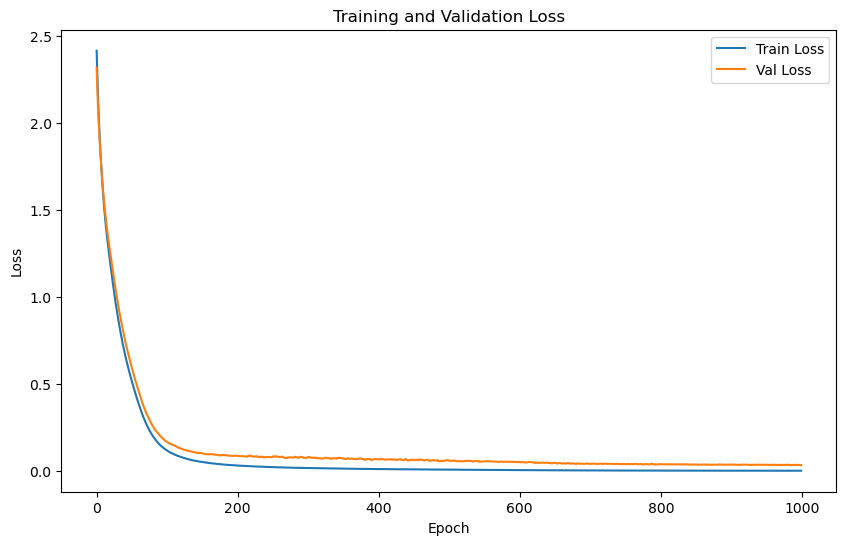

In [59]:
sclsdl_mlp_input_dim = sclsdl_mlp_train_reps.shape[1]
sclsdl_mlp_num_classes = len(torch.unique(sclsdl_mlp_train_labels_torch))
sclsdl_mlp_model = MLPClassifier(sclsdl_mlp_input_dim, sclsdl_mlp_num_classes).to(device)

sclsdl_mlp_criterion = nn.CrossEntropyLoss()
sclsdl_mlp_optimizer = optim.Adam(sclsdl_mlp_model.parameters(), lr=1e-4)

sclsdl_mlp_num_epochs = 1000
sclsdl_mlp_patience = 100

sclsdl_mlp_train_losses = []
sclsdl_mlp_val_losses = []

sclsdl_mlp_best_val_loss = float('inf')
sclsdl_mlp_epochs_without_improvement = 0

for sclsdl_mlp_epoch in range(sclsdl_mlp_num_epochs):
    # Training
    sclsdl_mlp_model.train()
    sclsdl_mlp_train_running_loss = 0.0
    
    for sclsdl_mlp_embeddings_batch, sclsdl_mlp_labels_batch in sclsdl_mlp_train_loader:
        sclsdl_mlp_embeddings_batch = sclsdl_mlp_embeddings_batch.to(device)
        sclsdl_mlp_labels_batch = sclsdl_mlp_labels_batch.to(device)
        
        sclsdl_mlp_optimizer.zero_grad()
        
        # Forward
        sclsdl_mlp_outputs = sclsdl_mlp_model(sclsdl_mlp_embeddings_batch)
        sclsdl_mlp_loss = sclsdl_mlp_criterion(sclsdl_mlp_outputs, sclsdl_mlp_labels_batch)
        
        # Backward & Update
        sclsdl_mlp_loss.backward()
        sclsdl_mlp_optimizer.step()
        
        sclsdl_mlp_train_running_loss += sclsdl_mlp_loss.item() * sclsdl_mlp_embeddings_batch.size(0)
    
    sclsdl_mlp_epoch_train_loss = sclsdl_mlp_train_running_loss / len(sclsdl_mlp_train_loader.dataset)
    sclsdl_mlp_train_losses.append(sclsdl_mlp_epoch_train_loss)

    # Validation
    sclsdl_mlp_model.eval()
    sclsdl_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for sclsdl_mlp_val_embeddings_batch, sclsdl_mlp_val_labels_batch in sclsdl_mlp_val_loader:
            sclsdl_mlp_val_embeddings_batch = sclsdl_mlp_val_embeddings_batch.to(device)
            sclsdl_mlp_val_labels_batch = sclsdl_mlp_val_labels_batch.to(device)

            sclsdl_mlp_val_outputs = sclsdl_mlp_model(sclsdl_mlp_val_embeddings_batch)
            sclsdl_mlp_val_loss = sclsdl_mlp_criterion(sclsdl_mlp_val_outputs, sclsdl_mlp_val_labels_batch)

            sclsdl_mlp_val_running_loss += sclsdl_mlp_val_loss.item() * sclsdl_mlp_val_embeddings_batch.size(0)

    sclsdl_mlp_epoch_val_loss = sclsdl_mlp_val_running_loss / len(sclsdl_mlp_val_loader.dataset)
    sclsdl_mlp_val_losses.append(sclsdl_mlp_epoch_val_loss)

    print(f"[Epoch {sclsdl_mlp_epoch+1}/{sclsdl_mlp_num_epochs}] "
          f"Train Loss: {sclsdl_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {sclsdl_mlp_epoch_val_loss:.4f}")

    # Early stopping
    if sclsdl_mlp_epoch_val_loss < sclsdl_mlp_best_val_loss:
        print(f"Validation loss improved from {sclsdl_mlp_best_val_loss:.4f} to {sclsdl_mlp_epoch_val_loss:.4f}.")
        sclsdl_mlp_best_val_loss = sclsdl_mlp_epoch_val_loss
        sclsdl_mlp_epochs_without_improvement = 0


    else:
        sclsdl_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {sclsdl_mlp_epochs_without_improvement}/{sclsdl_mlp_patience}")
        
        if sclsdl_mlp_epochs_without_improvement >= sclsdl_mlp_patience:
            print(f"!! Early stopping triggered at epoch {sclsdl_mlp_epoch+1} !!\n"
                  f"No improvement for {sclsdl_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(sclsdl_mlp_train_losses, label='Train Loss')
plt.plot(sclsdl_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved SCL_SDL+MLP predictions and true labels to model_predictions
Test Loss: 0.3100 | Test Accuracy: 96.63%


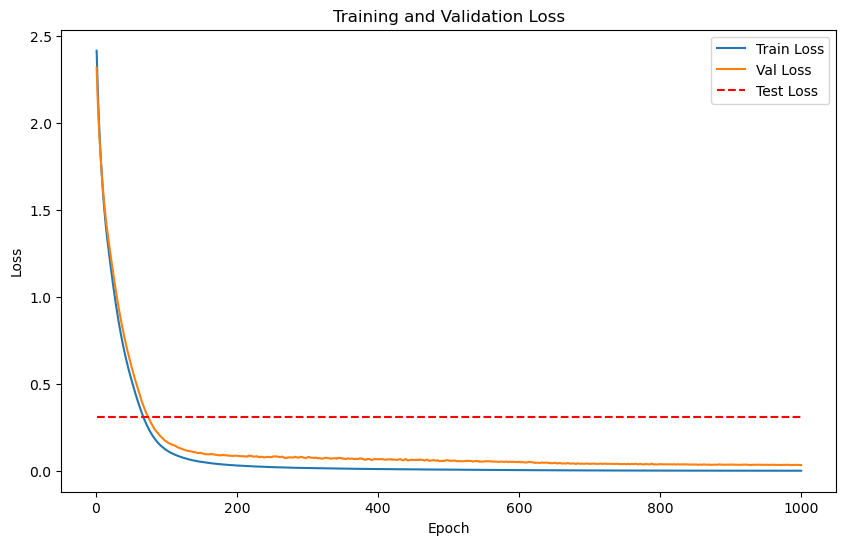

In [60]:
sclsdl_mlp_model.eval()

sclsdl_mlp_test_running_loss = 0.0
sclsdl_mlp_test_correct = 0
sclsdl_mlp_all_predictions = []
sclsdl_mlp_all_true_labels = []

with torch.no_grad():
    for sclsdl_mlp_test_embeddings_batch, sclsdl_mlp_test_labels_batch in sclsdl_mlp_test_loader:
        sclsdl_mlp_test_embeddings_batch = sclsdl_mlp_test_embeddings_batch.to(device)
        sclsdl_mlp_test_labels_batch = sclsdl_mlp_test_labels_batch.to(device)

        # Forward pass
        sclsdl_mlp_test_outputs = sclsdl_mlp_model(sclsdl_mlp_test_embeddings_batch)
        
        # Compute loss
        sclsdl_mlp_test_loss_batch = sclsdl_mlp_criterion(sclsdl_mlp_test_outputs, sclsdl_mlp_test_labels_batch)
        sclsdl_mlp_test_running_loss += sclsdl_mlp_test_loss_batch.item() * sclsdl_mlp_test_embeddings_batch.size(0)

        _, sclsdl_mlp_test_predicted = torch.max(sclsdl_mlp_test_outputs, dim=1)
        sclsdl_mlp_test_correct += (sclsdl_mlp_test_predicted == sclsdl_mlp_test_labels_batch).sum().item()

        sclsdl_mlp_all_predictions.extend(sclsdl_mlp_test_predicted.cpu().numpy())
        sclsdl_mlp_all_true_labels.extend(sclsdl_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'sclsdl_mlp_predictions.npy'), np.array(sclsdl_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'sclsdl_mlp_true_labels.npy'), np.array(sclsdl_mlp_all_true_labels))
print(f"Saved SCL_SDL+MLP predictions and true labels to {predictions_dir}")

sclsdl_mlp_epoch_test_loss = sclsdl_mlp_test_running_loss / len(sclsdl_mlp_test_loader.dataset)
sclsdl_mlp_test_accuracy = sclsdl_mlp_test_correct / len(sclsdl_mlp_test_loader.dataset)

sclsdl_mlp_test_accuracy_pct = sclsdl_mlp_test_accuracy * 100.0

print(f"Test Loss: {sclsdl_mlp_epoch_test_loss:.4f} | Test Accuracy: {sclsdl_mlp_test_accuracy_pct:.2f}%")

sclsdl_mlp_num_epochs_run = len(sclsdl_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         sclsdl_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         sclsdl_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         [sclsdl_mlp_epoch_test_loss]*sclsdl_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Experimental Results and Confusion Matrices

In [61]:
def plot_conf_matrix(model_name, class_names = None, cm_save_dir='confusion_matrices'):
    os.makedirs(cm_save_dir, exist_ok = True)

    #loading predictions and true labels
    predictions_path = os.path.join(predictions_dir, f'{model_name}_predictions.npy')
    true_labels_path = os.path.join(predictions_dir, f'{model_name}_true_labels.npy')

    if not os.path.exists(predictions_path) or not os.path.exists(true_labels_path):
        print(f"Error: Files not found for model {model_name}")
        return
    
    cm_predictions = np.load(predictions_path)
    cm_true_labels = np.load(true_labels_path)

    conf_matrix = confusion_matrix(cm_true_labels, cm_predictions)
    plt.figure(figsize=(8,8))

    conf_matrix_normalised = conf_matrix.astype('float') / conf_matrix.sum(axis = 1)[:, np.newaxis]
    sns.heatmap(conf_matrix_normalised, annot=conf_matrix, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

    plt.title(f"{model_name.upper()} Confusion Matrix", fontsize=16)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()

    cm_save_path = os.path.join(cm_save_dir, f'{model_name}_confusion_matrix.png')
    plt.savefig(cm_save_path, dpi=300, bbox_inches='tight')
    print(f"Saved confusion matrix to: {cm_save_path}")

    plt.show()

    accuracy = np.trace(conf_matrix) / np.sum(conf_matrix)
    print(f"Classification Accuracy: {accuracy*100:.2f}%")

Saving confusion matrices to: confusion_matrices


Saved confusion matrix to: confusion_matrices\e2e_cnn_confusion_matrix.png


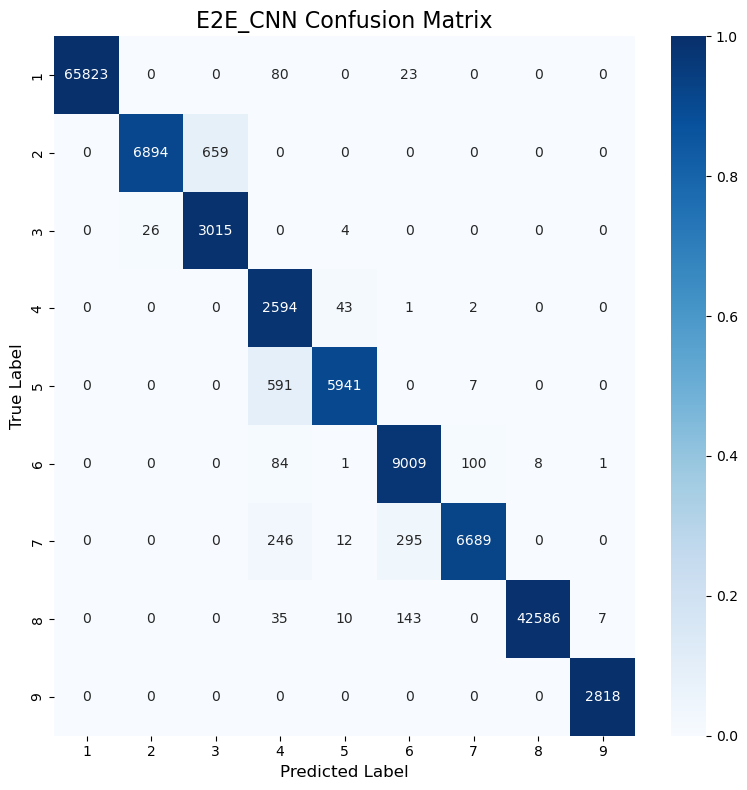

Classification Accuracy: 98.39%


Saved confusion matrix to: confusion_matrices\cae_lrm_confusion_matrix.png


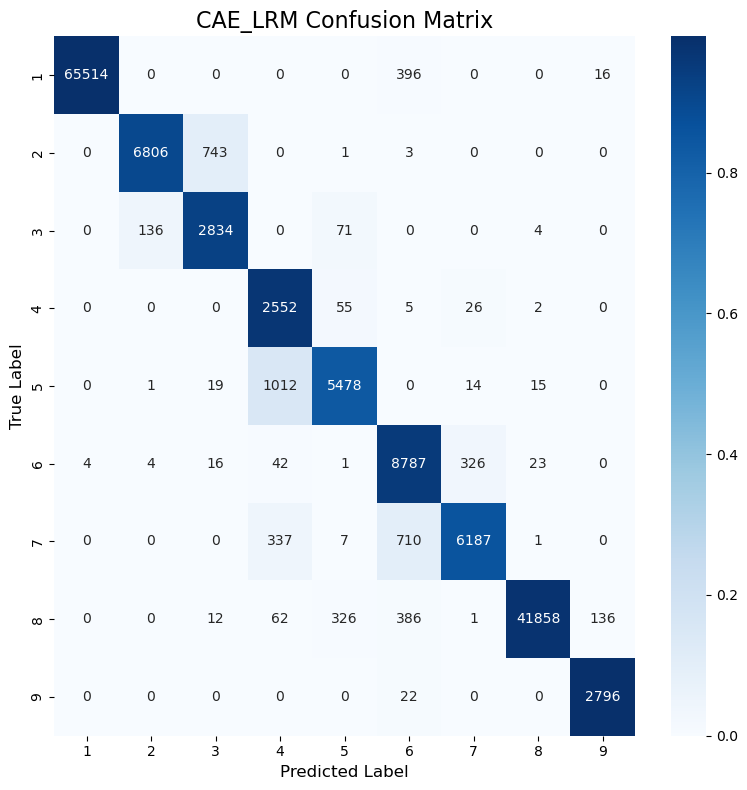

Classification Accuracy: 96.66%


Saved confusion matrix to: confusion_matrices\cae_mlp_confusion_matrix.png


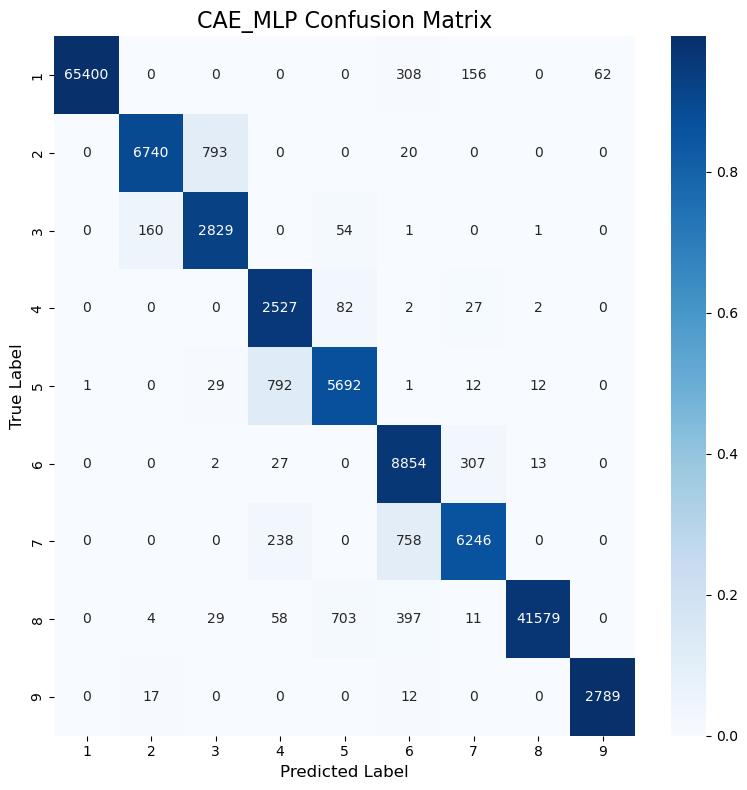

Classification Accuracy: 96.55%


Saved confusion matrix to: confusion_matrices\tscl_lrm_confusion_matrix.png


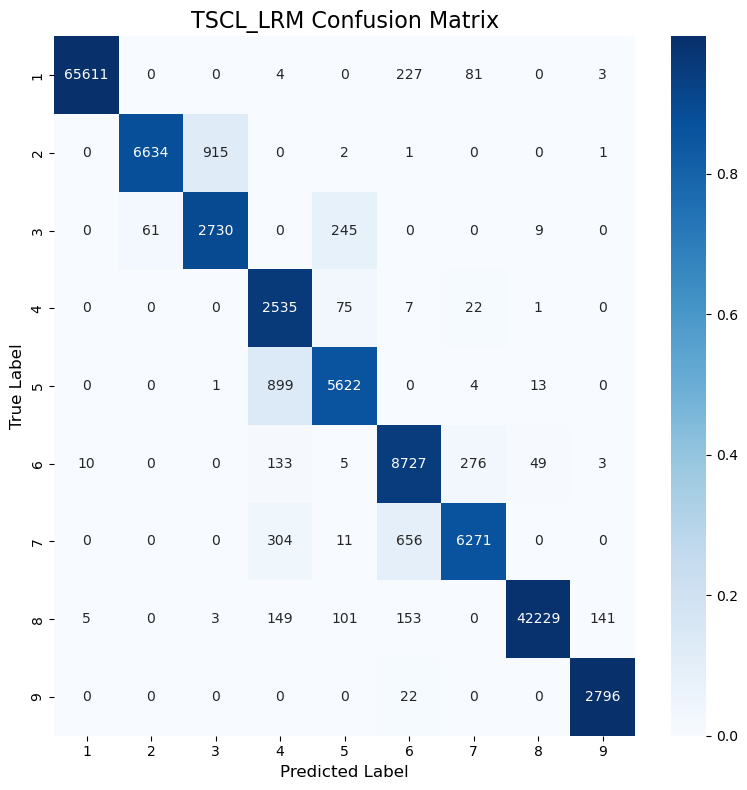

Classification Accuracy: 96.89%


Saved confusion matrix to: confusion_matrices\tscl_mlp_confusion_matrix.png


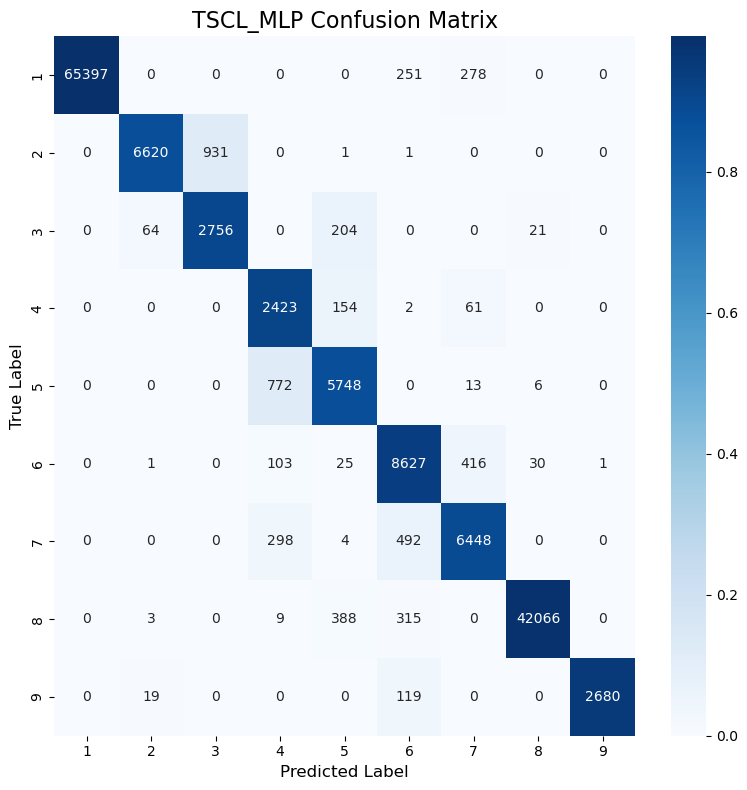

Classification Accuracy: 96.63%


Saved confusion matrix to: confusion_matrices\sclsdl_lrm_confusion_matrix.png


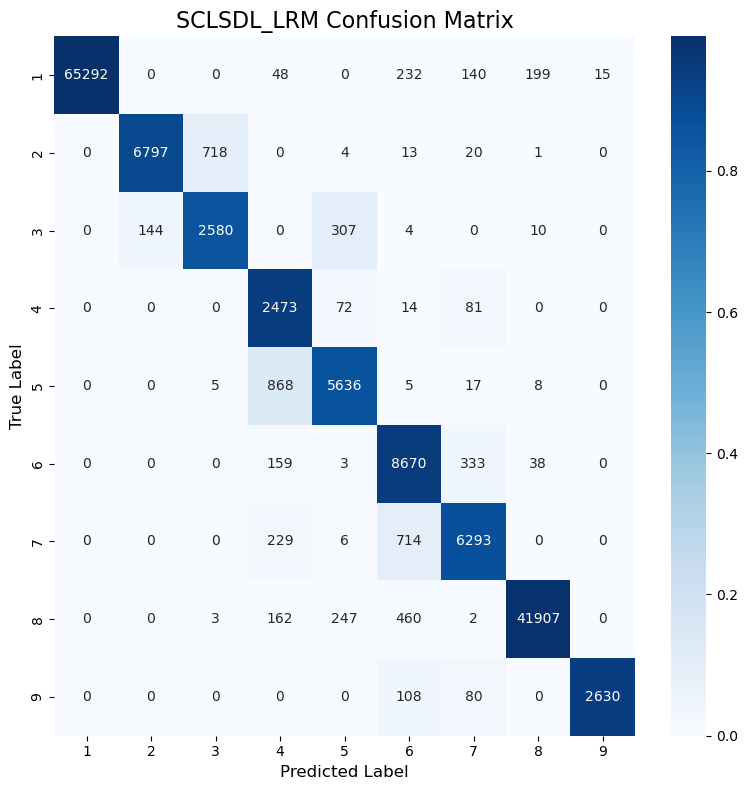

Classification Accuracy: 96.30%


Saved confusion matrix to: confusion_matrices\sclsdl_mlp_confusion_matrix.png


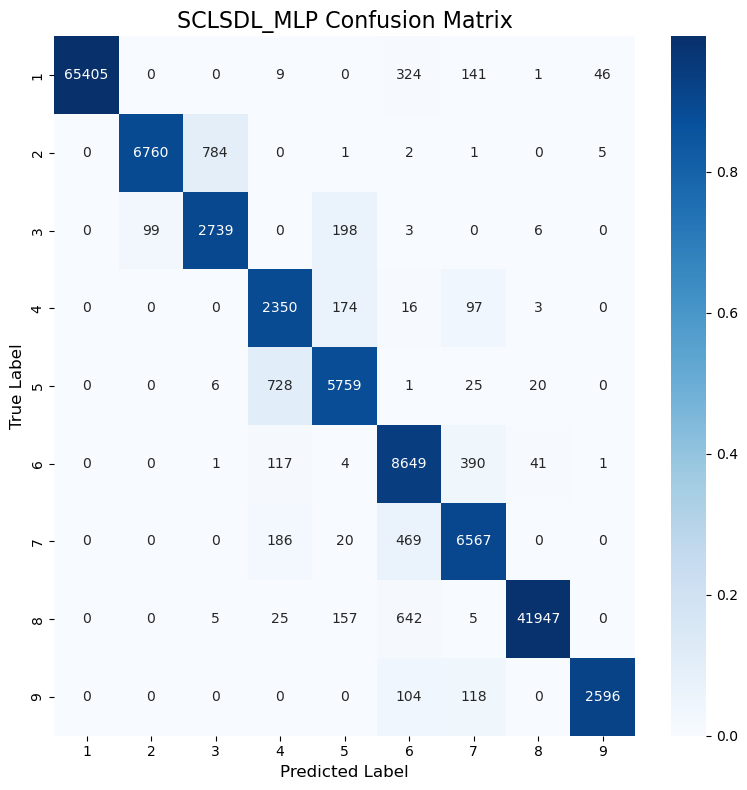

Classification Accuracy: 96.63%


In [62]:
class_names = [str(i+1) for i in range(len(np.unique(y_labels)))]
confusion_matrices_dir = 'confusion_matrices'
os.makedirs(confusion_matrices_dir, exist_ok=True)
print(f"Saving confusion matrices to: {confusion_matrices_dir}")
plot_conf_matrix('e2e_cnn', class_names, confusion_matrices_dir)
plot_conf_matrix('cae_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('cae_mlp', class_names, confusion_matrices_dir)
plot_conf_matrix('tscl_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('tscl_mlp', class_names, confusion_matrices_dir)
plot_conf_matrix('sclsdl_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('sclsdl_mlp', class_names, confusion_matrices_dir)

In [63]:
final_results_df = pd.DataFrame({
    "Model": ["E2E CNN", "LRM (CAE)", "MLP (CAE)", "TSCL LRM", "TSCL MLP", "SCL_SDL LRM", "SCL_SDL MLP"],
    "Test_Accuracy": [test_accuracy, lrm_test_accuracy * 100, cae_mlp_test_accuracy_pct, 
                      tscl_lrm_test_accuracy * 100, tscl_mlp_test_accuracy_pct, 
                      sclsdl_lrm_test_accuracy * 100, sclsdl_mlp_test_accuracy_pct]
})

pd.options.display.float_format = '{:.2f}'.format

print(final_results_df)
print(f"\nIn Desc. Order (Test Accu)\n{final_results_df.sort_values('Test_Accuracy', ascending=False)}")

         Model  Test_Accuracy
0      E2E CNN          98.39
1    LRM (CAE)          96.66
2    MLP (CAE)          96.55
3     TSCL LRM          96.89
4     TSCL MLP          96.63
5  SCL_SDL LRM          96.30
6  SCL_SDL MLP          96.63

In Desc. Order (Test Accu)
         Model  Test_Accuracy
0      E2E CNN          98.39
3     TSCL LRM          96.89
1    LRM (CAE)          96.66
6  SCL_SDL MLP          96.63
4     TSCL MLP          96.63
2    MLP (CAE)          96.55
5  SCL_SDL LRM          96.30
